In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# for visualitation import datetime
import datetime

In [3]:
def standardize(tx):
    mean = np.mean(tx, axis=0)
    std = np.std(tx, axis=0)
    tx = (tx-mean)/std
    return tx

# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *

# loading train data
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]

# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std # tX.c contains data without samples with errors

# checking if features have errors or not
f=np.all(tX!=-999, axis=0)

# Removing features with errors (-999)
tX_fc = tX_c[:,f]

# adding column of 1 at the beginning of tX_fc
tX_fc= np.hstack(( np.ones((tX_fc.shape[0], 1), dtype=tX_fc.dtype),tX_fc)) 

In [6]:
# Describing features: True-> No error False -> At least one error
f

array([False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True])

In [7]:
print(f[22],any(tX[:,22]>3)==True) 
# This shows that the features number of jets has no errors and only four possible values: 0,1,2,3

True False


Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


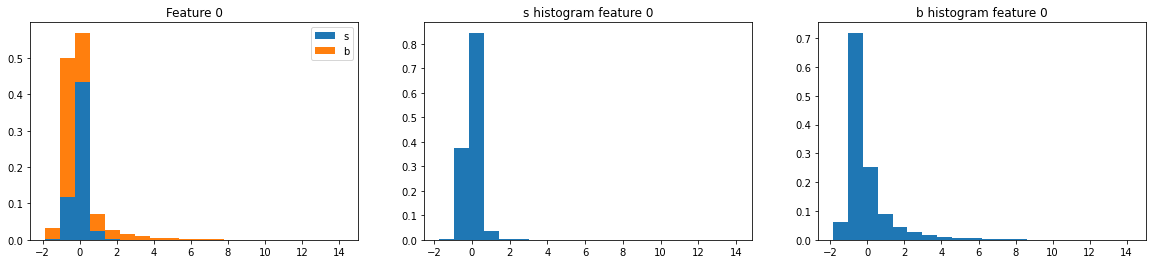

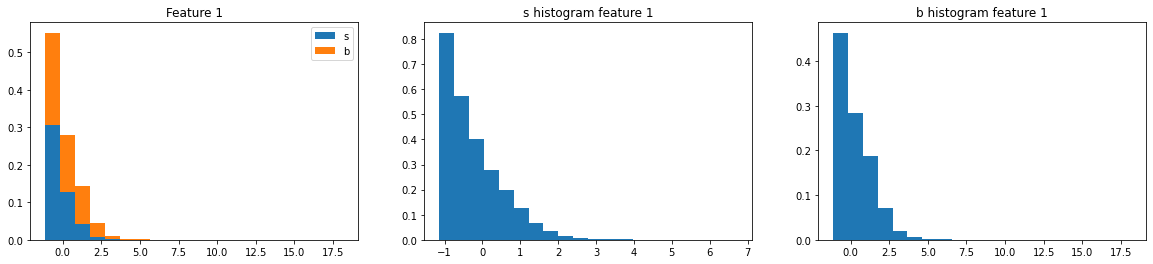

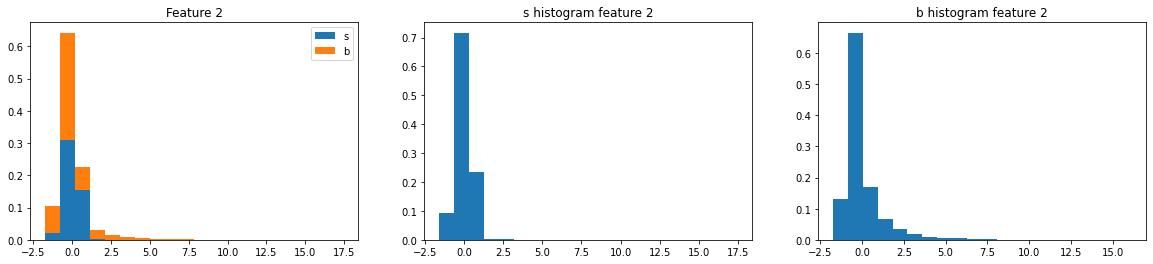

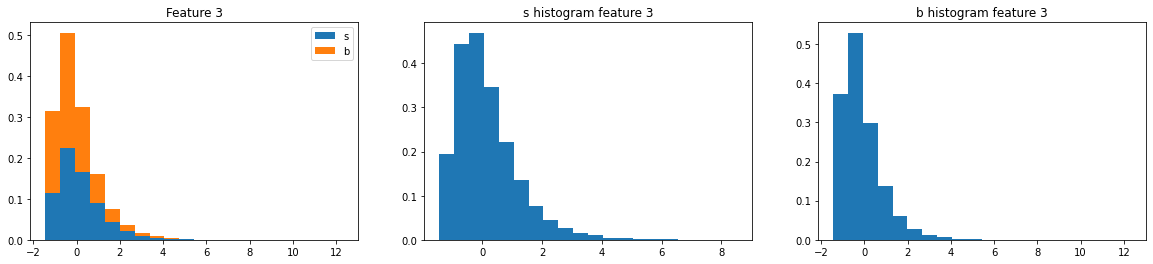

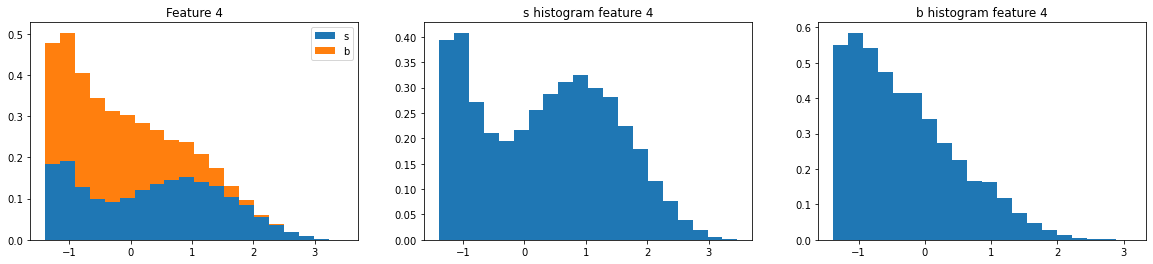

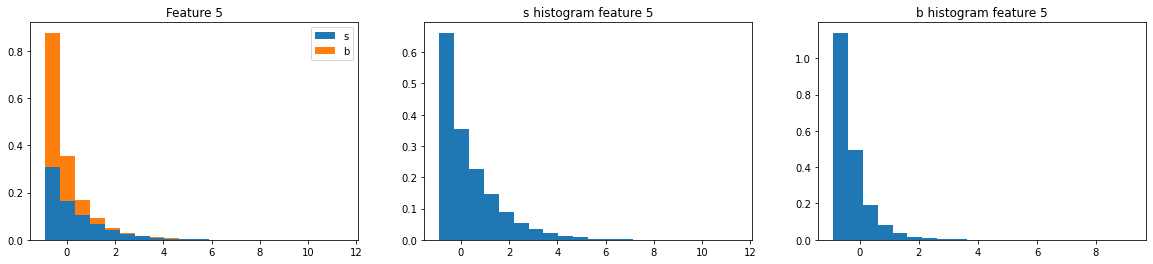

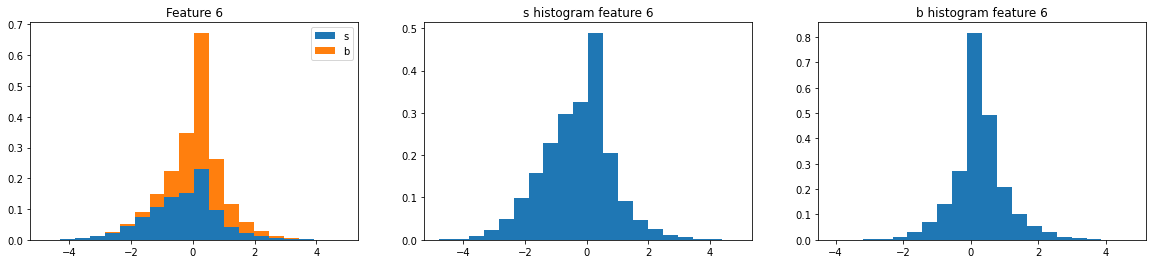

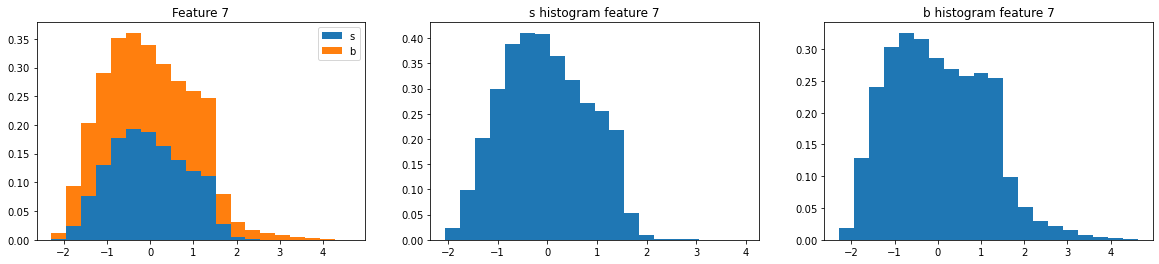

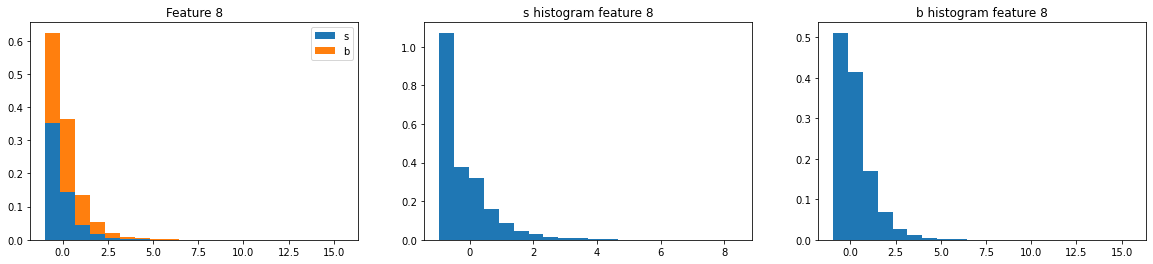

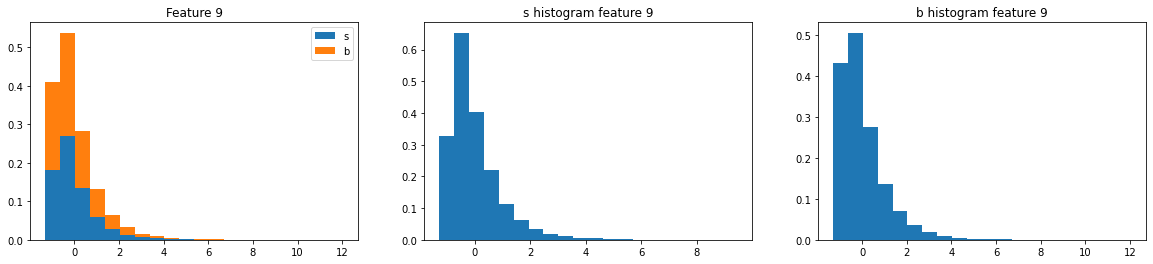

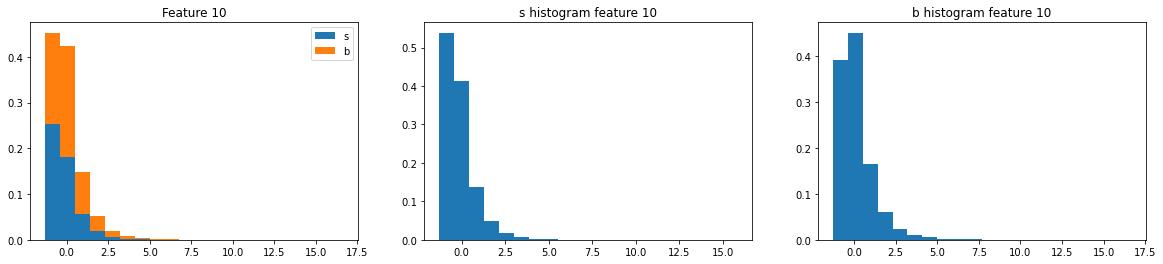

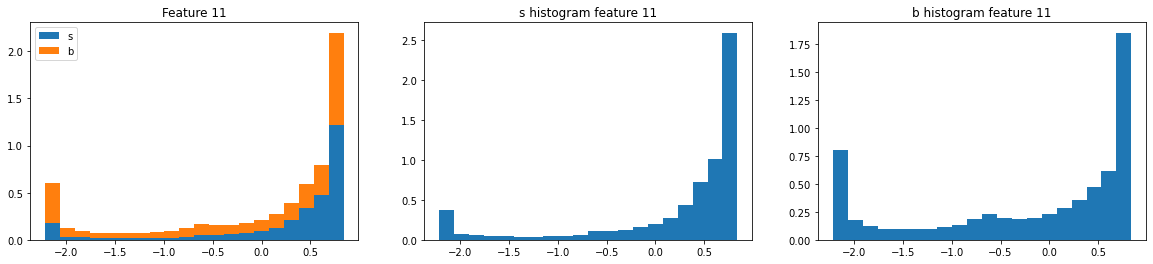

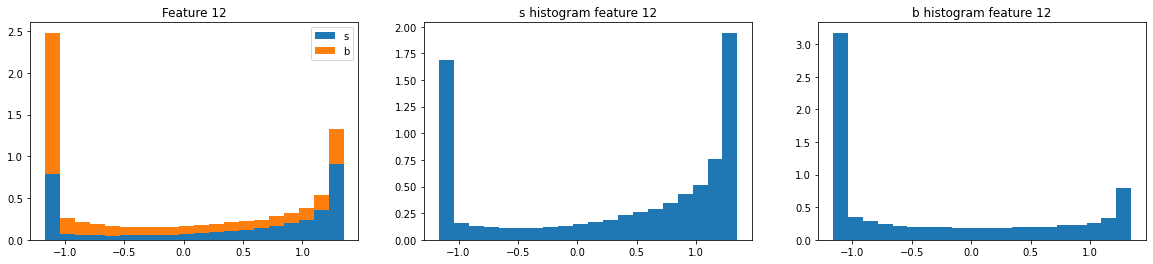

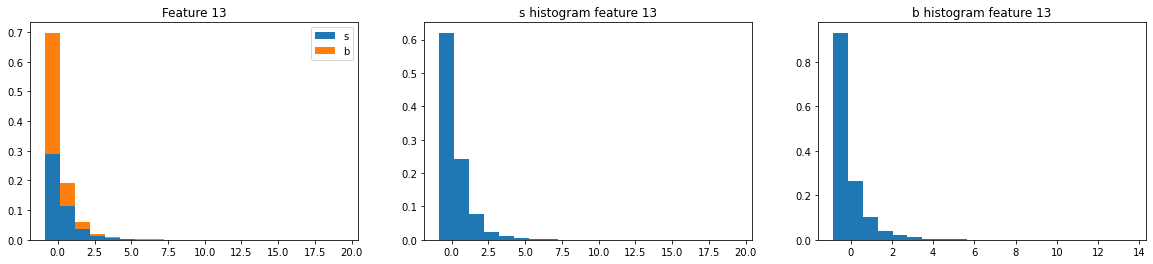

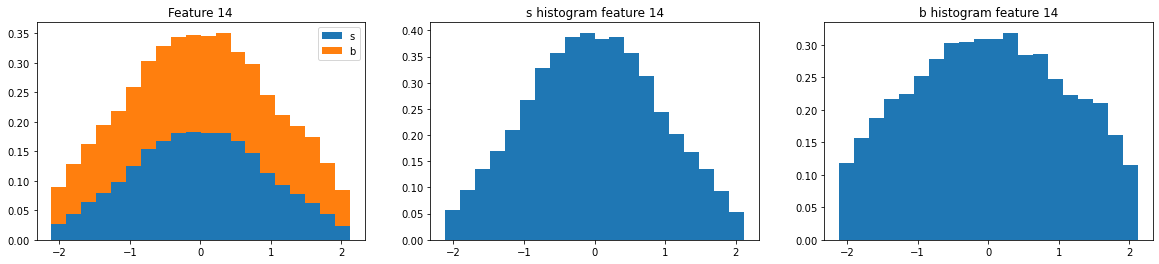

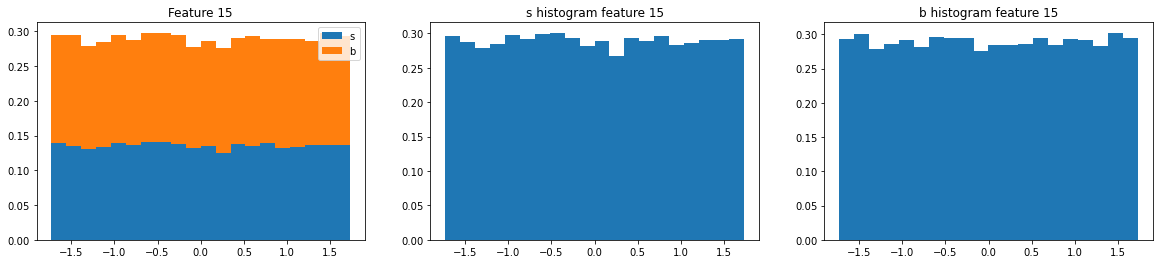

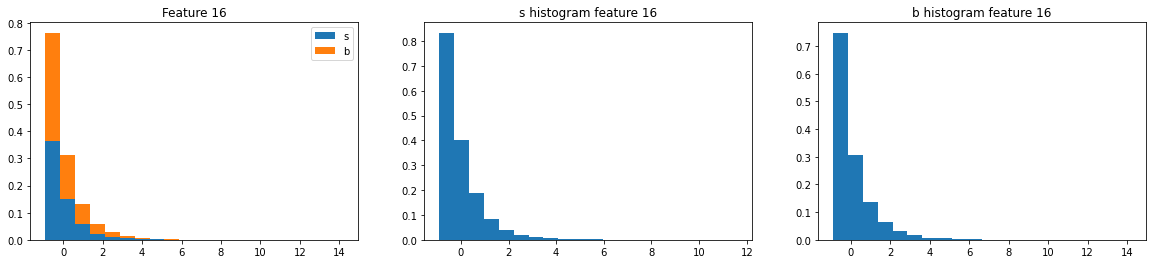

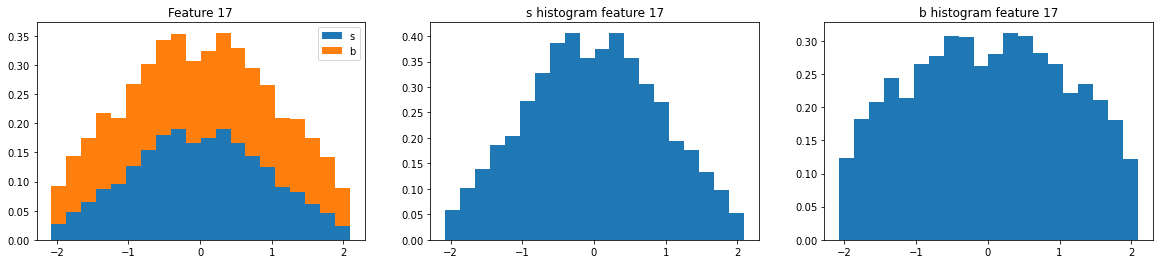

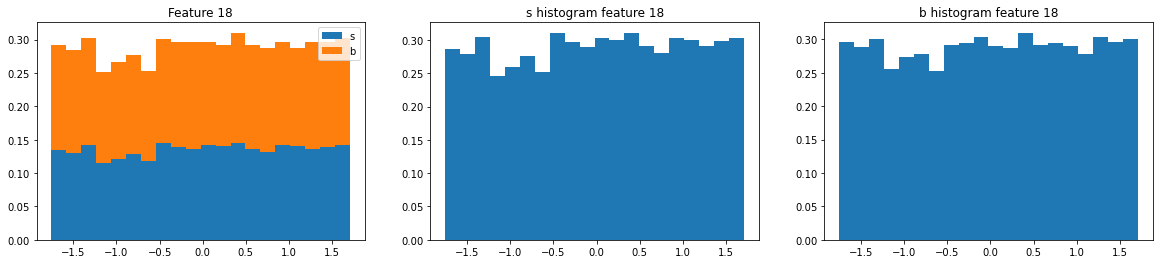

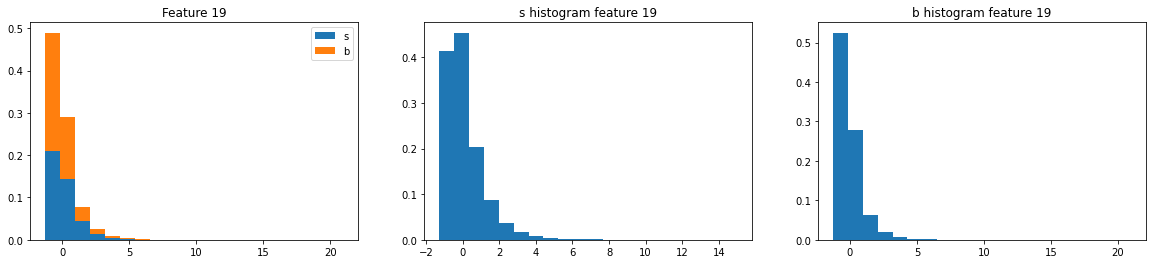

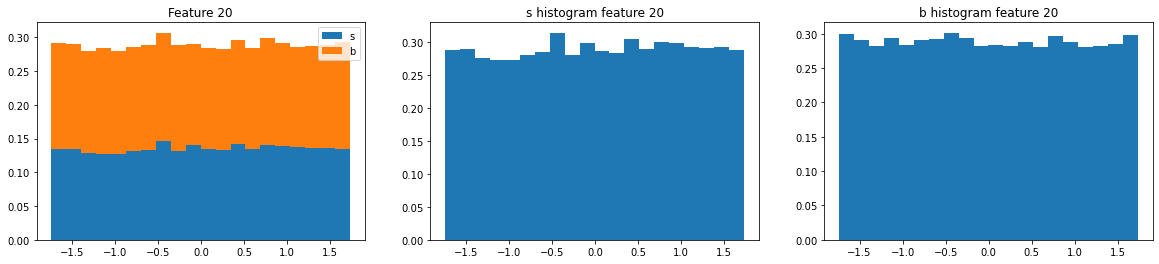

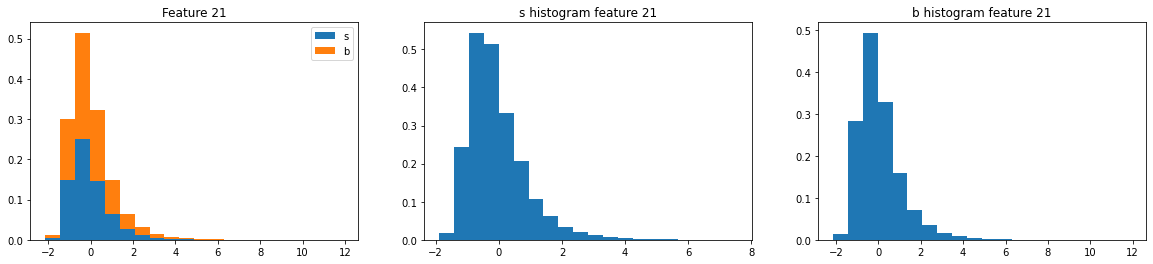

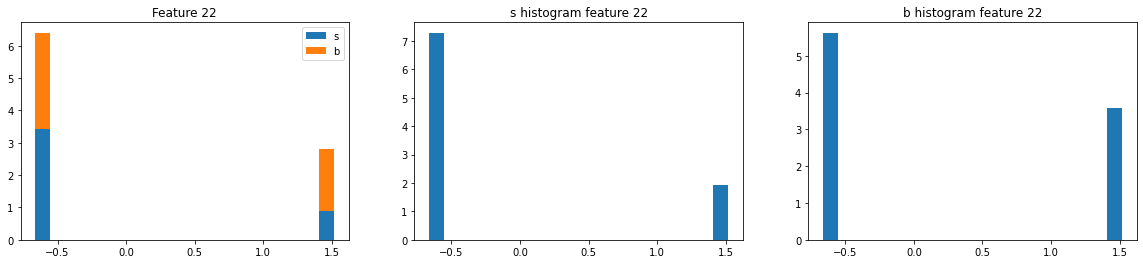

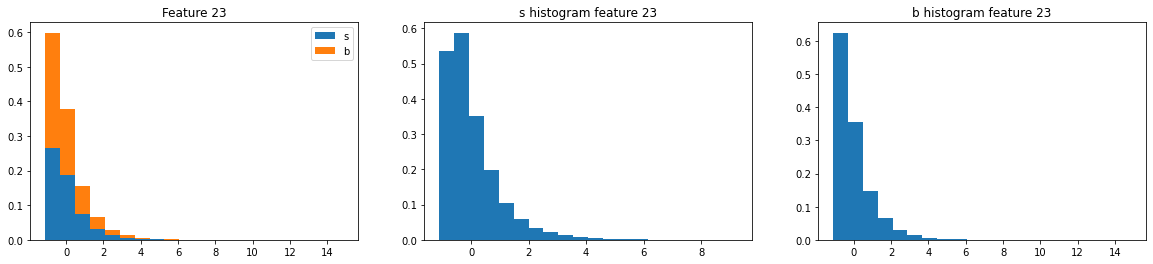

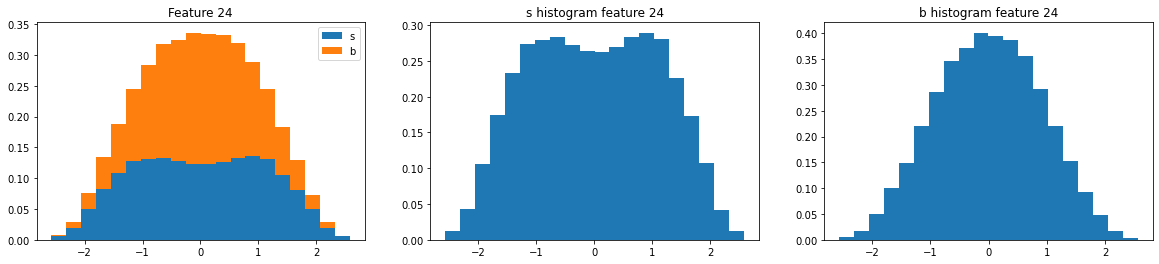

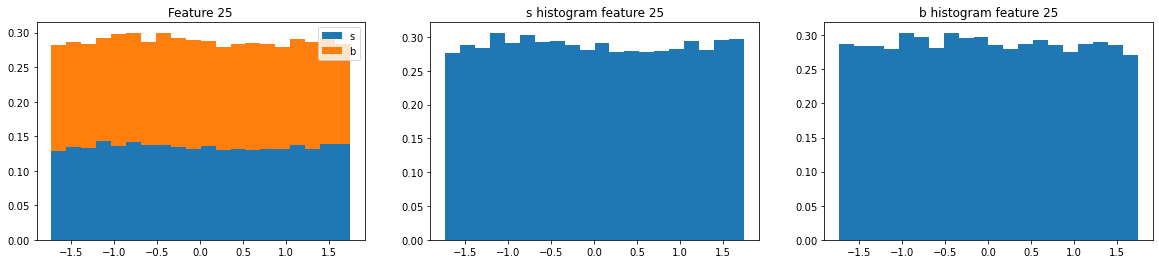

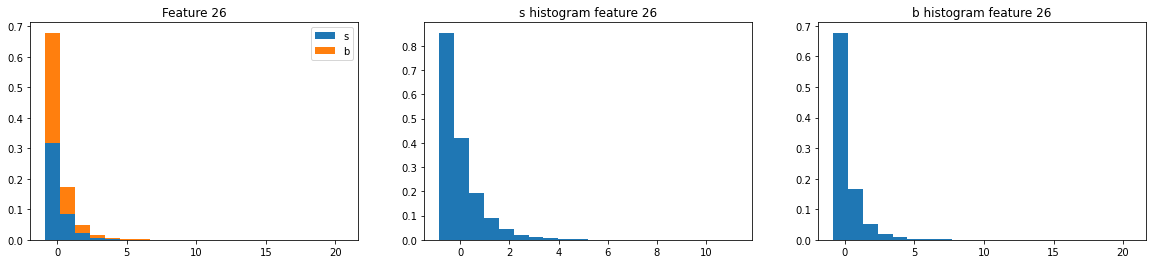

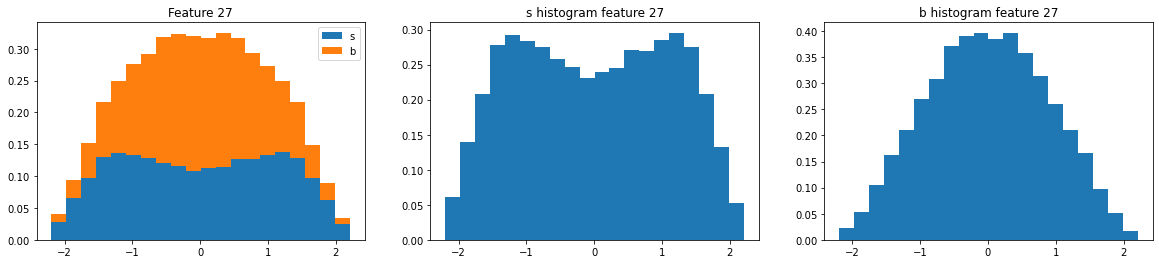

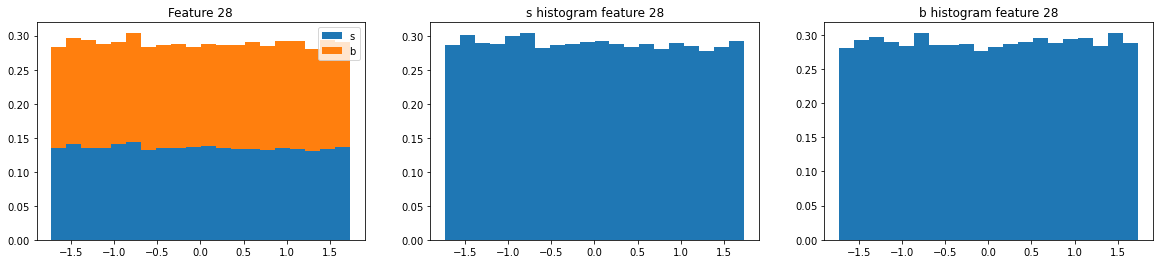

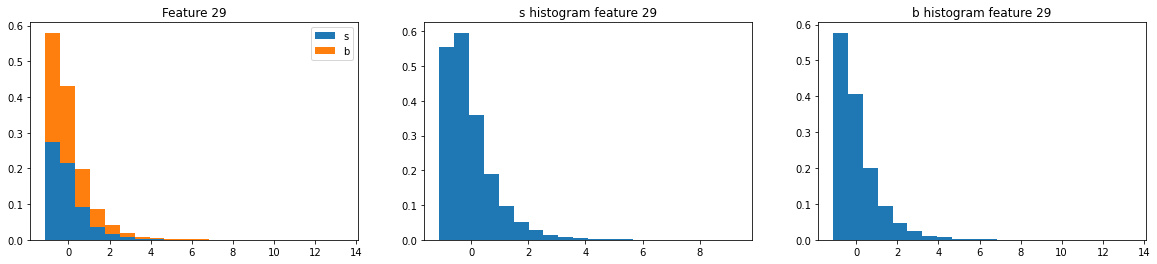

In [8]:
#plot of all features
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
for n in range(tX_c.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(n))
    plt.subplot(132)
    plt.title('s histogram feature '+str(n))
    plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(n))
    plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [9]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000


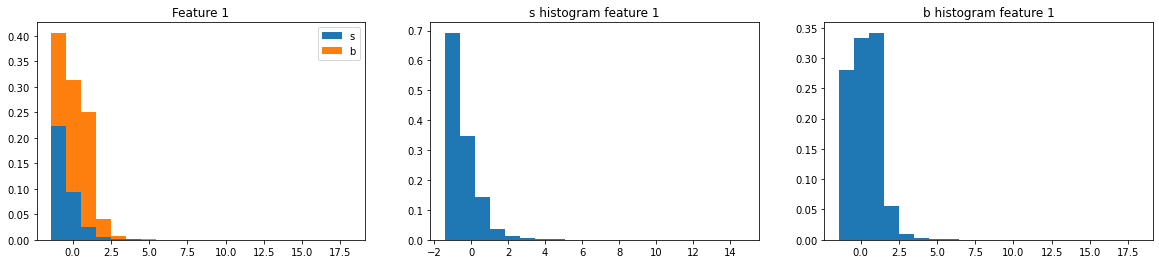

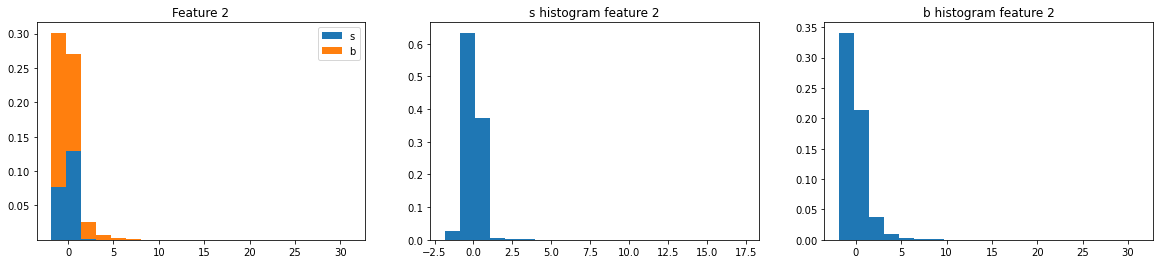

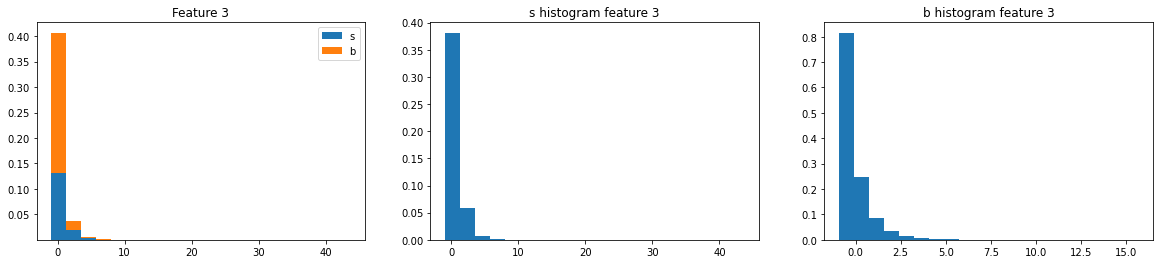

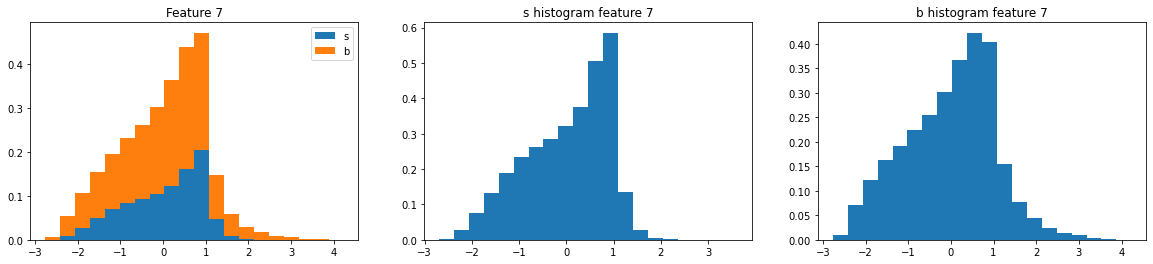

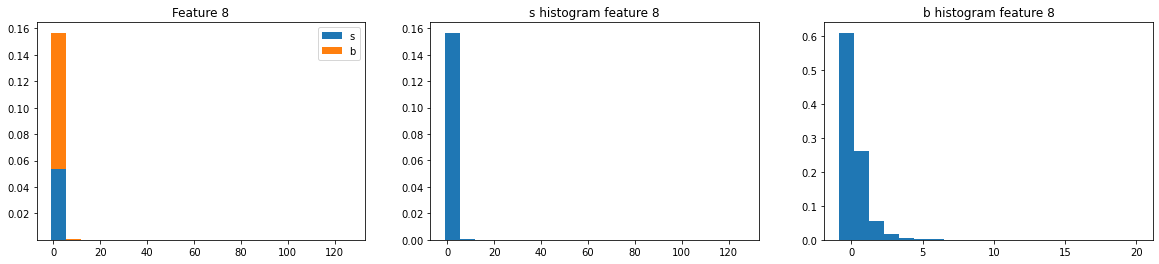

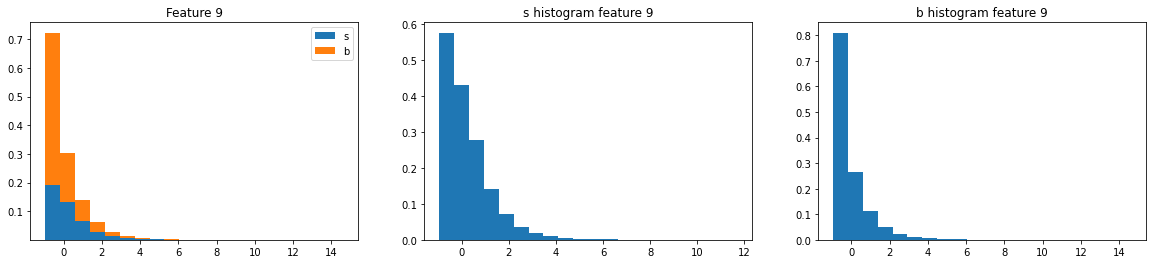

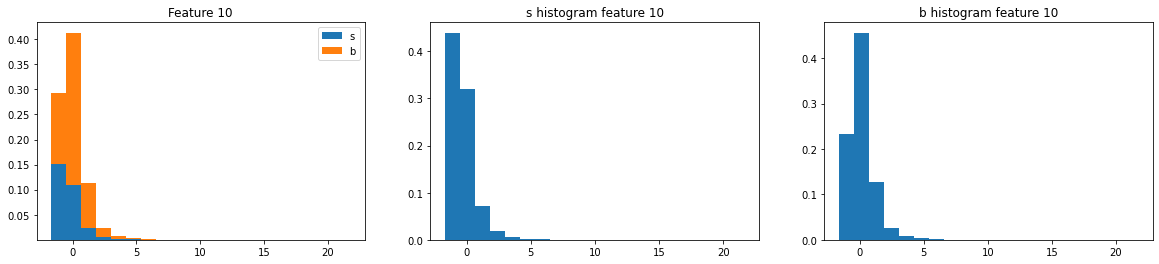

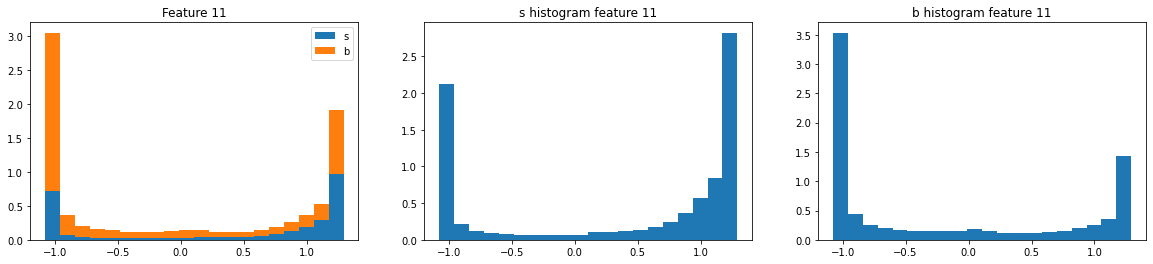

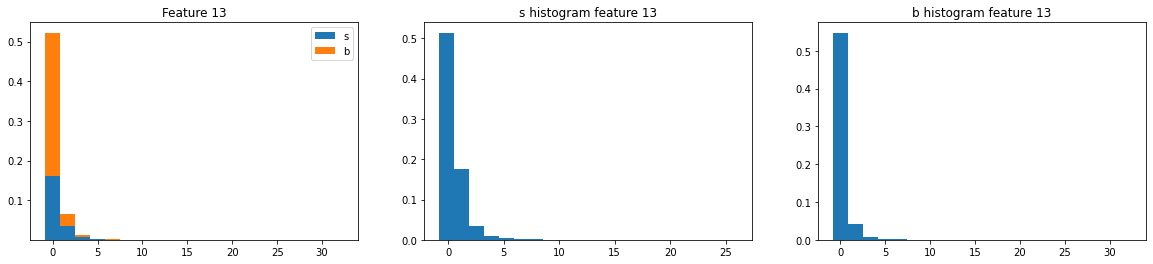

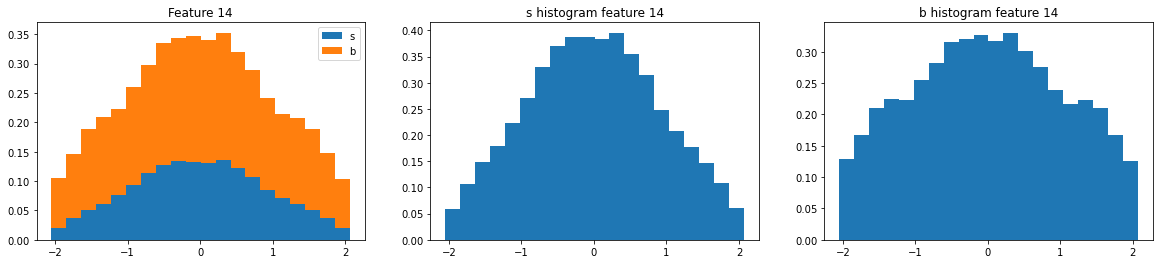

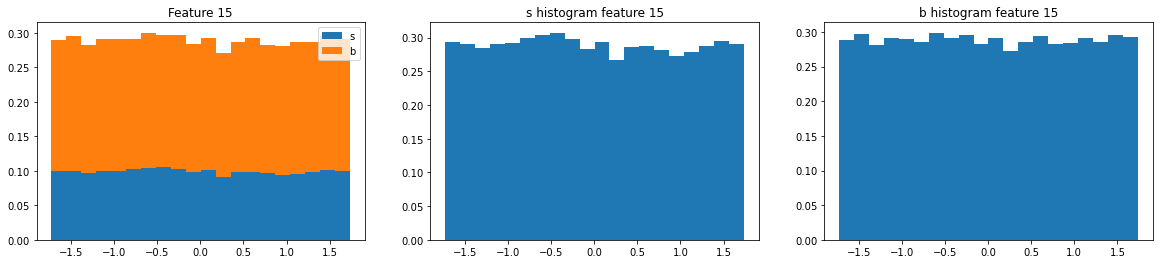

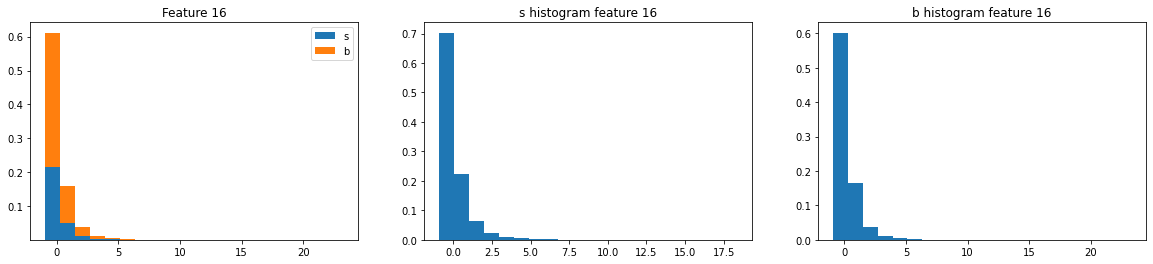

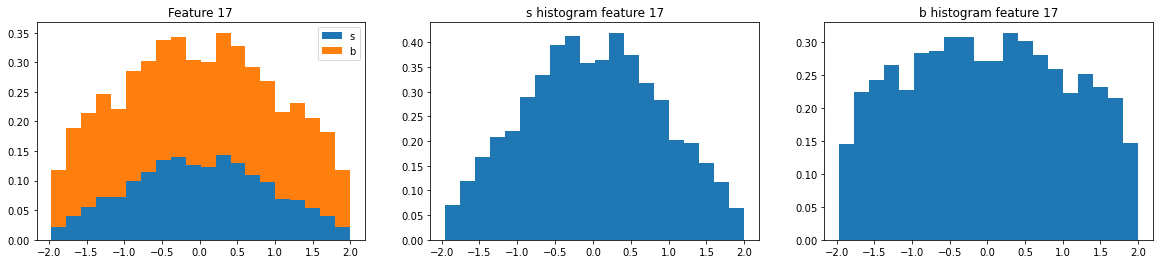

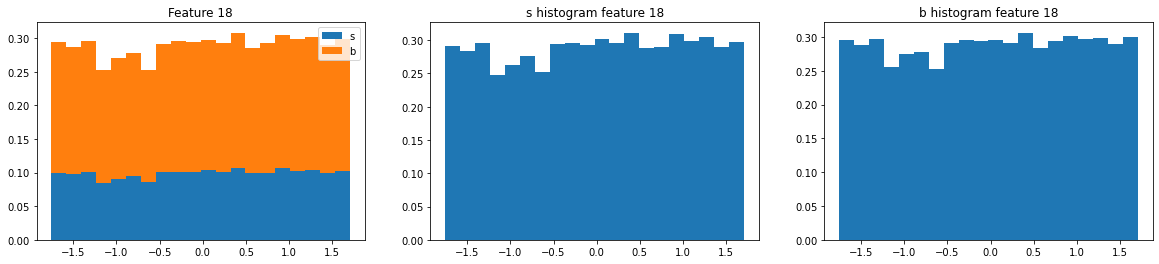

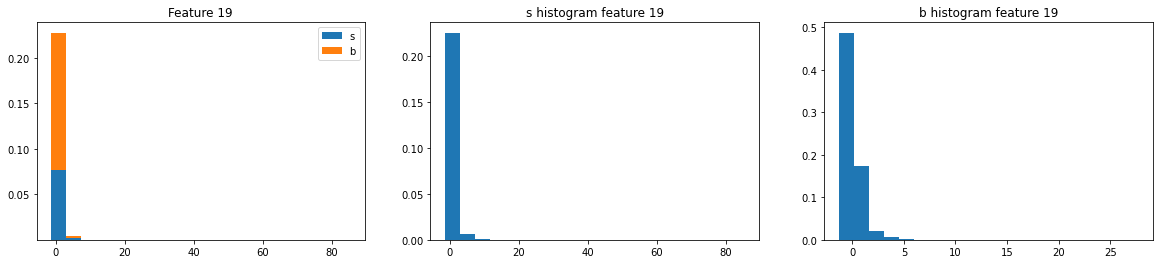

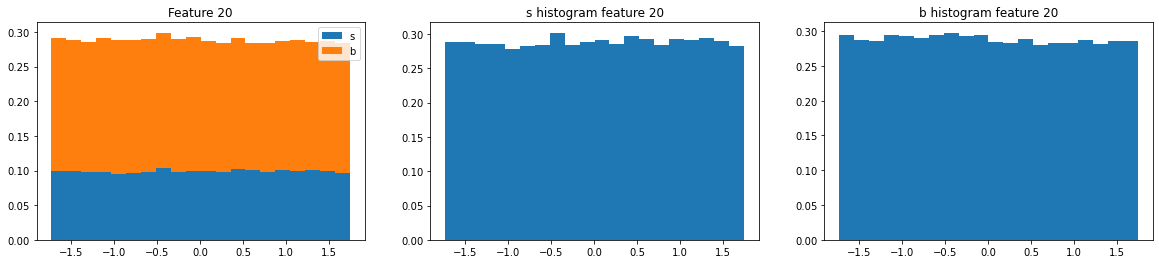

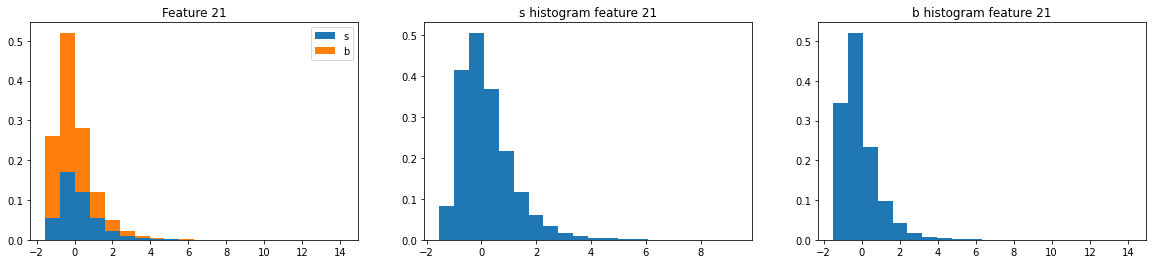

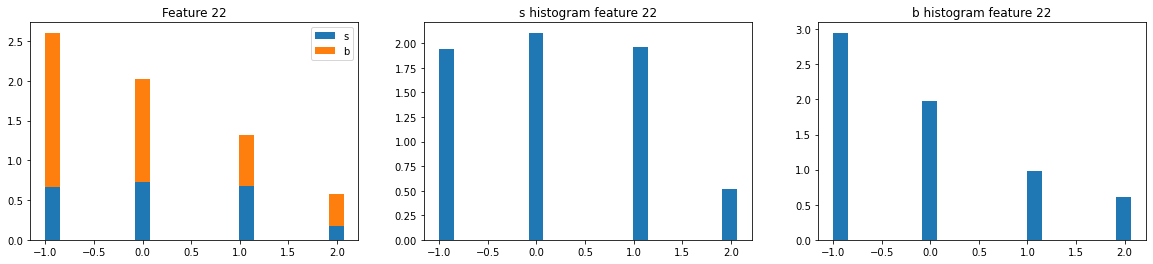

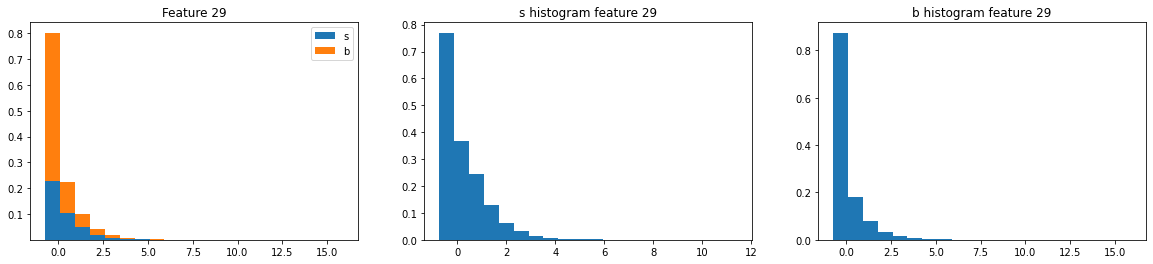

In [10]:
# plot of features without errors
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for n in range(tX_gf.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(idx_gf[n]))
    plt.subplot(132)
    plt.title('s histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters. 
Feature 15 ,18, 20 does not seem to impact the result.

In [11]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0 = tX[:,22]==0
jet_1 = tX[:,22]==1
jet_2 = tX[:,22]==2
jet_3 = tX[:,22]==3

#Splitting tX and y
tX_0 = tX[jet_0, :]
tX_1 = tX[jet_1, :]
tX_2 = tX[jet_2, :]
tX_3 = tX[jet_3, :]
y_0 = y[jet_0]
y_1 = y[jet_1]
y_2 = y[jet_2]
y_3 = y[jet_3]

#Removing column with jet number
tX_0=np.delete(tX_0,22,1)
tX_1=np.delete(tX_1,22,1)
tX_2=np.delete(tX_2,22,1)
tX_3=np.delete(tX_3,22,1)

# selection of features without errors in every partition of tX
f_0 =np.all(tX_0!=-999, axis=0)
tX_0_gf = tX_0[:,f_0]
f_1 =np.all(tX_1!=-999, axis=0)
tX_1_gf = tX_1[:,f_1]
f_2 =np.all(tX_2!=-999, axis=0)
tX_2_gf = tX_2[:,f_2]
f_3 =np.all(tX_3!=-999, axis=0)
tX_3_gf = tX_3[:,f_3]
tX_3_gf.shape[0] + tX_2_gf.shape[0] + tX_1_gf.shape[0] + tX_0_gf.shape[0]

250000

In [12]:
#Removing last column of tX_0_gf (It's an all zero column)
tX_0_gf = tX_0_gf[:,0:tX_0_gf.shape[1]-1]

In [13]:
# Standardize data
tX_0_gf = standardize(tX_0_gf)
tX_1_gf = standardize(tX_1_gf)
tX_2_gf = standardize(tX_2_gf)
tX_3_gf = standardize(tX_3_gf)
tX_0_gf.shape

(99913, 17)

In [14]:
# function that add new features 
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    phi=np.zeros((x.shape[0],degree*x.shape[1]))
    for j in range(degree):
            phi[:,j*x.shape[1]:(j+1)*x.shape[1]]=x**(j+1)
    return phi

In [15]:
# Passing to polynomial regression of degree= 'degree'
# Deciding degree
degree = 1

tX_0_gf=build_poly(tX_0_gf, degree)
tX_1_gf=build_poly(tX_1_gf, degree)
tX_2_gf=build_poly(tX_2_gf, degree)
tX_3_gf=build_poly(tX_3_gf, degree)

In [16]:
# adding column of 1 at the beginning of tX_gf
tX_0_gf= np.hstack(( np.ones((tX_0_gf.shape[0], 1), dtype=tX_0_gf.dtype),tX_0_gf))
tX_1_gf= np.hstack(( np.ones((tX_1_gf.shape[0], 1), dtype=tX_1_gf.dtype),tX_1_gf))
tX_2_gf= np.hstack(( np.ones((tX_2_gf.shape[0], 1), dtype=tX_2_gf.dtype),tX_2_gf))
tX_3_gf= np.hstack(( np.ones((tX_3_gf.shape[0], 1), dtype=tX_3_gf.dtype),tX_3_gf))


In [17]:
from implementations import *

# indices of samples with no errors
ids_=ids[idx_c]

In [18]:
# least_squares method 
w_ls_0, loss_ls_0 =least_squares(y_0,tX_0_gf)
w_ls_1, loss_ls_1 =least_squares(y_1,tX_1_gf)
w_ls_2, loss_ls_2 =least_squares(y_2,tX_2_gf)
w_ls_3, loss_ls_3 =least_squares(y_3,tX_3_gf)
loss_ls_0, loss_ls_1,loss_ls_2,loss_ls_3
#w_ls_0, w_ls_1, w_ls_2, w_ls_3

(0.27213922342912444,
 0.3727001174476139,
 0.35542370977924176,
 0.3594284375632391)

In [19]:
# Least square using GD

# starting value for GD method
w_in_0_GD= np.zeros((tX_0_gf.shape[1],))
w_in_1_GD= np.zeros((tX_1_gf.shape[1],))
w_in_2_GD= np.zeros((tX_2_gf.shape[1],))
w_in_3_GD= np.zeros((tX_3_gf.shape[1],))

# number of iterations for GD method
max_iters=1000

# step-size of the method
gamma_GD = 0.01

In [20]:
# application of the LS GD method to the separated dataset
# 0 jet
w_ls_GD_0 = w_in_0_GD
for iter in range(max_iters):
    w_ls_GD_0, loss_ls_GD_0 = least_squares_GD(y_0,tX_0_gf, w_ls_GD_0, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_0, w0=w_ls_GD_0))

Gradient Descent(0/999): loss=0.49357286346805435, w=[-4.89716053e-03 -3.60114905e-03  2.84309219e-04  9.85883536e-05
  1.92338797e-03  9.85883602e-05  1.01762383e-03 -2.90339137e-03
  1.32911360e-03  2.55892263e-03  5.66382172e-05 -4.88423873e-05
 -1.02803664e-03  1.22117317e-04  3.77761388e-05 -2.11842399e-03
  1.03424831e-05  8.96632760e-04]
Gradient Descent(1/999): loss=0.4873917721817761, w=[-9.74534945e-03 -7.11699571e-03  5.39440426e-04  1.91750507e-04
  3.80146221e-03  1.91750519e-04  2.01464536e-03 -5.73150535e-03
  2.62405128e-03  5.05781528e-03  1.10829160e-04 -9.65333291e-05
 -2.02667401e-03  2.41189066e-04  7.47588354e-05 -4.17897944e-03
  1.92514745e-05  1.76769772e-03]
Gradient Descent(2/999): loss=0.4814457800291571, w=[-1.45450565e-02 -1.05496767e-02  7.66267558e-04  2.79682333e-04
  5.63545858e-03  2.79682351e-04  2.99162853e-03 -8.48623236e-03
  3.88570203e-03  7.49821523e-03  1.62646987e-04 -1.43101037e-04
 -2.99660629e-03  3.57298776e-04  1.10962610e-04 -6.18312474

Gradient Descent(38/999): loss=0.363227100127802, w=[-0.15880069 -0.0930266  -0.00424201  0.00118132  0.05044029  0.00118132
  0.02845468 -0.07142726  0.03302034  0.06657587  0.0009314  -0.00125979
 -0.02354985  0.00311219  0.00099862 -0.05051866 -0.00031315  0.02112425]
Gradient Descent(39/999): loss=0.3615200361925537, w=[-0.16210984 -0.0944876  -0.0046271   0.001168    0.05126991  0.001168
  0.02896877 -0.07244526  0.03350425  0.06763747  0.00093254 -0.00127937
 -0.02382787  0.00316081  0.00101413 -0.05119039 -0.000333    0.02140445]
Gradient Descent(40/999): loss=0.3598614535625244, w=[-0.16538591 -0.09591681 -0.00502063  0.00115355  0.05208427  0.00115355
  0.0294755  -0.07343539  0.03397584  0.06867689  0.000933   -0.0012985
 -0.02409461  0.0032084   0.00102926 -0.05184079 -0.00035315  0.021676  ]
Gradient Descent(41/999): loss=0.3582495927549568, w=[-0.16862921 -0.09731502 -0.0054223   0.00113802  0.05288381  0.00113802
  0.02997506 -0.07439833  0.03443543  0.06969469  0.0009328

 -0.0280089   0.00424533  0.00132813 -0.06347607 -0.00101261  0.0266809 ]
Gradient Descent(70/999): loss=0.3260504580036299, w=[-0.24980892 -0.12731079 -0.01959332  0.00038873  0.07117342  0.00038873
  0.04199514 -0.09310658  0.04370035  0.09182716  0.00072982 -0.0017088
 -0.02804307  0.00427215  0.00133447 -0.06368599 -0.00103647  0.02677912]
Gradient Descent(71/999): loss=0.32529700405779943, w=[-0.25220799 -0.12806398 -0.0201409   0.00035707  0.07167829  0.00035707
  0.04234265 -0.09350753  0.04391219  0.09239269  0.00071836 -0.00171822
 -0.02807222  0.00429852  0.00134058 -0.0638863  -0.00106034  0.0268737 ]
Gradient Descent(72/999): loss=0.32456038125194475, w=[-0.25458307 -0.1288029  -0.02069093  0.00032524  0.07217705  0.00032524
  0.04268665 -0.09389621  0.0441186   0.09294812  0.00070673 -0.00172743
 -0.02809648  0.00432446  0.00134649 -0.06407724 -0.0010842   0.02696474]
Gradient Descent(73/999): loss=0.32384010642834776, w=[-0.2569344  -0.12952792 -0.02124331  0.00029325  0.

 -1.86486571e-03  2.85185433e-02]
Gradient Descent(107/999): loss=0.30651561885930034, w=[-3.24312301e-01 -1.47900025e-01 -4.08069914e-02 -8.11429331e-04
  8.68776487e-02 -8.11430248e-04  5.29861006e-02 -1.01752428e-01
  4.87758712e-02  1.07546064e-01  2.43224901e-04 -1.94652951e-03
 -2.67015757e-02  5.03053826e-03  1.44661483e-03 -6.63654708e-02
 -1.88636701e-03  2.85319672e-02]
Gradient Descent(108/999): loss=0.30616082926315447, w=[-3.25966338e-01 -1.48302416e-01 -4.13917059e-02 -8.42950487e-04
  8.72427761e-02 -8.42951418e-04  5.32410845e-02 -1.01857618e-01
  4.88547298e-02  1.07859149e-01  2.29510435e-04 -1.95053888e-03
 -2.66165928e-02  5.04647017e-03  1.44708438e-03 -6.63393316e-02
 -1.90776407e-03  2.85441250e-02]
Gradient Descent(109/999): loss=0.3058125048382332, w=[-3.27603836e-01 -1.48699022e-01 -4.19763664e-02 -8.74363555e-04
  8.76058569e-02 -8.74364501e-04  5.34943391e-02 -1.01958138e-01
  4.89314032e-02  1.08167950e-01  2.15814604e-04 -1.95445392e-03
 -2.65299315e-02  5

Gradient Descent(146/999): loss=0.2963905425289978, w=[-3.77947933e-01 -1.60311214e-01 -6.33217331e-02 -1.94842333e-03
  1.00032030e-01 -1.94842483e-03  6.18625371e-02 -1.03302430e-01
  5.06117908e-02  1.17281086e-01 -2.61686042e-04 -2.04774305e-03
 -2.25278221e-02  5.55221137e-03  1.40565932e-03 -6.33531621e-02
 -2.63823310e-03  2.83575656e-02]
Gradient Descent(147/999): loss=0.29620686303113847, w=[-3.79065614e-01 -1.60563499e-01 -6.38860239e-02 -1.97495992e-03
  1.00349315e-01 -1.97496144e-03  6.20662220e-02 -1.03293778e-01
  5.06339574e-02  1.17479743e-01 -2.73518865e-04 -2.04918923e-03
 -2.24062274e-02  5.56349723e-03  1.40340697e-03 -6.32374571e-02
 -2.65524299e-03  2.83414244e-02]
Gradient Descent(148/999): loss=0.29602598797958185, w=[-3.80172118e-01 -1.60813405e-01 -6.44494737e-02 -2.00136795e-03
  1.00665956e-01 -2.00136948e-03  6.22689168e-02 -1.03283540e-01
  5.06552262e-02  1.17676502e-01 -2.85286622e-04 -2.05059212e-03
 -2.22842512e-02  5.57470199e-03  1.40111201e-03 -6.3

Gradient Descent(185/999): loss=0.2908829102550665, w=[-0.41419109 -0.16876276 -0.08464884 -0.0028953   0.11205425 -0.0028953
  0.06916362 -0.10212887  0.05095421  0.12389479 -0.00067396 -0.00207821
 -0.01763973  0.00594117  0.0012945  -0.05812894 -0.00322305  0.02756098]
Gradient Descent(186/999): loss=0.2907765532534767, w=[-0.41494634 -0.16895049 -0.0851763  -0.00291743  0.11235561 -0.00291743
  0.06933566 -0.10208385  0.05095217  0.12404001 -0.00068321 -0.00207843
 -0.01751346  0.00594995  0.00129122 -0.05798149 -0.00323606  0.02753809]
Gradient Descent(187/999): loss=0.29067152312994754, w=[-0.41569403 -0.16913711 -0.08570276 -0.00293947  0.11265671 -0.00293948
  0.06950703 -0.10203839  0.05094972  0.12418426 -0.0006924  -0.00207864
 -0.01738727  0.00595869  0.00128793 -0.05783359 -0.00324897  0.02751516]
Gradient Descent(188/999): loss=0.290567795751364, w=[-0.41643425 -0.16932264 -0.08622823 -0.00296142  0.11295757 -0.00296142
  0.06967774 -0.10199252  0.05094687  0.12432758 -0.

Gradient Descent(225/999): loss=0.28746377893643, w=[-0.43919198 -0.17556446 -0.10497214 -0.00371621  0.12394054 -0.00371622
  0.07557615 -0.1001227   0.0506183   0.12907607 -0.00099743 -0.00207312
 -0.01269133  0.00625613  0.00115766 -0.05198939 -0.00367773  0.0266475 ]
Gradient Descent(226/999): loss=0.287395683549994, w=[-0.43969722 -0.1757193  -0.10546011 -0.00373528  0.12423376 -0.00373528
  0.07572532 -0.10007006  0.05060464  0.12919182 -0.00100438 -0.00207269
 -0.01257124  0.00626313  0.00115419 -0.05183184 -0.00368753  0.02662543]
Gradient Descent(227/999): loss=0.2873282459443352, w=[-0.44019741 -0.17587353 -0.10594712 -0.00375428  0.1245268  -0.00375428
  0.07587399 -0.10001742  0.05059078  0.12930702 -0.00101127 -0.00207224
 -0.01245135  0.00627008  0.00115072 -0.05167418 -0.00369726  0.02660344]
Gradient Descent(228/999): loss=0.2872614552716297, w=[-0.4406926  -0.17602717 -0.10643318 -0.00377322  0.12481966 -0.00377323
  0.07602218 -0.09996477  0.05057672  0.12942166 -0.00

 -0.00873128  0.00647284  0.00104197 -0.04659823 -0.00397508  0.02594037]
Gradient Descent(260/999): loss=0.2854105569884841, w=[-0.45417501 -0.18066433 -0.12149319 -0.00435197  0.1340947  -0.00435198
  0.08052366 -0.09830757  0.05004124  0.13282971 -0.00121205 -0.00205191
 -0.00861877  0.00647859  0.00103867 -0.04643929 -0.00398281  0.02592107]
Gradient Descent(261/999): loss=0.28536020585882016, w=[-0.45453042 -0.18080147 -0.12194879 -0.00436931  0.13438144 -0.00436932
  0.0806573  -0.09825734  0.05002229  0.13292892 -0.00121739 -0.00205114
 -0.00850648  0.00648431  0.00103538 -0.04628037 -0.00399048  0.02590187]
Gradient Descent(262/999): loss=0.2853102339239049, w=[-0.45488228 -0.18093819 -0.12240351 -0.00438661  0.13466798 -0.00438662
  0.08079054 -0.09820724  0.05000323  0.13302773 -0.00122268 -0.00205036
 -0.00839443  0.00648999  0.0010321  -0.04612147 -0.0039981   0.02588276]
Gradient Descent(263/999): loss=0.28526063564284654, w=[-0.45523062 -0.18107448 -0.12285734 -0.00440388

 -0.00503308  0.00665028  0.0009346  -0.04121478 -0.00421028  0.02533793]
Gradient Descent(294/999): loss=0.2838824650753422, w=[-0.46446225 -0.18510769 -0.13650075 -0.00492227  0.14372938 -0.00492227
  0.08485549 -0.09668146  0.04934467  0.13599673 -0.0013723  -0.00202206
 -0.00492822  0.00665496  0.00093161 -0.04105743 -0.00421642  0.02532191]
Gradient Descent(295/999): loss=0.28384243215747185, w=[-0.46471479 -0.18523205 -0.13692753 -0.00493852  0.14400902 -0.00493852
  0.08497665 -0.09663644  0.04932285  0.13608395 -0.0013764  -0.00202108
 -0.00482357  0.00665961  0.00092862 -0.04090015 -0.00422251  0.02530599]
Gradient Descent(296/999): loss=0.2838026374887199, w=[-0.4649648  -0.18535607 -0.13735351 -0.00495475  0.14428843 -0.00495475
  0.08509748 -0.0965916   0.04930096  0.13617085 -0.00138047 -0.0020201
 -0.00471913  0.00666424  0.00092565 -0.04074295 -0.00422857  0.02529017]
Gradient Descent(297/999): loss=0.28376307810756146, w=[-0.46521232 -0.18547976 -0.13777868 -0.00497095 

 -0.00129296  0.00680515  0.00083064 -0.03545062 -0.00441248  0.02480956]
Gradient Descent(331/999): loss=0.2825399862707841, w=[-0.47230484 -0.18949895 -0.15177001 -0.00550869  0.15392107 -0.00550869
  0.08912623 -0.09513377  0.04850434  0.13902905 -0.0015043  -0.00198273
 -0.00119571  0.00680884  0.00082802 -0.0352967  -0.0044173   0.02479708]
Gradient Descent(332/999): loss=0.28250714588256504, w=[-0.47247896 -0.18961199 -0.15216829 -0.00552417  0.15419193 -0.00552417
  0.08923592 -0.09509536  0.04848091  0.13910581 -0.00150735 -0.00198159
 -0.00109866  0.00681251  0.00082542 -0.03514289 -0.00442209  0.02478469]
Gradient Descent(333/999): loss=0.2824744624779145, w=[-0.47265133 -0.18972474 -0.15256585 -0.00553964  0.15446254 -0.00553964
  0.08934533 -0.09505713  0.04845745  0.1391823  -0.00151037 -0.00198045
 -0.0010018   0.00681615  0.00082283 -0.0349892  -0.00442685  0.02477239]
Gradient Descent(334/999): loss=0.2824419344967547, w=[-0.47282197 -0.18983721 -0.15296267 -0.00555509 

  0.00227239  0.00692907  0.00073869 -0.02968356 -0.00457601  0.02439813]
Gradient Descent(369/999): loss=0.28139092216954825, w=[-0.47783195 -0.19360581 -0.16640638 -0.00608674  0.16403305 -0.00608674
  0.09310384 -0.09380051  0.04760037  0.14177455 -0.00160398 -0.00193731
  0.00236279  0.00693191  0.00073647 -0.0295342  -0.00457981  0.02438898]
Gradient Descent(370/999): loss=0.2813631350378423, w=[-0.47795079 -0.1937089  -0.16677817 -0.0061017   0.16429402 -0.0061017
  0.09320349 -0.09376888  0.04757635  0.14184229 -0.00160619 -0.00193606
  0.00245301  0.00693472  0.00073426 -0.02938496 -0.0045836   0.02437991]
Gradient Descent(371/999): loss=0.2813354601366163, w=[-0.47806845 -0.19381173 -0.1671493  -0.00611665  0.16455472 -0.00611665
  0.09330289 -0.09373742  0.04755233  0.14190982 -0.00160838 -0.00193481
  0.00254307  0.00693752  0.00073206 -0.02923586 -0.00458736  0.02437092]
Gradient Descent(372/999): loss=0.28130789660554717, w=[-0.47818492 -0.19391433 -0.16751976 -0.00613159 

  0.00576431  0.00702759  0.00065732 -0.02381321 -0.00471183  0.02409354]
Gradient Descent(409/999): loss=0.2803594809590327, w=[-0.48176592 -0.19754599 -0.18077694 -0.00667719  0.17425847 -0.0066772
  0.09690787 -0.09266729  0.04664046  0.14432117 -0.00167847 -0.0018859
  0.00584852  0.00702969  0.00065547 -0.02366927 -0.00471483  0.02408746]
Gradient Descent(410/999): loss=0.28033561684901415, w=[-0.48184543 -0.19763987 -0.18112346 -0.00669176  0.17450842 -0.00669177
  0.09699842 -0.09264233  0.04661659  0.14438074 -0.00168    -0.00188458
  0.0059326   0.00703177  0.00065363 -0.02352548 -0.00471782  0.02408145]
Gradient Descent(411/999): loss=0.280311838370481, w=[-0.48192413 -0.19773354 -0.18146938 -0.00670632  0.1747581  -0.00670633
  0.09708876 -0.09261753  0.04659273  0.14444011 -0.00168151 -0.00188326
  0.00601653  0.00703383  0.00065181 -0.02338183 -0.00472079  0.02407551]
Gradient Descent(412/999): loss=0.2802881450198342, w=[-0.48200205 -0.19782699 -0.18181471 -0.00672088  0.

  0.00886945  0.00709635  0.00059307 -0.01844484 -0.00481471  0.02390974]
Gradient Descent(447/999): loss=0.27950899301769044, w=[-0.48428966 -0.20096671 -0.19353418 -0.00722516  0.18355865 -0.00722517
  0.10020664 -0.09182776  0.04574368  0.14645544 -0.00172674 -0.00183496
  0.00894866  0.00709788  0.00059154 -0.01830642 -0.00481713  0.02390615]
Gradient Descent(448/999): loss=0.27948807292131306, w=[-0.48434392 -0.2010528  -0.19385884 -0.00723943  0.18379788 -0.00723944
  0.10028967 -0.09180859  0.04572043  0.14650815 -0.00172776 -0.00183361
  0.00902775  0.00709939  0.00059001 -0.01816814 -0.00481954  0.02390261]
Gradient Descent(449/999): loss=0.27946722280508784, w=[-0.48439764 -0.2011387  -0.19418294 -0.00725369  0.18403682 -0.0072537
  0.10037252 -0.09178957  0.0456972   0.1465607  -0.00172877 -0.00183225
  0.00910671  0.00710089  0.00058849 -0.01803001 -0.00482193  0.02389913]
Gradient Descent(450/999): loss=0.27944644233522437, w=[-0.48445083 -0.2012244  -0.1945065  -0.0072679

  0.01157243  0.00714225  0.00054362 -0.0136887  -0.00489205  0.02381779]
Gradient Descent(482/999): loss=0.2788163943651713, w=[-0.48589887 -0.20386764 -0.20457791 -0.00772018  0.19176261 -0.00772018
  0.10300663 -0.09124043  0.04494348  0.14820225 -0.00175596 -0.00178709
  0.01164766  0.00714335  0.00054233 -0.01355551 -0.00489405  0.02381613]
Gradient Descent(483/999): loss=0.27879774337343205, w=[-0.48593704 -0.20394724 -0.20488403 -0.00773419  0.19199191 -0.0077342
  0.10308353 -0.0912261   0.04492106  0.14824928 -0.00175661 -0.00178572
  0.01172278  0.00714444  0.00054105 -0.01342247 -0.00489604  0.02381452]
Gradient Descent(484/999): loss=0.278779152280739, w=[-0.48597483 -0.20402666 -0.20518964 -0.00774819  0.19222092 -0.0077482
  0.10316027 -0.0912119   0.04489867  0.14829616 -0.00175726 -0.00178434
  0.01179779  0.00714552  0.00053977 -0.01328959 -0.00489802  0.02381297]
Gradient Descent(485/999): loss=0.27876062083963393, w=[-0.48601224 -0.2041059  -0.20549475 -0.00776219  0

  0.01414478  0.00717453  0.0005021  -0.00911714 -0.00495621  0.02378836]
Gradient Descent(517/999): loss=0.2781977197351724, w=[-0.48703086 -0.20655129 -0.21499627 -0.00820619  0.19962029 -0.0082062
  0.1056033  -0.09081488  0.04417543  0.14975917 -0.00177357 -0.00173892
  0.01421652  0.00717528  0.00050102 -0.00898925 -0.00495788  0.02378834]
Gradient Descent(518/999): loss=0.27818102893444485, w=[-0.48705771 -0.20662496 -0.21528521 -0.00821994  0.19983974 -0.00821995
  0.10567472 -0.09080495  0.044154    0.14980103 -0.00177392 -0.00173754
  0.01428817  0.00717602  0.00049995 -0.00886151 -0.00495953  0.02378835]
Gradient Descent(519/999): loss=0.2781643903307782, w=[-0.4870843  -0.20669848 -0.21557367 -0.00823369  0.20005892 -0.00823369
  0.10574599 -0.09079513  0.04413261  0.14984275 -0.00177427 -0.00173617
  0.01435973  0.00717675  0.00049887 -0.00873393 -0.00496118  0.02378841]
Gradient Descent(520/999): loss=0.27814780372899217, w=[-0.48711062 -0.20677183 -0.21586166 -0.00824742 

Gradient Descent(554/999): loss=0.27761347883209336, w=[-4.87864751e-01 -2.09173098e-01 -2.25379379e-01 -8.70985846e-03
  2.07555559e-01 -8.70986574e-03  1.08150217e-01 -9.05243737e-02
  4.34032207e-02  1.51216978e-01 -1.78211419e-03 -1.68819044e-03
  1.68084724e-02  7.19707254e-03  4.64571109e-04 -4.36385038e-03
 -5.01395476e-03  2.38153623e-02]
Gradient Descent(555/999): loss=0.2775985976342515, w=[-4.87883264e-01 -2.09241077e-01 -2.25651449e-01 -8.72332112e-03
  2.07764801e-01 -8.72332842e-03  1.08216424e-01 -9.05186448e-02
  4.33829453e-02  1.51253857e-01 -1.78222299e-03 -1.68682653e-03
  1.68769115e-02  7.19751463e-03  4.63676708e-04 -4.24170999e-03
 -5.01533057e-03  2.38167973e-02]
Gradient Descent(556/999): loss=0.27758376209972735, w=[-4.87901592e-01 -2.09308909e-01 -2.25923079e-01 -8.73677569e-03
  2.07973770e-01 -8.73678300e-03  1.08282497e-01 -9.05130236e-02
  4.33627018e-02  1.51290607e-01 -1.78232590e-03 -1.68546311e-03
  1.69452695e-02  7.19794959e-03  4.62786766e-04 -4.1

Gradient Descent(594/999): loss=0.27705234047925725, w=[-4.88477584e-01 -2.11781429e-01 -2.35928419e-01 -9.24189752e-03
  2.15714622e-01 -9.24190533e-03  1.10698132e-01 -9.03763011e-02
  4.26172467e-02  1.52594907e-01 -1.78222791e-03 -1.63408392e-03
  1.94854482e-02  7.20960537e-03  4.32050421e-04  4.04906860e-04
 -5.06405296e-03  2.38977746e-02]
Gradient Descent(595/999): loss=0.2770391686106617, w=[-4.88489969e-01 -2.11843821e-01 -2.36183599e-01 -9.25502406e-03
  2.15913123e-01 -9.25503188e-03  1.10759288e-01 -9.03746520e-02
  4.25982591e-02  1.52626881e-01 -1.78212886e-03 -1.63274494e-03
  1.95508501e-02  7.20979418e-03  4.31317053e-04  5.21072971e-04
 -5.06518532e-03  2.39004428e-02]
Gradient Descent(596/999): loss=0.27702603657664193, w=[-4.88502230e-01 -2.11906081e-01 -2.36438373e-01 -9.26814187e-03
  2.16111360e-01 -9.26814970e-03  1.10820325e-01 -9.03730991e-02
  4.25793038e-02  1.52658739e-01 -1.78202530e-03 -1.63140672e-03
  1.96161811e-02  7.20997744e-03  4.30587282e-04  6.3

Gradient Descent(633/999): loss=0.27656698453585093, w=[-4.88879184e-01 -2.14119439e-01 -2.45586731e-01 -9.74720762e-03
  2.23262735e-01 -9.74721593e-03  1.12997645e-01 -9.03808901e-02
  4.19006410e-02  1.53757886e-01 -1.77528935e-03 -1.58247423e-03
  2.19856119e-02  7.21316729e-03  4.05942487e-04  4.82665437e-03
 -5.10447608e-03  2.40205460e-02]
Gradient Descent(634/999): loss=0.2765552725594447, w=[-4.88887552e-01 -2.14176898e-01 -2.45826645e-01 -9.75998131e-03
  2.23451120e-01 -9.75998963e-03  1.13054375e-01 -9.03828008e-02
  4.18829087e-02  1.53785506e-01 -1.77503564e-03 -1.58116870e-03
  2.20484098e-02  7.21316437e-03  4.05335688e-04  4.93712294e-03
 -5.10541867e-03  2.40241590e-02]
Gradient Descent(635/999): loss=0.2765435956162229, w=[-4.88895837e-01 -2.14234237e-01 -2.46066182e-01 -9.77274564e-03
  2.23639250e-01 -9.77275397e-03  1.13110998e-01 -9.03847977e-02
  4.18652082e-02  1.53813020e-01 -1.77477849e-03 -1.57986414e-03
  2.21111450e-02  7.21315716e-03  4.04731787e-04  5.04

 -5.13582900e-03  2.41630201e-02]
Gradient Descent(670/999): loss=0.27615611747237817, w=[-4.89139074e-01 -2.16167523e-01 -2.54217788e-01 -1.02134843e-02
  2.30065553e-01 -1.02134931e-02  1.15027026e-01 -9.05071818e-02
  4.12655737e-02  1.54710783e-01 -1.76379894e-03 -1.53483704e-03
  2.42687740e-02  7.21041052e-03  3.85300853e-04  8.81891279e-03
 -5.13662886e-03  2.41673131e-02]
Gradient Descent(671/999): loss=0.2761456291917655, w=[-4.89144844e-01 -2.16220720e-01 -2.54444205e-01 -1.02259019e-02
  2.30244698e-01 -1.02259107e-02  1.15079949e-01 -9.05121271e-02
  4.12490030e-02  1.54734622e-01 -1.76343362e-03 -1.53356945e-03
  2.43293703e-02  7.21026656e-03  3.84791138e-04  8.92412655e-03
 -5.13742513e-03  2.41716226e-02]
Gradient Descent(672/999): loss=0.27613517200647025, w=[-4.89150556e-01 -2.16273808e-01 -2.54670270e-01 -1.02383096e-02
  2.30423598e-01 -1.02383184e-02  1.15132773e-01 -9.05171501e-02
  4.12324631e-02  1.54758362e-01 -1.76306570e-03 -1.53230295e-03
  2.43899103e-02  7

 -5.16180682e-03  2.43223589e-02]
Gradient Descent(705/999): loss=0.27580689776571304, w=[-4.89310179e-01 -2.17965761e-01 -2.61936869e-01 -1.06421379e-02
  2.36191792e-01 -1.06421471e-02  1.16822481e-01 -9.07250987e-02
  4.07036980e-02  1.55488354e-01 -1.74958673e-03 -1.49114019e-03
  2.63571323e-02  7.20353529e-03  3.68776568e-04  1.24190740e-02
 -5.16249160e-03  2.43271629e-02]
Gradient Descent(706/999): loss=0.27579744099676573, w=[-4.89314237e-01 -2.18015266e-01 -2.62151325e-01 -1.06542023e-02
  2.36362532e-01 -1.06542115e-02  1.16872108e-01 -9.07326372e-02
  4.06881839e-02  1.55508897e-01 -1.74914134e-03 -1.48991249e-03
  2.64158467e-02  7.20328778e-03  3.68341681e-04  1.25194727e-02
 -5.16317339e-03  2.43319796e-02]
Gradient Descent(707/999): loss=0.27578801204919323, w=[-4.89318255e-01 -2.18064671e-01 -2.62365450e-01 -1.06662564e-02
  2.36533038e-01 -1.06662657e-02  1.16921645e-01 -9.07402461e-02
  4.06726993e-02  1.55529350e-01 -1.74869398e-03 -1.48868598e-03
  2.64745099e-02  

 -5.18408866e-03  2.44973932e-02]
Gradient Descent(740/999): loss=0.2754919051540483, w=[-4.89430542e-01 -2.19639938e-01 -2.69249672e-01 -1.10582053e-02
  2.42029538e-01 -1.10582150e-02  1.18507167e-01 -9.10295500e-02
  4.01779713e-02  1.56154887e-01 -1.73292726e-03 -1.44888839e-03
  2.83825014e-02  7.19345335e-03  3.54631680e-04  1.58534758e-02
 -5.18467719e-03  2.45025829e-02]
Gradient Descent(741/999): loss=0.27548337178618143, w=[-4.89433397e-01 -2.19686050e-01 -2.69452884e-01 -1.10699039e-02
  2.42192208e-01 -1.10699136e-02  1.18553762e-01 -9.10394369e-02
  4.01634637e-02  1.56172384e-01 -1.73242200e-03 -1.44770328e-03
  2.84394985e-02  7.19312606e-03  3.54257976e-04  1.59492240e-02
 -5.18526322e-03  2.45077821e-02]
Gradient Descent(742/999): loss=0.2754748633370848, w=[-4.89436223e-01 -2.19732069e-01 -2.69655785e-01 -1.10815919e-02
  2.42354653e-01 -1.10816015e-02  1.18600274e-01 -9.10493875e-02
  4.01489841e-02  1.56189797e-01 -1.73191530e-03 -1.44651941e-03
  2.84964486e-02  7.

 -5.20528941e-03  2.47059929e-02]
Gradient Descent(779/999): loss=0.2751768766300913, w=[-4.89523125e-01 -2.21371495e-01 -2.76949133e-01 -1.15065295e-02
  2.48208949e-01 -1.15065397e-02  1.20264513e-01 -9.14607341e-02
  3.96324757e-02  1.56776998e-01 -1.71226243e-03 -1.40360333e-03
  3.05716201e-02  7.17936277e-03  3.41143298e-04  1.94923697e-02
 -5.20578862e-03  2.47114886e-02]
Gradient Descent(780/999): loss=0.27516925959635974, w=[-4.89525054e-01 -2.21414145e-01 -2.77140595e-01 -1.15178097e-02
  2.48363021e-01 -1.15178198e-02  1.20308004e-01 -9.14729757e-02
  3.96190245e-02  1.56791369e-01 -1.71170977e-03 -1.40246766e-03
  3.06268670e-02  7.17896938e-03  3.40824623e-04  1.95831402e-02
 -5.20628576e-03  2.47169906e-02]
Gradient Descent(781/999): loss=0.2751616646235862, w=[-4.89526964e-01 -2.21456711e-01 -2.77331766e-01 -1.15290790e-02
  2.48516877e-01 -1.15290891e-02  1.20351419e-01 -9.14852743e-02
  3.96055995e-02  1.56805664e-01 -1.71115613e-03 -1.40133327e-03
  3.06820711e-02  7.

 -5.22245134e-03  2.49130284e-02]
Gradient Descent(816/999): loss=0.27490922088911934, w=[-4.89583039e-01 -2.22894706e-01 -2.83843132e-01 -1.19166454e-02
  2.53768487e-01 -1.19166559e-02  1.21824279e-01 -9.19503699e-02
  3.91518356e-02  1.57258956e-01 -1.69123711e-03 -1.36244389e-03
  3.25879222e-02  7.16395385e-03  3.30132924e-04  2.27689396e-02
 -5.22287994e-03  2.49187143e-02]
Gradient Descent(817/999): loss=0.2749023761544284, w=[-4.89584369e-01 -2.22934354e-01 -2.84024145e-01 -1.19275220e-02
  2.53914782e-01 -1.19275326e-02  1.21865063e-01 -9.19646134e-02
  3.91393208e-02  1.57270600e-01 -1.69065464e-03 -1.36135611e-03
  3.26416434e-02  7.16351571e-03  3.29856069e-04  2.28551923e-02
 -5.22330680e-03  2.49244041e-02]
Gradient Descent(818/999): loss=0.2748955510881351, w=[-4.89585686e-01 -2.22973924e-01 -2.84204885e-01 -1.19383877e-02
  2.54060872e-01 -1.19383983e-02  1.21905777e-01 -9.19789080e-02
  3.91268305e-02  1.57282174e-01 -1.69007154e-03 -1.36026964e-03
  3.26953249e-02  7.

 -5.23720836e-03  2.51256143e-02]
Gradient Descent(853/999): loss=0.2746686055748054, w=[-4.89624346e-01 -2.24311386e-01 -2.90361993e-01 -1.23117738e-02
  2.59046883e-01 -1.23117848e-02  1.23287668e-01 -9.25103171e-02
  3.87046884e-02  1.57643913e-01 -1.66932872e-03 -1.32306240e-03
  3.45498236e-02  7.14715150e-03  3.20518155e-04  2.58819706e-02
 -5.23757751e-03  2.51314105e-02]
Gradient Descent(854/999): loss=0.27466244959968555, w=[-4.89625263e-01 -2.24348280e-01 -2.90533186e-01 -1.23222443e-02
  2.59185766e-01 -1.23222553e-02  1.23325951e-01 -9.25263569e-02
  3.86930461e-02  1.57653043e-01 -1.66872822e-03 -1.32202273e-03
  3.46021300e-02  7.14668266e-03  3.20274991e-04  2.59639067e-02
 -5.23794518e-03  2.51372088e-02]
Gradient Descent(855/999): loss=0.2746563111713155, w=[-4.89626171e-01 -2.24385104e-01 -2.90704122e-01 -1.23327038e-02
  2.59324454e-01 -1.23327149e-02  1.23364169e-01 -9.25424426e-02
  3.86814265e-02  1.57662109e-01 -1.66812736e-03 -1.32098436e-03
  3.46543995e-02  7.

 -5.25025426e-03  2.53469082e-02]
Gradient Descent(891/999): loss=0.2744465716793174, w=[-4.89653458e-01 -2.25664705e-01 -2.96690100e-01 -1.27019426e-02
  2.64189289e-01 -1.27019541e-02  1.24697894e-01 -9.31509514e-02
  3.82778620e-02  1.57946252e-01 -1.64631947e-03 -1.28446403e-03
  3.65121153e-02  7.12893479e-03  3.11811693e-04  2.89167262e-02
 -5.25057183e-03  2.53527500e-02]
Gradient Descent(892/999): loss=0.27444104600752833, w=[-4.89654084e-01 -2.25699007e-01 -2.96851814e-01 -1.27119967e-02
  2.64320929e-01 -1.27120082e-02  1.24733802e-01 -9.31686412e-02
  3.82670509e-02  1.57953005e-01 -1.64571019e-03 -1.28347339e-03
  3.65630671e-02  7.12844609e-03  3.11596330e-04  2.89944380e-02
 -5.25088816e-03  2.53585922e-02]
Gradient Descent(893/999): loss=0.2744355359512152, w=[-4.89654704e-01 -2.25733244e-01 -2.97013287e-01 -1.27220399e-02
  2.64452384e-01 -1.27220514e-02  1.24769650e-01 -9.31863719e-02
  3.82562609e-02  1.57959697e-01 -1.64510080e-03 -1.28248403e-03
  3.66139846e-02  7.

 -5.25926159e-03  2.55221869e-02]
Gradient Descent(921/999): loss=0.27428740463145684, w=[-4.89669752e-01 -2.26666022e-01 -3.01438035e-01 -1.29988284e-02
  2.68058765e-01 -1.29988402e-02  1.25749481e-01 -9.36989433e-02
  3.79624969e-02  1.58123282e-01 -1.62801094e-03 -1.25529912e-03
  3.80259248e-02  7.11413119e-03  3.05619639e-04  3.12015394e-02
 -5.25954409e-03  2.55280250e-02]
Gradient Descent(922/999): loss=0.2742823272719059, w=[-4.89670215e-01 -2.26698432e-01 -3.01592671e-01 -1.30085563e-02
  2.68184944e-01 -1.30085681e-02  1.25783638e-01 -9.37178074e-02
  3.79522976e-02  1.58128293e-01 -1.62740034e-03 -1.25434660e-03
  3.80758683e-02  7.11363357e-03  3.05422278e-04  3.12760638e-02
 -5.25982550e-03  2.55338625e-02]
Gradient Descent(923/999): loss=0.274277264160561, w=[-4.89670673e-01 -2.26730782e-01 -3.01747078e-01 -1.30182733e-02
  2.68310946e-01 -1.30182852e-02  1.25817739e-01 -9.37367089e-02
  3.79421181e-02  1.58133247e-01 -1.62678976e-03 -1.25339534e-03
  3.81257791e-02  7.1

 -5.26877499e-03  2.57317371e-02]
Gradient Descent(957/999): loss=0.27411329439344795, w=[-4.89683808e-01 -2.27795445e-01 -3.06862632e-01 -1.33422505e-02
  2.72490685e-01 -1.33422628e-02  1.26944293e-01 -9.44007434e-02
  3.76074695e-02  1.58269167e-01 -1.60607695e-03 -1.22179561e-03
  3.98036093e-02  7.09612146e-03  2.98838437e-04  3.38198891e-02
 -5.26902091e-03  2.57375333e-02]
Gradient Descent(958/999): loss=0.27410870360812584, w=[-4.89684131e-01 -2.27825750e-01 -3.07009216e-01 -1.33515919e-02
  2.72610601e-01 -1.33516042e-02  1.26976482e-01 -9.44208794e-02
  3.75979554e-02  1.58272233e-01 -1.60546995e-03 -1.22088788e-03
  3.98524047e-02  7.09561946e-03  2.98658948e-04  3.38907573e-02
 -5.26926590e-03  2.57433279e-02]
Gradient Descent(959/999): loss=0.27410412559357555, w=[-4.89684450e-01 -2.27856000e-01 -3.07155584e-01 -1.33609227e-02
  2.72730347e-01 -1.33609350e-02  1.27008619e-01 -9.44410488e-02
  3.75884595e-02  1.58275247e-01 -1.60486311e-03 -1.21998137e-03
  3.99011691e-02  

 -5.27749085e-03  2.59506199e-02]
Gradient Descent(995/999): loss=0.27394750493394604, w=[-4.89694044e-01 -2.28908709e-01 -3.12283127e-01 -1.36897946e-02
  2.76930236e-01 -1.36898073e-02  1.28131283e-01 -9.51884466e-02
  3.72584729e-02  1.58350166e-01 -1.58315713e-03 -1.18815570e-03
  4.16364082e-02  7.07705302e-03  2.92310998e-04  3.64444657e-02
 -5.27770364e-03  2.59563364e-02]
Gradient Descent(996/999): loss=0.2739433732491347, w=[-4.89694264e-01 -2.28936972e-01 -3.12421703e-01 -1.36987359e-02
  2.77043871e-01 -1.36987487e-02  1.28161539e-01 -9.52097754e-02
  3.72496273e-02  1.58351340e-01 -1.58255878e-03 -1.18729387e-03
  4.16840560e-02  7.07655236e-03  2.92146795e-04  3.65116694e-02
 -5.27791562e-03  2.59620503e-02]
Gradient Descent(997/999): loss=0.2739392529479755, w=[-4.89694482e-01 -2.28965183e-01 -3.12560073e-01 -1.37076669e-02
  2.77157345e-01 -1.37076796e-02  1.28191746e-01 -9.52311337e-02
  3.72407987e-02  1.58352466e-01 -1.58196072e-03 -1.18643322e-03
  4.17316743e-02  7.

In [21]:
# 1 jet
w_ls_GD_1 = w_in_1_GD
for iter in range(max_iters):
    w_ls_GD_1, loss_ls_GD_1 = least_squares_GD(y_1,tX_1_gf, w_ls_GD_1, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_1, w0=w_ls_GD_1))

Gradient Descent(0/999): loss=0.49586213758553943, w=[-2.85308986e-03 -2.87006245e-03 -2.33084273e-04  1.48728782e-03
  2.85309875e-04  3.72393315e-04  1.53245713e-03 -1.86090521e-03
  2.54954299e-03  2.06440673e-03 -3.82713563e-05 -7.31682564e-05
 -5.46095069e-04 -1.10251047e-04  3.74688243e-05  1.62193753e-04
  9.00222233e-05  1.27373751e-03  1.50983152e-03 -2.36955391e-05
 -2.45529713e-05  1.50983158e-03]
Gradient Descent(1/999): loss=0.49195258462915054, w=[-5.67764882e-03 -5.68295884e-03 -4.60454703e-04  2.89095380e-03
  6.05765243e-04  7.36576438e-04  2.98823191e-03 -3.68139350e-03
  5.03986837e-03  4.06527295e-03 -7.49339168e-05 -1.45483844e-04
 -1.08781414e-03 -2.17971792e-04  7.41842809e-05  2.87832943e-04
  1.78160252e-04  2.47736302e-03  2.93646055e-03 -4.68382480e-05
 -4.84230938e-05  2.93646067e-03]
Gradient Descent(2/999): loss=0.48825363499934826, w=[-8.47396219e-03 -8.44007907e-03 -6.82341269e-04  4.21543762e-03
  9.59109215e-04  1.09303045e-03  4.37156957e-03 -5.462244

Gradient Descent(40/999): loss=0.4210540116640328, w=[-0.09635397 -0.08232505 -0.0068676   0.02278335  0.02522218  0.0116409
  0.02865918 -0.05042725  0.07054906  0.05171295 -0.00064953 -0.00233381
 -0.01447585 -0.00305286  0.00101688 -0.00639808  0.00252911  0.02021135
  0.02415373 -0.00062063 -0.00063204  0.02415373]
Gradient Descent(41/999): loss=0.42020849255521536, w=[-0.09824352 -0.0836659  -0.00700771  0.0228546   0.02594008  0.01187799
  0.02894172 -0.05116087  0.07167113  0.05246367 -0.00064961 -0.00237541
 -0.01459803 -0.0031014   0.00103108 -0.00663137  0.00256885  0.02029676
  0.02427007 -0.00062917 -0.00064133  0.02427008]
Gradient Descent(42/999): loss=0.41938645711507033, w=[-0.10011417 -0.08498399 -0.00714801  0.02291651  0.0266564   0.01211394
  0.02921682 -0.05187768  0.07277389  0.05320032 -0.00064921 -0.00241638
 -0.01471035 -0.00314911  0.00104491 -0.00686207  0.00260783  0.02037415
  0.02437757 -0.0006375  -0.00065046  0.02437757]
Gradient Descent(43/999): loss=0.

  0.02499923 -0.00082893 -0.00089153  0.02499924]
Gradient Descent(78/999): loss=0.40036912024369736, w=[-0.15633687 -0.12052825 -0.01272592  0.0215927   0.05041044  0.01995837
  0.03638883 -0.06915793  0.10247265  0.07298282 -0.0004104  -0.00353829
 -0.01352993 -0.0044462   0.0013463  -0.01280743  0.00361465  0.020013
  0.02497014 -0.00083236 -0.00089685  0.02497015]
Gradient Descent(79/999): loss=0.4000387967421506, w=[-0.15762659 -0.12125784 -0.01290243  0.02150299  0.0510012   0.02015926
  0.03654833 -0.06946143  0.10308141  0.07339771 -0.00039951 -0.00356121
 -0.01338704 -0.00447337  0.00135053 -0.01290313  0.00363397  0.01995311
  0.02493986 -0.0008357  -0.00090212  0.02493986]
Gradient Descent(80/999): loss=0.3997156111388666, w=[-0.15890342 -0.12197668 -0.01308028  0.02141189  0.05158805  0.02035924
  0.03670676 -0.06975802  0.10368108  0.07380737 -0.00038847 -0.00358377
 -0.01323986 -0.00450018  0.0013546  -0.0129953   0.00365293  0.01989175
  0.02490844 -0.00083897 -0.0009073

 -1.06210477e-03  2.34202625e-02]
Gradient Descent(116/999): loss=0.39156030418152377, w=[-1.97278476e-01 -1.42114777e-01 -2.03728736e-02  1.75894932e-02
  7.02717399e-02  2.69369184e-02  4.19354520e-02 -7.69700343e-02
  1.20350406e-01  8.58619132e-02  7.20804061e-05 -4.18992002e-03
 -5.88304564e-03 -5.27517327e-03  1.41838239e-03 -1.42794903e-02
  4.14112371e-03  1.70276573e-02  2.33724295e-02 -9.20931738e-04
 -1.06594518e-03  2.33724369e-02]
Gradient Descent(117/999): loss=0.39140382332674467, w=[-1.98158781e-01 -1.42547329e-01 -2.05986234e-02  1.74751241e-02
  7.07286112e-02  2.71022646e-02  4.20713398e-02 -7.70996777e-02
  1.20702793e-01  8.61391486e-02  8.58578486e-05 -4.20201477e-03
 -5.63941815e-03 -5.29253328e-03  1.41846522e-03 -1.42676106e-02
  4.15038682e-03  1.69361316e-02  2.33245056e-02 -9.22529341e-04
 -1.06976147e-03  2.33245130e-02]
Gradient Descent(118/999): loss=0.3912500538618638, w=[-1.99030283e-01 -1.42974469e-01 -2.08255001e-02  1.73605487e-02
  7.11824685e-02  2

  0.0215877  -0.00096864 -0.00119425  0.02158771]
Gradient Descent(154/999): loss=0.38709045817563376, w=[-0.22522336 -0.1554162  -0.02963595  0.01317024  0.08573956  0.03258163
  0.04685617 -0.08045547  0.13089605  0.0950355   0.00059663 -0.0045249
  0.00399642 -0.00583176  0.00138801 -0.01259807  0.00438787  0.01334092
  0.02154009 -0.00096971 -0.00119742  0.0215401 ]
Gradient Descent(155/999): loss=0.3870038103978459, w=[-0.22582421 -0.15569576 -0.0298955   0.01305342  0.08610033  0.03271312
  0.04697956 -0.08051842  0.13110831  0.09524674  0.00061015 -0.00453085
  0.00426602 -0.00584407  0.00138657 -0.01252629  0.00439202  0.01324009
  0.02149256 -0.00097077 -0.00120057  0.02149257]
Gradient Descent(156/999): loss=0.38691833231337525, w=[-0.22641906 -0.15597244 -0.03015568  0.01293663  0.08645904  0.03284378
  0.04710267 -0.08058038  0.13131785  0.09545678  0.00062364 -0.00453669
  0.0045358  -0.00585627  0.0013851  -0.0124534   0.00439609  0.01313915
  0.02144509 -0.00097182 -0.00

Gradient Descent(195/999): loss=0.3842897371668732, w=[-0.24551535 -0.16493235 -0.04067825  0.00842925  0.09904881  0.03733111
  0.0516949  -0.08245471  0.13772494  0.10287516  0.00112279 -0.00468864
  0.01504648 -0.00626836  0.00131793 -0.00893734  0.00449638  0.00916376
  0.01965683 -0.00100869 -0.00131714  0.01965685]
Gradient Descent(196/999): loss=0.38423622366915045, w=[-0.24591329 -0.16512393 -0.0409548   0.00831534  0.09934049  0.03743164
  0.05180764 -0.08249359  0.1378518   0.10304917  0.00113479 -0.00469096
  0.0153129  -0.00627754  0.00131608 -0.00883398  0.00449778  0.00906184
  0.01961275 -0.00100955 -0.00131984  0.01961276]
Gradient Descent(197/999): loss=0.3841832401299477, w=[-0.24630725 -0.16531397 -0.04123155  0.00820154  0.09963082  0.0375315
  0.05192015 -0.08253218  0.13797712  0.10322252  0.00114675 -0.00469321
  0.01557906 -0.00628666  0.00131422 -0.00873014  0.00449914  0.00895996
  0.01956876 -0.00101041 -0.00132253  0.01956877]
Gradient Descent(198/999): loss

  0.01792512 -0.00104155 -0.00142045  0.01792513]
Gradient Descent(237/999): loss=0.38241005777101256, w=[-0.25921792 -0.17186586 -0.05238321  0.00373934  0.11028168  0.04102
  0.05624014 -0.0839368   0.14193219  0.10969167  0.00158919 -0.00474153
  0.02597182 -0.00660906  0.00124088 -0.00428376  0.00452421  0.00494536
  0.01788481 -0.00104228 -0.00142279  0.01788482]
Gradient Descent(238/999): loss=0.38237261326029864, w=[-0.25947883 -0.17200795 -0.05266213  0.00363019  0.11052698  0.04109565
  0.05634389 -0.08397012  0.14200902  0.1098434   0.00159935 -0.0047419
  0.02622456 -0.00661618  0.00123911 -0.00416754  0.00452427  0.00484704
  0.01784458 -0.00104302 -0.00142512  0.0178446 ]
Gradient Descent(239/999): loss=0.3823354359011603, w=[-0.25973714 -0.17214916 -0.05294097  0.00352116  0.11077139  0.04117079
  0.05644746 -0.08400343  0.14208496  0.1099947   0.00160947 -0.00474224
  0.02647693 -0.00662327  0.00123735 -0.00405116  0.00452431  0.00474885
  0.01780445 -0.00104375 -0.00142

  0.01634462 -0.00106902 -0.00150992  0.01634464]
Gradient Descent(278/999): loss=0.38105918757713203, w=[-0.26802934 -0.17707693 -0.06371148 -0.00063316  0.11968694  0.04373629
  0.060342   -0.08530732  0.14445524  0.11559613  0.00197112 -0.00473485
  0.03602764 -0.00687088  0.00117307  0.00055666  0.00451342  0.00102556
  0.01630788 -0.00106962 -0.00151195  0.01630789]
Gradient Descent(279/999): loss=0.38103018751141876, w=[-0.26820214 -0.17719064 -0.06398396 -0.00073713  0.11990151  0.04379358
  0.06043833 -0.08534135  0.14450319  0.11573275  0.00197958 -0.00473424
  0.03626503 -0.00687655  0.00117154  0.00067547  0.00451289  0.00093306
  0.01627121 -0.00107022 -0.00151396  0.01627123]
Gradient Descent(280/999): loss=0.38100134391469853, w=[-0.26837321 -0.17730382 -0.06425621 -0.00084098  0.12011545  0.04385047
  0.06053449 -0.08537543  0.14455061  0.11586905  0.001988   -0.00473362
  0.03650205 -0.0068822   0.00117002  0.00079426  0.00451236  0.00084071
  0.01623464 -0.00107081 -0.

  0.0154506  -0.00108291 -0.00155841  0.01545062]
Gradient Descent(303/999): loss=0.380377424465183, w=[-0.27186851 -0.17977104 -0.07045003 -0.00319384  0.12487454  0.04505909
  0.06270097 -0.08617317  0.14550567  0.11891804  0.00217138 -0.00471538
  0.04185181 -0.00700401  0.00113687  0.00351654  0.00449809 -0.00123856
  0.01541589 -0.00108341 -0.00156026  0.01541591]
Gradient Descent(304/999): loss=0.380351870562845, w=[-0.27200292 -0.1798729  -0.07071616 -0.00329459  0.12507486  0.04510754
  0.06279325 -0.0862085   0.14554186  0.119047    0.00217892 -0.00471444
  0.04208005 -0.00700897  0.0011355   0.00363423  0.00449739 -0.00132698
  0.01538125 -0.00108392 -0.00156211  0.01538127]
Gradient Descent(305/999): loss=0.38032643706835, w=[-0.27213598 -0.17997434 -0.070982   -0.00339521  0.12527466  0.04515568
  0.06288536 -0.08624389  0.14557764  0.11917567  0.00218642 -0.00471349
  0.04230792 -0.0070139   0.00113415  0.00375185  0.0044967  -0.00141523
  0.0153467  -0.00108442 -0.0015639

  0.01409022 -0.00110081 -0.00162905  0.01409024]
Gradient Descent(344/999): loss=0.3794179364631908, w=[-0.2764076  -0.18364619 -0.08111739 -0.00721957  0.1326988   0.04680611
  0.06636002 -0.08766842  0.14670298  0.12397682  0.00245303 -0.00467009
  0.05092255 -0.00718696  0.001086    0.00826464  0.00446691 -0.00472399
  0.0140586  -0.00110118 -0.00163064  0.01405863]
Gradient Descent(345/999): loss=0.37939655134375466, w=[-0.27649661 -0.1837339  -0.08137101 -0.00731509  0.13288051  0.04684317
  0.06644619 -0.08770606  0.1467259   0.12409457  0.00245924 -0.00466885
  0.05113665 -0.00719094  0.00108489  0.00837808  0.0044661  -0.00480538
  0.01402706 -0.00110154 -0.00163223  0.01402708]
Gradient Descent(346/999): loss=0.379375251987635, w=[-0.27658474 -0.18382132 -0.0816243  -0.00741048  0.13306182  0.04687999
  0.06653222 -0.08774375  0.14674856  0.12421206  0.00246542 -0.00466761
  0.05135041 -0.00719489  0.00108378  0.00849139  0.0044653  -0.00488661
  0.01399558 -0.00110189 -0.001

  0.01299616 -0.00111179 -0.00168298  0.01299618]
Gradient Descent(380/999): loss=0.37869822006657206, w=[-0.27910994 -0.1866386  -0.09003933 -0.0105794   0.13900464  0.04800267
  0.06937499 -0.08905529  0.14738624  0.12805672  0.00265901 -0.00462336
  0.05842695 -0.00731717  0.00104925  0.01226204  0.00443769 -0.00754586
  0.01296703 -0.00111203 -0.00168438  0.01296705]
Gradient Descent(381/999): loss=0.3786795927132565, w=[-0.27917193 -0.1867173  -0.09028096 -0.01067044  0.13917329  0.04803221
  0.06945624 -0.08909469  0.14740156  0.12816549  0.00266425 -0.00462202
  0.0586296  -0.00732043  0.00104832  0.0123704   0.00443688 -0.00762108
  0.01293797 -0.00111228 -0.00168577  0.01293799]
Gradient Descent(382/999): loss=0.37866103366021536, w=[-0.2792333  -0.18679577 -0.09052226 -0.01076136  0.13934161  0.04806157
  0.06953736 -0.08913413  0.14741671  0.12827402  0.00266946 -0.00462067
  0.05883195 -0.00732367  0.0010474   0.01247861  0.00443607 -0.00769613
  0.01290897 -0.00111252 -0.0

Gradient Descent(423/999): loss=0.37795466636315267, w=[-0.28128517 -0.1898412  -0.1001235  -0.01438536  0.14597493  0.04912384
  0.07275284 -0.09078547  0.14791003  0.13252132  0.00286305 -0.00456461
  0.06687304 -0.00744201  0.00101356  0.01678102  0.00440379 -0.01062976
  0.01177538 -0.00111989 -0.00174007  0.01177541]
Gradient Descent(424/999): loss=0.37793867576108897, w=[-0.28132541 -0.18991163 -0.10035057 -0.01447127  0.14613055  0.04914665
  0.07282864 -0.09082649  0.14791937  0.1326201   0.00286731 -0.00456324
  0.06706313 -0.00744457  0.00101282  0.01688261  0.00440303 -0.01069787
  0.01174904 -0.00112002 -0.00174127  0.01174907]
Gradient Descent(425/999): loss=0.37792274014098953, w=[-0.28136525 -0.18998189 -0.1005773  -0.01455705  0.1462859   0.04916932
  0.07290432 -0.09086755  0.1479286   0.13271865  0.00287156 -0.00456186
  0.06725294 -0.00744711  0.00101209  0.01698405  0.00440227 -0.01076583
  0.01172275 -0.00112014 -0.00174246  0.01172278]
Gradient Descent(426/999): l

  0.01071917 -0.00112314 -0.00178685  0.0107192 ]
Gradient Descent(466/999): loss=0.3773138733144327, w=[-0.28269712 -0.19272671 -0.10958632 -0.01797561  0.15242694  0.04999506
  0.07590482 -0.09257499  0.14822481  0.13657094  0.00302949 -0.00450589
  0.07480166 -0.00753939  0.00098521  0.02100402  0.00437254 -0.01341702
  0.01069524 -0.00112317 -0.00178788  0.01069527]
Gradient Descent(467/999): loss=0.37730004427041675, w=[-0.28272324 -0.19279056 -0.10979913 -0.01805662  0.15257141  0.05001291
  0.07597556 -0.09261715  0.14823029  0.13666041  0.00303298 -0.00450454
  0.07498024 -0.00754137  0.00098463  0.02109868  0.00437186 -0.01347847
  0.01067137 -0.0011232  -0.00178891  0.0106714 ]
Gradient Descent(468/999): loss=0.377286261056067, w=[-0.28274909 -0.19285427 -0.11001162 -0.01813753  0.15271563  0.05003067
  0.0760462  -0.09265934  0.1482357   0.13674967  0.00303645 -0.00450319
  0.07515856 -0.00754334  0.00098405  0.02119319  0.00437117 -0.01353978
  0.01064754 -0.00112323 -0.001

  0.00973817 -0.00112294 -0.00182819  0.0097382 ]
Gradient Descent(509/999): loss=0.3767584991418652, w=[-0.28361362 -0.19535345 -0.11844791 -0.02136121  0.15842763  0.05068172
  0.0788469  -0.09440487  0.14840354  0.14023414  0.00316549 -0.00444892
  0.0822549  -0.00761447  0.00096277  0.02493106  0.00434451 -0.01592867
  0.00971649 -0.0011229  -0.00182908  0.00971652]
Gradient Descent(510/999): loss=0.37674648959636103, w=[-0.28363057 -0.19541179 -0.11864706 -0.0214376   0.15856222  0.0506959
  0.07891294 -0.09444778  0.14840649  0.14031495  0.00316834 -0.00444762
  0.08242288 -0.00761599  0.00096231  0.02501894  0.00434389 -0.01598398
  0.00969486 -0.00112286 -0.00182997  0.00969489]
Gradient Descent(511/999): loss=0.37673451896938653, w=[-0.28364735 -0.19547001 -0.11884591 -0.02151389  0.15869659  0.05071
  0.07897888 -0.0944907   0.14840939  0.14039557  0.00317118 -0.00444633
  0.08259062 -0.00761749  0.00096185  0.02510666  0.00434328 -0.01603916
  0.00967328 -0.00112282 -0.00183

  0.00886933 -0.0011202  -0.00186317  0.00886937]
Gradient Descent(551/999): loss=0.37628604925610293, w=[-0.2841974  -0.19770581 -0.12655075 -0.02448127  0.16389868  0.05121895
  0.08153183 -0.0962168   0.14849098  0.1434655   0.00327449 -0.0043957
  0.0891108  -0.00767039  0.00094544  0.02849069  0.00432022 -0.01813779
  0.00884966 -0.00112011 -0.00186395  0.00884969]
Gradient Descent(552/999): loss=0.376275559372276, w=[-0.28420852 -0.19775947 -0.12673727 -0.02455339  0.16402454  0.05123041
  0.08159359 -0.09626014  0.14849227  0.14353847  0.00327683 -0.00439447
  0.08926919 -0.00767154  0.00094508  0.02857223  0.00431968 -0.01818762
  0.00883003 -0.00112002 -0.00186472  0.00883006]
Gradient Descent(553/999): loss=0.37626510298191446, w=[-0.28421952 -0.19781302 -0.12692349 -0.02462542  0.16415021  0.05124182
  0.08165526 -0.09630349  0.14849352  0.14361126  0.00327917 -0.00439323
  0.08942735 -0.00767268  0.00094471  0.02865362  0.00431913 -0.01823734
  0.00881044 -0.00111993 -0.001

  0.00811688 -0.0011159  -0.0018923   0.00811692]
Gradient Descent(591/999): loss=0.3758914662978606, w=[-0.28456537 -0.19977319 -0.1337878  -0.02729054  0.16878206  0.05163681
  0.08392711 -0.09795507  0.14851996  0.14624766  0.00336043 -0.00434751
  0.09527825 -0.00771069  0.00093236  0.03163987  0.00429973 -0.02003717
  0.00809895 -0.00111578 -0.00189298  0.00809899]
Gradient Descent(592/999): loss=0.37588222953234685, w=[-0.2845728  -0.19982286 -0.13396296 -0.02735882  0.16890027  0.05164628
  0.08398506 -0.09799862  0.14852017  0.14631372  0.00336238 -0.00434634
  0.09542812 -0.00771156  0.00093207  0.03171571  0.00429925 -0.02008225
  0.00808107 -0.00111566 -0.00189366  0.0080811 ]
Gradient Descent(593/999): loss=0.3758730219389627, w=[-0.28458016 -0.19987244 -0.13413785 -0.02742701  0.1690183   0.05165569
  0.08404292 -0.09804217  0.14852034  0.1463796   0.00336432 -0.00434517
  0.09557779 -0.00771242  0.00093178  0.03179141  0.00429877 -0.02012723
  0.00806322 -0.00111553 -0.00

  0.0074807  -0.00111091 -0.00191614  0.00748074]
Gradient Descent(628/999): loss=0.3755683871765684, w=[-0.2847963  -0.20154966 -0.14008871 -0.02975573  0.17303605  0.05195933
  0.08601122 -0.09956749  0.14851394  0.14858325  0.00342713 -0.00430515
  0.10068918 -0.00773883  0.00092271  0.03435548  0.00428286 -0.02163217
  0.00746427 -0.00111076 -0.00191674  0.00746431]
Gradient Descent(629/999): loss=0.37556016647252016, w=[-0.28480143 -0.20159597 -0.14025396 -0.02982064  0.17314768  0.05196731
  0.08606586 -0.09961108  0.14851344  0.14864336  0.00342878 -0.00430403
  0.10083167 -0.00773949  0.00092248  0.03442635  0.00428243 -0.02167325
  0.00744786 -0.00111061 -0.00191735  0.00744791]
Gradient Descent(630/999): loss=0.3755519715061164, w=[-0.2848065  -0.20164219 -0.14041896 -0.02988547  0.17325913  0.05197526
  0.08612043 -0.09965468  0.14851291  0.14870331  0.00343043 -0.00430292
  0.10097396 -0.00774013  0.00092225  0.03449709  0.004282   -0.02171422
  0.0074315  -0.00111047 -0.00

  0.00683754 -0.00110459 -0.00193954  0.00683758]
Gradient Descent(669/999): loss=0.3752515539068228, w=[-0.28496944 -0.20337855 -0.14665496 -0.03234568  0.17747455  0.05225927
  0.08818244 -0.10135356  0.14848139  0.15092415  0.00348918 -0.00426065
  0.10637577 -0.00776169  0.00091431  0.03715674  0.00426624 -0.02323434
  0.00682262 -0.00110443 -0.00194008  0.00682266]
Gradient Descent(670/999): loss=0.3752443208938205, w=[-0.28497284 -0.20342142 -0.14680987 -0.03240705  0.17757935  0.05226594
  0.08823366 -0.10139707  0.14848033  0.15097816  0.00349055 -0.00425959
  0.10651058 -0.00776215  0.00091414  0.03722246  0.00426586 -0.02327139
  0.00680773 -0.00110427 -0.00194061  0.00680778]
Gradient Descent(671/999): loss=0.37523711032453716, w=[-0.2849762  -0.20346421 -0.14696453 -0.03246834  0.17768398  0.05227257
  0.0882848  -0.10144058  0.14847926  0.15103204  0.00349192 -0.00425854
  0.1066452  -0.00776261  0.00091396  0.03728805  0.00426548 -0.02330834
  0.00679288 -0.00110411 -0.00

  0.00641898 -0.0010998  -0.00195443  0.00641903]
Gradient Descent(698/999): loss=0.3750506429624145, w=[-0.28505529 -0.20458981 -0.15104969 -0.03409199  0.18044939  0.05244133
  0.0896356  -0.10261373  0.14844648  0.15243391  0.00352672 -0.00423067
  0.11021262 -0.00777351  0.00090961  0.03901391  0.00425566 -0.02427157
  0.00640506 -0.00109963 -0.00195492  0.0064051 ]
Gradient Descent(699/999): loss=0.3750440315508709, w=[-0.28505783 -0.20463042 -0.15119768 -0.03415098  0.18054964  0.05244721
  0.08968454 -0.10265712  0.14844514  0.15248392  0.00352793 -0.00422966
  0.11034229 -0.00777386  0.00090947  0.03907619  0.00425531 -0.02430599
  0.00639117 -0.00109946 -0.00195541  0.00639122]
Gradient Descent(700/999): loss=0.3750374405289479, w=[-0.28506034 -0.20467095 -0.15134543 -0.03420989  0.18064972  0.05245307
  0.0897334  -0.10270049  0.14844379  0.15253379  0.00352914 -0.00422865
  0.11047178 -0.00777421  0.00090932  0.03913836  0.00425496 -0.02434034
  0.00637732 -0.00109929 -0.001

Gradient Descent(735/999): loss=0.3748190936341801, w=[-0.28513407 -0.20604284 -0.15637286 -0.03622207  0.1840581   0.05264338
  0.09139612 -0.10421498  0.14839165  0.154197    0.00356819 -0.00419417
  0.11489716 -0.00778433  0.00090488  0.04124303  0.00424342 -0.0254893
  0.00591281 -0.00109326 -0.00197209  0.00591286]
Gradient Descent(736/999): loss=0.3748131936875745, w=[-0.28513582 -0.20608073 -0.15651247 -0.03627816  0.18415283  0.05264842
  0.09144231 -0.10425813  0.14839004  0.15424223  0.00356923 -0.00419321
  0.11502061 -0.00778456  0.00090477  0.04130118  0.00424311 -0.02552066
  0.00590011 -0.00109309 -0.00197253  0.00590016]
Gradient Descent(737/999): loss=0.3748073117959585, w=[-0.28513755 -0.20611856 -0.15665185 -0.03633418  0.18424741  0.05265344
  0.09148841 -0.10430127  0.14838842  0.15428734  0.00357025 -0.00419225
  0.11514388 -0.00778479  0.00090466  0.04135922  0.0042428  -0.02555194
  0.00588744 -0.00109291 -0.00197296  0.00588749]
Gradient Descent(738/999): loss=

  0.00541658 -0.00108604 -0.00198908  0.00541663]
Gradient Descent(777/999): loss=0.3745861858412969, w=[-0.2851943  -0.20757494 -0.16205107 -0.03851341  0.1879148   0.05283809
  0.09327503 -0.10602048  0.14831946  0.15599273  0.00360791 -0.004155
  0.11994399 -0.00779189  0.00090099  0.0435945   0.00423105 -0.02674059
  0.00540509 -0.00108587 -0.00198947  0.00540514]
Gradient Descent(778/999): loss=0.3745809956445846, w=[-0.28519545 -0.20760998 -0.16218174 -0.03856638  0.18800365  0.05284233
  0.09331828 -0.10606328  0.14831764  0.15603297  0.00360877 -0.00415409
  0.12006079 -0.00779201  0.00090092  0.04364828  0.00423078 -0.0267688
  0.00539362 -0.00108569 -0.00198985  0.00539367]
Gradient Descent(779/999): loss=0.37457582119111277, w=[-0.28519659 -0.20764494 -0.1623122  -0.03861928  0.18809236  0.05284655
  0.09336147 -0.10610607  0.14831582  0.1560731   0.00360963 -0.00415319
  0.12017743 -0.00779214  0.00090084  0.04370196  0.0042305  -0.02679694
  0.00538219 -0.00108551 -0.00199

  0.00497838 -0.00107895 -0.00200383  0.00497844]
Gradient Descent(817/999): loss=0.37439036859951785, w=[-0.28523227 -0.20892634 -0.16712086 -0.04057722  0.19136523  0.05299487
  0.09495399 -0.10772497  0.14824415  0.1575161   0.00363969 -0.00411981
  0.12449869 -0.00779541  0.00089852  0.04566939  0.00422061 -0.02781526
  0.00496798 -0.00107878 -0.00200418  0.00496803]
Gradient Descent(818/999): loss=0.37438576996029593, w=[-0.28523303 -0.20895885 -0.16724356 -0.0406274   0.19144883  0.05299847
  0.09499465 -0.10776737  0.1482422   0.15755199  0.00364042 -0.00411895
  0.12460954 -0.00779546  0.00089847  0.04571931  0.00422036 -0.02784076
  0.0049576  -0.0010786  -0.00200453  0.00495765]
Gradient Descent(819/999): loss=0.3743811851513346, w=[-0.28523379 -0.20899129 -0.16736607 -0.0406775   0.19153229  0.05300206
  0.09503524 -0.10780976  0.14824026  0.15758777  0.00364115 -0.0041181
  0.12472025 -0.00779551  0.00089842  0.04576913  0.00422011 -0.0278662
  0.00494724 -0.00107842 -0.002

Gradient Descent(855/999): loss=0.3742249779208171, w=[-0.28525662 -0.21011966 -0.17165069 -0.04243665  0.19445412  0.05312198
  0.09645573 -0.10932827  0.14816888  0.15880838  0.00366537 -0.00408819
  0.12861154 -0.00779618  0.00089712  0.04750226  0.00421174 -0.02874074
  0.00459132 -0.00107207 -0.00201671  0.00459137]
Gradient Descent(856/999): loss=0.3742208747382742, w=[-0.28525714 -0.21014993 -0.17176628 -0.0424843   0.19453302  0.05312507
  0.09649408 -0.10937023  0.14816687  0.15884046  0.003666   -0.00408738
  0.12871706 -0.00779617  0.00089709  0.04754876  0.00421152 -0.02876392
  0.00458188 -0.0010719  -0.00201702  0.00458194]
Gradient Descent(857/999): loss=0.37421678379435414, w=[-0.28525766 -0.21018014 -0.1718817  -0.04253188  0.1946118   0.05312814
  0.09653236 -0.10941218  0.14816485  0.15887245  0.00366662 -0.00408657
  0.12882245 -0.00779616  0.00089706  0.04759517  0.0042113  -0.02878705
  0.00457248 -0.00107172 -0.00201733  0.00457253]
Gradient Descent(858/999): los

  0.00420677 -0.00106459 -0.00202937  0.00420683]
Gradient Descent(899/999): loss=0.3740555140952847, w=[-0.28527534 -0.21139907 -0.17656908 -0.04447323  0.19781467  0.05324662
  0.09808858 -0.11116274  0.1480792   0.16013204  0.00369056 -0.00405367
  0.13312859 -0.00779466  0.00089646  0.04946829  0.00420261 -0.02970768
  0.00419833 -0.00106442 -0.00202965  0.00419839]
Gradient Descent(900/999): loss=0.3740519140308272, w=[-0.28527567 -0.21142694 -0.17667696 -0.04451812  0.19788846  0.0532492
  0.09812443 -0.11120414  0.14807714  0.1601601   0.00369109 -0.00405291
  0.13322832 -0.0077946   0.00089645  0.04951112  0.00420241 -0.02972844
  0.0041899  -0.00106425 -0.00202992  0.00418996]
Gradient Descent(901/999): loss=0.37404832459984105, w=[-0.28527601 -0.21145475 -0.17678468 -0.04456295  0.19796214  0.05325177
  0.09816023 -0.11124552  0.14807509  0.16018807  0.00369161 -0.00405215
  0.13332792 -0.00779454  0.00089645  0.04955387  0.00420222 -0.02974915
  0.0041815  -0.00106408 -0.002

  0.00387038 -0.00105744 -0.00204037  0.00387044]
Gradient Descent(941/999): loss=0.37391309119768723, w=[-0.28528692 -0.21252529 -0.18095787 -0.04630716  0.20081954  0.05334637
  0.09954822 -0.11288958  0.14799254  0.16123766  0.00371085 -0.00402268
  0.1372095  -0.00779141  0.00089665  0.05119999  0.0041949  -0.03053643
  0.00386281 -0.00105727 -0.00204062  0.00386287]
Gradient Descent(942/999): loss=0.373909909899014, w=[-0.28528714 -0.21255103 -0.18105889 -0.04634957  0.20088878  0.05334854
  0.09958185 -0.11293039  0.14799048  0.16126222  0.0037113  -0.00402197
  0.13730404 -0.00779132  0.00089666  0.05123958  0.00419473 -0.03055512
  0.00385526 -0.0010571  -0.00204086  0.00385533]
Gradient Descent(943/999): loss=0.37390673790753737, w=[-0.28528736 -0.21257672 -0.18115975 -0.04639192  0.20095791  0.0533507
  0.09961543 -0.11297118  0.14798841  0.1612867   0.00371174 -0.00402125
  0.13739845 -0.00779122  0.00089667  0.05127911  0.00419455 -0.03057377
  0.00384774 -0.00105693 -0.002

Gradient Descent(983/999): loss=0.37378716369266896, w=[-0.28529452 -0.21356562 -0.18506757 -0.04803973  0.20363885  0.05343014
  0.10091783 -0.11459078  0.14790597  0.16220296  0.00372813 -0.00399351
  0.1410787  -0.00778689  0.0008975   0.05280081  0.00418805 -0.03128269
  0.00356265 -0.0010503  -0.00205039  0.00356271]
Gradient Descent(984/999): loss=0.37378434909776576, w=[-0.28529466 -0.21358939 -0.18516217 -0.0480798   0.20370381  0.05343196
  0.10094939 -0.11463095  0.14790391  0.16222434  0.00372851 -0.00399283
  0.14116835 -0.00778677  0.00089753  0.05283741  0.0041879  -0.03129952
  0.0035559  -0.00105013 -0.00205061  0.00355597]
Gradient Descent(985/999): loss=0.3737815426571088, w=[-0.28529481 -0.21361312 -0.18525662 -0.04811981  0.20376868  0.05343377
  0.1009809  -0.11467112  0.14790186  0.16224564  0.00372889 -0.00399216
  0.14125788 -0.00778665  0.00089756  0.05287395  0.00418775 -0.03131631
  0.00354918 -0.00104997 -0.00205083  0.00354925]
Gradient Descent(986/999): lo

In [22]:
# 2 jets
w_ls_GD_2 = w_in_2_GD
for iter in range(max_iters):
    w_ls_GD_2, loss_ls_GD_2 =least_squares_GD(y_2,tX_2_gf, w_ls_GD_2, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_2, w0=w_ls_GD_2))

Gradient Descent(0/999): loss=0.4921311554762514, w=[ 2.16161496e-04 -2.80702182e-03 -4.16310106e-04  1.71577232e-03
  3.62198072e-03  3.62203152e-03 -3.29860760e-03 -4.50703520e-04
 -1.12026695e-03  1.24083947e-03 -1.53253446e-03  2.74481652e-03
  3.48120936e-03  1.79297746e-03 -1.09933439e-04 -5.13811141e-05
 -3.56184264e-04 -9.81427603e-05  2.66340597e-05  6.79169631e-04
  9.60937157e-05  4.38303362e-04  1.01554244e-03  5.94278872e-05
  5.25515923e-05  8.77426307e-04 -6.33684056e-06 -9.28663143e-05
  1.09687033e-03]
Gradient Descent(1/999): loss=0.4848448185314475, w=[ 4.30161377e-04 -5.53677568e-03 -8.02724544e-04  3.34046755e-03
  7.11693675e-03  7.10445777e-03 -6.47088197e-03 -8.37092552e-04
 -2.21023753e-03  2.39513223e-03 -3.02204309e-03  5.40810938e-03
  6.85264346e-03  3.51962110e-03 -2.16520834e-04 -1.01627813e-04
 -7.06433672e-04 -1.94024114e-04  5.36684317e-05  1.30619760e-03
  1.90195689e-04  8.06441821e-04  1.94149586e-03  1.17396676e-04
  1.04516683e-04  1.69465004e-03 

  9.69956550e-03]
Gradient Descent(18/999): loss=0.41604185240264463, w=[ 3.75756503e-03 -4.23887490e-02 -3.99395080e-03  2.13868164e-02
  5.08455521e-02  4.96796454e-02 -4.49378736e-02 -7.45709201e-04
 -1.67903790e-02  1.31847435e-02 -2.28181445e-02  4.09312559e-02
  5.06564084e-02  2.54624676e-02 -1.61514978e-03 -7.96449629e-04
 -5.16901111e-03 -1.53735685e-03  5.32040243e-04  6.84158359e-03
  1.53251586e-03  1.10368176e-04  8.45695794e-03  9.32028759e-04
  9.14281763e-04  9.40960428e-03  1.78359125e-05 -1.42153159e-03
  9.82372661e-03]
Gradient Descent(19/999): loss=0.4139478413731852, w=[ 3.93615088e-03 -4.41035560e-02 -4.03879733e-03  2.20727680e-02
  5.26792222e-02  5.14294155e-02 -4.64791827e-02 -4.86161968e-04
 -1.74512210e-02  1.34875647e-02 -2.37121212e-02  4.25729614e-02
  5.25980889e-02  2.64383098e-02 -1.67783416e-03 -8.28855831e-04
 -5.32715253e-03 -1.60242049e-03  5.59593634e-04  6.98610039e-03
  1.59866329e-03 -1.80037566e-04  8.48964844e-03  9.72253968e-04
  9.58285713

  0.00210364  0.01236886  0.00041866 -0.00270076  0.00705053]
Gradient Descent(49/999): loss=0.38465915837828923, w=[ 0.00853825 -0.08124781 -0.00231488  0.03523302  0.08540845  0.08275663
 -0.07137387  0.01151893 -0.03050744  0.01708646 -0.0417007   0.07837712
  0.09158303  0.04778173 -0.0029403  -0.00147861 -0.00515396 -0.00308616
  0.0012748   0.00919289  0.00312754 -0.01212507  0.00351127  0.00195162
  0.00213917  0.01241242  0.00043616 -0.00273038  0.00686772]
Gradient Descent(50/999): loss=0.3842441231062599, w=[ 0.00866903 -0.08213714 -0.00220929  0.03554127  0.08598426  0.0833315
 -0.07171654  0.01197147 -0.03077123  0.01713092 -0.04208606  0.07924751
  0.09243155  0.04832147 -0.00296733 -0.00149172 -0.00501627 -0.00312374
  0.00129468  0.00925703  0.00316645 -0.01254687  0.00326248  0.00197872
  0.00217445  0.01245538  0.00045383 -0.00275936  0.00668357]
Gradient Descent(51/999): loss=0.3838458095773675, w=[ 0.0087985  -0.08301013 -0.00210297  0.03584538  0.08653779  0.0838869

  0.00348778  0.01468109  0.00127781 -0.00355362 -0.00097911]
Gradient Descent(94/999): loss=0.37474076063363293, w=[ 0.01329618 -0.1096036   0.0018303   0.04667786  0.09704242  0.09662026
 -0.07376097  0.03081975 -0.03647628  0.01900341 -0.05246018  0.10657382
  0.11648717  0.06705415 -0.0036618  -0.00175304  0.00513361 -0.0043468
  0.00196812  0.01354635  0.00439891 -0.02942718 -0.00749738  0.0029644
  0.00351402  0.01474924  0.00129706 -0.00356437 -0.0011375 ]
Gradient Descent(95/999): loss=0.37462046629678875, w=[ 0.01337938 -0.11004286  0.00188953  0.04689662  0.09710192  0.0967686
 -0.07363808  0.03121114 -0.03651401  0.01905343 -0.05260143  0.10701496
  0.11684274  0.06740045 -0.00366993 -0.00175393  0.00541623 -0.00436747
  0.00197979  0.01367277  0.00441856 -0.02977245 -0.00772323  0.00298312
  0.00354009  0.01481815  0.00131627 -0.00357486 -0.00129486]
Gradient Descent(96/999): loss=0.3745021647078339, w=[ 0.01346175 -0.11047642  0.00194692  0.04711425  0.09715682  0.09691352

Gradient Descent(150/999): loss=0.36993734700230546, w=[ 0.01687708 -0.1277658   0.0023807   0.05740058  0.09632718  0.10214803
 -0.06386189  0.05026321 -0.03578907  0.02211307 -0.05797635  0.12441896
  0.13104586  0.08341766 -0.00387805 -0.0016435   0.02140374 -0.00523633
  0.00247532  0.02145133  0.00515662 -0.04694939 -0.01881902  0.00384541
  0.00473269  0.01947548  0.00227681 -0.00387045 -0.00860863]
Gradient Descent(151/999): loss=0.36987444225456007, w=[ 0.01692447 -0.12800387  0.00234366  0.05756659  0.09627718  0.10222515
 -0.06366411  0.05057025 -0.03574429  0.02217088 -0.05804949  0.12464125
  0.13124079  0.08366642 -0.003879   -0.00163968  0.02168929 -0.0052485
  0.00248234  0.02159895  0.00516528 -0.04723516 -0.01900015  0.00385856
  0.00475053  0.01957082  0.0022922  -0.00387225 -0.00872169]
Gradient Descent(152/999): loss=0.36981206380853526, w=[ 0.01697139 -0.12823976  0.00230519  0.05773181  0.0962267   0.10230213
 -0.06346633  0.05087608 -0.03569888  0.02222868 -0.058

  0.00554359  0.02480079  0.00299938 -0.00387833 -0.0140138 ]
Gradient Descent(205/999): loss=0.36709006139209915, w=[ 0.01888951 -0.13828679 -0.00144816  0.06544978  0.09326632  0.10644024
 -0.05334353  0.06558996 -0.03275192  0.02524169 -0.06159463  0.13356472
  0.14002161  0.09563106 -0.00386498 -0.00140158  0.03635418 -0.00578765
  0.00279741  0.02938402  0.0054782  -0.06161105 -0.02794656  0.00447153
  0.00555604  0.02490047  0.00301078 -0.00387729 -0.01410242]
Gradient Descent(206/999): loss=0.36704734266503863, w=[ 0.01891677 -0.13843961 -0.00154559  0.06557784  0.09320972  0.10652186
 -0.05316298  0.0658432  -0.03269137  0.02529715 -0.06165621  0.13368422
  0.14015853  0.09582998 -0.00386393 -0.00139692  0.03661117 -0.00579586
  0.00280229  0.02952232  0.00548173 -0.06185938 -0.02809835  0.00448132
  0.0055684   0.02500012  0.00302212 -0.00387622 -0.01419069]
Gradient Descent(207/999): loss=0.36700487753920263, w=[ 0.01894377 -0.13859135 -0.00164382  0.06570533  0.09315319  0.1

  0.0061294   0.0302633   0.00354473 -0.00379282 -0.01849231]
Gradient Descent(261/999): loss=0.3650260358600724, w=[ 0.02006305 -0.14545202 -0.00788882  0.07182084  0.0902425   0.11124074
 -0.04393363  0.07871723 -0.02941754  0.02825771 -0.06498872  0.1385604
  0.14665902  0.10584032 -0.00378814 -0.00114782  0.04998601 -0.00617781
  0.00303332  0.03666893  0.00559448 -0.07463065 -0.03579229  0.0049511
  0.00613805  0.03035755  0.00355291 -0.00379101 -0.01856437]
Gradient Descent(262/999): loss=0.3649942798875338, w=[ 0.02007858 -0.14555857 -0.00801809  0.0719214   0.09019153  0.11133004
 -0.04377828  0.07893456 -0.02936072  0.02830996 -0.06504894  0.13862392
  0.14676078  0.10600756 -0.00378657 -0.00114353  0.05021633 -0.00618367
  0.00303693  0.03679007  0.00559535 -0.07484752 -0.03592115  0.00495854
  0.00614665  0.03045165  0.00356104 -0.0037892  -0.01863618]
Gradient Descent(263/999): loss=0.3649626743272037, w=[ 0.02009396 -0.1456645  -0.00814773  0.07202155  0.09014066  0.111419

  0.00653262  0.03520392  0.00392934 -0.00369332 -0.0221265 ]
Gradient Descent(316/999): loss=0.3634760256829727, w=[ 0.02072257 -0.15051741 -0.01542757  0.07680094  0.08758922  0.11625672
 -0.03598588  0.08997293 -0.02652261  0.03105288 -0.06830591  0.1411512
  0.15155619  0.11441156 -0.00370017 -0.00093031  0.06206592 -0.00645665
  0.00320722  0.0428603   0.00560224 -0.08581477 -0.04236819  0.00531296
  0.00653873  0.03528878  0.00393524 -0.00369159 -0.02218697]
Gradient Descent(317/999): loss=0.3634511019561239, w=[ 0.0207315  -0.15059663 -0.01557056  0.07688215  0.08754359  0.11634917
 -0.03585196  0.0901658  -0.02647462  0.03110227 -0.06836637  0.14118425
  0.15163329  0.11455663 -0.00369858 -0.00092672  0.06227527 -0.00646099
  0.00320996  0.04296419  0.00560177 -0.0860047  -0.04247871  0.00531873
  0.00654481  0.03537346  0.0039411  -0.00368986 -0.02224725]
Gradient Descent(318/999): loss=0.3634262804598689, w=[ 0.02074035 -0.15067546 -0.01571369  0.07696306  0.08749805  0.11644

  0.00680943  0.03943819  0.00419898 -0.00360966 -0.02510224]
Gradient Descent(369/999): loss=0.3622827351984666, w=[ 0.02109158 -0.15423592 -0.0231383   0.08072867  0.08527874  0.12115923
 -0.02934785  0.09971779 -0.02421007  0.03360274 -0.07151616  0.14243005
  0.15515798  0.12164684 -0.00361842 -0.00075812  0.07271887 -0.00665829
  0.00333471  0.04796888  0.00555823 -0.09527456 -0.04783065  0.00558607
  0.00681383  0.03951286  0.00420332 -0.00360826 -0.02515426]
Gradient Descent(370/999): loss=0.3622624827923321, w=[ 0.02109683 -0.15429778 -0.02328525  0.08079606  0.08523708  0.12125135
 -0.02923108  0.09989307 -0.02417084  0.03364953 -0.0715768   0.14244649
  0.15521728  0.12177504 -0.00361694 -0.00075522  0.07291171 -0.00666159
  0.00333679  0.04805783  0.0055571  -0.09544166 -0.04792641  0.00559063
  0.00681819  0.03958734  0.00420763 -0.00360687 -0.02520615]
Gradient Descent(371/999): loss=0.36224230603725227, w=[ 0.02110202 -0.15435936 -0.02343222  0.08086324  0.08519548  0.121

  0.00699235  0.04280623  0.00438188 -0.00355065 -0.02745138]
Gradient Descent(417/999): loss=0.36138969963992235, w=[ 0.02129234 -0.15692703 -0.03018411  0.08372766  0.08334723  0.12553643
 -0.0240604   0.10782202 -0.02249475  0.03579417 -0.07442621  0.14299506
  0.15770071  0.1274888  -0.00355039 -0.00063185  0.08166776 -0.00679936
  0.00342313  0.0519558   0.00549606 -0.10285788 -0.0521536   0.00578429
  0.0069956   0.04287178  0.0043852  -0.0035496  -0.02749731]
Gradient Descent(418/999): loss=0.36137268237171455, w=[ 0.02129558 -0.15697762 -0.0303302   0.0837854   0.08330837  0.12562643
 -0.02395679  0.10798454 -0.02246246  0.03583864 -0.07448678  0.14300274
  0.15774762  0.12760405 -0.00354904 -0.00062949  0.08184782 -0.00680195
  0.00342474  0.05203302  0.00549463 -0.10300672 -0.05223801  0.005788
  0.00699884  0.04293713  0.0043885  -0.00354856 -0.02754314]
Gradient Descent(419/999): loss=0.3613557248495891, w=[ 0.02129878 -0.15702801 -0.03047624  0.08384296  0.08326957  0.1257

  0.00713257  0.04586224  0.0045274  -0.00350636 -0.0296169 ]
Gradient Descent(467/999): loss=0.3606069873071277, w=[ 0.02142024 -0.15922968 -0.03741153  0.08641133  0.08146433  0.12995876
 -0.01917581  0.1156661  -0.02103196  0.03795841 -0.07744799  0.14323697
  0.15979042  0.13295551 -0.00348615 -0.00052583  0.09037697 -0.00691456
  0.00349299  0.05555375  0.00542055 -0.10987839 -0.05611891  0.00595187
  0.00713494  0.0459189   0.00452993 -0.00350564 -0.02965765]
Gradient Descent(468/999): loss=0.36059265056016143, w=[ 0.0214222  -0.15927141 -0.03755415  0.08646108  0.08142784  0.13004544
 -0.01908398  0.11581741 -0.02100564  0.03800046 -0.07750825  0.14323936
  0.15982734  0.13305893 -0.00348493 -0.00052394  0.09054528 -0.00691659
  0.00349419  0.05562052  0.00541898 -0.11001038 -0.05619317  0.00595487
  0.00713731  0.04597538  0.00453245 -0.00350492 -0.0296983 ]
Gradient Descent(469/999): loss=0.3605783616674956, w=[ 0.02142414 -0.15931299 -0.03769667  0.08651069  0.0813914   0.130

  0.00720917  0.04779747  0.00461063 -0.00348418 -0.03102667]
Gradient Descent(503/999): loss=0.3601196299370766, w=[ 0.02147972 -0.16063983 -0.04248677  0.08811698  0.08017681  0.13303066
 -0.01600314  0.12098624 -0.02014825  0.03944199 -0.07961165  0.14328008
  0.16101561  0.13654211 -0.00344386 -0.00046291  0.09629982 -0.00698171
  0.00353161  0.05784108  0.00536335 -0.11443624 -0.05867822  0.00605265
  0.00721105  0.04784824  0.00461273 -0.00348367 -0.03106422]
Gradient Descent(504/999): loss=0.3601068959927425, w=[ 0.02148108 -0.16067645 -0.04262591  0.08816198  0.08014178  0.13311452
 -0.01591879  0.12113041 -0.02012547  0.03948231 -0.07967157  0.14328019
  0.16104679  0.13663783 -0.00344273 -0.0004613   0.09646044 -0.00698342
  0.00353256  0.05790133  0.00536174 -0.11455732 -0.05874609  0.00605524
  0.00721292  0.04789886  0.00461482 -0.00348316 -0.0311017 ]
Gradient Descent(505/999): loss=0.3600942032757217, w=[ 0.02148243 -0.16071293 -0.04276495  0.08820686  0.08010679  0.1331

  0.00727699  0.04975498  0.00468842 -0.00346736 -0.03250129]
Gradient Descent(544/999): loss=0.3596296594157852, w=[ 0.02152579 -0.16204041 -0.04810262  0.08986702  0.07877051  0.13640008
 -0.01270101  0.12674628 -0.01928384  0.04105608 -0.08205873  0.14324986
  0.16218278  0.14030301 -0.00339941 -0.00040252  0.10272067 -0.00704529
  0.0035657   0.06017745  0.00529766 -0.11917105 -0.06132802  0.00615081
  0.00727842  0.04979964  0.00469012 -0.00346705 -0.03253566]
Gradient Descent(545/999): loss=0.3596184884338497, w=[ 0.0215267  -0.16207215 -0.04823723  0.0899074   0.07873694  0.13648046
 -0.01262433  0.12688302 -0.01926443  0.04109445 -0.08211815  0.14324839
  0.1622086   0.14039067 -0.00339837 -0.00040118  0.10287317 -0.00704669
  0.00356641  0.06023116  0.00529606 -0.11928085 -0.06138939  0.00615301
  0.00727984  0.04984417  0.00469182 -0.00346675 -0.03256996]
Gradient Descent(546/999): loss=0.3596073525319941, w=[ 0.02152759 -0.16210377 -0.04837172  0.08994768  0.07870341  0.1365

Gradient Descent(593/999): loss=0.3591211884480794, w=[ 0.02156093 -0.16347569 -0.05455863  0.09173163  0.07716384  0.1402355
 -0.00914266  0.13324903 -0.0184132   0.04288124 -0.0849539   0.14315086
  0.16332134  0.14438369 -0.00335094 -0.00034319  0.10997518 -0.00710671
  0.00359502  0.06264273  0.00522039 -0.12425555 -0.06416835  0.00624898
  0.00733767  0.05182263  0.00476407 -0.00345687 -0.03413544]
Gradient Descent(594/999): loss=0.3591115894624195, w=[ 0.02156148 -0.1635026  -0.05468735  0.0917674   0.07713183  0.14031155
 -0.0090741   0.13337767 -0.01839702  0.04291733 -0.08501261  0.1431484
  0.16334211  0.14446256 -0.00335    -0.0003421   0.11011873 -0.00710782
  0.0035955   0.06268969  0.00521883 -0.12435328 -0.06422293  0.00625079
  0.00733867  0.05186069  0.0047654  -0.00345675 -0.03416645]
Gradient Descent(595/999): loss=0.35910201966758626, w=[ 0.02156203 -0.16352942 -0.05481595  0.09180309  0.07709984  0.14038752
 -0.0090057   0.13350615 -0.0183809   0.04295338 -0.085071

  0.00737626  0.05341822  0.00481814 -0.00345483 -0.0354721 ]
Gradient Descent(639/999): loss=0.35870830389914166, w=[ 0.02158137 -0.16462647 -0.06035144  0.09329346  0.07572087  0.14364136
 -0.00614397  0.13900657 -0.01772532  0.04449429 -0.08763775  0.14302827
  0.16418945  0.14784039 -0.00330954 -0.0002976   0.11640147 -0.00715289
  0.00361346  0.06467715  0.00515033 -0.12852006 -0.06655172  0.00632571
  0.00737698  0.05345108  0.00481921 -0.00345485 -0.03550049]
Gradient Descent(640/999): loss=0.35869994422263235, w=[ 0.02158172 -0.16464962 -0.06047444  0.09332561  0.07569015  0.1437133
 -0.00608217  0.1391282  -0.01771156  0.0445283  -0.08769569  0.14302545
  0.16420649  0.14791177 -0.00330868 -0.0002967   0.11653725 -0.00715379
  0.00361377  0.06471866  0.00514884 -0.12860772 -0.06660076  0.00632724
  0.00737768  0.05348382  0.00482028 -0.00345488 -0.03552883]
Gradient Descent(641/999): loss=0.3586916092927111, w=[ 0.02158206 -0.1646727  -0.06059731  0.0933577   0.07565946  0.143

  0.0074007   0.05465135  0.00485747 -0.00345756 -0.03656675]
Gradient Descent(679/999): loss=0.35839239260142375, w=[ 0.02159288 -0.16549675 -0.06517342  0.09452604  0.07451266  0.14644956
 -0.00377663  0.14375931 -0.01720941  0.04582042 -0.08994145  0.14291404
  0.16481925  0.15057704 -0.00327639 -0.00026426  0.12170857 -0.00718584
  0.00362382  0.06625499  0.00509192 -0.13187    -0.06842877  0.00638253
  0.00740121  0.05468013  0.00485836 -0.00345768 -0.03659308]
Gradient Descent(680/999): loss=0.3583849584532103, w=[ 0.02159312 -0.16551711 -0.0652914   0.09455551  0.07448298  0.14651796
 -0.00372011  0.14387523 -0.01719736  0.04585268 -0.08999866  0.14291117
  0.16483371  0.15064243 -0.0032756  -0.00026349  0.12183804 -0.00718659
  0.00362403  0.06629235  0.00509049 -0.13194978 -0.06847355  0.00638385
  0.00740171  0.05470882  0.00485925 -0.00345779 -0.03661935]
Gradient Descent(681/999): loss=0.3583775458447238, w=[ 0.02159335 -0.1655374  -0.06540926  0.09458492  0.07445332  0.146

  0.00742112  0.05597877  0.00489749 -0.0034655  -0.03782575]
Gradient Descent(729/999): loss=0.3580456974340841, w=[ 0.02160207 -0.1664395  -0.07091994  0.09592718  0.07305833  0.14976259
 -0.00109887  0.14938946 -0.0166519   0.04738182 -0.09277808  0.14277326
  0.16547686  0.15367589 -0.0032383  -0.00022908  0.12799974 -0.00721949
  0.00363099  0.06800933  0.00502254 -0.13563796 -0.07055046  0.00644296
  0.00742144  0.05600311  0.0048982  -0.0034657  -0.03784979]
Gradient Descent(730/999): loss=0.3580392558359891, w=[ 0.02160221 -0.16645688 -0.07103171  0.09595378  0.07302985  0.14982665
 -0.00104828  0.14949869 -0.01664162  0.04741199 -0.0928343   0.14277052
  0.16548876  0.15373443 -0.00323757 -0.00022844  0.12812185 -0.00722009
  0.00363108  0.06804216  0.00502119 -0.13570891 -0.07059055  0.00644407
  0.00742175  0.05602737  0.00489891 -0.0034659  -0.03787378]
Gradient Descent(731/999): loss=0.3580328324453507, w=[ 0.02160235 -0.1664742  -0.07114336  0.09598033  0.07300139  0.1498

  0.00743295  0.05710039  0.00492945 -0.00347707 -0.03897726]
Gradient Descent(779/999): loss=0.35774479607469895, w=[ 0.02160763 -0.1672447  -0.07635963  0.09719638  0.07166169  0.15286313
  0.0012989   0.15469533 -0.01617353  0.04884103 -0.09556338  0.14264211
  0.16602078  0.15644841 -0.0032035  -0.00019955  0.13393561 -0.00724646
  0.00363326  0.06955245  0.00495734 -0.13898992 -0.07245316  0.00649378
  0.00743311  0.05712093  0.00493002 -0.00347733 -0.03899929]
Gradient Descent(780/999): loss=0.3577391956253717, w=[ 0.02160772 -0.16725955 -0.07646536  0.09722056  0.07163432  0.15292303
  0.00134422  0.15479828 -0.01616466  0.04886921 -0.09561854  0.14263961
  0.16603068  0.15650075 -0.00320284 -0.000199    0.13405088 -0.00724694
  0.00363326  0.06958136  0.00495608 -0.13905305 -0.07248918  0.00649471
  0.00743327  0.05714141  0.00493059 -0.00347759 -0.03902127]
Gradient Descent(781/999): loss=0.35773361064770737, w=[ 0.0216078  -0.16727435 -0.07657096  0.0972447   0.07160696  0.15

  0.00743825  0.05801154  0.00495417 -0.0034905  -0.03999336]
Gradient Descent(827/999): loss=0.3574926045549837, w=[ 0.02161089 -0.1679076  -0.08130138  0.09830979  0.07037163  0.15564814
  0.00336581  0.15950237 -0.01577488  0.05015067 -0.09818599  0.14252873
  0.16645949  0.1588315  -0.00317285 -0.00017529  0.1393227  -0.00726739
  0.00363204  0.07086107  0.00489865 -0.14186063 -0.07409996  0.00653522
  0.0074383   0.05802898  0.00495463 -0.0034908  -0.04001367]
Gradient Descent(828/999): loss=0.3574876939322217, w=[ 0.02161095 -0.16792038 -0.08140148  0.09833201  0.07034526  0.15570423
  0.0034066   0.15959965 -0.01576713  0.05017704 -0.09824007  0.1425265
  0.16646789  0.15887843 -0.00317224 -0.00017482  0.13943183 -0.00726778
  0.00363199  0.07088669  0.00489746 -0.1419171  -0.07413256  0.00653602
  0.00743836  0.05804635  0.00495509 -0.0034911  -0.04003395]
Gradient Descent(829/999): loss=0.35748279659991083, w=[ 0.021611   -0.16793312 -0.08150147  0.09835419  0.07031891  0.1557

Gradient Descent(879/999): loss=0.357253998398486, w=[ 2.16130325e-02 -1.68521899e-01 -8.63564833e-02  9.94175764e-02
  6.90269552e-02  1.58464171e-01  5.37306475e-03  1.64411894e-01
 -1.53980525e-02  5.14742687e-02 -1.00967653e-01  1.42420812e-01
  1.66862702e-01  1.61134254e-01 -3.14235632e-03 -1.52507355e-04
  1.44837749e-01 -7.28571904e-03  3.62806074e-03  7.21121069e-02
  4.83924804e-03 -1.44630419e-01 -7.57103454e-02  6.57352352e-03
  7.43902629e-03  5.88572921e-02  4.97609772e-03 -3.50701125e-03
 -4.10251855e-02]
Gradient Descent(880/999): loss=0.3572497270785539, w=[ 2.16130637e-02 -1.68532760e-01 -8.64507405e-02  9.94379821e-02
  6.90016166e-02  1.58516353e-01  5.40947508e-03  1.64503390e-01
 -1.53912995e-02  5.14987912e-02 -1.01020524e-01  1.42418887e-01
  1.66869834e-01  1.61175880e-01 -3.14179550e-03 -1.52098890e-04
  1.44940685e-01 -7.28603390e-03  3.62796309e-03  7.21346138e-02
  4.83814706e-03 -1.44680490e-01 -7.57396974e-02  6.57420140e-03
  7.43899997e-03  5.88718032e-

 -4.13378667e-02]
Gradient Descent(897/999): loss=0.35717881912259314, w=[ 2.16135483e-02 -1.68712286e-01 -8.80364023e-02  9.97800734e-02
  6.85737990e-02  1.59392367e-01  6.01644366e-03  1.66042432e-01
 -1.52791177e-02  5.19104484e-02 -1.01915670e-01  1.42387007e-01
  1.66987883e-01  1.61868875e-01 -3.13240193e-03 -1.45307108e-04
  1.46673119e-01 -7.29119106e-03  3.62620256e-03  7.25088039e-02
  4.81966342e-03 -1.45514257e-01 -7.62299052e-02  6.58541676e-03
  7.43835373e-03  5.91109095e-02  4.98247589e-03 -3.51287574e-03
 -4.13559977e-02]
Gradient Descent(898/999): loss=0.3571747464236226, w=[ 2.16135743e-02 -1.68722551e-01 -8.81286993e-02  9.97999193e-02
  6.85488052e-02  1.59443251e-01  6.05145118e-03  1.66132007e-01
 -1.52726695e-02  5.19343586e-02 -1.01968110e-01  1.42385181e-01
  1.66994644e-01  1.61908789e-01 -3.13185751e-03 -1.44916257e-04
  1.46774008e-01 -7.29148325e-03  3.62609338e-03  7.25303274e-02
  4.81858976e-03 -1.45562292e-01 -7.62582331e-02  6.58605877e-03
  7.438304

 -4.18868633e-02]
Gradient Descent(928/999): loss=0.3570574087748764, w=[ 2.16142447e-02 -1.69015973e-01 -9.08478853e-02  1.00381691e-01
  6.78077440e-02  1.60937015e-01  7.06692984e-03  1.68770740e-01
 -1.50865872e-02  5.26362273e-02 -1.03530043e-01  1.42332853e-01
  1.67188715e-01  1.63063619e-01 -3.11593152e-03 -1.33603957e-04
  1.49749136e-01 -7.29971159e-03  3.62256535e-03  7.31518420e-02
  4.78706984e-03 -1.46953109e-01 -7.70828918e-02  6.60445781e-03
  7.43630768e-03  5.95119598e-02  4.99236879e-03 -3.52316304e-03
 -4.19041333e-02]
Gradient Descent(929/999): loss=0.3570536538857784, w=[ 2.16142637e-02 -1.69025285e-01 -9.09368844e-02  1.00400645e-01
  6.77833312e-02  1.60985730e-01  7.09964763e-03  1.68857101e-01
 -1.50806212e-02  5.26591153e-02 -1.03581730e-01  1.42331189e-01
  1.67194906e-01  1.63100724e-01 -3.11541390e-03 -1.33239939e-04
  1.49846613e-01 -7.29996879e-03  3.62244009e-03  7.31717743e-02
  4.78604189e-03 -1.46997837e-01 -7.71095638e-02  6.60504354e-03
  7.4362250

 -4.24757331e-02]
Gradient Descent(963/999): loss=0.35693161585824085, w=[ 2.16148096e-02 -1.69324998e-01 -9.39012204e-02  1.01029349e-01
  6.69641978e-02  1.62601838e-01  8.17061960e-03  1.71733586e-01
 -1.48862313e-02  5.34183531e-02 -1.05324427e-01  1.42277525e-01
  1.67395752e-01  1.64311211e-01 -3.09830049e-03 -1.21313670e-04
  1.53097635e-01 -7.30811805e-03  3.61794248e-03  7.38209326e-02
  4.75194115e-03 -1.48459088e-01 -7.79867521e-02  6.62398251e-03
  7.43288415e-03  5.99151622e-02  5.00206600e-03 -3.53494250e-03
 -4.24920981e-02]
Gradient Descent(964/999): loss=0.35692818627935635, w=[ 2.16148230e-02 -1.69333334e-01 -9.39866158e-02  1.01047395e-01
  6.69404233e-02  1.62648206e-01  8.20093152e-03  1.71816455e-01
 -1.48807530e-02  5.34401348e-02 -1.05375249e-01  1.42276030e-01
  1.67401390e-01  1.64345347e-01 -3.09781109e-03 -1.20975388e-04
  1.53191423e-01 -7.30834112e-03  3.61780398e-03  7.38392108e-02
  4.75096280e-03 -1.48500365e-01 -7.80117055e-02  6.62451207e-03
  7.43277

In [23]:
# 3 jets
w_ls_GD_3 = w_in_3_GD
for iter in range(max_iters):
    w_ls_GD_3, loss_ls_GD_3 =least_squares_GD(y_3,tX_3_gf, w_ls_GD_3, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_3, w0=w_ls_GD_3))

Gradient Descent(0/999): loss=0.4963965130073323, w=[-3.92618661e-03 -1.88238004e-03 -4.15784734e-04  1.61475077e-03
  1.21455180e-03  1.26385699e-03 -1.02005535e-03 -7.22671484e-04
 -3.84168644e-04  2.40164028e-05 -1.05570456e-03  1.93144602e-03
  1.33774189e-03  1.44770140e-03 -1.43584910e-04  2.30920417e-05
 -1.48244012e-04 -1.28175954e-04  5.70906880e-05  8.60962802e-04
  1.06182860e-04 -6.30485271e-05  6.72297636e-05 -4.74658779e-05
 -3.77511222e-05 -4.51401115e-04  7.16870400e-05 -3.37417074e-05
 -2.99384926e-04]
Gradient Descent(1/999): loss=0.4929272660256248, w=[-7.81311135e-03 -3.72537727e-03 -8.09289578e-04  3.18825418e-03
  2.38934937e-03  2.48606361e-03 -2.00186789e-03 -1.40810389e-03
 -7.66915098e-04  3.00284261e-05 -2.08492926e-03  3.82130551e-03
  2.64215111e-03  2.86344959e-03 -2.84493677e-04  4.46642976e-05
 -2.85107482e-04 -2.53129690e-04  1.13005956e-04  1.69574822e-03
  2.10798023e-04 -1.43974725e-04  1.10648861e-04 -9.33504488e-05
 -7.45057405e-05 -9.09177819e-04 

 -4.31842450e-02]
Gradient Descent(162/999): loss=0.37230605470812755, w=[-3.16321627e-01 -1.05065642e-01  5.12573570e-04  8.92787702e-02
  2.37964293e-02  5.80964964e-02 -1.18460200e-02  1.74234999e-02
 -1.60098408e-02 -1.20954838e-02 -4.51659020e-02  1.00932797e-01
  6.37621633e-02  8.48932683e-02 -8.51523094e-03 -1.16522814e-03
  3.01373724e-02 -4.95356871e-03  2.49374536e-03  4.27440302e-02
  7.37514935e-03 -2.64268685e-02 -3.23166542e-02 -9.37638334e-04
 -5.55077243e-04 -3.01281854e-02  6.60213953e-03 -9.72302932e-05
 -4.33047381e-02]
Gradient Descent(163/999): loss=0.3722110352461544, w=[-3.17084597e-01 -1.05264592e-01  4.92942944e-04  8.94604918e-02
  2.36796849e-02  5.82845768e-02 -1.17249301e-02  1.76756524e-02
 -1.59709552e-02 -1.21125929e-02 -4.52319234e-02  1.01060317e-01
  6.38724357e-02  8.50717202e-02 -8.53065911e-03 -1.17366894e-03
  3.03500408e-02 -4.95242874e-03  2.49407652e-03  4.28310969e-02
  7.39104997e-03 -2.65212045e-02 -3.24830270e-02 -9.34186413e-04
 -5.490218

Gradient Descent(293/999): loss=0.3663816272104523, w=[-3.72167491e-01 -1.21477503e-01 -9.14907183e-03  1.04965065e-01
  8.08599506e-03  8.21969189e-02  1.63814203e-03  4.60456336e-02
 -1.07008514e-02 -1.31270421e-02 -5.30230255e-02  1.07728340e-01
  7.37330386e-02  1.00459659e-01 -9.68847775e-03 -1.80425600e-03
  5.34384558e-02 -4.57118343e-03  2.39607867e-03  5.06211954e-02
  8.55443101e-03 -3.62110792e-02 -5.04062279e-02 -6.51642941e-04
  4.73014705e-05 -2.35492890e-02  7.77445069e-03  7.26558363e-04
 -5.44204545e-02]
Gradient Descent(294/999): loss=0.36636003090026614, w=[-3.72372003e-01 -1.21554209e-01 -9.25672081e-03  1.05046722e-01
  7.96846466e-03  8.23735427e-02  1.72196180e-03  4.62323395e-02
 -1.06666746e-02 -1.31299095e-02 -5.30814203e-02  1.07737192e-01
  7.37857251e-02  1.00541440e-01 -9.69336339e-03 -1.80637277e-03
  5.35904487e-02 -4.56800350e-03  2.39498020e-03  5.06635694e-02
  8.55882363e-03 -3.62715351e-02 -5.05212962e-02 -6.50712671e-04
  5.02982845e-05 -2.34902978

 -6.00610504e-02]
Gradient Descent(397/999): loss=0.3646676415094543, w=[-3.85427841e-01 -1.27463767e-01 -2.11424135e-02  1.12084724e-01
 -3.72803010e-03  9.96546218e-02  9.06551854e-03  6.35653849e-02
 -7.86553574e-03 -1.32537097e-02 -5.90851586e-02  1.07513572e-01
  7.81404714e-02  1.07580444e-01 -1.00434033e-02 -1.90455167e-03
  6.80222954e-02 -4.28384640e-03  2.28562082e-03  5.42352306e-02
  8.82581406e-03 -4.17302791e-02 -6.10357113e-02 -6.21929345e-04
  2.60852058e-04 -1.78157719e-02  7.96868720e-03  1.10797448e-03
 -6.01090740e-02]
Gradient Descent(398/999): loss=0.36465468903813486, w=[-3.85499750e-01 -1.27506193e-01 -2.12610077e-02  1.12142986e-01
 -3.83745500e-03  9.98130418e-02  9.12558512e-03  6.37178090e-02
 -7.84461675e-03 -1.32536079e-02 -5.91432519e-02  1.07504840e-01
  7.81743508e-02  1.07638367e-01 -1.00456823e-02 -1.90465091e-03
  6.81524902e-02 -4.28151804e-03  2.28461767e-03  5.42635102e-02
  8.82704616e-03 -4.17766670e-02 -6.11263312e-02 -6.22152490e-04
  2.621135

 -6.53281215e-02]
Gradient Descent(521/999): loss=0.363339014486233, w=[-3.90550699e-01 -1.31404989e-01 -3.55191430e-02  1.18404144e-01
 -1.66793048e-02  1.17902992e-01  1.52151680e-02  8.07235681e-02
 -5.92152562e-03 -1.31164883e-02 -6.62219404e-02  1.06200861e-01
  8.15429877e-02  1.13748747e-01 -1.02325989e-02 -1.85578192e-03
  8.30617798e-02 -4.04653899e-03  2.17097088e-03  5.70656526e-02
  8.86839141e-03 -4.67037054e-02 -7.09533076e-02 -6.88935191e-04
  3.44861130e-04 -1.25492871e-02  7.95916080e-03  1.35106330e-03
 -6.53657188e-02]
Gradient Descent(522/999): loss=0.36333012216647526, w=[-3.90571379e-01 -1.31428385e-01 -3.56306320e-02  1.18449094e-01
 -1.67787211e-02  1.18038973e-01  1.52554133e-02  8.08494519e-02
 -5.91008874e-03 -1.31145501e-02 -6.62787845e-02  1.06189893e-01
  8.15652005e-02  1.13791390e-01 -1.02335523e-02 -1.85506401e-03
  8.31748881e-02 -4.04497976e-03  2.17012395e-03  5.70837284e-02
  8.86808401e-03 -4.67380819e-02 -7.10237082e-02 -6.89694090e-04
  3.4508301

 -6.98160127e-02]
Gradient Descent(655/999): loss=0.3623312228370348, w=[-3.92080814e-01 -1.33804549e-01 -4.95889770e-02  1.23824468e-01
 -2.93028190e-02  1.34652762e-01  1.95874658e-02  9.61757089e-02
 -4.75422033e-03 -1.27785109e-02 -7.36963958e-02  1.04867979e-01
  8.40412423e-02  1.18667942e-01 -1.03151156e-02 -1.74412656e-03
  9.72182290e-02 -3.87163132e-03  2.06779963e-03  5.89834779e-02
  8.78211419e-03 -5.06493754e-02 -7.93055518e-02 -8.02312655e-04
  3.37720634e-04 -8.70846999e-03  7.87899088e-03  1.47617317e-03
 -6.98457326e-02]
Gradient Descent(656/999): loss=0.36232490596639727, w=[-3.92086193e-01 -1.33818025e-01 -4.96871198e-02  1.23860978e-01
 -2.93918311e-02  1.34767181e-01  1.96133556e-02  9.62812816e-02
 -4.74763163e-03 -1.27755121e-02 -7.37509607e-02  1.04859273e-01
  8.40569638e-02  1.18699191e-01 -1.03154776e-02 -1.74324191e-03
  9.73167517e-02 -3.87053479e-03  2.06710488e-03  5.89944811e-02
  8.78124325e-03 -5.06743237e-02 -7.93605689e-02 -8.03202488e-04
  3.374606

 -7.38720426e-02]
Gradient Descent(810/999): loss=0.36151256609245624, w=[-3.92505391e-01 -1.35394018e-01 -6.36005335e-02  1.28954061e-01
 -4.22229756e-02  1.50736259e-01  2.27114405e-02  1.11092530e-01
 -3.94956368e-03 -1.22625690e-02 -8.18993400e-02  1.03734115e-01
  8.61402167e-02  1.22711405e-01 -1.03477402e-02 -1.61115754e-03
  1.11368050e-01 -3.72543577e-03  1.97214450e-03  6.02534159e-02
  8.63342818e-03 -5.38826641e-02 -8.68071893e-02 -9.38329406e-04
  2.78901097e-04 -6.06004366e-03  7.78554423e-03  1.53697174e-03
 -7.38949399e-02]
Gradient Descent(811/999): loss=0.3615081945067324, w=[-3.92506524e-01 -1.35401655e-01 -6.36833374e-02  1.28984114e-01
 -4.23007601e-02  1.50829969e-01  2.27266284e-02  1.11180044e-01
 -3.94545017e-03 -1.22589921e-02 -8.19504945e-02  1.03728070e-01
  8.61519580e-02  1.22732743e-01 -1.03478425e-02 -1.61034777e-03
  1.11452421e-01 -3.72461692e-03  1.97160106e-03  6.02591633e-02
  8.63243179e-03 -5.38998532e-02 -8.68496304e-02 -9.39177605e-04
  2.784399

 -7.70220589e-02]
Gradient Descent(966/999): loss=0.3609379699103618, w=[-3.92595045e-01 -1.36315745e-01 -7.54430752e-02  1.33270572e-01
 -5.35457659e-02  1.64007558e-01  2.45192147e-02  1.23577665e-01
 -3.41071347e-03 -1.16859549e-02 -8.95829735e-02  1.02939701e-01
  8.77769485e-02  1.25433319e-01 -1.03555689e-02 -1.49493288e-03
  1.23570254e-01 -3.61053662e-03  1.89717396e-03  6.08673343e-02
  8.48137930e-03 -5.61169636e-02 -9.26933026e-02 -1.06363907e-03
  2.02076925e-04 -4.71655137e-03  7.70972755e-03  1.55611947e-03
 -7.70397448e-02]
Gradient Descent(967/999): loss=0.3609348978993196, w=[-3.92595281e-01 -1.36320202e-01 -7.55123704e-02  1.33296077e-01
 -5.36132543e-02  1.64084504e-01  2.45276911e-02  1.23650624e-01
 -3.40780535e-03 -1.16821850e-02 -8.96302568e-02  1.02935430e-01
  8.77863525e-02  1.25447197e-01 -1.03555826e-02 -1.49425480e-03
  1.23642571e-01 -3.60987002e-03  1.89675182e-03  6.08696760e-02
  8.48044140e-03 -5.61287106e-02 -9.27267606e-02 -1.06439426e-03
  2.0156794

In [45]:
# least square using SGD

# starting value for SGD method
w_in_0_SGD= np.zeros((tX_0_gf.shape[1],))
w_in_1_SGD= np.zeros((tX_1_gf.shape[1],))
w_in_2_SGD= np.zeros((tX_2_gf.shape[1],))
w_in_3_SGD= np.zeros((tX_3_gf.shape[1],))

# number of iterations for SGD method
max_iters= 2000

# step-size of the method
gamma_ls_SGD = 0.005

In [47]:
# application of the LS SGD method to the separated dataset

# 0 jets
w_ls_SGD_0 = w_in_0_SGD
for iter in range(max_iters):
    w_ls_SGD_0, loss_ls_SGD_0 =least_squares_SGD(y_0,tX_0_gf, w_ls_SGD_0, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_0, w0=w_ls_SGD_0))

Stochastic Gradient Descent(0/1999): loss=0.4930558059453338, w=[ 0.005      -0.00877551  0.00119727  0.00236771  0.00105323  0.00236771
  0.00402403 -0.00762358  0.00861574  0.00961074  0.00290191 -0.00181678
 -0.00353433  0.004586    0.00565136  0.00095919  0.0060697  -0.0014026 ]
Stochastic Gradient Descent(1/1999): loss=0.49865296188975494, w=[-0.00012003 -0.00298005  0.00301473  0.00109922 -0.00263961  0.00109922
  0.00600416 -0.00185059 -0.00408771  0.00802852  0.01070652 -0.00473456
  0.00131625  0.01366598  0.01171358  0.00353145  0.00928014 -0.01088763]
Stochastic Gradient Descent(2/1999): loss=0.4979958273241926, w=[ 0.00515939 -0.00561326  0.00116137 -0.00205611  0.0019373  -0.00205611
  0.00274969 -0.0017032   0.00898867  0.00514026  0.00571936 -0.01300906
 -0.00092508  0.00511689  0.01231664 -0.00134171  0.00150659 -0.01411098]
Stochastic Gradient Descent(3/1999): loss=0.49319368567986566, w=[-1.03841162e-04 -4.91837882e-03  4.83178175e-03 -4.44241595e-03
  7.03860242e-03 

 -0.02606965  0.019038   -0.00145774 -0.03415111 -0.02146907  0.01699616]
Stochastic Gradient Descent(33/1999): loss=0.44011046354795025, w=[-0.0702248  -0.04645746 -0.03556037  0.01113205 -0.02044438  0.01113178
 -0.01250641 -0.03797517  0.06243775  0.00179401  0.04223575 -0.02611659
 -0.0220754   0.02552749 -0.00287037 -0.03359685 -0.01477106  0.02157125]
Stochastic Gradient Descent(34/1999): loss=0.4307407802876617, w=[-0.07572278 -0.04948013 -0.02760574  0.00922654 -0.00760558  0.00922627
 -0.00677272 -0.03763709  0.06219665  0.00613794  0.03579975 -0.03107703
 -0.01734924  0.01626954 -0.00540381 -0.03832946 -0.00769878  0.02280481]
Stochastic Gradient Descent(35/1999): loss=0.4257679553059343, w=[-0.08102607 -0.05482143 -0.02752958  0.0051533  -0.01232558  0.00515302
 -0.00614067 -0.04166965  0.04906117  0.00894524  0.02747625 -0.02476699
 -0.01925944  0.01280517 -0.00794089 -0.04183091 -0.0022943   0.02793822]
Stochastic Gradient Descent(36/1999): loss=0.4208396726219384, w=[-0.0

 -0.00566544  0.0029629  -0.01134146 -0.04550606 -0.03401238  0.01869242]
Stochastic Gradient Descent(64/1999): loss=0.3965961687124849, w=[-0.12522085 -0.08020734 -0.01702327 -0.03189092 -0.00199031 -0.0318912
  0.01144426 -0.05252186  0.04085813  0.03180103  0.04011691 -0.01866139
 -0.0147169   0.00902844 -0.01666059 -0.04652267 -0.03167506  0.00416571]
Stochastic Gradient Descent(65/1999): loss=0.39535984796788176, w=[-0.12840988 -0.08270883 -0.02446445 -0.02976712 -0.00636032 -0.02976739
  0.01172363 -0.05354853  0.04243416  0.03289236  0.04642332 -0.02048049
 -0.01540511  0.00743177 -0.02173165 -0.04826065 -0.03026182  0.00313804]
Stochastic Gradient Descent(66/1999): loss=0.39303195336916075, w=[-0.13028978 -0.08733805 -0.02569644 -0.02935022 -0.00549544 -0.02935049
  0.01117771 -0.05594768  0.04314045  0.03381441  0.04594191 -0.02119596
 -0.01724954  0.01003854 -0.02144379 -0.05316365 -0.03352382  0.0023284 ]
Stochastic Gradient Descent(67/1999): loss=0.38989307740645823, w=[-0.

 -0.0064509   0.02408149 -0.01751757 -0.0930957  -0.04379021  0.02036918]
Stochastic Gradient Descent(95/1999): loss=0.3581088424853577, w=[-0.16863358 -0.12044179 -0.01028363 -0.01628455  0.03975001 -0.01628482
  0.0352069  -0.07034676  0.08045269  0.05777765  0.02947823 -0.02771688
 -0.00345463  0.01768581 -0.01193536 -0.09601857 -0.04562056  0.01883783]
Stochastic Gradient Descent(96/1999): loss=0.35734517272572014, w=[-0.17304259 -0.11936359 -0.00888464 -0.01722828  0.03691977 -0.01722855
  0.03867054 -0.06781652  0.08272109  0.05948971  0.02561458 -0.03205388
  0.00035266  0.01831037 -0.00774823 -0.09430755 -0.04784927  0.01282082]
Stochastic Gradient Descent(97/1999): loss=0.3546941944150393, w=[-0.17723449 -0.12158018 -0.00758958 -0.014104    0.03409588 -0.01410427
  0.03909505 -0.07359872  0.07984321  0.06247663  0.02417067 -0.02867853
 -0.00208033  0.01553684 -0.01139548 -0.09361688 -0.04442919  0.00971106]
Stochastic Gradient Descent(98/1999): loss=0.3530358894104626, w=[-0.1

 -0.00108164 -0.03723633 -0.00576777 -0.08250917 -0.04587163  0.024648  ]
Stochastic Gradient Descent(125/1999): loss=0.34182912155386846, w=[-0.24401267 -0.11389852 -0.01249822 -0.04481553  0.03472926 -0.0448158
  0.0369001  -0.08858356  0.04818468  0.07218033  0.005777   -0.06940326
 -0.01575774 -0.03579423  0.00103808 -0.07629765 -0.0455713   0.0082778 ]
Stochastic Gradient Descent(126/1999): loss=0.33933449631486323, w=[-0.24933805 -0.11103772 -0.01175613 -0.04058711  0.03394547 -0.04058738
  0.03779923 -0.08548166  0.0510496   0.07174839  0.00430533 -0.06776128
 -0.01385434 -0.03393485 -0.0048873  -0.0726277  -0.03883574  0.013372  ]
Stochastic Gradient Descent(127/1999): loss=0.3389717178104967, w=[-0.24443418 -0.11085833 -0.00717797 -0.03603071  0.03767338 -0.03603098
  0.04516099 -0.09035324  0.04841144  0.080616    0.00269456 -0.0685987
 -0.01122161 -0.03783928  0.00254106 -0.07540984 -0.04149904  0.01507597]
Stochastic Gradient Descent(128/1999): loss=0.3382733961020557, w=[-

 -0.04627325 -0.03968798  0.04670691 -0.07660048 -0.05034598  0.02443157]
Stochastic Gradient Descent(156/1999): loss=0.33337098952946503, w=[-0.28874545 -0.1324811  -0.02328511 -0.04745496  0.03693989 -0.04745524
  0.03394423 -0.13354766  0.02193017  0.09578075 -0.00591009 -0.07739228
 -0.04517331 -0.04353362  0.04695934 -0.07505832 -0.04362713  0.02176147]
Stochastic Gradient Descent(157/1999): loss=0.32981974071187764, w=[-0.2927656  -0.13282388 -0.01821766 -0.04443843  0.04429234 -0.0444387
  0.03803947 -0.1308535   0.02408862  0.09785734 -0.00422129 -0.07893557
 -0.0407264  -0.04119765  0.042515   -0.07694736 -0.039679    0.02732871]
Stochastic Gradient Descent(158/1999): loss=0.32731143758736864, w=[-0.29720748 -0.13409326 -0.01698723 -0.04148772  0.04672673 -0.04148799
  0.03809396 -0.12992354  0.02642608  0.09800601 -0.0045881  -0.07396576
 -0.04079361 -0.03956882  0.0376533  -0.07720174 -0.03911351  0.02429406]
Stochastic Gradient Descent(159/1999): loss=0.32681333456838424, w

 -0.04699295 -0.06424574  0.04023458 -0.09370273 -0.03620009  0.03483499]
Stochastic Gradient Descent(187/1999): loss=0.32967738791252443, w=[-0.29091881 -0.16301238 -0.01335433 -0.02870729  0.05150829 -0.02870757
  0.05936481 -0.16510261  0.0768815   0.13659809 -0.00346143 -0.08434631
 -0.04672889 -0.06527475  0.04085036 -0.09396999 -0.03659857  0.03550836]
Stochastic Gradient Descent(188/1999): loss=0.32917374164193475, w=[-2.94458494e-01 -1.65862825e-01 -1.87064211e-02 -2.92607341e-02
  4.90063353e-02 -2.92610068e-02  5.17230933e-02 -1.67635906e-01
  7.83965420e-02  1.33976060e-01  2.12324464e-04 -8.42073553e-02
 -5.63349977e-02 -6.47895349e-02  3.53229523e-02 -9.22890082e-02
 -3.58899354e-02  3.15379464e-02]
Stochastic Gradient Descent(189/1999): loss=0.330455691365016, w=[-0.30018499 -0.16705484 -0.02865458 -0.03284958  0.04739534 -0.03284985
  0.03655213 -0.15926894  0.08134276  0.11293231 -0.0012727  -0.08679957
 -0.05886915 -0.07089812  0.04433041 -0.10345062 -0.0307846   0.025

Stochastic Gradient Descent(221/1999): loss=0.32428620873348835, w=[-0.32076219 -0.15467738 -0.0157096  -0.024879    0.05539082 -0.02487927
  0.09460207 -0.16747164  0.09394844  0.16319299  0.00644841 -0.07226372
 -0.01757818 -0.06386388  0.01781401 -0.10028037 -0.02000138  0.05428094]
Stochastic Gradient Descent(222/1999): loss=0.3245062876179111, w=[-0.32179328 -0.15515845 -0.01443313 -0.02404423  0.05735539 -0.0240445
  0.09571263 -0.1674561   0.09448223  0.16404711  0.00748177 -0.07063805
 -0.01667608 -0.06378075  0.01903653 -0.1010695  -0.02042067  0.05606371]
Stochastic Gradient Descent(223/1999): loss=0.322302405957463, w=[-0.32747781 -0.14915173 -0.01218025 -0.02781132  0.05941311 -0.0278116
  0.09965401 -0.16420365  0.09719445  0.16586515  0.0120036  -0.06151904
 -0.01220813 -0.05379941  0.0149474  -0.09471711 -0.0193674   0.05131133]
Stochastic Gradient Descent(224/1999): loss=0.31881763418877307, w=[-0.33281232 -0.15146146 -0.01689824 -0.02442376  0.05967443 -0.02442403
  0.

 -0.029322   -0.04763158  0.02866302 -0.13537608 -0.0350622   0.04965184]
Stochastic Gradient Descent(252/1999): loss=0.311299789977705, w=[-0.38518021 -0.16350141 -0.06716357 -0.02359024  0.05552263 -0.02359051
  0.03338735 -0.13082564  0.10014896  0.08142887  0.02091669 -0.05658465
 -0.03108928 -0.04928824  0.029785   -0.13549627 -0.03641427  0.05032828]
Stochastic Gradient Descent(253/1999): loss=0.31137234677757586, w=[-0.3807898  -0.16772387 -0.06543888 -0.02672319  0.05717571 -0.02672346
  0.03679332 -0.13540605  0.09781515  0.08690345  0.02552221 -0.05472286
 -0.03130368 -0.04672165  0.02326799 -0.13848684 -0.04016844  0.0556586 ]
Stochastic Gradient Descent(254/1999): loss=0.309532075484741, w=[-0.38572914 -0.16269874 -0.06295382 -0.02302494  0.05748179 -0.02302521
  0.03900965 -0.12957352  0.10035112  0.08542735  0.02182255 -0.0523628
 -0.02618236 -0.05069811  0.01866609 -0.13543535 -0.04832189  0.06200768]
Stochastic Gradient Descent(255/1999): loss=0.310889755648686, w=[-0.3

 -0.01860139 -0.03349919  0.00940901 -0.11352595 -0.00774771  0.0616691 ]
Stochastic Gradient Descent(281/1999): loss=0.3027320493657126, w=[-0.39897435 -0.16279658 -0.04197296 -0.02077055  0.08401233 -0.02077083
  0.05589816 -0.12512005  0.11412909  0.10259368  0.02542933 -0.03782659
 -0.01682571 -0.03719285 -0.00040243 -0.11795028 -0.0053437   0.05415109]
Stochastic Gradient Descent(282/1999): loss=0.3028965091049723, w=[-0.40180466 -0.16348204 -0.03908917 -0.02292013  0.08987861 -0.02292041
  0.05605817 -0.12248844  0.11565173  0.10138285  0.02132907 -0.03702556
 -0.01530299 -0.04104328  0.0023991  -0.11845447 -0.00848572  0.0493292 ]
Stochastic Gradient Descent(283/1999): loss=0.3027050759101453, w=[-0.401003   -0.16199286 -0.03912831 -0.02219748  0.08909005 -0.02219775
  0.05706284 -0.12067689  0.11543356  0.10109645  0.02227141 -0.03737552
 -0.0133811  -0.03988662  0.00116855 -0.11790005 -0.00821992  0.05079665]
Stochastic Gradient Descent(284/1999): loss=0.3041737131584957, w=[-

 -0.02646316 -0.03460241 -0.04853994 -0.08357094  0.02281057  0.06496439]
Stochastic Gradient Descent(311/1999): loss=0.3047082464058328, w=[-0.40625407 -0.15791711 -0.03891787 -0.02147218  0.08316322 -0.02147245
  0.07928537 -0.16662681  0.07574028  0.14619353  0.0302384  -0.02233313
 -0.02457105 -0.03676839 -0.05070437 -0.08470517  0.02485538  0.06649641]
Stochastic Gradient Descent(312/1999): loss=0.30468157773299837, w=[-0.40814356 -0.15926067 -0.03973879 -0.02311231  0.083065   -0.02311259
  0.07774112 -0.16680951  0.07675677  0.14556832  0.02902535 -0.02041037
 -0.02641272 -0.03911547 -0.05257391 -0.08620277  0.0247944   0.06553095]
Stochastic Gradient Descent(313/1999): loss=0.3033251838953028, w=[-0.41237808 -0.16283698 -0.04358265 -0.02083771  0.08310752 -0.02083799
  0.06987359 -0.16539146  0.07898964  0.13982877  0.02569569 -0.01416033
 -0.03312852 -0.04276357 -0.05237276 -0.08675388  0.01952767  0.06262168]
Stochastic Gradient Descent(314/1999): loss=0.30350439253206185, w=

 -0.02810644 -0.0343008  -0.0666336  -0.07644608  0.05182118  0.05339888]
Stochastic Gradient Descent(342/1999): loss=0.3014937891779751, w=[-0.44338239 -0.14893325 -0.04302323 -0.01499445  0.08712534 -0.01499485
  0.06546514 -0.15253243  0.0505556   0.12798853  0.04647801 -0.05160513
 -0.02788501 -0.03483689 -0.06654113 -0.07668501  0.0529635   0.0531357 ]
Stochastic Gradient Descent(343/1999): loss=0.3007571179676902, w=[-0.44748642 -0.14596389 -0.04488451 -0.01526817  0.08492893 -0.01526858
  0.06734149 -0.15019133  0.05264079  0.12857673  0.04871779 -0.04611905
 -0.02546825 -0.03923353 -0.06598043 -0.07392126  0.04969695  0.05370266]
Stochastic Gradient Descent(344/1999): loss=0.3012023833417752, w=[-0.44233229 -0.15192082 -0.04390896 -0.01876189  0.08838616 -0.0187623
  0.06972572 -0.15290989  0.04986799  0.13122404  0.05110324 -0.03893056
 -0.02438105 -0.03850884 -0.0677535  -0.08101908  0.04228718  0.05661187]
Stochastic Gradient Descent(345/1999): loss=0.30195443209343237, w=[-

Stochastic Gradient Descent(371/1999): loss=0.3077571484583575, w=[-0.41694836 -0.17723965 -0.06437513 -0.00558269  0.10838166 -0.00558309
  0.04034047 -0.17228673  0.07429156  0.097587    0.01572506 -0.06424413
 -0.0367258  -0.03523073 -0.02121979 -0.12643739  0.05277892  0.06966403]
Stochastic Gradient Descent(372/1999): loss=0.307002405628511, w=[-0.42032265 -0.17575847 -0.06313257 -0.00297712  0.10618156 -0.00297753
  0.04257634 -0.17286248  0.07602399  0.09972103  0.01812192 -0.06552648
 -0.0353421  -0.03577467 -0.01695171 -0.1235828   0.05030747  0.07350311]
Stochastic Gradient Descent(373/1999): loss=0.3099338571108647, w=[-0.4138161  -0.1770603  -0.06866799 -0.00777505  0.09980951 -0.00777546
  0.03721252 -0.17892344  0.0725653   0.09833691  0.00663708 -0.07644033
 -0.04256121 -0.04321358 -0.02135191 -0.12238077  0.05359288  0.06406327]
Stochastic Gradient Descent(374/1999): loss=0.31142499905199655, w=[-0.40948891 -0.17891744 -0.06918134 -0.00223739  0.10279319 -0.0022378
  0.

 -0.02236377 -0.03632344 -0.02355954 -0.11742379  0.04279118  0.09445347]
Stochastic Gradient Descent(400/1999): loss=0.31101640165563754, w=[-0.4112426  -0.17423617 -0.05544979  0.00064957  0.11239978  0.00064917
  0.06946807 -0.19119378  0.04006745  0.12904764  0.03151838 -0.09583664
 -0.02252322 -0.0359248  -0.02341954 -0.11727475  0.04238121  0.09397938]
Stochastic Gradient Descent(401/1999): loss=0.3109294588326416, w=[-0.41388747 -0.1748697  -0.05232454  0.002217    0.11750784  0.00221659
  0.0714833  -0.18873004  0.04141691  0.12947168  0.02762888 -0.09404315
 -0.01971074 -0.04080416 -0.0232779  -0.11930407  0.03890323  0.09357905]
Stochastic Gradient Descent(402/1999): loss=0.3081348834902285, w=[-0.41911403 -0.17887768 -0.05573326 -0.00297461  0.11930931 -0.00297502
  0.06806044 -0.1806442   0.04420077  0.12003772  0.03251948 -0.09009926
 -0.01538954 -0.04324156 -0.02403593 -0.12819455  0.03103758  0.08137645]
Stochastic Gradient Descent(403/1999): loss=0.30830563783833825, w=

 -0.02664766 -0.03391998  0.00361745 -0.11065097  0.01228741  0.0529375 ]
Stochastic Gradient Descent(429/1999): loss=0.30707571525186766, w=[-0.45915027 -0.1726103  -0.05030311 -0.01405032  0.13660214 -0.01405073
  0.0525366  -0.17845379  0.01597739  0.1107742   0.04650537 -0.11678676
 -0.03079286 -0.03286076 -0.00264687 -0.11280269  0.00966789  0.05522078]
Stochastic Gradient Descent(430/1999): loss=0.3061557042386097, w=[-0.46455198 -0.1645526  -0.05174439 -0.01763096  0.13588503 -0.01763137
  0.05177613 -0.17284616  0.01550984  0.10703427  0.04319952 -0.12461184
 -0.02811632 -0.03080578 -0.003044   -0.10698301  0.01088352  0.05336285]
Stochastic Gradient Descent(431/1999): loss=0.3049002295291268, w=[-0.45533689 -0.16542888 -0.04355071 -0.01404038  0.14545564 -0.01404078
  0.05161538 -0.16089561  0.01063105  0.10106106  0.02559645 -0.11379283
 -0.02213986 -0.03181589 -0.00563111 -0.11274959 -0.00258831  0.05663482]
Stochastic Gradient Descent(432/1999): loss=0.305012709242796, w=[-

 -0.03964318 -0.03749854 -0.03494964 -0.1276442  -0.04337949  0.04253097]
Stochastic Gradient Descent(461/1999): loss=0.3187253540187945, w=[-0.41505214 -0.20218447 -0.04700154 -0.01603528  0.1649692  -0.01603568
  0.05442601 -0.19144235  0.03248017  0.12134575  0.02270759 -0.1327767
 -0.03877853 -0.02917052 -0.02916886 -0.12239628 -0.0465318   0.04100277]
Stochastic Gradient Descent(462/1999): loss=0.31522291245603, w=[-0.42153696 -0.19629216 -0.05562395 -0.0197233   0.15244427 -0.01972371
  0.05666478 -0.18342806  0.0163905   0.11846973  0.02077355 -0.14380509
 -0.03215927 -0.01821436 -0.02915333 -0.11640089 -0.05331184  0.04040272]
Stochastic Gradient Descent(463/1999): loss=0.31545097285966706, w=[-0.42272043 -0.19740121 -0.05535476 -0.02085031  0.15243396 -0.02085071
  0.05688413 -0.18340616  0.01698675  0.11876353  0.01986792 -0.14310807
 -0.0321117  -0.01975216 -0.03083667 -0.11762231 -0.05341604  0.04044324]
Stochastic Gradient Descent(464/1999): loss=0.3154645624785521, w=[-0.

Stochastic Gradient Descent(491/1999): loss=0.31213104070880265, w=[-0.41826097 -0.17974932 -0.05350039 -0.010085    0.14291272 -0.01008541
  0.07827637 -0.16653676  0.07007766  0.12564676  0.04324149 -0.14139867
 -0.00474487 -0.0163389  -0.01304541 -0.10989554 -0.05973264  0.06482039]
Stochastic Gradient Descent(492/1999): loss=0.31416607440349303, w=[-0.41281057 -0.18252077 -0.05415116 -0.01358179  0.1485105  -0.01358219
  0.07463659 -0.16449156  0.06778553  0.12178742  0.04067347 -0.14897544
 -0.00659467 -0.02505676 -0.01096265 -0.1151148  -0.06661429  0.0584533 ]
Stochastic Gradient Descent(493/1999): loss=0.31369443883872555, w=[-0.41188439 -0.1818922  -0.05459096 -0.01425393  0.1479695  -0.01425433
  0.07443976 -0.16385259  0.06734956  0.12127258  0.04159848 -0.14754557
 -0.00637504 -0.02378051 -0.01164657 -0.11481034 -0.06594256  0.05726866]
Stochastic Gradient Descent(494/1999): loss=0.3161189250566217, w=[-0.40723261 -0.18288034 -0.05328216 -0.01779127  0.14810396 -0.01779168


 -0.00816088 -0.03378646 -0.01458655 -0.10830973 -0.07456054  0.06217636]
Stochastic Gradient Descent(523/1999): loss=0.3153112982053886, w=[-0.42735168 -0.20394816 -0.07029723 -0.00766462  0.129123   -0.00766502
  0.08926711 -0.17692941  0.06630988  0.14597792  0.02466733 -0.15003049
 -0.00821956 -0.03318131 -0.01275048 -0.10871953 -0.07569401  0.06138093]
Stochastic Gradient Descent(524/1999): loss=0.31566340346205246, w=[-0.42869203 -0.20445094 -0.06868596 -0.00663533  0.13157243 -0.00663573
  0.09084571 -0.17641372  0.06702666  0.14699838  0.02487178 -0.14810381
 -0.00673509 -0.0316673  -0.01112072 -0.10983056 -0.0762731   0.06260138]
Stochastic Gradient Descent(525/1999): loss=0.31574609628070355, w=[-0.43093907 -0.20506009 -0.06749826 -0.00626611  0.13143294 -0.00626651
  0.09276335 -0.1775428   0.06803161  0.14892484  0.02297191 -0.14621039
 -0.00564895 -0.03143127 -0.0121512  -0.11008591 -0.07294465  0.06399266]
Stochastic Gradient Descent(526/1999): loss=0.3175907315174626, w=

 -0.03897632 -0.01204524 -0.03717885 -0.07497337 -0.05227991  0.04616963]
Stochastic Gradient Descent(553/1999): loss=0.30274051740071556, w=[-0.44315448 -0.15229289 -0.11525404 -0.03467135  0.12032872 -0.0346717
  0.04595477 -0.15271484  0.02243498  0.11435062  0.0418633  -0.1141197
 -0.04515953 -0.00255567 -0.04184378 -0.08119659 -0.04652432  0.04010683]
Stochastic Gradient Descent(554/1999): loss=0.3023630819946995, w=[-0.4448438  -0.15310583 -0.11368844 -0.03334845  0.12308937 -0.0333488
  0.04665636 -0.15142006  0.0233438   0.11433029  0.04209633 -0.11647209
 -0.04400502 -0.00195037 -0.04275045 -0.08267238 -0.0452757   0.04033973]
Stochastic Gradient Descent(555/1999): loss=0.30256292627899806, w=[-0.44167095 -0.15875322 -0.11359914 -0.03092083  0.12390416 -0.03092118
  0.04767807 -0.15554853  0.02914303  0.11793643  0.03788754 -0.12169808
 -0.04611967 -0.00472587 -0.04318044 -0.08169053 -0.04549917  0.04232857]
Stochastic Gradient Descent(556/1999): loss=0.30194090799254747, w=[-

 -0.03673511  0.01234862 -0.0467794  -0.11998678 -0.06294597  0.04230457]
Stochastic Gradient Descent(583/1999): loss=0.3049268494812176, w=[-0.42994909 -0.19294906 -0.1144906  -0.03039839  0.15654883 -0.03039875
  0.05517439 -0.15392756  0.02546537  0.12068351  0.05583695 -0.062193
 -0.03687886  0.0121827  -0.04675709 -0.11975144 -0.06265141  0.04219586]
Stochastic Gradient Descent(584/1999): loss=0.30325486107103533, w=[-0.4335623  -0.19254688 -0.11593753 -0.02781592  0.15344768 -0.02781627
  0.05967309 -0.15305926  0.02733589  0.12380021  0.05374284 -0.05626157
 -0.03286624  0.01797026 -0.05002209 -0.11987664 -0.06105218  0.04126196]
Stochastic Gradient Descent(585/1999): loss=0.303108929509738, w=[-0.43723811 -0.19249976 -0.11631306 -0.02549667  0.1537868  -0.02549702
  0.05772589 -0.15120892  0.02929377  0.12179902  0.0596291  -0.0579255
 -0.03392209  0.02301124 -0.04411488 -0.11845196 -0.0596201   0.04209604]
Stochastic Gradient Descent(586/1999): loss=0.30368095048763216, w=[-0.

 -0.04207985  0.02223055 -0.10294147 -0.10138794 -0.01470341  0.06297934]
Stochastic Gradient Descent(614/1999): loss=0.3060576769601709, w=[-0.42774602 -0.19805849 -0.12353157 -0.02113699  0.15019028 -0.02113734
  0.06811516 -0.16151642  0.01337934  0.14515292  0.06786865 -0.01265299
 -0.04152531  0.02201212 -0.10447168 -0.10214418 -0.01425843  0.06523281]
Stochastic Gradient Descent(615/1999): loss=0.30338693014638485, w=[-0.43451891 -0.18684394 -0.12253099 -0.02990077  0.15039506 -0.02990112
  0.06751005 -0.15874757 -0.0022754   0.14408457  0.05629414 -0.01772017
 -0.04138773  0.00988403 -0.09572964 -0.09774068 -0.00495156  0.06504524]
Stochastic Gradient Descent(616/1999): loss=0.3037086343819912, w=[-0.43577342 -0.18703553 -0.12077291 -0.03235238  0.15348199 -0.03235273
  0.06847768 -0.15842453 -0.00325586  0.14474881  0.05699811 -0.01635867
 -0.04051816  0.01137095 -0.09457622 -0.09806331 -0.00655759  0.06394035]
Stochastic Gradient Descent(617/1999): loss=0.30358935823695393, w=

 -0.05508586  0.01128385 -0.08365988 -0.09195831 -0.0347542   0.08276511]
Stochastic Gradient Descent(645/1999): loss=0.3065936492308705, w=[-0.44040479 -0.21164904 -0.14379906  0.02014597  0.14042161  0.02014562
  0.06314944 -0.16810922  0.03135972  0.15285974  0.05288511 -0.00722794
 -0.05759369  0.00869401 -0.08403637 -0.09518366 -0.03890078  0.08422936]
Stochastic Gradient Descent(646/1999): loss=0.3070342343789136, w=[-0.44258153 -0.2116529  -0.14343314  0.02155463  0.14110908  0.02155428
  0.06280299 -0.16733162  0.03251681  0.15248065  0.05487604 -0.0044068
 -0.05775766  0.01014482 -0.08575427 -0.09453027 -0.0380948   0.08643104]
Stochastic Gradient Descent(647/1999): loss=0.30896616892266643, w=[-0.43898902 -0.21570901 -0.14388597  0.01969577  0.14223374  0.01969542
  0.06242011 -0.17123403  0.03068384  0.15435347  0.05577855 -0.00210847
 -0.06033181  0.00906314 -0.08907903 -0.09650293 -0.04312464  0.08532081]
Stochastic Gradient Descent(648/1999): loss=0.3046668681698571, w=[-

Stochastic Gradient Descent(675/1999): loss=0.30851742224765116, w=[-4.54310707e-01 -2.21064539e-01 -1.54835624e-01  8.32853527e-03
  1.46200588e-01  8.32818431e-03  5.14210123e-02 -1.69293853e-01
  3.17595652e-02  1.53779277e-01  4.76167542e-02 -7.34217908e-03
 -7.74987216e-02  6.54445908e-05 -7.90400049e-02 -8.45284577e-02
 -4.76675067e-02  8.39810487e-02]
Stochastic Gradient Descent(676/1999): loss=0.30862062408498264, w=[-0.45733208 -0.22052082 -0.15450148  0.01050431  0.14519372  0.01050396
  0.05105336 -0.16921196  0.03329468  0.15391313  0.04480253 -0.00232744
 -0.07823236 -0.00260665 -0.07874357 -0.08221971 -0.05201096  0.08630303]
Stochastic Gradient Descent(677/1999): loss=0.3088589015784689, w=[-4.59522972e-01 -2.19700951e-01 -1.53455878e-01  7.28575101e-03
  1.43945345e-01  7.28540003e-03  5.18414352e-02 -1.72588130e-01
  3.44733230e-02  1.55836053e-01  4.25966621e-02  4.48143791e-04
 -7.89671285e-02 -4.04620747e-03 -7.98157915e-02 -8.16620379e-02
 -5.14138695e-02  8.525958

Stochastic Gradient Descent(704/1999): loss=0.30531295268746506, w=[-0.46671835 -0.21014651 -0.1604557   0.00923929  0.15036596  0.00923894
  0.04811001 -0.1754229   0.01352921  0.15567416  0.02669226 -0.01874041
 -0.08482606 -0.01132761 -0.05818628 -0.07264121 -0.04833098  0.07062018]
Stochastic Gradient Descent(705/1999): loss=0.3053212384343009, w=[-0.46675134 -0.21017617 -0.16046088  0.00924224  0.15036691  0.00924189
  0.04812515 -0.17546337  0.01353865  0.15570213  0.02670075 -0.01877135
 -0.08483079 -0.01137248 -0.05813194 -0.07266074 -0.04833123  0.07058939]
Stochastic Gradient Descent(706/1999): loss=0.3067480279901012, w=[-0.46453529 -0.21202495 -0.15936881  0.01158688  0.15138989  0.01158653
  0.04981177 -0.17889938  0.01234647  0.15995735  0.02506193 -0.01565012
 -0.08654933 -0.0146905  -0.05847614 -0.07453855 -0.05070949  0.07306413]
Stochastic Gradient Descent(707/1999): loss=0.30636410136446407, w=[-0.46738996 -0.21049489 -0.15736395  0.01358937  0.15084621  0.01358902
 

Stochastic Gradient Descent(733/1999): loss=0.3066769960912744, w=[-0.45027326 -0.21785271 -0.15130512  0.04218076  0.170087    0.04218041
  0.07059647 -0.16968715  0.05091688  0.17088563  0.03154805 -0.02629623
 -0.06438564 -0.03302105 -0.0452496  -0.05904632 -0.02917002  0.08140377]
Stochastic Gradient Descent(734/1999): loss=0.3080375970449989, w=[-0.44821825 -0.21611553 -0.14186409  0.04182362  0.17023236  0.04182327
  0.08643624 -0.17249185  0.04992322  0.18806631  0.03335386 -0.02689141
 -0.05673789 -0.03020969 -0.0417772  -0.05407525 -0.0267616   0.08757147]
Stochastic Gradient Descent(735/1999): loss=0.30813948066269947, w=[-0.44861354 -0.21638002 -0.14220964  0.0420192   0.16999115  0.04201884
  0.08679436 -0.17258037  0.05008229  0.18838289  0.03315456 -0.02699574
 -0.05648998 -0.02950835 -0.04204937 -0.05441501 -0.0263162   0.08771942]
Stochastic Gradient Descent(736/1999): loss=0.3093509523819216, w=[-0.44379726 -0.22054329 -0.14072606  0.03924898  0.17293     0.03924863
  

 -0.06317964 -0.03837943 -0.07646393 -0.05227595 -0.00146525  0.06880521]
Stochastic Gradient Descent(765/1999): loss=0.3072072878729326, w=[-0.46529846 -0.22198959 -0.16048271  0.0377906   0.15857762  0.03779025
  0.08236719 -0.17406413  0.03808606  0.18808487  0.03847981 -0.00535336
 -0.06333008 -0.03817326 -0.07650305 -0.05221647 -0.00165496  0.06882349]
Stochastic Gradient Descent(766/1999): loss=0.3068604929611098, w=[-0.46632955 -0.22122063 -0.16323116  0.0346536   0.15718551  0.03465325
  0.08210553 -0.17617427  0.03601764  0.18883135  0.03940701 -0.00666264
 -0.06453223 -0.03983476 -0.07683467 -0.05107841 -0.00299091  0.06836438]
Stochastic Gradient Descent(767/1999): loss=0.30767178137777035, w=[-0.4588752  -0.22374697 -0.16663396  0.03029718  0.1578203   0.03029683
  0.07596322 -0.17635068  0.03230978  0.18390303  0.04194447 -0.00195519
 -0.06930828 -0.03022823 -0.08231051 -0.05554959  0.00738775  0.06587871]
Stochastic Gradient Descent(768/1999): loss=0.3076546112839789, w=[

 -0.02565775 -0.00781111 -0.0752352  -0.05004363 -0.00161823  0.11754964]
Stochastic Gradient Descent(796/1999): loss=0.30990357422182935, w=[-0.45665776 -0.20563228 -0.15714033  0.04421201  0.15307721  0.04421165
  0.1084588  -0.15292105  0.05453808  0.19598627  0.04028194  0.00628328
 -0.02943496 -0.01185988 -0.07818734 -0.05251945 -0.00659481  0.11476331]
Stochastic Gradient Descent(797/1999): loss=0.31018682880802073, w=[-0.45816709 -0.20593043 -0.1561639   0.0433262   0.15269396  0.04332585
  0.11005373 -0.15305401  0.05531462  0.19726957  0.04189617  0.00803097
 -0.02819856 -0.00908533 -0.07856068 -0.05313638 -0.00904046  0.11495488]
Stochastic Gradient Descent(798/1999): loss=0.3085166346443696, w=[-0.46110856 -0.20712544 -0.15313345  0.03954601  0.15886277  0.03954566
  0.10999156 -0.15402627  0.05679657  0.1980954   0.03781135  0.00300105
 -0.02916126 -0.01320591 -0.0752818  -0.05274029 -0.01022037  0.11064176]
Stochastic Gradient Descent(799/1999): loss=0.30667248613851655, w

 -0.03869442 -0.03678737 -0.06729303 -0.06136243 -0.0053881   0.11183094]
Stochastic Gradient Descent(827/1999): loss=0.30484611887942, w=[-0.48703282 -0.21554035 -0.16717381  0.0444019   0.16126151  0.04440155
  0.08925632 -0.13226411  0.06789639  0.1757764   0.03387033 -0.00488631
 -0.03935251 -0.03704376 -0.06826052 -0.06150315 -0.00621725  0.1122686 ]
Stochastic Gradient Descent(828/1999): loss=0.3039880927998018, w=[-0.49118574 -0.21590729 -0.17106334  0.04175017  0.15865556  0.04174982
  0.08556468 -0.12900255  0.06943893  0.17134294  0.02648028 -0.00139381
 -0.04068663 -0.03996575 -0.07256379 -0.05920005 -0.0038242   0.11237756]
Stochastic Gradient Descent(829/1999): loss=0.3032384007720521, w=[-0.48992193 -0.21485928 -0.17232635  0.04078716  0.15659209  0.04078681
  0.08496745 -0.12837838  0.06882379  0.17054033  0.02461324 -0.00063952
 -0.04081334 -0.04157263 -0.07291235 -0.05820253 -0.00596211  0.11036718]
Stochastic Gradient Descent(830/1999): loss=0.30204290871036354, w=[-0

 -0.02406358 -0.01983282 -0.07679947 -0.05043319 -0.0385732   0.0896187 ]
Stochastic Gradient Descent(857/1999): loss=0.29382411384155405, w=[-0.4889915  -0.20322604 -0.17431014  0.03321223  0.15170868  0.03321188
  0.09803289 -0.11050581  0.04489486  0.17439644  0.02779632 -0.0228264
 -0.02373453 -0.01916138 -0.07734994 -0.0504934  -0.03807772  0.088923  ]
Stochastic Gradient Descent(858/1999): loss=0.2946362846908751, w=[-0.49200556 -0.20067958 -0.17238213  0.03559839  0.15136071  0.03559804
  0.1008016  -0.10865172  0.04651636  0.17580432  0.025028   -0.02682448
 -0.02073196 -0.01998525 -0.07518559 -0.04781479 -0.0392102   0.09327515]
Stochastic Gradient Descent(859/1999): loss=0.2955556894746914, w=[-0.49395545 -0.19925911 -0.17145708  0.03694011  0.15022154  0.03693976
  0.10259632 -0.1087531   0.04753829  0.17726925  0.02547878 -0.02665781
 -0.01936247 -0.02143603 -0.07797087 -0.04585747 -0.0379251   0.09522307]
Stochastic Gradient Descent(860/1999): loss=0.2948508406097757, w=[-

 -0.01740718 -0.02097924 -0.06497341 -0.05029463 -0.04330704  0.0944743 ]
Stochastic Gradient Descent(887/1999): loss=0.2964368871682059, w=[-0.49386406 -0.20576371 -0.17483441  0.04762478  0.15231961  0.04762443
  0.10647651 -0.10457682  0.03190823  0.18196842  0.01275226 -0.00448982
 -0.01800161 -0.02012879 -0.06452962 -0.05047643 -0.0409375   0.09257372]
Stochastic Gradient Descent(888/1999): loss=0.2964911705598687, w=[-0.49513136 -0.20652329 -0.17452663  0.0469932   0.15208373  0.04699284
  0.10630073 -0.10756694  0.02978943  0.18303844  0.0128829  -0.00253775
 -0.01940278 -0.02065985 -0.06443178 -0.05017303 -0.03891476  0.09223191]
Stochastic Gradient Descent(889/1999): loss=0.2955092124046736, w=[-0.49365489 -0.20517164 -0.17558681  0.04578234  0.15035241  0.04578199
  0.10587974 -0.10647979  0.02908497  0.18213529  0.01521578 -0.0048884
 -0.01913982 -0.01899926 -0.06317313 -0.04908601 -0.03971581  0.08947418]
Stochastic Gradient Descent(890/1999): loss=0.29120056357853524, w=[-

 -0.06156768 -0.02502761 -0.04305764 -0.06060335 -0.03728102  0.05100745]
Stochastic Gradient Descent(918/1999): loss=0.29747009932977253, w=[-0.48276468 -0.2210867  -0.24225403  0.00497222  0.14584454  0.00497187
  0.06224012 -0.11721432  0.00944501  0.15917464  0.01073828 -0.05193594
 -0.06565759 -0.02134973 -0.04186209 -0.05813837 -0.03167819  0.04544937]
Stochastic Gradient Descent(919/1999): loss=0.29573015346848547, w=[-0.48095645 -0.21718293 -0.240386    0.00766788  0.14738346  0.00766753
  0.06422265 -0.11593264  0.0135917   0.15946224  0.0109653  -0.04881103
 -0.06275547 -0.02297703 -0.04173611 -0.05531585 -0.02860845  0.04543422]
Stochastic Gradient Descent(920/1999): loss=0.29456642491156004, w=[-0.48550107 -0.21781965 -0.23758597  0.00193891  0.1441122   0.00193856
  0.06846078 -0.11382469  0.00233533  0.16196492  0.01250966 -0.04317361
 -0.05852262 -0.02430941 -0.04399275 -0.0564788  -0.02198962  0.03625916]
Stochastic Gradient Descent(921/1999): loss=0.2951739787976264, w

 -0.03759449  0.00382844 -0.01210459 -0.04374118 -0.03005936  0.03053221]
Stochastic Gradient Descent(954/1999): loss=0.2894662831168794, w=[-0.49841582 -0.19963484 -0.23851582  0.02303114  0.15225086  0.02303079
  0.07800997 -0.09927041  0.01758773  0.16240924  0.03762436 -0.04223087
 -0.04356095  0.01377444 -0.01860191 -0.03295038 -0.03000416  0.0363627 ]
Stochastic Gradient Descent(955/1999): loss=0.29138584695277403, w=[-0.49401344 -0.20763178 -0.23876512  0.03310131  0.15124146  0.03310095
  0.07890293 -0.10221316  0.02643325  0.16428105  0.03715271 -0.04695786
 -0.04407293  0.015317   -0.01416608 -0.03206484 -0.02543053  0.03516482]
Stochastic Gradient Descent(956/1999): loss=0.2916117492697474, w=[-0.49527127 -0.20858577 -0.23878465  0.0340504   0.15214128  0.03405005
  0.07838364 -0.10154539  0.02710725  0.16367769  0.03765255 -0.0483308
 -0.04428177  0.01487818 -0.01413954 -0.03305063 -0.02389171  0.03605384]
Stochastic Gradient Descent(957/1999): loss=0.29038456156163717, w=[

 -0.01457661 -0.02628329  0.00998088 -0.03246194 -0.04618419  0.00201736]
Stochastic Gradient Descent(992/1999): loss=0.2928724142360564, w=[-0.49591917 -0.1437559  -0.22080843  0.01637443  0.18319103  0.01637408
  0.09903169 -0.0280061   0.01962098  0.13823654 -0.00528751 -0.07732523
  0.01563433 -0.02978872  0.02001442 -0.02007857 -0.05188906  0.01816154]
Stochastic Gradient Descent(993/1999): loss=0.29472720899044375, w=[-0.50062347 -0.13626903 -0.22204545  0.01398509  0.17988625  0.01398474
  0.09668183 -0.02751461  0.00796408  0.13706883 -0.00899038 -0.07676262
  0.01305746 -0.0310423   0.01274344 -0.01499102 -0.05842844  0.01837562]
Stochastic Gradient Descent(994/1999): loss=0.2947358014901732, w=[-0.50059887 -0.13623306 -0.22205763  0.01399054  0.179877    0.01399019
  0.09667793 -0.0274694   0.00795684  0.13704779 -0.00895351 -0.07675236
  0.01307313 -0.03099776  0.0127211  -0.01496334 -0.05840492  0.0183888 ]
Stochastic Gradient Descent(995/1999): loss=0.2942843827183169, w=[

  0.01504258 -0.05164457  0.02197074 -0.03689259 -0.04025056  0.02435195]
Stochastic Gradient Descent(1021/1999): loss=0.3071740009400058, w=[-0.52956678 -0.13134773 -0.23338923  0.00856996  0.18827653  0.0085696
  0.06387845 -0.00056639  0.02701512  0.08692541 -0.03162657 -0.06707948
  0.01242583 -0.0518738   0.02395583 -0.03762102 -0.04180331  0.02425288]
Stochastic Gradient Descent(1022/1999): loss=0.3092181559767849, w=[-0.53367036 -0.12575434 -0.23521287  0.00631912  0.18794484  0.00631877
  0.05952597  0.00087837  0.02885914  0.08360814 -0.02897782 -0.06481392
  0.00885882 -0.04945492  0.02020708 -0.03283696 -0.04740567  0.0214158 ]
Stochastic Gradient Descent(1023/1999): loss=0.31261583847248914, w=[-0.53704903 -0.12260014 -0.23455245  0.00339321  0.19039109  0.00339286
  0.05722022  0.00659338  0.02935302  0.07659559 -0.03070864 -0.06244476
  0.01245624 -0.05171101  0.01868181 -0.0329304  -0.05098107  0.01881049]
Stochastic Gradient Descent(1024/1999): loss=0.3145261688247134, 

 -0.00180651 -0.04581098  0.01034571 -0.05929267 -0.09112725  0.01595431]
Stochastic Gradient Descent(1051/1999): loss=0.30375549915091976, w=[-0.5264     -0.16190953 -0.21605569 -0.02551414  0.20815895 -0.02551449
  0.05821268 -0.02138517 -0.01022883  0.09185203 -0.02197977 -0.02564972
 -0.00187023 -0.04672953  0.01005214 -0.05918856 -0.09076851  0.01522057]
Stochastic Gradient Descent(1052/1999): loss=0.3037246536333756, w=[-0.52652314 -0.16198404 -0.21594036 -0.02545366  0.20832627 -0.02545401
  0.05828346 -0.02148982 -0.01016666  0.09195104 -0.02211504 -0.02548402
 -0.00185928 -0.04690139  0.01010907 -0.05924454 -0.09088863  0.01522475]
Stochastic Gradient Descent(1053/1999): loss=0.30251443567824365, w=[-0.5292371  -0.16256907 -0.2158986  -0.02474047  0.20737487 -0.02474082
  0.05922306 -0.02492075 -0.00880512  0.09412526 -0.01841815 -0.02250424
 -0.00261168 -0.0467157   0.0074551  -0.05851254 -0.08994967  0.01303154]
Stochastic Gradient Descent(1054/1999): loss=0.3041558938903675

 -0.02110458 -0.03375197  0.01520377 -0.05787336 -0.07883453  0.02295433]
Stochastic Gradient Descent(1083/1999): loss=0.2979225670195737, w=[-0.54936565 -0.17555897 -0.21206882 -0.01570627  0.20329423 -0.01570662
  0.05727111 -0.04208659 -0.03259664  0.10748115  0.01393906 -0.02187117
 -0.01970953 -0.03659556  0.01711413 -0.05868964 -0.078963    0.02379928]
Stochastic Gradient Descent(1084/1999): loss=0.29715087056515266, w=[-0.55170545 -0.17572155 -0.21046277 -0.01447904  0.2050558  -0.01447939
  0.05902549 -0.04129097 -0.03140533  0.10859758  0.01344421 -0.02511904
 -0.01804133 -0.0354484   0.01642596 -0.0588392  -0.07656822  0.02407735]
Stochastic Gradient Descent(1085/1999): loss=0.29703778064150027, w=[-0.55339687 -0.17723562 -0.21025882 -0.0150403   0.20489468 -0.01504066
  0.05887236 -0.04208561 -0.03102446  0.10910465  0.01311803 -0.02392183
 -0.01881825 -0.0350346   0.01431229 -0.05946097 -0.07588123  0.02402314]
Stochastic Gradient Descent(1086/1999): loss=0.2971990874381229

 -0.03606256 -0.03560325  0.00968915 -0.05411364 -0.05489762  0.01612104]
Stochastic Gradient Descent(1113/1999): loss=0.31571707123167264, w=[-0.57538032 -0.16616967 -0.23932537 -0.04399171  0.20676304 -0.04399206
  0.04086872 -0.04052408 -0.06898252  0.09667246  0.003899   -0.03038844
 -0.03491951 -0.03672443  0.00938881 -0.05483552 -0.05360925  0.01612608]
Stochastic Gradient Descent(1114/1999): loss=0.315237634996294, w=[-0.57591807 -0.16654152 -0.23841078 -0.04378048  0.20834067 -0.04378083
  0.04132816 -0.04072587 -0.0686938   0.09711277  0.00476797 -0.03094404
 -0.03463709 -0.03579211  0.00901352 -0.05527581 -0.05315834  0.01598766]
Stochastic Gradient Descent(1115/1999): loss=0.3152283094676547, w=[-0.57594119 -0.16655762 -0.23838356 -0.04379648  0.20838279 -0.04379683
  0.04134544 -0.0407415  -0.06869452  0.09713238  0.00475869 -0.03094367
 -0.03462966 -0.03580947  0.00899779 -0.05528973 -0.0531363   0.016004  ]
Stochastic Gradient Descent(1116/1999): loss=0.31517783059000987,

Stochastic Gradient Descent(1145/1999): loss=0.3062107025713177, w=[-0.57456975 -0.15996481 -0.2258766  -0.0463445   0.21067272 -0.04634485
  0.07424291 -0.0355553  -0.05228219  0.11937965  0.02178381 -0.02797399
 -0.0047188  -0.01946029  0.04277426 -0.06265359 -0.0607637   0.01769046]
Stochastic Gradient Descent(1146/1999): loss=0.31193705917179776, w=[-0.57766125 -0.1556128  -0.22761087 -0.05355405  0.21015974 -0.0535544
  0.07156078 -0.03029414 -0.05591289  0.1122766   0.02109489 -0.02495733
 -0.00163506 -0.01705782  0.03936165 -0.06951285 -0.06379281  0.01120012]
Stochastic Gradient Descent(1147/1999): loss=0.310902138000491, w=[-0.58120878 -0.15277538 -0.22537248 -0.05125085  0.20918221 -0.0512512
  0.07421305 -0.02933183 -0.05409151  0.11407483  0.0261401  -0.02495862
  0.00077188 -0.01249586  0.04504516 -0.06558646 -0.06538429  0.01536957]
Stochastic Gradient Descent(1148/1999): loss=0.31193115331076393, w=[-0.57377552 -0.15172513 -0.22471369 -0.05615529  0.21061933 -0.05615564


Stochastic Gradient Descent(1179/1999): loss=0.2901462169773867, w=[-0.53129169 -0.17782178 -0.22049928 -0.00793084  0.23100942 -0.0079312
  0.06993325 -0.07162478 -0.03591656  0.13171114  0.05897022 -0.02719284
 -0.02455663  0.01189169  0.00194372 -0.07853415 -0.04332536  0.04399228]
Stochastic Gradient Descent(1180/1999): loss=0.29054034623515396, w=[-0.5368558  -0.16775019 -0.23232906 -0.00343945  0.22024671 -0.00343981
  0.06728804 -0.06535108 -0.03292914  0.1257178   0.05321919 -0.02658251
 -0.02257172  0.01692878 -0.0068735  -0.07348182 -0.05250091  0.04508524]
Stochastic Gradient Descent(1181/1999): loss=0.2910274412629291, w=[-0.53889079 -0.16819713 -0.23149886 -0.00239211  0.22228954 -0.00239247
  0.06704042 -0.0636304  -0.03184523  0.12469208  0.05660331 -0.02867496
 -0.02190074  0.02047093 -0.00671414 -0.07429817 -0.05012257  0.04217138]
Stochastic Gradient Descent(1182/1999): loss=0.2896095985952863, w=[-5.42844919e-01 -1.65697614e-01 -2.28656774e-01 -1.13282176e-04
  2.223

 -0.02687932  0.02474402 -0.01516689 -0.05789807 -0.05175576  0.03178292]
Stochastic Gradient Descent(1211/1999): loss=0.2901457942513993, w=[-0.56913309 -0.1714771  -0.21684367  0.00433331  0.21887165  0.00433295
  0.07785679 -0.08144411 -0.05238428  0.14504754  0.04151241 -0.01794262
 -0.02568204  0.02557947 -0.01744266 -0.05866595 -0.05083906  0.03261581]
Stochastic Gradient Descent(1212/1999): loss=0.290152037774792, w=[-0.56917388 -0.1714899  -0.21681634  0.00435322  0.21891242  0.00435287
  0.07787001 -0.08144756 -0.0523629   0.14506324  0.04158888 -0.01795873
 -0.02567707  0.02565013 -0.01741324 -0.05867108 -0.0508993   0.03265926]
Stochastic Gradient Descent(1213/1999): loss=0.29070529966036784, w=[-0.56279071 -0.17629577 -0.22148975  0.00857181  0.2228626   0.00857146
  0.0713603  -0.0841888  -0.03652544  0.14104386  0.04972868 -0.01336575
 -0.03199564  0.03600419 -0.02373151 -0.06159895 -0.05157799  0.02727692]
Stochastic Gradient Descent(1214/1999): loss=0.2907056156645448, 

 -0.04070683  0.0252969  -0.01660363 -0.06361454 -0.05955956  0.02452092]
Stochastic Gradient Descent(1247/1999): loss=0.298999493568903, w=[-0.57723276 -0.18419983 -0.24505415 -0.01395058  0.21142348 -0.01395093
  0.06616992 -0.09501998 -0.07236552  0.14565048  0.04022372 -0.01322711
 -0.04518909  0.02005736 -0.01498824 -0.0662269  -0.05997818  0.02698853]
Stochastic Gradient Descent(1248/1999): loss=0.29884820102408105, w=[-0.57914877 -0.18472181 -0.24454491 -0.01259448  0.21269741 -0.01259483
  0.06626312 -0.09380511 -0.07133679  0.14525339  0.03998472 -0.01077446
 -0.04462394  0.02100698 -0.0146274  -0.06684267 -0.06199412  0.02723897]
Stochastic Gradient Descent(1249/1999): loss=0.296731912392986, w=[-0.58296227 -0.18244512 -0.24135612 -0.00997634  0.21304924 -0.00997669
  0.07035859 -0.09293458 -0.06936664  0.14811017  0.03901124 -0.00867744
 -0.04099126  0.02136682 -0.0177776  -0.06393596 -0.05706971  0.03066265]
Stochastic Gradient Descent(1250/1999): loss=0.29346775724513374, 

 -0.03585041  0.00378874 -0.02401575 -0.08065646 -0.01504982  0.05976349]
Stochastic Gradient Descent(1279/1999): loss=0.29164748631885967, w=[-0.57453133 -0.20439558 -0.23303511  0.00199793  0.22548379  0.00199758
  0.09085656 -0.10245269 -0.07394565  0.17425982  0.01304114 -0.01061989
 -0.03518429  0.00429517 -0.02466826 -0.08296178 -0.01497848  0.05936473]
Stochastic Gradient Descent(1280/1999): loss=0.291026362437049, w=[-0.57315791 -0.20199026 -0.23250707  0.00147121  0.22694783  0.00147086
  0.09144589 -0.09863363 -0.07453789  0.17313727  0.01305991 -0.01024909
 -0.03306024  0.00278257 -0.02677493 -0.08165639 -0.01470513  0.05869048]
Stochastic Gradient Descent(1281/1999): loss=0.29093138058954654, w=[-0.57211946 -0.20131486 -0.23362075  0.00073603  0.22536614  0.00073568
  0.09070481 -0.09782436 -0.07501008  0.17224519  0.01195939 -0.00869561
 -0.0333259   0.00185436 -0.02617188 -0.08105816 -0.01560055  0.05736903]
Stochastic Gradient Descent(1282/1999): loss=0.29151119885812915

Stochastic Gradient Descent(1310/1999): loss=0.29595566482643715, w=[-5.43502460e-01 -2.16982801e-01 -1.64789677e-01  3.34094842e-02
  2.44101409e-01  3.34091330e-02  1.07812673e-01 -1.02098098e-01
 -4.17575855e-02  1.85182766e-01 -1.61692135e-02  1.03888310e-02
 -1.91982066e-02 -7.36090317e-03 -3.81820059e-02 -9.09768696e-02
  2.64004324e-04  6.60781084e-02]
Stochastic Gradient Descent(1311/1999): loss=0.29524194917976676, w=[-5.42433855e-01 -2.16813720e-01 -1.65987572e-01  3.25686241e-02
  2.42637186e-01  3.25682729e-02  1.06738168e-01 -1.01853292e-01
 -4.23039489e-02  1.84259458e-01 -1.41862097e-02  1.22443712e-02
 -1.99697588e-02 -5.66910723e-03 -3.73598176e-02 -9.07698172e-02
 -3.50581106e-04  6.43606975e-02]
Stochastic Gradient Descent(1312/1999): loss=0.2924863889086494, w=[-0.54751226 -0.21440931 -0.17858213  0.02851826  0.23294585  0.0285179
  0.1058469  -0.09694804 -0.03962611  0.18093711 -0.02307492  0.01417627
 -0.01794051 -0.00307077 -0.04304113 -0.09365685  0.00811406  0.

  0.00701626  0.03592163 -0.0290957  -0.08032184 -0.01672573  0.02915575]
Stochastic Gradient Descent(1340/1999): loss=0.29957163554182503, w=[-5.21584442e-01 -1.99331898e-01 -1.45170258e-01  1.76750064e-03
  2.49444357e-01  1.76714943e-03  1.33182984e-01 -1.02118933e-01
 -6.40713447e-02  2.06005759e-01 -1.77690239e-02  4.05885873e-03
  4.05674962e-05  3.75568634e-02 -3.10858428e-02 -8.11165967e-02
 -1.38143752e-02  3.08998291e-02]
Stochastic Gradient Descent(1341/1999): loss=0.2992710071099493, w=[-0.51506233 -0.20496564 -0.15058468 -0.00223342  0.25301956 -0.00223377
  0.12628964 -0.1005575  -0.06753134  0.20014476 -0.01002314  0.01276411
 -0.00497481  0.0448276  -0.03351608 -0.08865468 -0.00330752  0.03026885]
Stochastic Gradient Descent(1342/1999): loss=0.29926639714394077, w=[-5.19500637e-01 -2.00477982e-01 -1.47654857e-01  5.12369838e-04
  2.50497002e-01  5.12018624e-04  1.30720046e-01 -9.81478189e-02
 -6.51862858e-02  2.02639897e-01 -8.89993367e-03  1.10700571e-02
 -4.23500304e-

  0.00703155  0.0350004  -0.05203861 -0.08458494 -0.0085733   0.04737523]
Stochastic Gradient Descent(1370/1999): loss=0.2973286079377249, w=[-0.49986497 -0.19733795 -0.16431905  0.0079474   0.21323504  0.00794705
  0.14511547 -0.09377803 -0.06118032  0.21261546 -0.01858428  0.02200228
  0.01241422  0.02906608 -0.05382643 -0.08718153 -0.00193653  0.03829693]
Stochastic Gradient Descent(1371/1999): loss=0.2973937339721754, w=[-0.50065431 -0.19804477 -0.16399261  0.00837183  0.21297314  0.00837147
  0.14518833 -0.09538935 -0.06103376  0.21330406 -0.01831349  0.02185171
  0.01181295  0.02925918 -0.05269514 -0.08734551 -0.00220957  0.03805068]
Stochastic Gradient Descent(1372/1999): loss=0.29752763779245367, w=[-0.50169083 -0.19849744 -0.16470058  0.00921286  0.21134644  0.00921251
  0.14554393 -0.0970401  -0.06058015  0.2142187  -0.01845791  0.02282321
  0.01143236  0.02729952 -0.05339115 -0.08715696 -0.00107657  0.03997096]
Stochastic Gradient Descent(1373/1999): loss=0.29600838381053596

Stochastic Gradient Descent(1400/1999): loss=0.2942341150249754, w=[-0.49092476 -0.21624583 -0.1883817   0.00823644  0.21150221  0.00823609
  0.11792916 -0.10607295 -0.03650207  0.1999116  -0.03734639  0.02732733
 -0.01823557  0.03122266 -0.0831357  -0.10290833 -0.01746519  0.02034771]
Stochastic Gradient Descent(1401/1999): loss=0.2935258664183904, w=[-0.49569285 -0.21206641 -0.18735193  0.00989233  0.20828329  0.00989198
  0.11857372 -0.10539443 -0.0483323   0.20064163 -0.04541362  0.02342423
 -0.01795631  0.02481242 -0.07872035 -0.09710711 -0.01925143  0.02002165]
Stochastic Gradient Descent(1402/1999): loss=0.2934870223098163, w=[-0.49542023 -0.21178131 -0.18754654  0.00974161  0.20787476  0.00974126
  0.11841477 -0.10548103 -0.04846819  0.20054051 -0.04557323  0.02317441
 -0.01810746  0.02435766 -0.07907567 -0.09668425 -0.01908834  0.02034988]
Stochastic Gradient Descent(1403/1999): loss=0.2945162665104278, w=[-0.49343458 -0.21485945 -0.18700979  0.0119287   0.20741661  0.01192835

 -0.01164928 -0.00303963 -0.11784554 -0.0968155  -0.0109343   0.01252635]
Stochastic Gradient Descent(1432/1999): loss=0.2963831958854063, w=[-0.47483367 -0.20418592 -0.19418838  0.01250423  0.22160173  0.01250388
  0.11514187 -0.09080979 -0.05259703  0.19253353 -0.07113961  0.01524499
 -0.01503384  0.00130117 -0.11228919 -0.09377096 -0.01271398  0.01175042]
Stochastic Gradient Descent(1433/1999): loss=0.2966056807211404, w=[-0.46912661 -0.20845795 -0.1932966   0.00892698  0.22702683  0.00892663
  0.1142328  -0.09344711 -0.05564901  0.19260258 -0.06045651  0.00572871
 -0.0165744   0.00590005 -0.11188844 -0.10028857 -0.02049954  0.01116518]
Stochastic Gradient Descent(1434/1999): loss=0.29621284789835123, w=[-0.46797075 -0.20732165 -0.19414659  0.00803035  0.22536469  0.00803
  0.11339149 -0.09332541 -0.05621037  0.19185267 -0.06005087  0.00617688
 -0.01715037  0.0077441  -0.11125727 -0.09876724 -0.0219085   0.01131033]
Stochastic Gradient Descent(1435/1999): loss=0.2958935093000871, w=

 -0.04190108  0.00946449 -0.1014236  -0.11875684 -0.00697318 -0.01261249]
Stochastic Gradient Descent(1462/1999): loss=0.2999985851503868, w=[-0.49221628 -0.21598882 -0.23303982  0.01023588  0.22964958  0.0102352
  0.07243223 -0.08604637 -0.04172685  0.15219045 -0.046647   -0.01517141
 -0.04190096  0.00935623 -0.10111062 -0.11858809 -0.00707179 -0.01246291]
Stochastic Gradient Descent(1463/1999): loss=0.3014653011609781, w=[-0.4870901  -0.22466031 -0.23215095  0.01197686  0.2332803   0.01197619
  0.07022083 -0.0891292  -0.02952805  0.15164929 -0.04316067 -0.02158101
 -0.04490805  0.0063424  -0.09756978 -0.12481008 -0.00246518 -0.00967068]
Stochastic Gradient Descent(1464/1999): loss=0.30016541331482804, w=[-0.48141184 -0.22531346 -0.22667923  0.01514251  0.23502515  0.01514183
  0.07851978 -0.09341297 -0.0314068   0.16011377 -0.03610392 -0.01649542
 -0.04034014  0.01668795 -0.10127551 -0.1296913   0.00427739 -0.0026616 ]
Stochastic Gradient Descent(1465/1999): loss=0.3002209088983921, 

 -0.0394426  -0.01265075 -0.08871619 -0.10611993 -0.01870433  0.0045408 ]
Stochastic Gradient Descent(1492/1999): loss=0.2983994505701014, w=[-0.47704948 -0.23217081 -0.22292677  0.02983564  0.24605804  0.02983496
  0.08664496 -0.09626691  0.0033927   0.17182276 -0.06580131 -0.03831043
 -0.03944072 -0.0154168  -0.09043529 -0.11157001 -0.02469151  0.00575286]
Stochastic Gradient Descent(1493/1999): loss=0.2964136695515374, w=[-0.48146945 -0.22808978 -0.23339254  0.03252476  0.23685817  0.03252408
  0.08790525 -0.09158724  0.00574695  0.17031757 -0.07082487 -0.0328787
 -0.03583335 -0.00966886 -0.09132435 -0.10812132 -0.02932002  0.00788722]
Stochastic Gradient Descent(1494/1999): loss=0.29759520463146877, w=[-0.47835713 -0.23180124 -0.2329764   0.03764627  0.23791779  0.0376456
  0.08977534 -0.09612394  0.0134092   0.175339   -0.0730306  -0.03419968
 -0.03805554 -0.0124484  -0.08692313 -0.10596154 -0.0346451   0.01219166]
Stochastic Gradient Descent(1495/1999): loss=0.297862903975379, w=

Stochastic Gradient Descent(1521/1999): loss=0.28875785135317666, w=[-0.48711046 -0.2186813  -0.22209259  0.02241172  0.24138519  0.02241104
  0.10677775 -0.10398563  0.00907686  0.1917559  -0.04140892 -0.05353465
 -0.02773204  0.00707498 -0.05521056 -0.08786909 -0.0092253   0.01278373]
Stochastic Gradient Descent(1522/1999): loss=0.28913633248774295, w=[-0.48879511 -0.21992885 -0.22208283  0.02320338  0.24038882  0.0232027
  0.10618529 -0.1054549   0.00674767  0.19228905 -0.04290295 -0.05490442
 -0.02924573  0.0051854  -0.0535347  -0.08779863 -0.0105792   0.01142356]
Stochastic Gradient Descent(1523/1999): loss=0.2876841461831363, w=[-0.49353259 -0.21560455 -0.21900708  0.0261263   0.24001956  0.02612562
  0.11041728 -0.10161205  0.00929632  0.19390903 -0.04203051 -0.05529455
 -0.02410116  0.00849836 -0.04694032 -0.08334657 -0.01560299  0.01033266]
Stochastic Gradient Descent(1524/1999): loss=0.28710009750790416, w=[-0.49198121 -0.21346901 -0.22021815  0.02753631  0.2385808   0.027535

 -0.04763378  0.02269817 -0.07776084 -0.06624697  0.01384334  0.01973228]
Stochastic Gradient Descent(1551/1999): loss=0.29385684216233, w=[-0.49080247 -0.20920751 -0.23622246  0.05315649  0.25744064  0.05315581
  0.07560094 -0.09330421  0.02679791  0.16337253 -0.02949857 -0.03412144
 -0.04845715  0.02261764 -0.07775679 -0.06634572  0.01301583  0.01969826]
Stochastic Gradient Descent(1552/1999): loss=0.2938405950020692, w=[-0.49073704 -0.20918055 -0.23627163  0.05310982  0.25735466  0.05310914
  0.07555132 -0.09336674  0.02676284  0.16336323 -0.02944393 -0.03404725
 -0.04852759  0.02274089 -0.07764721 -0.06627827  0.01299482  0.01962391]
Stochastic Gradient Descent(1553/1999): loss=0.2938443699780894, w=[-0.49121902 -0.20926891 -0.23716724  0.05280314  0.25684575  0.05280246
  0.07567983 -0.09353516  0.02698509  0.16358523 -0.0303989  -0.03410815
 -0.0485518   0.02293124 -0.07812091 -0.06613875  0.0134639   0.01939333]
Stochastic Gradient Descent(1554/1999): loss=0.29309639307572366, w

 -0.02570632  0.01687418 -0.09502179 -0.04513542  0.00426337  0.03696512]
Stochastic Gradient Descent(1581/1999): loss=0.2909612724780965, w=[-0.51556336 -0.18133045 -0.24338207  0.05279478  0.23902584  0.0527941
  0.0774347  -0.06434425  0.00992826  0.15048837 -0.03955383 -0.0099904
 -0.03204119  0.01365355 -0.08710438 -0.05181434  0.00940024  0.03500557]
Stochastic Gradient Descent(1582/1999): loss=0.2907785786462608, w=[-0.51661283 -0.18180708 -0.24246991  0.05324547  0.24036696  0.05324479
  0.078155   -0.06485715  0.01047492  0.15128227 -0.03949245 -0.00955479
 -0.0317066   0.01441628 -0.08575152 -0.05221574  0.00853943  0.03369417]
Stochastic Gradient Descent(1583/1999): loss=0.29080046114956537, w=[-0.51067673 -0.18504566 -0.24281292  0.05453137  0.24172868  0.05453069
  0.07912978 -0.0677228   0.02422086  0.15283252 -0.03783276 -0.01927334
 -0.03175067  0.0172072  -0.08432892 -0.05831076 -0.00166948  0.03370917]
Stochastic Gradient Descent(1584/1999): loss=0.2905700206897719, w

Stochastic Gradient Descent(1611/1999): loss=0.2827662256859904, w=[-0.52166215 -0.18067863 -0.24237013  0.03129976  0.2416918   0.03129908
  0.09428175 -0.06474561  0.01211082  0.16249641 -0.00722269 -0.00700513
 -0.01736609  0.04574875 -0.0423279  -0.05870052 -0.03286484  0.01219526]
Stochastic Gradient Descent(1612/1999): loss=0.28272737004550064, w=[-0.52458365 -0.18039772 -0.24140842  0.03308631  0.24015354  0.03308563
  0.094901   -0.06580169  0.01365132  0.16376015 -0.01189799 -0.01168742
 -0.01768531  0.04129733 -0.04168769 -0.05679184 -0.03679692  0.01423725]
Stochastic Gradient Descent(1613/1999): loss=0.2829148710854452, w=[-0.52875192 -0.17674835 -0.24059453  0.03043077  0.23881257  0.03043009
  0.09516283 -0.06382529  0.00330929  0.16338483 -0.0065073  -0.01004211
 -0.01687048  0.04573856 -0.04652051 -0.05326206 -0.03856791  0.01531734]
Stochastic Gradient Descent(1614/1999): loss=0.2839578118593662, w=[-5.23240252e-01 -1.82367981e-01 -2.44947732e-01  2.66021376e-02
  2.42

Stochastic Gradient Descent(1642/1999): loss=0.2813123805834639, w=[-0.52685123 -0.19077112 -0.23979225  0.02319061  0.2494135   0.02318993
  0.10907901 -0.06931713 -0.01189057  0.18197108  0.00621765 -0.04030751
 -0.01379784  0.02835368 -0.00827466 -0.05537284 -0.0221006   0.0155409 ]
Stochastic Gradient Descent(1643/1999): loss=0.2812720260727382, w=[-0.52857965 -0.19193319 -0.23943704  0.02224514  0.24872033  0.02224447
  0.11006482 -0.07026883 -0.01100869  0.18319824  0.00525794 -0.03751578
 -0.01348662  0.02923671 -0.00893229 -0.05658003 -0.02047853  0.01396609]
Stochastic Gradient Descent(1644/1999): loss=0.2813078145762314, w=[-0.52882522 -0.19207346 -0.23917223  0.02242076  0.24919637  0.02242008
  0.11017188 -0.07008991 -0.01087684  0.18320541  0.0048779  -0.03793786
 -0.01332119  0.02882264 -0.00917175 -0.05682045 -0.02039466  0.01406467]
Stochastic Gradient Descent(1645/1999): loss=0.2817769261137125, w=[-0.52407734 -0.19733953 -0.23855014  0.0224487   0.25166887  0.02244802

 -0.01732793  0.02975886 -0.014315   -0.06011705  0.00668769  0.00452146]
Stochastic Gradient Descent(1673/1999): loss=0.28389638382711263, w=[-5.15259648e-01 -1.86191595e-01 -2.63275362e-01 -1.99214264e-04
  2.49779363e-01 -1.99892988e-04  9.49334755e-02 -5.36784572e-02
 -2.49686793e-02  1.62729051e-01  3.75880682e-02 -2.94020539e-02
 -1.65563256e-02  2.64927821e-02 -8.60957706e-03 -5.95851529e-02
  3.03619069e-03  1.48356300e-03]
Stochastic Gradient Descent(1674/1999): loss=0.2837139931284708, w=[-0.51112678 -0.19306386 -0.26069747  0.00229795  0.25206275  0.00229727
  0.09956979 -0.0555599  -0.0263317   0.16661167  0.04273766 -0.02771998
 -0.01312111  0.03299488 -0.01451015 -0.06247565 -0.00231888  0.00336596]
Stochastic Gradient Descent(1675/1999): loss=0.2838164611182622, w=[-0.51332534 -0.19361707 -0.2590047   0.00116704  0.25113029  0.00116636
  0.10161561 -0.05655122 -0.02517239  0.16856067  0.04428869 -0.02937574
 -0.01185145  0.03433277 -0.0120739  -0.06292125 -0.00308546  0.

Stochastic Gradient Descent(1704/1999): loss=0.28630562091815875, w=[-0.49736413 -0.22686713 -0.24694354  0.01176115  0.25675496  0.01176047
  0.11773769 -0.09967362 -0.0200299   0.20154933  0.04214393 -0.03676193
 -0.02025319  0.02262714  0.00081807 -0.0698413   0.00404966  0.02283503]
Stochastic Gradient Descent(1705/1999): loss=0.2838822775223108, w=[-0.50441169 -0.21409781 -0.24833378  0.01159204  0.2518142   0.01159136
  0.11704283 -0.0911214  -0.03531132  0.19569531  0.0422476  -0.02864017
 -0.01526329  0.01657709 -0.00377082 -0.0672744  -0.00092545  0.02188341]
Stochastic Gradient Descent(1706/1999): loss=0.28473345695541735, w=[-0.50051297 -0.22070339 -0.24649326  0.01474548  0.25205622  0.0147448
  0.12067035 -0.0949073  -0.02965045  0.20075467  0.04437442 -0.02336565
 -0.01468628  0.01677431 -0.00645245 -0.07012542 -0.00311174  0.02357903]
Stochastic Gradient Descent(1707/1999): loss=0.28467646204492436, w=[-0.50027239 -0.22046724 -0.24661436  0.0145721   0.25196462  0.014571

  0.02188908  0.00262133 -0.00473978 -0.05633148 -0.00765315  0.03760477]
Stochastic Gradient Descent(1734/1999): loss=0.28492916804623797, w=[-5.11974851e-01 -1.91135632e-01 -2.42822975e-01  3.38278965e-02
  2.43593575e-01  3.38272179e-02  1.41562058e-01 -8.21769359e-02
 -4.90719675e-02  2.02102260e-01  3.69111399e-02 -1.69172952e-02
  1.76534917e-02  4.92803987e-04  1.67167588e-04 -5.46425774e-02
 -8.24862318e-03  4.04579071e-02]
Stochastic Gradient Descent(1735/1999): loss=0.28556341819757486, w=[-0.51445856 -0.19014673 -0.24199473  0.03572701  0.24212103  0.03572633
  0.14364499 -0.08284415 -0.04780208  0.20402696  0.03266056 -0.01632916
  0.0190083  -0.00084168 -0.00403237 -0.05286988 -0.00911462  0.04432217]
Stochastic Gradient Descent(1736/1999): loss=0.2853955051704223, w=[-0.51509536 -0.18979102 -0.24488735  0.03612215  0.24006812  0.03612147
  0.14384715 -0.0827809  -0.04747853  0.20421544  0.03359562 -0.01594009
  0.01913807 -0.00191203 -0.00462146 -0.05223366 -0.00845548  0

  0.01885157 -0.00604074  0.00333323 -0.06133785 -0.01666883  0.03723592]
Stochastic Gradient Descent(1766/1999): loss=0.28296416775454597, w=[-0.53009001 -0.17511833 -0.26795806  0.03501532  0.23315598  0.03501465
  0.12364613 -0.0649155  -0.05315042  0.17596484  0.03326963 -0.02743783
  0.01600395 -0.00666586 -0.00205146 -0.05873329 -0.01416723  0.03733627]
Stochastic Gradient Descent(1767/1999): loss=0.2831352990394346, w=[-0.53190097 -0.17527223 -0.26862972  0.03643838  0.23264129  0.0364377
  0.12411239 -0.06413156 -0.0521839   0.17610394  0.03144922 -0.02539268
  0.01661187 -0.00591336 -0.00215571 -0.05877677 -0.01652364  0.04013355]
Stochastic Gradient Descent(1768/1999): loss=0.2831298199233706, w=[-0.53180872 -0.17520932 -0.26868705  0.03636947  0.23256904  0.03636879
  0.12406975 -0.06404586 -0.05222604  0.17603317  0.0314077  -0.02549372
  0.01661688 -0.00588955 -0.00203911 -0.05873756 -0.01653742  0.04000268]
Stochastic Gradient Descent(1769/1999): loss=0.28225640079742953,

 -3.97225444e-03  1.62416002e-02]
Stochastic Gradient Descent(1796/1999): loss=0.2848595691951038, w=[-0.52250051 -0.2005655  -0.27331553  0.01186775  0.25205331  0.01186707
  0.11760295 -0.0881857  -0.07143113  0.18576693  0.04015571 -0.02340554
 -0.00399111  0.01603765 -0.0306027  -0.07328091  0.00381464  0.01611827]
Stochastic Gradient Descent(1797/1999): loss=0.28517050910051117, w=[-0.52523289 -0.20258108 -0.27428223  0.01185363  0.25130433  0.01185296
  0.11519946 -0.08787204 -0.07002535  0.18437822  0.03925441 -0.02692774
 -0.00642354  0.01538875 -0.02974991 -0.0734728   0.00850323  0.01298448]
Stochastic Gradient Descent(1798/1999): loss=0.2842166275044085, w=[-0.53068408 -0.19630636 -0.27255958  0.01336002  0.25179938  0.01335934
  0.11631326 -0.0808446  -0.06766306  0.18096161  0.03967048 -0.01991678
 -0.00105742  0.01322502 -0.03016868 -0.0702539   0.00494402  0.01356741]
Stochastic Gradient Descent(1799/1999): loss=0.28472211748993553, w=[-0.53463714 -0.19606695 -0.27635233

Stochastic Gradient Descent(1828/1999): loss=0.28630988647133476, w=[-0.49527068 -0.19894992 -0.28279699 -0.00971038  0.24820172 -0.00971106
  0.10290543 -0.08438906 -0.04848852  0.17334208  0.04116313 -0.0086092
 -0.0147591   0.02361031 -0.01047884 -0.06758915 -0.00583806 -0.00692469]
Stochastic Gradient Descent(1829/1999): loss=0.28976541652730275, w=[-0.49003508 -0.20398493 -0.28691934 -0.01165077  0.24873819 -0.01165145
  0.0978687  -0.08418888 -0.05109275  0.16929554  0.04965206 -0.01528237
 -0.01866995  0.03215084 -0.00709571 -0.07400716 -0.00985238 -0.01130625]
Stochastic Gradient Descent(1830/1999): loss=0.28920831735709646, w=[-0.49251044 -0.20399102 -0.28566946 -0.00982485  0.25026263 -0.00982553
  0.09859027 -0.08278961 -0.04976371  0.16935075  0.05265266 -0.01763693
 -0.01756187  0.03463156 -0.00633131 -0.07403731 -0.00628005 -0.00756424]
Stochastic Gradient Descent(1831/1999): loss=0.28941420517750344, w=[-0.49494388 -0.20693979 -0.28802558 -0.00802737  0.24835306 -0.00802

 -0.01471996  0.07375911  0.01010437 -0.07006909 -0.04359679  0.00597872]
Stochastic Gradient Descent(1859/1999): loss=0.29150128184393104, w=[-0.45966933 -0.20922363 -0.28810087 -0.00724287  0.2398631  -0.00724355
  0.11800041 -0.09787197 -0.0379302   0.19690635  0.0660889  -0.00856908
 -0.01498178  0.07322487  0.01054236 -0.07002118 -0.04399102  0.00653227]
Stochastic Gradient Descent(1860/1999): loss=0.2937664439576146, w=[-0.45574111 -0.21490707 -0.28897238 -0.0073194   0.24116651 -0.00732008
  0.11553987 -0.10147714 -0.0392341   0.19668383  0.06793563 -0.00242246
 -0.01872427  0.07901243  0.00854706 -0.07413451 -0.04422866  0.00637289]
Stochastic Gradient Descent(1861/1999): loss=0.2938255167510241, w=[-0.45290913 -0.21962953 -0.28705117 -0.00652114  0.24262903 -0.00652182
  0.1195552  -0.10502087 -0.04069113  0.20261766  0.06421574 -0.00480564
 -0.01843367  0.0752367   0.01115908 -0.07790761 -0.04211063  0.00832192]
Stochastic Gradient Descent(1862/1999): loss=0.2925505220181615,

 -0.04829961  0.04535046  0.0024004  -0.08791294 -0.04185842 -0.01209833]
Stochastic Gradient Descent(1889/1999): loss=0.3002711457642737, w=[-4.84089771e-01 -2.28530029e-01 -2.97836450e-01  4.42959167e-03
  2.58228363e-01  4.42891307e-03  7.92905780e-02 -1.10488914e-01
 -6.02819084e-02  1.70847440e-01  4.32450269e-02  1.80042359e-02
 -5.03022157e-02  3.73638342e-02 -2.59453252e-04 -8.53179535e-02
 -4.91701253e-02 -1.30748177e-02]
Stochastic Gradient Descent(1890/1999): loss=0.3005564580760157, w=[-0.48516792 -0.22926723 -0.29749007  0.00356698  0.25860309  0.0035663
  0.07935062 -0.11073405 -0.06041782  0.17115035  0.04359567  0.01649222
 -0.05052151  0.0373825   0.00056694 -0.08555538 -0.0503182  -0.01317917]
Stochastic Gradient Descent(1891/1999): loss=0.30016212421766714, w=[-0.48774802 -0.22807251 -0.29779578  0.0034735   0.25768745  0.00347282
  0.08165323 -0.11036246 -0.05902979  0.17285207  0.04785908  0.019352
 -0.04857886  0.03697248 -0.0027339  -0.08405321 -0.05063796 -0.017

 -0.02935897  0.03933711 -0.03612603 -0.0879426  -0.03880125 -0.00235836]
Stochastic Gradient Descent(1922/1999): loss=0.29205581866718994, w=[-4.58331555e-01 -2.29097419e-01 -3.07506282e-01  2.18216503e-02
  2.57380402e-01  2.18209718e-02  9.09802610e-02 -8.59987453e-02
 -4.97887791e-03  1.66203027e-01  4.23249678e-02  2.34386621e-02
 -2.65701984e-02  3.62413221e-02 -3.17387140e-02 -8.83410372e-02
 -3.85056154e-02  7.66237981e-05]
Stochastic Gradient Descent(1923/1999): loss=0.29191752020667644, w=[-4.58886375e-01 -2.29393866e-01 -3.06945791e-01  2.22646803e-02
  2.58085409e-01  2.22640018e-02  9.13937460e-02 -8.65198367e-02
 -4.72245215e-03  1.66713083e-01  4.13286781e-02  2.41052194e-02
 -2.64348479e-02  3.52859088e-02 -3.15991259e-02 -8.85599981e-02
 -3.91944524e-02  2.60386704e-04]
Stochastic Gradient Descent(1924/1999): loss=0.29288682788807147, w=[-4.55240661e-01 -2.36088195e-01 -3.03601251e-01  2.48254027e-02
  2.62239873e-01  2.48247243e-02  9.35301774e-02 -8.81544317e-02
  2.

 -0.01388729  0.0108196  -0.01776394 -0.0914093  -0.0311441  -0.0101699 ]
Stochastic Gradient Descent(1954/1999): loss=0.28729275289273204, w=[-0.45668875 -0.23506036 -0.29209338  0.02071012  0.26591946  0.02070944
  0.10942324 -0.08879386 -0.02043301  0.18437163  0.02335496  0.00933028
 -0.01574934  0.01220623 -0.01895626 -0.09141738 -0.03070168 -0.01046036]
Stochastic Gradient Descent(1955/1999): loss=0.28689884497066226, w=[-0.46086382 -0.23284778 -0.29180406  0.02165329  0.26582889  0.02165261
  0.10852305 -0.08797001 -0.01818692  0.18389481  0.02378194  0.0115595
 -0.01670559  0.01173704 -0.02272438 -0.08805198 -0.02438131 -0.01690083]
Stochastic Gradient Descent(1956/1999): loss=0.28701327362654294, w=[-0.45090275 -0.22097023 -0.3023838   0.0221229   0.24298467  0.02212223
  0.10876657 -0.09531353 -0.0223228   0.18727324  0.03528094  0.00317151
 -0.01983972  0.02864706 -0.02734016 -0.07267326 -0.01250368 -0.02758196]
Stochastic Gradient Descent(1957/1999): loss=0.2862130015216120

  0.06018092 -0.00856718 -0.03306541 -0.03651972 -0.01338172 -0.02158919]
Stochastic Gradient Descent(1985/1999): loss=0.29706736706911996, w=[-0.44261872 -0.13833008 -0.2636031   0.00668121  0.27238499  0.00668053
  0.17229915 -0.00809592  0.00625008  0.1913622   0.00204469 -0.01921869
  0.078517   -0.0084252  -0.02975387 -0.03636343 -0.01334443 -0.00924056]
Stochastic Gradient Descent(1986/1999): loss=0.29928515961214397, w=[-0.44597833 -0.13615494 -0.26149388  0.00397772  0.2724381   0.00397704
  0.17468743 -0.00520323 -0.00163002  0.19191253  0.00113805 -0.01454471
  0.08180023 -0.00888476 -0.0298678  -0.0336095  -0.00915269 -0.01273591]
Stochastic Gradient Descent(1987/1999): loss=0.29779972822666734, w=[-0.44817803 -0.13868075 -0.26133937  0.00490589  0.27249826  0.00490521
  0.17405359 -0.00836227 -0.00085524  0.1931041   0.00310541 -0.01107287
  0.07953223 -0.00582112 -0.03086084 -0.03454991 -0.00667537 -0.01375297]
Stochastic Gradient Descent(1988/1999): loss=0.298098764083313

In [48]:
# 1 jet
w_ls_SGD_1 = w_in_1_SGD
for iter in range(max_iters):
    w_ls_SGD_1, loss_ls_SGD_1 =least_squares_SGD(y_1,tX_1_gf, w_ls_SGD_1, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_1, w0=w_ls_SGD_1))

Stochastic Gradient Descent(0/1999): loss=0.4940177462180902, w=[-0.005      -0.00619115  0.00286608  0.00114178  0.00174672  0.00402139
  0.00203938 -0.00279303  0.00051798  0.0038067  -0.00375039  0.0031957
  0.00080629 -0.00700882 -0.00188138 -0.00223905  0.00475301  0.00532071
  0.00079197  0.00248465 -0.00617615  0.00079197]
Stochastic Gradient Descent(1/1999): loss=0.4873343195725394, w=[-0.00991995 -0.01465279  0.00832949  0.00253778  0.01104923  0.00247145
  0.00222152 -0.00856393  0.00370481  0.00706785  0.00409393 -0.0018459
 -0.00227372 -0.00038751 -0.00924759 -0.00406993  0.00446633  0.00829932
  0.00099313  0.01136583 -0.00351264  0.00099313]
Stochastic Gradient Descent(2/1999): loss=0.49426646700594645, w=[-0.00465281 -0.01539408  0.00801835 -0.00164779  0.0167497   0.00422522
  0.0002516  -0.00282139 -0.00414883  0.00356904  0.00474999 -0.00273327
  0.00057976  0.00288957 -0.00137316 -0.00993465  0.00101749  0.0062067
 -0.00157116  0.00312152 -0.00271554 -0.00157116]
Sto

 -0.02687131 -0.02096954 -0.03299405 -0.02687131]
Stochastic Gradient Descent(27/1999): loss=0.5349973363044053, w=[-1.92209773e-02 -3.45381767e-02  9.71873858e-05 -2.71394084e-02
  3.49502585e-02 -6.87625013e-03 -2.78239706e-02  1.63755240e-02
  9.57848011e-04 -3.56601537e-02 -1.15007134e-02 -6.20270706e-03
  2.29453956e-03 -2.28410415e-02  7.24861656e-02 -3.17251677e-02
  3.31918040e-03 -2.78408623e-02 -2.46601655e-02 -1.65351257e-02
 -3.97627239e-02 -2.46601654e-02]
Stochastic Gradient Descent(28/1999): loss=0.5202013744784714, w=[-2.55477588e-02 -3.36856312e-02  2.29350053e-03 -2.31813147e-02
  3.27432285e-02 -2.73411232e-03 -2.41873741e-02  8.34901552e-03
  1.03686044e-02 -3.05776700e-02 -1.61839684e-02 -2.17643664e-03
 -5.15275842e-05 -2.53237943e-02  6.77497109e-02 -2.61595885e-02
 -7.17553735e-03 -2.31075666e-02 -2.06665861e-02 -7.74367142e-03
 -3.46145023e-02 -2.06665859e-02]
Stochastic Gradient Descent(29/1999): loss=0.5122344208246467, w=[-0.03218565 -0.02553687  0.00396366 

Stochastic Gradient Descent(53/1999): loss=0.4652320355780925, w=[-0.03586699 -0.05843816  0.00817607  0.04014373  0.00357042 -0.0494936
  0.04377526  0.01360017  0.060298    0.00988584 -0.02302039 -0.00723388
  0.04212525 -0.01174425  0.0415113  -0.00958076 -0.00365409  0.00125228
  0.03868746 -0.03225921 -0.01447158  0.03868737]
Stochastic Gradient Descent(54/1999): loss=0.4669487025969739, w=[-0.04092167 -0.05875956  0.008899    0.0427385  -0.000557   -0.05106726
  0.04474065  0.0182593   0.05497808  0.00832902 -0.01743843 -0.00624579
  0.04611786 -0.00391645  0.03316656 -0.00666737 -0.00094973  0.00205755
  0.03891864 -0.03659302 -0.02047331  0.03891855]
Stochastic Gradient Descent(55/1999): loss=0.46555685051121165, w=[-0.04480357 -0.05885932  0.01258805  0.04523352  0.00145169 -0.04827608
  0.04877403  0.01774649  0.06007852  0.01172744 -0.01762878 -0.00423325
  0.04890901 -0.00468937  0.03112215 -0.00662502 -0.00621704  0.00560005
  0.0418412  -0.03655637 -0.01729317  0.04184111

  0.03034408  0.01109034 -0.07197139  0.03034381]
Stochastic Gradient Descent(83/1999): loss=0.4544783326594832, w=[-0.06678293 -0.08032953  0.00507786  0.04396378  0.01713773 -0.02678718
  0.0314498   0.01369293  0.08214415 -0.00105694  0.01208776  0.02051541
  0.02786254  0.04366354  0.06427544 -0.00316463  0.01572459  0.01523977
  0.03272482  0.00942314 -0.07314845  0.03272455]
Stochastic Gradient Descent(84/1999): loss=0.45505781811016327, w=[-0.07173988 -0.07543059  0.00870064  0.04093898  0.02158434 -0.02470388
  0.02996937  0.01477744  0.07988423  0.00101366  0.01476632  0.01709418
  0.03000711  0.04402361  0.06530179 -0.00622434  0.01725775  0.01127465
  0.02861134  0.0119898  -0.08117236  0.02861107]
Stochastic Gradient Descent(85/1999): loss=0.4553096577779886, w=[-0.07497639 -0.07400261  0.01018282  0.04242252  0.02301775 -0.02472177
  0.03167141  0.01551613  0.08235802  0.00237192  0.01294178  0.01654959
  0.03145194  0.04509463  0.06785988 -0.00411339  0.02174551  0.010852

Stochastic Gradient Descent(112/1999): loss=0.44462538885811625, w=[-0.11338985 -0.06169103  0.00104918  0.05345193  0.01893003 -0.00184525
  0.04609396  0.00917509  0.12658345  0.01873792  0.0096193  -0.02169958
  0.02548452  0.01620142  0.08264029  0.0196896   0.04204914  0.00941829
  0.04577942 -0.01631594 -0.05913046  0.04577915]
Stochastic Gradient Descent(113/1999): loss=0.44790719524414896, w=[-0.11807922 -0.05717884  0.00226721  0.05636013  0.01883903 -0.00337935
  0.04761297  0.01278281  0.12166495  0.01769679  0.01773499 -0.02495681
  0.02822259  0.02444803  0.08559502  0.02522834  0.04279559  0.01126773
  0.04716275 -0.01152458 -0.05264423  0.04716248]
Stochastic Gradient Descent(114/1999): loss=0.4451082914473845, w=[-0.11212687 -0.06138897  0.00272411  0.05305682  0.02349771  0.00093727
  0.04676653  0.01258461  0.12791889  0.01537645  0.01026265 -0.01685944
  0.02718294  0.02318567  0.08152647  0.02042414  0.03629957  0.01489603
  0.04751166 -0.0170084  -0.04824902  0.047

  0.06385053  0.01367849 -0.03146135  0.06385026]
Stochastic Gradient Descent(139/1999): loss=0.44521405460936625, w=[-0.14804833 -0.06623545 -0.00967222  0.06757335  0.00258745  0.01300914
  0.05426803 -0.00525649  0.14985933  0.01171992 -0.00570734 -0.01238926
  0.01741681  0.0068626   0.08755899  0.02678787  0.01165443  0.02732898
  0.06465643  0.01114356 -0.03782242  0.06465617]
Stochastic Gradient Descent(140/1999): loss=0.44587293977935866, w=[-0.15033852 -0.06782679 -0.00808487  0.06782343  0.0046667   0.01182256
  0.05598613 -0.00315633  0.15193067  0.01160886 -0.003464   -0.01294629
  0.01959731  0.01094995  0.08870557  0.02278031  0.01479336  0.02866097
  0.06615799  0.013818   -0.03950971  0.06615772]
Stochastic Gradient Descent(141/1999): loss=0.4446801486255886, w=[-0.15076703 -0.0674028  -0.00788077  0.06652391  0.00548388  0.01161992
  0.05476927 -0.00269807  0.15148239  0.0105848  -0.00406963 -0.01356299
  0.01957538  0.01064804  0.08820467  0.02223353  0.01423699  0.02

  0.04313223  0.02833776 -0.04933132  0.04313196]
Stochastic Gradient Descent(167/1999): loss=0.4178179705195457, w=[-0.18806944 -0.06171912 -0.02313455  0.04776587  0.01996892  0.00978869
  0.03993699 -0.04842633  0.14584723  0.02839224 -0.03694045 -0.03218546
 -0.00324074 -0.02201408  0.08189931  0.00786269  0.00137453  0.00327062
  0.04597389  0.02585309 -0.04230355  0.04597362]
Stochastic Gradient Descent(168/1999): loss=0.41983526483098393, w=[-1.81785843e-01 -5.55234010e-02 -2.41023266e-02  3.96048558e-02
  1.64789465e-02  3.40362789e-02  4.21271228e-02 -5.31195022e-02
  1.36483676e-01  3.17377006e-02 -4.00624998e-02 -4.12576670e-02
 -5.11194182e-03 -2.76777714e-02  8.79671413e-02  1.06510718e-02
  1.80115252e-04 -5.29064320e-03  4.84631302e-02  1.69043305e-02
 -4.42394252e-02  4.84628630e-02]
Stochastic Gradient Descent(169/1999): loss=0.41691985716432306, w=[-0.18613487 -0.06641602 -0.03422038  0.03928532  0.01250322  0.03413038
  0.03439755 -0.05183915  0.14296836  0.02269688 

 -5.39662359e-02  5.76764452e-02]
Stochastic Gradient Descent(194/1999): loss=0.40652257855157065, w=[-0.18997861 -0.0947747  -0.01596701  0.05063197  0.05777115  0.04598276
  0.04539971 -0.06338521  0.19664799  0.04153153 -0.03588746 -0.00089832
 -0.02641986 -0.00465013  0.03793332  0.00858721  0.00496991 -0.02317587
  0.05869938  0.00502952 -0.05370944  0.05869911]
Stochastic Gradient Descent(195/1999): loss=0.4071790609564764, w=[-0.19173165 -0.09494469 -0.01675021  0.0519266   0.05645616  0.04705523
  0.04571296 -0.06463164  0.19884673  0.04180813 -0.03280462 -0.00077495
 -0.02850732 -0.00206172  0.04088707  0.01054247  0.00479036 -0.02188443
  0.06000921  0.00598343 -0.05392941  0.06000894]
Stochastic Gradient Descent(196/1999): loss=0.4086387968897047, w=[-0.1971664  -0.09118269 -0.01312677  0.05531781  0.05159105  0.05217561
  0.05103501 -0.06382142  0.1930924   0.04615617 -0.02651294  0.006257
 -0.02391009  0.00761627  0.03789313  0.0130718  -0.00073334 -0.01410172
  0.06349701

  0.06635723  0.01288139 -0.05876908  0.06635696]
Stochastic Gradient Descent(222/1999): loss=0.41132226783667414, w=[-0.18223229 -0.12332044 -0.01151542  0.05928203  0.05816614  0.07134559
  0.04975683 -0.0536797   0.19465259  0.03869273 -0.01266614  0.0086399
 -0.02250935  0.01197356  0.01082379  0.00837106  0.01050385  0.00411438
  0.06446163  0.01581151 -0.06359898  0.06446137]
Stochastic Gradient Descent(223/1999): loss=0.41131683569437777, w=[-0.18320751 -0.12548353 -0.01084518  0.06058463  0.05979324  0.0701347
  0.04995265 -0.05314603  0.19610583  0.03821209 -0.01433747  0.00751157
 -0.02256692  0.01089627  0.0092557   0.00680668  0.01084047  0.00524631
  0.0649951   0.0143961  -0.06349008  0.06499483]
Stochastic Gradient Descent(224/1999): loss=0.4116048259981647, w=[-0.18707764 -0.126919   -0.01335278  0.06210688  0.05721021  0.06853115
  0.05185976 -0.0533738   0.19791302  0.04098336 -0.01219854  0.00969291
 -0.02046411  0.00445331  0.01043222  0.00733626  0.00773147  0.0070

  0.0585679  -0.00947331 -0.0260087   0.05856763]
Stochastic Gradient Descent(250/1999): loss=0.3994147011205939, w=[-0.21270332 -0.13355477 -0.00036883  0.04282015  0.08911458  0.05680933
  0.05580868 -0.05299292  0.1703707   0.05687457 -0.01829835 -0.00321492
 -0.0138021   0.0078871   0.03472503 -0.00114207 -0.01512591  0.00677639
  0.06062462 -0.0079507  -0.03020408  0.06062435]
Stochastic Gradient Descent(251/1999): loss=0.4009977216215831, w=[-0.21553981 -0.13144073  0.00110751  0.04491397  0.08968249  0.05940553
  0.05826929 -0.05125305  0.1727823   0.05760894 -0.01854921  0.00101482
 -0.01166185  0.00942351  0.03241561  0.0011722  -0.01613341  0.01110333
  0.06282369 -0.00414781 -0.02853896  0.06282343]
Stochastic Gradient Descent(252/1999): loss=0.4017628435765629, w=[-0.21930637 -0.12784231  0.00337291  0.04585358  0.09150385  0.06087293
  0.05987388 -0.05086062  0.17214433  0.059483   -0.01853293  0.00736635
 -0.01014122  0.00766194  0.03495071  0.00334541 -0.01453604  0.0106

  0.04805184 -0.02674847 -0.02408031  0.04805158]
Stochastic Gradient Descent(279/1999): loss=0.39665235958684775, w=[-0.25458762 -0.15259264 -0.01962608  0.01135736  0.09609128  0.06293372
  0.03145926 -0.09916403  0.14755441  0.08387384 -0.06658411 -0.03225454
 -0.05320876 -0.01536559  0.05588646 -0.01362709  0.0040312   0.00188827
  0.03153506 -0.03247791 -0.02468523  0.0315348 ]
Stochastic Gradient Descent(280/1999): loss=0.39770220990065164, w=[-0.2488667  -0.15011728 -0.01690631  0.01254446  0.09616351  0.06470269
  0.0333871  -0.10631627  0.14031174  0.09537274 -0.06831357 -0.02248246
 -0.05737716 -0.02162805  0.05879855 -0.01557623 -0.00226593  0.00911496
  0.0309383  -0.03322915 -0.02399573  0.03093803]
Stochastic Gradient Descent(281/1999): loss=0.3978803442889562, w=[-0.25010254 -0.1505939  -0.01637696  0.01290895  0.09744972  0.06528181
  0.03352991 -0.10628096  0.14182493  0.09564317 -0.07073896 -0.02317673
 -0.05746338 -0.02284637  0.0574016  -0.014863   -0.00088992  0.00

  0.05521733 -0.02829753 -0.03526696  0.05521706]
Stochastic Gradient Descent(306/1999): loss=0.40194416450238674, w=[-0.25727294 -0.15723194 -0.02956045  0.03084435  0.08723146  0.06528215
  0.06054755 -0.08057351  0.15490634  0.09970208 -0.07504088 -0.04026847
 -0.03216386 -0.01691947  0.0328194  -0.02000121 -0.03532147  0.04940882
  0.05621804 -0.02825493 -0.0333738   0.05621778]
Stochastic Gradient Descent(307/1999): loss=0.40205462617124194, w=[-0.25807862 -0.15810871 -0.02873153  0.03136373  0.08851344  0.06570522
  0.06112937 -0.08066757  0.15585496  0.10011538 -0.07498515 -0.03912566
 -0.03201853 -0.01658136  0.03167614 -0.02042493 -0.03554716  0.05019923
  0.056797   -0.02709116 -0.03275056  0.05679673]
Stochastic Gradient Descent(308/1999): loss=0.4018834458760062, w=[-0.25119213 -0.16449076 -0.02787349  0.03104415  0.09473414  0.05968029
  0.06093962 -0.07798419  0.14781518  0.09735156 -0.08212647 -0.02880868
 -0.02984837 -0.02828804  0.03087616 -0.02025406 -0.03722485  0.05

Stochastic Gradient Descent(332/1999): loss=0.41510751522620376, w=[-2.78618387e-01 -1.60403581e-01 -1.91950680e-02  4.72938042e-02
  8.55266348e-02  6.83083249e-02  7.60540948e-02 -7.67001990e-02
  1.59159964e-01  1.04085389e-01 -5.44712169e-02 -2.39940243e-02
 -2.20585881e-02 -5.60717758e-03  1.13057344e-02 -1.50183931e-02
 -4.47854056e-02  8.05784376e-02  7.17887096e-02 -1.53780827e-02
  1.99881485e-04  7.17884430e-02]
Stochastic Gradient Descent(333/1999): loss=0.4181796030579639, w=[-0.28235099 -0.15657492 -0.01598463  0.04919888  0.08674458  0.06986411
  0.07960153 -0.07593648  0.15542042  0.10710931 -0.05690327 -0.0225094
 -0.01867272 -0.00514974  0.00903772 -0.01140106 -0.04609059  0.08166079
  0.07390301 -0.0128122   0.00617189  0.07390274]
Stochastic Gradient Descent(334/1999): loss=0.41832447134849443, w=[-0.28250882 -0.15657123 -0.01570743  0.04929542  0.08717458  0.06998846
  0.07976404 -0.07592451  0.155477    0.10724706 -0.05701868 -0.02251177
 -0.01853348 -0.00523293  0

Stochastic Gradient Descent(358/1999): loss=0.42441207480837684, w=[-0.30320265 -0.14439798 -0.01734141  0.0434512   0.09524965  0.03847916
  0.09386916 -0.05200146  0.13932535  0.10227693 -0.0397778   0.00954525
  0.00065923 -0.01833874 -0.01220316 -0.00977606 -0.05408641  0.07120922
  0.08761294 -0.05006698 -0.00454205  0.08761267]
Stochastic Gradient Descent(359/1999): loss=0.42494471183515997, w=[-0.29857753 -0.14778374 -0.01396728  0.04505635  0.09727063  0.0417381
  0.09364238 -0.05407891  0.14423916  0.10144631 -0.03199554  0.0099386
 -0.00144864 -0.01944787 -0.01515561 -0.01234922 -0.05517999  0.07194495
  0.08866794 -0.05407667  0.0013568   0.08866767]
Stochastic Gradient Descent(360/1999): loss=0.42600432368018687, w=[-3.00974571e-01 -1.46918685e-01 -1.20971705e-02  4.43208301e-02
  9.93558910e-02  4.06830390e-02  9.50943222e-02 -5.42086613e-02
  1.44379147e-01  1.03355601e-01 -2.98600601e-02  6.79269249e-03
  1.45555772e-04 -2.03315423e-02 -1.73422672e-02 -1.27446254e-02
 -5

  0.10303453 -0.03639346  0.02509211  0.10303426]
Stochastic Gradient Descent(388/1999): loss=0.455062124201576, w=[-0.32060336 -0.1561111  -0.01299328  0.05369593  0.07589261  0.03127592
  0.11585307 -0.05811296  0.15604158  0.12067834 -0.03528046 -0.01763262
  0.01473821 -0.00835979  0.00674966 -0.00774994 -0.03124837  0.08951683
  0.10413485 -0.03646517  0.02784218  0.10413459]
Stochastic Gradient Descent(389/1999): loss=0.45436038122197436, w=[-0.31411193 -0.16216844 -0.01444499  0.0542873   0.07914273  0.02528518
  0.11536009 -0.06289234  0.15342694  0.12137633 -0.02921241 -0.01796422
  0.01071123 -0.00377582  0.01588231  0.0004729  -0.0210036   0.0892205
  0.10500128 -0.02867936  0.02606729  0.10500101]
Stochastic Gradient Descent(390/1999): loss=0.45432158855412375, w=[-0.31407422 -0.16213124 -0.01447442  0.05427756  0.07911627  0.02524922
  0.11534056 -0.06287957  0.15342031  0.12134854 -0.02921034 -0.01791544
  0.01069926 -0.00378893  0.01589356  0.00048202 -0.02094085  0.0891

Stochastic Gradient Descent(416/1999): loss=0.39300297668085615, w=[-0.30887077 -0.15256602  0.01119017 -0.01483911  0.14339336  0.01713655
  0.04747375 -0.06791178  0.11815967  0.10094922 -0.00282931 -0.03489019
 -0.00118038 -0.01789947  0.03123592 -0.04197496  0.03018325  0.03254528
  0.02212652  0.00937327  0.0052739   0.02212626]
Stochastic Gradient Descent(417/1999): loss=0.3924551309562628, w=[-0.31248914 -0.15511105  0.00931279 -0.01458186  0.14155719  0.01658682
  0.04763973 -0.06411488  0.12260314  0.096278    0.00275264 -0.0306013
  0.00055923 -0.0150394   0.0305162  -0.04127694  0.03579558  0.03223133
  0.02371719  0.01337624  0.00363534  0.02371692]
Stochastic Gradient Descent(418/1999): loss=0.3932911303988747, w=[-0.30616739 -0.15059081  0.01193325 -0.0155002   0.14170558  0.01059655
  0.0488928  -0.06474364  0.1275881   0.09799304 -0.00309208 -0.03250951
  0.00455503 -0.01741186  0.03630748 -0.0441658   0.03421361  0.03249819
  0.02284018  0.00720157 -0.00578702  0.02283

  0.01874119  0.01559264 -0.02329842  0.01874092]
Stochastic Gradient Descent(445/1999): loss=0.3959379566292804, w=[-0.30512467 -0.17055998 -0.05871652 -0.03456403  0.12895794  0.03869999
  0.03636558 -0.10594554  0.10795504  0.10749679 -0.02045245 -0.00756554
 -0.04150853 -0.02056923 -0.01412943 -0.04556214  0.03459505  0.00112192
  0.02210107  0.02339184 -0.02675657  0.02210081]
Stochastic Gradient Descent(446/1999): loss=0.3965450629200695, w=[-0.30881824 -0.16900727 -0.05540016 -0.03595367  0.13288215  0.04181594
  0.03657218 -0.10336139  0.10420119  0.10842774 -0.02375656 -0.00413
 -0.03832062 -0.02526391 -0.02038989 -0.04530446  0.03901941  0.00174909
  0.02045995  0.0225974  -0.02859582  0.02045969]
Stochastic Gradient Descent(447/1999): loss=0.3944584484399354, w=[-3.13134930e-01 -1.65770374e-01 -5.21811082e-02 -3.20403921e-02
  1.32915425e-01  3.83705187e-02  3.95731302e-02 -1.01488768e-01
  1.09174472e-01  1.11061940e-01 -2.33693734e-02  1.31017816e-03
 -3.44745199e-02 -2.30

  0.02675311  0.01789538 -0.00340814  0.02675284]
Stochastic Gradient Descent(473/1999): loss=0.3924427956000743, w=[-3.23613260e-01 -1.83827872e-01 -4.93133311e-02 -1.70699164e-02
  1.25832572e-01  4.65455654e-02  4.84227859e-02 -1.16531947e-01
  1.28541782e-01  1.33009606e-01 -2.53452513e-02 -1.65712079e-02
 -3.15536536e-02 -1.27298047e-02 -6.77504907e-02 -3.46860616e-02
  2.16336285e-02  1.70582583e-02  2.29336559e-02  2.68185314e-02
 -2.06475305e-04  2.29333895e-02]
Stochastic Gradient Descent(474/1999): loss=0.392692034342119, w=[-0.31933949 -0.18563962 -0.05242014 -0.00986004  0.12110654  0.04813619
  0.05213283 -0.12111758  0.13308231  0.13522174 -0.02584436 -0.01964664
 -0.0356067  -0.01132696 -0.07427821 -0.02747679  0.01675251  0.02379867
  0.02917522  0.02340671  0.00292576  0.02917496]
Stochastic Gradient Descent(475/1999): loss=0.39247856091070676, w=[-0.32440886 -0.18018719 -0.05074088 -0.009569    0.1245269   0.04500714
  0.05379819 -0.1171696   0.12819139  0.13329525 -0

  0.03554218  0.04504403  0.00264646  0.03554192]
Stochastic Gradient Descent(503/1999): loss=0.3910294941221222, w=[-0.30560315 -0.187609   -0.06948527 -0.01028423  0.1276604   0.05062126
  0.06009257 -0.11688027  0.12564635  0.1329475  -0.00503268 -0.00520117
 -0.01597497  0.03186597 -0.05467028 -0.02143741  0.03440845  0.04201188
  0.03244704  0.05319054  0.00342297  0.03244677]
Stochastic Gradient Descent(504/1999): loss=0.3915284292967918, w=[-0.30019302 -0.18933426 -0.07215836 -0.00837583  0.12808076  0.05196935
  0.05821775 -0.12160498  0.13136484  0.13279854 -0.00434104  0.0021735
 -0.02104254  0.03013996 -0.05922648 -0.01783335  0.0272949   0.04004233
  0.0322044   0.04646285  0.00481918  0.03220413]
Stochastic Gradient Descent(505/1999): loss=0.39222111098053286, w=[-0.30172954 -0.19132834 -0.07389295 -0.00807627  0.12644907  0.05327977
  0.05765072 -0.12477601  0.12981435  0.13360298 -0.00524129  0.00241204
 -0.0240159   0.0312303  -0.05667394 -0.01725859  0.02789225  0.0399

Stochastic Gradient Descent(531/1999): loss=0.4141225439057919, w=[-0.29922668 -0.21872813 -0.11988138  0.01340231  0.09555782  0.04582565
  0.06860947 -0.14039042  0.16406251  0.12591615 -0.01125486 -0.00195763
 -0.04328968  0.01839806 -0.05631006 -0.00367964  0.01229212  0.05110897
  0.06091872  0.06910844  0.01781034  0.06091845]
Stochastic Gradient Descent(532/1999): loss=0.41587725748974586, w=[-0.29461134 -0.22398214 -0.12315431  0.01535     0.09663599  0.04759767
  0.06645997 -0.14114391  0.16782705  0.1221516  -0.01173324  0.00154324
 -0.04734671  0.01402961 -0.05873257  0.0009672   0.01031442  0.04957127
  0.06148404  0.06329562  0.02370181  0.06148377]
Stochastic Gradient Descent(533/1999): loss=0.4176850576915387, w=[-0.29018705 -0.22878439 -0.12556452  0.01578104  0.09827532  0.05499533
  0.06695505 -0.1399897   0.16916829  0.11879353 -0.01328137  0.00320697
 -0.04922516  0.01016797 -0.06335293  0.00280631  0.00539812  0.04939529
  0.06464844  0.0558168   0.02595605  0.0646

Stochastic Gradient Descent(561/1999): loss=1.984636655710133, w=[-0.3695242  -0.21028023 -0.11291831 -0.30642201  0.12566893  0.05105992
 -0.29656899 -0.13358578  0.19419832 -0.10551941  0.02877117 -0.0445413
 -0.23349684  0.05582181 -0.0757865  -0.21578719 -0.01516693 -0.2749418
 -0.2686923   0.0711933   0.02154148 -0.26869256]
Stochastic Gradient Descent(562/1999): loss=1.9619764998419964, w=[-0.37734262 -0.20082288 -0.10633674 -0.30404848  0.1239909   0.04780206
 -0.29208532 -0.13345476  0.18792011 -0.09865057  0.0414614  -0.03948821
 -0.22691223  0.06541475 -0.08110133 -0.21462882 -0.02030425 -0.27462288
 -0.26852639  0.07781687  0.02933595 -0.26852666]
Stochastic Gradient Descent(563/1999): loss=1.9627321631045576, w=[-0.38217389 -0.1990044  -0.1042347  -0.30335796  0.12544943  0.03937906
 -0.29178854 -0.13246624  0.18278728 -0.09710856  0.04881532 -0.03235043
 -0.22549843  0.07089473 -0.08503487 -0.21157432 -0.02744901 -0.27362892
 -0.26948334  0.08401304  0.03286054 -0.2694836 

 -0.22786006  0.060185    0.03588402 -0.22786032]
Stochastic Gradient Descent(591/1999): loss=1.4755571299518786, w=[-0.39701734 -0.23142355 -0.02044147 -0.24743091  0.17705702  0.06165729
 -0.23292554 -0.09573605  0.24209451 -0.07707669  0.03537531 -0.04996759
 -0.16245291  0.01257549 -0.09789109 -0.1969547  -0.02626999 -0.21496894
 -0.2236205   0.04982827  0.02989836 -0.22362077]
Stochastic Gradient Descent(592/1999): loss=1.4771559415194822, w=[-0.39666507 -0.23172189 -0.02049071 -0.24754164  0.17742203  0.06135219
 -0.23301548 -0.09546228  0.2424694  -0.07728411  0.03568898 -0.0496204
 -0.16231522  0.01292276 -0.09815554 -0.19716561 -0.02643785 -0.21541521
 -0.22371889  0.05028887  0.03030228 -0.22371916]
Stochastic Gradient Descent(593/1999): loss=1.4186653023264608, w=[-0.40738045 -0.22420278 -0.02062196 -0.24262997  0.17268173  0.05258725
 -0.22434213 -0.09161141  0.23143386 -0.07235513  0.01375367 -0.06514213
 -0.15538564  0.00748687 -0.1020045  -0.18551037 -0.03824524 -0.21246

Stochastic Gradient Descent(620/1999): loss=0.49933873194387624, w=[-0.35378913 -0.21976661 -0.01726032 -0.04977344  0.07331896  0.08573696
 -0.03680682 -0.12125009  0.31381681  0.02631583  0.00965031 -0.04907974
 -0.0642606   0.02012791 -0.11652426 -0.10592691 -0.04092132 -0.05324633
 -0.03500844  0.02535293  0.04939799 -0.0350087 ]
Stochastic Gradient Descent(621/1999): loss=0.49737316209973254, w=[-0.35527203 -0.22122361 -0.01567933 -0.04826817  0.07565036  0.08531252
 -0.03568816 -0.12149504  0.31601719  0.02717183  0.00732802 -0.0478688
 -0.06392451  0.01803983 -0.11431238 -0.10611384 -0.04185642 -0.05169739
 -0.03395063  0.02562093  0.04857307 -0.03395089]
Stochastic Gradient Descent(622/1999): loss=0.510072440181826, w=[-0.34694415 -0.22003288 -0.01910321 -0.05474077  0.0822586   0.07982158
 -0.04293661 -0.12414354  0.30359979  0.02267026  0.00324494 -0.03544288
 -0.06968327  0.02026539 -0.11825233 -0.1065389  -0.0380941  -0.05852517
 -0.03959889  0.04298367  0.03714119 -0.03959

Stochastic Gradient Descent(653/1999): loss=0.5238950570575102, w=[-0.35182097 -0.24700332 -0.02952837 -0.048612    0.08619394  0.06848087
 -0.04494065 -0.09584091  0.30091447  0.00283163  0.00349531 -0.03455771
 -0.06130195  0.04219329 -0.13091685 -0.11706843 -0.06090087 -0.05881676
 -0.0372232   0.05017108  0.06493716 -0.03722347]
Stochastic Gradient Descent(654/1999): loss=0.4551512986176713, w=[-0.3394803  -0.26266029 -0.03639153  0.00234824  0.06667503  0.07605601
 -0.00960687 -0.09036158  0.30925126  0.00121521  0.00114239 -0.0361607
 -0.05061896  0.02964262 -0.12923032 -0.0626484  -0.05881281 -0.02506397
  0.00948655  0.05046781  0.04503645  0.00948628]
Stochastic Gradient Descent(655/1999): loss=0.45050544778491736, w=[-0.34662673 -0.25634526 -0.03354312  0.00565066  0.06593567  0.07149701
 -0.00848581 -0.09036846  0.30197529  0.00456748  0.0037545  -0.04043534
 -0.04886664  0.03033158 -0.12387715 -0.0565314  -0.05592407 -0.0320498
  0.00871756  0.05696149  0.03571747  0.008717

  0.01185584  0.01592886  0.02133056  0.01185557]
Stochastic Gradient Descent(681/1999): loss=0.42317798938298073, w=[-0.364645   -0.19067715 -0.02380182  0.00905284  0.05709609  0.07228537
  0.01525396 -0.03788653  0.27637102  0.00883599 -0.016824   -0.03671457
  0.01308439  0.03836099 -0.13778986 -0.02979614 -0.06711449 -0.00702225
  0.011729    0.01572596  0.02132045  0.01172873]
Stochastic Gradient Descent(682/1999): loss=0.42314360137107043, w=[-0.36809868 -0.19286038 -0.02315964  0.00940367  0.05457094  0.07132812
  0.01749652 -0.03495609  0.27322621  0.00867821 -0.01726836 -0.03587195
  0.01600632  0.04065309 -0.14199435 -0.03038009 -0.06659143 -0.00570485
  0.01365907  0.0150343   0.01549427  0.0136588 ]
Stochastic Gradient Descent(683/1999): loss=0.42114687205636275, w=[-0.35913726 -0.19777709 -0.0236674   0.00671054  0.05012823  0.07631576
  0.01428077 -0.03830368  0.25997757  0.01019469 -0.03103405 -0.04631623
  0.01632785  0.03330703 -0.13047764 -0.04148199 -0.06506525 -0.0

  0.00462293  0.00335652 -0.00444123  0.00462267]
Stochastic Gradient Descent(710/1999): loss=0.41569584235071555, w=[-0.3676807  -0.18952653 -0.00218268 -0.00520338  0.07200323  0.10624599
  0.01705416 -0.0486745   0.25823399  0.03754774 -0.02881591 -0.07093383
  0.0318845   0.01000815 -0.09970898 -0.06741919 -0.03697431 -0.0055065
 -0.00791142  0.00219691 -0.00153392 -0.00791169]
Stochastic Gradient Descent(711/1999): loss=0.4184664002066732, w=[-0.36245247 -0.19201033 -0.00404078 -0.00876191  0.07316787  0.10205119
  0.01330818 -0.05009632  0.26377438  0.03591663 -0.0195682  -0.07450592
  0.02995756  0.0194618  -0.09622692 -0.07269651 -0.03772863 -0.01142935
 -0.01164959  0.00952959 -0.00997365 -0.01164986]
Stochastic Gradient Descent(712/1999): loss=0.4209687195225302, w=[-0.3584795  -0.19576507 -0.00510139 -0.01001058  0.07435451  0.10381484
  0.01073576 -0.05254268  0.26763263  0.03586644 -0.01769051 -0.07205942
  0.02783425  0.02053299 -0.0994765  -0.07316843 -0.04011518 -0.0157

Stochastic Gradient Descent(737/1999): loss=0.41308839653755497, w=[-0.37790848 -0.17630984  0.00745915 -0.0108595   0.093053    0.09054306
  0.02508937 -0.03110922  0.25886629  0.04018342 -0.03480059 -0.07258645
  0.05350111 -0.01170117 -0.10372324 -0.03223912 -0.02355779  0.00824965
 -0.0077519  -0.02049481 -0.00840108 -0.00775217]
Stochastic Gradient Descent(738/1999): loss=0.4126026055061204, w=[-0.38251779 -0.17585959  0.00693127 -0.00845244  0.08833943  0.09459115
  0.02822847 -0.0280532   0.25401511  0.0410292  -0.03331258 -0.0701536
  0.05698098 -0.00422345 -0.10780867 -0.02964192 -0.02320821  0.01129936
 -0.00525819 -0.01639001 -0.00048367 -0.00525846]
Stochastic Gradient Descent(739/1999): loss=0.4093194341357873, w=[-0.37800033 -0.17656101  0.00640878  0.0006288   0.08365626  0.10147259
  0.03591591 -0.03440537  0.25797746  0.05497876 -0.03083268 -0.07739041
  0.05264243  0.00068808 -0.10303327 -0.02800464 -0.03101789  0.02011523
  0.00139969 -0.02279129 -0.00098064  0.00139

 -0.02617515 -0.02521519 -0.01029694 -0.02617542]
Stochastic Gradient Descent(767/1999): loss=0.41629707647724995, w=[-0.36176711 -0.20461404  0.01949512 -0.02158649  0.09574831  0.12737732
  0.02661683 -0.03742482  0.243269    0.06082273 -0.0208285  -0.11238445
  0.05896227 -0.02127583 -0.07490949 -0.06354734  0.01753254  0.00826799
 -0.01772921 -0.0225398  -0.01323139 -0.01772948]
Stochastic Gradient Descent(768/1999): loss=0.41613746008800706, w=[-0.36487197 -0.20762442  0.01825217 -0.02039699  0.09475361  0.12886787
  0.02672924 -0.03744249  0.24181137  0.06089432 -0.02439352 -0.11455476
  0.0577341  -0.02203916 -0.07024412 -0.06275294  0.01560036  0.00801323
 -0.01702    -0.02076168 -0.01162056 -0.01702027]
Stochastic Gradient Descent(769/1999): loss=0.41758854330972534, w=[-0.36915325 -0.20397405  0.02131027 -0.01919449  0.09667876  0.12196685
  0.02628405 -0.03416896  0.24179052  0.06182299 -0.02239637 -0.11544269
  0.06167327 -0.01877722 -0.07565422 -0.06299928  0.00894761  0.0

Stochastic Gradient Descent(796/1999): loss=0.41629347059765026, w=[-0.35546365 -0.18988561  0.02659519 -0.01633312  0.11421925  0.10014989
  0.02826402 -0.0213566   0.23014935  0.05161582 -0.01885677 -0.08644212
  0.07649945  0.00348945 -0.09586803 -0.05278157 -0.01418299  0.00620409
 -0.01935408  0.01296172 -0.03431555 -0.01935435]
Stochastic Gradient Descent(797/1999): loss=0.41552231741371476, w=[-0.35107457 -0.18953942  0.02700422 -0.01501299  0.11540522  0.10166292
  0.02845343 -0.02689565  0.23390786  0.05804301 -0.01674278 -0.08448442
  0.07224961  0.00288897 -0.10336487 -0.05467364 -0.01183434  0.00655725
 -0.02006241  0.0221414  -0.03920797 -0.02006267]
Stochastic Gradient Descent(798/1999): loss=0.41745883472040296, w=[-0.35324166 -0.19091135  0.02677551 -0.01719381  0.11769881  0.09965367
  0.02702252 -0.02518489  0.23396587  0.05557012 -0.01406677 -0.08743843
  0.07207191  0.00353055 -0.10498366 -0.05449372 -0.00822426  0.00201361
 -0.02089359  0.02475298 -0.03836028 -0.02

 -5.97883515e-02 -1.59638622e-02]
Stochastic Gradient Descent(825/1999): loss=0.4075644138213047, w=[-0.37037858 -0.18141309  0.02539134 -0.00448661  0.10365381  0.09621396
  0.04275242 -0.02473601  0.20415706  0.07516261 -0.01910985 -0.08179486
  0.08525381 -0.00464677 -0.05152273 -0.0416994  -0.01209248  0.02370395
 -0.01352952 -0.0414977  -0.06024992 -0.01352979]
Stochastic Gradient Descent(826/1999): loss=0.4075284479263294, w=[-0.37019857 -0.18128021  0.02534066 -0.00460967  0.10350819  0.09605314
  0.04268569 -0.02480283  0.20391208  0.07519978 -0.01921495 -0.0815347
  0.08526866 -0.00471232 -0.05143883 -0.04166648 -0.01217836  0.02352975
 -0.01365016 -0.04134445 -0.06047544 -0.01365043]
Stochastic Gradient Descent(827/1999): loss=0.4068261946831854, w=[-0.36536756 -0.18642712  0.02337663 -0.0024631   0.10221347  0.09828461
  0.04181023 -0.02533469  0.20796169  0.07363486 -0.02250756 -0.08539186
  0.08440404 -0.00733674 -0.04974878 -0.03929117 -0.01080104  0.02510641
 -0.01377728

 -7.60510507e-02  3.32138760e-03]
Stochastic Gradient Descent(853/1999): loss=0.40556092316048237, w=[-0.37343785 -0.16920663 -0.00191583 -0.01493219  0.07407291  0.16191133
  0.05893583 -0.05408323  0.19700845  0.08263976 -0.0518998  -0.06647915
  0.06681709 -0.00079591 -0.04154609 -0.01921275 -0.01121286  0.03585815
  0.01506468 -0.03245578 -0.0798963   0.01506442]
Stochastic Gradient Descent(854/1999): loss=0.4057955721533729, w=[-0.36863883 -0.17283151 -0.00052678 -0.01400063  0.07111471  0.15806287
  0.06222283 -0.05940821  0.19655467  0.09248101 -0.06025254 -0.06272522
  0.06556568 -0.00791984 -0.04287018 -0.02119727 -0.01391023  0.03479957
  0.01582276 -0.04053907 -0.08675863  0.0158225 ]
Stochastic Gradient Descent(855/1999): loss=0.40447444008095934, w=[-3.62062999e-01 -1.71924188e-01  2.52432784e-04 -1.64866151e-02
  7.31768307e-02  1.56777697e-01  5.90325517e-02 -5.68381118e-02
  2.02893076e-01  8.97513934e-02 -6.21756751e-02 -5.90093382e-02
  6.74949328e-02 -3.83372209e-03 

Stochastic Gradient Descent(880/1999): loss=0.40616715095049494, w=[-0.33402426 -0.18882442 -0.00448071 -0.00351277  0.07325443  0.15221342
  0.0676452  -0.07633326  0.21712326  0.10006507 -0.05240031 -0.06576649
  0.05581796  0.01666137 -0.06249502 -0.01644692 -0.00465591  0.03262628
  0.02472801 -0.0467925  -0.11865557  0.02472774]
Stochastic Gradient Descent(881/1999): loss=0.4049408051065876, w=[-0.32712642 -0.19174974 -0.00491934 -0.00218137  0.07188271  0.14647259
  0.06817453 -0.07495751  0.22447036  0.09755218 -0.04638836 -0.07032725
  0.05683136  0.01600729 -0.0602149  -0.02015705 -0.0056435   0.0266274
  0.02618227 -0.05554819 -0.10682573  0.02618201]
Stochastic Gradient Descent(882/1999): loss=0.4014152158787807, w=[-0.33271674 -0.19240136  0.00106231 -0.01713286  0.08205105  0.14344107
  0.05620119 -0.07356931  0.21940528  0.09873312 -0.03795706 -0.0659347
  0.05804334  0.0221888  -0.05840767 -0.03707413 -0.00181644  0.01985626
  0.0077762  -0.05311698 -0.11280832  0.007775

  0.0083559  -0.0539324  -0.13089918  0.00835563]
Stochastic Gradient Descent(910/1999): loss=0.40365638738973847, w=[-0.3153577  -0.20473808 -0.00209374 -0.00966056  0.09801977  0.13587529
  0.05972532 -0.07852342  0.23637055  0.11569182 -0.0445313  -0.06036838
  0.05196241  0.0081403  -0.06279869 -0.03454057 -0.00078261  0.024013
  0.0078474  -0.05285085 -0.13270373  0.00784713]
Stochastic Gradient Descent(911/1999): loss=0.403766706288142, w=[-0.31904342 -0.2020517  -0.00077016 -0.00680683  0.09866777  0.13123971
  0.06147924 -0.07442505  0.24079012  0.11322837 -0.03907538 -0.05885569
  0.05546485  0.01282023 -0.06564728 -0.03139629 -0.00582237  0.02235704
  0.00987032 -0.0511144  -0.13685086  0.00987006]
Stochastic Gradient Descent(912/1999): loss=0.40249042681912345, w=[-0.31130151 -0.20260755  0.00285604 -0.01336166  0.09845065  0.13468191
  0.06340148 -0.08271362  0.22978527  0.1269547  -0.04081205 -0.06292917
  0.0532998   0.01155863 -0.06006036 -0.03386254  0.00560546  0.02909

  0.02185579 -0.05472534 -0.10817701  0.02185553]
Stochastic Gradient Descent(939/1999): loss=0.4055757410849152, w=[-0.28841856 -0.20145635  0.00788063 -0.00912428  0.11660335  0.08942325
  0.07194377 -0.11100519  0.22557116  0.14430426 -0.07160476 -0.07155463
  0.03251262  0.02120613 -0.0520619  -0.00954763  0.03967645  0.04781119
  0.02136433 -0.04774138 -0.10379     0.02136406]
Stochastic Gradient Descent(940/1999): loss=0.4055600335788653, w=[-0.28848169 -0.20162184  0.00776171 -0.00918373  0.11657936  0.08948464
  0.07178491 -0.11123347  0.22563556  0.14430901 -0.071535   -0.07165105
  0.03215763  0.02123483 -0.05206949 -0.00952316  0.03977851  0.04784412
  0.02130053 -0.04763401 -0.1036981   0.02130027]
Stochastic Gradient Descent(941/1999): loss=0.4007937505599297, w=[-0.29459093 -0.20287961 -0.00239208 -0.02001197  0.11259299  0.08588328
  0.0623896  -0.10908847  0.22587087  0.14455923 -0.06321374 -0.07663526
  0.03316026  0.01592368 -0.0549908  -0.02197891  0.03953042  0.0403

  0.03112076 -0.04257857 -0.08585843  0.03112049]
Stochastic Gradient Descent(967/1999): loss=0.40978556251852, w=[-0.28778855 -0.19321159  0.00335239 -0.00546667  0.09879924  0.09928737
  0.09378629 -0.13417158  0.2047818   0.18082738 -0.04679142 -0.05821493
  0.03997906  0.02640998 -0.06147014  0.00151308 -0.00351297  0.04090826
  0.03237671 -0.03672279 -0.08680025  0.03237644]
Stochastic Gradient Descent(968/1999): loss=0.40946957738225914, w=[-0.2895523  -0.19485227  0.00188398 -0.00704679  0.09832505  0.10080193
  0.09246138 -0.13733852  0.20391712  0.18210621 -0.04987349 -0.0580218
  0.03812107  0.02651853 -0.06245925  0.00089809 -0.00311736  0.04159979
  0.03074712 -0.03803361 -0.08408121  0.03074685]
Stochastic Gradient Descent(969/1999): loss=0.4100486436667928, w=[-0.29108195 -0.19637696  0.00128001 -0.0064926   0.0970843   0.10221153
  0.09306625 -0.13652494  0.20475584  0.18211024 -0.05250129 -0.05980003
  0.03872715  0.02590494 -0.06210377  0.00068989 -0.0052554   0.041322

Stochastic Gradient Descent(994/1999): loss=0.4113121551673879, w=[-0.29924963 -0.19615218  0.00921036 -0.00503659  0.1051743   0.06594556
  0.09459748 -0.12079891  0.20939154  0.18742038 -0.03604608 -0.07251401
  0.05850959  0.04375327 -0.03144234  0.00560869 -0.01564991  0.05821743
  0.02172525 -0.04004368 -0.10619457  0.02172498]
Stochastic Gradient Descent(995/1999): loss=0.41245088260174123, w=[-0.30113366 -0.19506582  0.01045975 -0.00412207  0.10610322  0.06525377
  0.09533027 -0.12216965  0.20982854  0.18900653 -0.03651274 -0.07150921
  0.05883663  0.04468421 -0.02856779  0.0079911  -0.01537809  0.05892373
  0.02189065 -0.04077575 -0.10751836  0.02189038]
Stochastic Gradient Descent(996/1999): loss=0.4115821279241558, w=[-0.30311777 -0.19621931  0.01227665 -0.00654007  0.10870885  0.0670838
  0.09384046 -0.12449224  0.20811872  0.19059022 -0.03930234 -0.07049915
  0.05824383  0.04153513 -0.02603892  0.00575961 -0.01414791  0.05789713
  0.01928343 -0.04324589 -0.10934149  0.01928

  0.00457476 -0.06326288 -0.07636487  0.0045745 ]
Stochastic Gradient Descent(1026/1999): loss=0.39734934824871204, w=[-0.24490052 -0.16435061  0.0026731  -0.03371107  0.1278604   0.05122567
  0.07331328 -0.08938125  0.17910028  0.13910281 -0.02156493 -0.10207323
  0.07811144  0.08594771 -0.01754498  0.01358204  0.01566776 -0.01829429
  0.00421652 -0.0627492  -0.07622133  0.00421625]
Stochastic Gradient Descent(1027/1999): loss=0.39828163608358363, w=[-0.23943921 -0.15981892  0.00405831 -0.03507875  0.13032081  0.04667464
  0.07334688 -0.09037608  0.184784    0.1398593  -0.02437256 -0.09492377
  0.07984554  0.08472459 -0.01852535  0.0131238   0.02085676 -0.02228654
  0.00309374 -0.06747783 -0.08171699  0.00309347]
Stochastic Gradient Descent(1028/1999): loss=0.39840194729089984, w=[-0.24589908 -0.15392429  0.00666165 -0.04171966  0.13933843  0.03385577
  0.07136675 -0.08846667  0.17851065  0.13694155 -0.03259059 -0.0944122
  0.07662354  0.07914956 -0.022205    0.01569351  0.01818792 -0

  0.02587148 -0.04598669 -0.05463128  0.02587121]
Stochastic Gradient Descent(1053/1999): loss=0.4145095624491375, w=[-0.24901376 -0.16641073 -0.00354509 -0.00967054  0.12084985  0.07114256
  0.09827504 -0.03342636  0.19101429  0.12090242 -0.02389403 -0.12618396
  0.12641525  0.08664323 -0.0090305   0.02998059  0.04316884  0.01343314
  0.02589238 -0.04601888 -0.05472105  0.02589212]
Stochastic Gradient Descent(1054/1999): loss=0.41718196377339933, w=[-0.2452764  -0.16659062 -0.00431391 -0.0043135   0.1178874   0.07367116
  0.10131674 -0.03801488  0.19352219  0.12559648 -0.02210008 -0.12437071
  0.12283465  0.09215454 -0.00486358  0.03223571  0.04493979  0.01574154
  0.02979136 -0.05172921 -0.05869577  0.0297911 ]
Stochastic Gradient Descent(1055/1999): loss=0.41660641676713583, w=[-0.24439342 -0.1658522  -0.00456483 -0.00486884  0.11753584  0.07292408
  0.10073535 -0.03725249  0.19265016  0.12492238 -0.02224306 -0.12322355
  0.12292961  0.09092914 -0.00439418  0.0319024   0.04383776  0

  0.04916709 -0.07435532 -0.04665594  0.04916682]
Stochastic Gradient Descent(1082/1999): loss=0.4278331057284978, w=[-0.25235375 -0.19690363 -0.00797847  0.00306471  0.11784927  0.0864123
  0.11724451 -0.05108142  0.20663056  0.13398483 -0.01802051 -0.12053528
  0.12164424  0.08359718 -0.01891567  0.0350612   0.05549641  0.02130555
  0.04944414 -0.07438067 -0.04581253  0.04944388]
Stochastic Gradient Descent(1083/1999): loss=0.43655578142968776, w=[-0.24623174 -0.18567658 -0.00263733  0.00544428  0.11151929  0.08327352
  0.12607075 -0.05244976  0.19822717  0.14374994 -0.01613727 -0.12517015
  0.13419432  0.0885605  -0.01888833  0.03657235  0.06258694  0.02071369
  0.05171251 -0.07556099 -0.03589934  0.05171224]
Stochastic Gradient Descent(1084/1999): loss=0.43381305917018836, w=[-0.25105577 -0.18043773 -0.00237382  0.00318711  0.11425092  0.08660908
  0.12388601 -0.05955007  0.19346831  0.14720196 -0.01543135 -0.12090913
  0.13043884  0.09553426 -0.01182308  0.04177713  0.06872483  0.

  0.05394654 -0.07010441 -0.03889866  0.05394628]
Stochastic Gradient Descent(1110/1999): loss=0.463134764593459, w=[-0.2440297  -0.1408037   0.01518119  0.01676565  0.11438388  0.10003582
  0.13630853 -0.03639273  0.1890986   0.1524058   0.02724412 -0.11285134
  0.16049942  0.11290746 -0.01699515  0.0609215   0.04597353  0.0232797
  0.05003557 -0.06659665 -0.03426025  0.0500353 ]
Stochastic Gradient Descent(1111/1999): loss=0.4632515530713781, w=[-0.24511196 -0.1419593   0.01497655  0.01721918  0.11490282  0.10014673
  0.13632054 -0.03631194  0.19031808  0.15236326  0.0277703  -0.11197531
  0.16011048  0.11453117 -0.01518891  0.06121467  0.04586985  0.02287221
  0.05025646 -0.06768439 -0.03483192  0.05025619]
Stochastic Gradient Descent(1112/1999): loss=0.4602501944758393, w=[-0.2493399  -0.15001194  0.00981379  0.01951256  0.1149698   0.09620413
  0.13599985 -0.03710025  0.1964273   0.15150449  0.0310996  -0.10857169
  0.15576898  0.11168627 -0.01505409  0.05821879  0.0408167   0.023

  0.06922811 -0.05279141 -0.02231121  0.06922785]
Stochastic Gradient Descent(1144/1999): loss=0.49183932332570207, w=[-0.27407389 -0.15894759 -0.01845691  0.03772374  0.08697293  0.09553451
  0.14638626 -0.03284967  0.20699666  0.14793556  0.05298798 -0.09659931
  0.15886927  0.12028668 -0.01706259  0.06967593  0.02452456  0.05187031
  0.06743287 -0.05335577 -0.02608021  0.06743261]
Stochastic Gradient Descent(1145/1999): loss=0.49113220365603394, w=[-0.27943966 -0.15315827 -0.01693185  0.03709226  0.08593042  0.1003413
  0.14590271 -0.04138763  0.20224657  0.15217527  0.04365115 -0.0994037
  0.15519328  0.11256109 -0.01242258  0.07248802  0.02844665  0.05764091
  0.06649947 -0.05506662 -0.03168964  0.0664992 ]
Stochastic Gradient Descent(1146/1999): loss=0.49070141556251695, w=[-0.27885031 -0.15268707 -0.01751607  0.03706837  0.08507096  0.09978953
  0.14575692 -0.04084326  0.2020907   0.15169785  0.04332495 -0.0988446
  0.15522799  0.11186225 -0.01219465  0.07243865  0.02938425  0.0

  0.0406224  -0.06081012  0.00117412  0.04062214]
Stochastic Gradient Descent(1172/1999): loss=0.4239464262893265, w=[-2.74523700e-01 -1.84537642e-01 -4.99498289e-02  1.01810751e-02
  8.45445349e-02  9.40236193e-02  1.12287054e-01 -4.93389544e-02
  1.97241121e-01  1.33574932e-01 -5.74435937e-03 -1.03066188e-01
  1.28190774e-01  5.41275878e-02 -1.62159417e-02  4.01169872e-02
  1.04207901e-02  4.52657872e-02  3.93856970e-02 -6.59399751e-02
 -2.16452556e-04  3.93854303e-02]
Stochastic Gradient Descent(1173/1999): loss=0.4248823934641962, w=[-0.27531433 -0.18426205 -0.04976576  0.01071611  0.08453884  0.09465132
  0.11270847 -0.04974511  0.19842     0.13395047 -0.00421964 -0.10363235
  0.1279311   0.05554866 -0.01504318  0.04101499  0.01074169  0.04604843
  0.03994201 -0.06444985 -0.00030565  0.03994175]
Stochastic Gradient Descent(1174/1999): loss=0.42831712636114977, w=[-0.26837921 -0.17671287 -0.05145888  0.01300598  0.08128872  0.08877875
  0.11488184 -0.04719026  0.20366296  0.1317128

  0.02656575 -0.08312647  0.01461341  0.02656549]
Stochastic Gradient Descent(1196/1999): loss=0.41156429535579075, w=[-0.28246285 -0.17802179 -0.04843974 -0.0076683   0.10217981  0.09059385
  0.09904765 -0.04254528  0.21337412  0.12121771  0.00648255 -0.08970245
  0.12602002  0.07627541 -0.03083634  0.05300295  0.04417029  0.0252842
  0.02704831 -0.08237668  0.01286397  0.02704805]
Stochastic Gradient Descent(1197/1999): loss=0.4148518329595079, w=[-0.28600477 -0.17696904 -0.04718396 -0.00553078  0.09980143  0.09265951
  0.10239854 -0.04233109  0.20963993  0.12380066  0.00461959 -0.0898358
  0.12840186  0.07854188 -0.02610343  0.05559925  0.04573494  0.02915575
  0.0295585  -0.07993604  0.00878314  0.02955824]
Stochastic Gradient Descent(1198/1999): loss=0.4148181145016014, w=[-0.29088784 -0.17388727 -0.06582566 -0.00628581  0.09111396  0.08548096
  0.10290107 -0.037409    0.21125364  0.11952036 -0.00525221 -0.08509472
  0.1313915   0.08240934 -0.02441456  0.05996628  0.04428888  0.02

  0.0131284  -0.0753977  -0.02493964  0.01312813]
Stochastic Gradient Descent(1225/1999): loss=0.40675688301216867, w=[-0.29960361 -0.18004052 -0.07310254 -0.02204884  0.1116138   0.04666813
  0.06734495 -0.02916195  0.17619062  0.05601511  0.03823086 -0.06334683
  0.12694944  0.12512192 -0.03072506  0.09282479  0.03678747 -0.01073869
  0.01117749 -0.07268815 -0.0306217   0.01117723]
Stochastic Gradient Descent(1226/1999): loss=0.40704146698716304, w=[-0.30074892 -0.18052556 -0.07278636 -0.02136608  0.11204186  0.04747359
  0.06794727 -0.02957576  0.17734864  0.05652155  0.03895599 -0.06472877
  0.12670715  0.12653988 -0.02931387  0.09370783  0.03611961 -0.01033232
  0.01192585 -0.07038932 -0.03059023  0.01192559]
Stochastic Gradient Descent(1227/1999): loss=0.40654662932950586, w=[-0.29585916 -0.18629    -0.07302803 -0.01622124  0.10610432  0.05070051
  0.0740708  -0.03365539  0.18026742  0.06382321  0.03319488 -0.07147867
  0.12782684  0.12212476 -0.02307829  0.09243089  0.04223363 -

  0.02112554 -0.0812024  -0.0215829   0.02112515]
Stochastic Gradient Descent(1255/1999): loss=0.39819573931779156, w=[-0.30578259 -0.18583073 -0.076928   -0.01650287  0.10376938  0.02262387
  0.07696099 -0.05767569  0.19329926  0.07179266  0.02648697 -0.04777314
  0.12104168  0.085377   -0.02649876  0.10069956  0.03336597 -0.02756639
  0.0205103  -0.08279922 -0.01810678  0.02050991]
Stochastic Gradient Descent(1256/1999): loss=0.39396742238118077, w=[-0.29797248 -0.18693013 -0.07586918 -0.02388608  0.10595386  0.04860584
  0.07666335 -0.06505919  0.18233865  0.07858143  0.02267698 -0.04726818
  0.11731388  0.08341745 -0.0153388   0.1038062   0.02193298 -0.03251446
  0.01868376 -0.07089355 -0.02915879  0.01868337]
Stochastic Gradient Descent(1257/1999): loss=0.39417888587084676, w=[-0.29858659 -0.1871969  -0.07568398 -0.02356877  0.10589449  0.04911156
  0.07704333 -0.06540296  0.18320659  0.07903112  0.02390112 -0.04808972
  0.11737854  0.0840065  -0.01471912  0.10373307  0.02201243 -

  0.04255476 -0.06866093 -0.02356359  0.04255437]
Stochastic Gradient Descent(1283/1999): loss=0.40644537558305727, w=[-0.31837903 -0.19653906 -0.07239358 -0.00309112  0.09370818  0.04975212
  0.09895299 -0.09094542  0.17975269  0.10279716  0.01058129 -0.01516248
  0.10820345  0.07074033 -0.03267232  0.11388276  0.01950614 -0.00522125
  0.04389923 -0.07032732 -0.02960721  0.04389885]
Stochastic Gradient Descent(1284/1999): loss=0.4002382270934111, w=[-0.32440263 -0.19076929 -0.06937792 -0.01241847  0.10299872  0.04810489
  0.0917755  -0.09102951  0.17434403  0.10125448  0.01644704 -0.01195991
  0.10333455  0.07854627 -0.02558879  0.1122077   0.02571756 -0.00734885
  0.03655648 -0.07003236 -0.03412463  0.0365561 ]
Stochastic Gradient Descent(1285/1999): loss=0.4004326367455603, w=[-0.31930847 -0.18907881 -0.06639234 -0.01326599  0.10920951  0.04561769
  0.0912643  -0.09345607  0.17976997  0.10167952  0.01458923 -0.00930309
  0.10219433  0.08289826 -0.03270454  0.11329717  0.03236549 -0.

  0.02864989 -0.05201246 -0.06989306  0.02864951]
Stochastic Gradient Descent(1312/1999): loss=0.3954650702511479, w=[-0.33664073 -0.1704522  -0.0622213  -0.0377017   0.11102763  0.01670828
  0.08682481 -0.0755674   0.13101556  0.09468123  0.00198727 -0.00729289
  0.11314019  0.06079243 -0.01580503  0.10348978  0.02935155 -0.01381196
  0.02783478 -0.05212188 -0.06736846  0.02783439]
Stochastic Gradient Descent(1313/1999): loss=0.3947303891181742, w=[-0.32935425 -0.16732504 -0.05937928 -0.04344908  0.11521911  0.01868372
  0.08300381 -0.07840983  0.12271956  0.09417812  0.00152512 -0.0179255
  0.1112999   0.06940728 -0.01753046  0.09901894  0.04038056 -0.01533079
  0.02342245 -0.06028285 -0.06567644  0.02342206]
Stochastic Gradient Descent(1314/1999): loss=0.39328217314826647, w=[-0.32301896 -0.16916674 -0.05745193 -0.04651344  0.11973947  0.0189061
  0.08218562 -0.08677174  0.11329043  0.10746079  0.00697396 -0.02876925
  0.10543405  0.07275667 -0.01863631  0.09747465  0.04391749 -0.00

  0.00315416 -0.06205493 -0.06684141  0.00315377]
Stochastic Gradient Descent(1340/1999): loss=0.39483166093849004, w=[-0.35263909 -0.19336427 -0.08514738 -0.06177158  0.10918003  0.00613409
  0.05170322 -0.10445476  0.14022005  0.08534646  0.01203113 -0.02046841
  0.06283539  0.07995686  0.02215125  0.07490599  0.03348806 -0.03035725
  0.00524742 -0.06157428 -0.06556373  0.00524704]
Stochastic Gradient Descent(1341/1999): loss=0.3943937951222705, w=[-0.34663249 -0.19873437 -0.08835793 -0.06282954  0.11302614  0.0007384
  0.04870129 -0.104598    0.14632468  0.08154575  0.00392364 -0.01030436
  0.05981328  0.07173037  0.02064949  0.0755598   0.03094735 -0.03475699
  0.00411004 -0.0673455  -0.05792607  0.00410966]
Stochastic Gradient Descent(1342/1999): loss=0.39314909477532556, w=[-3.39582370e-01 -2.00511242e-01 -8.54630576e-02 -6.52467429e-02
  1.19270396e-01  1.81159789e-03  4.83029251e-02 -1.13270379e-01
  1.35812514e-01  9.46694674e-02 -6.68037408e-03 -8.11947580e-03
  5.47173728e-0

Stochastic Gradient Descent(1369/1999): loss=0.38642279860090445, w=[-0.29152879 -0.19712927 -0.07775309 -0.05848389  0.13263751  0.04938761
  0.07158316 -0.15034651  0.15639554  0.13410825 -0.04039787  0.00281404
  0.04923633  0.0476352   0.0071269   0.06439871  0.01428561 -0.01809462
  0.01768664 -0.09084583 -0.00547009  0.01768626]
Stochastic Gradient Descent(1370/1999): loss=0.3859999643118975, w=[-0.29454081 -0.19885351 -0.08026283 -0.05769924  0.13085179  0.05152994
  0.07257375 -0.14869825  0.15814779  0.13430962 -0.0356079  -0.00069576
  0.05068768  0.04674913  0.00624407  0.06523872  0.01937304 -0.01651231
  0.01833716 -0.08983024 -0.00341523  0.01833678]
Stochastic Gradient Descent(1371/1999): loss=0.3859247622535971, w=[-0.29654659 -0.19964973 -0.07899446 -0.05603196  0.13078296  0.05190013
  0.0741331  -0.14708403  0.16112041  0.13473219 -0.03508387 -0.00247035
  0.05263226  0.04696316  0.00886575  0.06505986  0.01945321 -0.01651418
  0.01947279 -0.09106988 -0.00034843  0.0

  0.01008873 -0.0708637  -0.0188851   0.01008834]
Stochastic Gradient Descent(1399/1999): loss=0.3849200196581205, w=[-0.30871315 -0.18277867 -0.05534683 -0.05897635  0.12915292  0.07062285
  0.08694474 -0.12847779  0.18852104  0.14553735 -0.02384595  0.02349997
  0.10020016  0.05551304 -0.02609583  0.03586072 -0.00567158 -0.00926863
  0.01046452 -0.07111886 -0.01825294  0.01046413]
Stochastic Gradient Descent(1400/1999): loss=0.3858440169601136, w=[-0.31322385 -0.17910788 -0.05242939 -0.05823313  0.1300377   0.07448462
  0.08918882 -0.12496489  0.18394896  0.14637663 -0.03209109  0.01976773
  0.10433222  0.04820378 -0.01952178  0.03696312 -0.01341521 -0.00672301
  0.01136109 -0.07851988 -0.01735218  0.01136071]
Stochastic Gradient Descent(1401/1999): loss=0.3857895868500386, w=[-0.30654177 -0.1818694  -0.05161736 -0.06191845  0.13695246  0.07713422
  0.08594116 -0.12533739  0.1739916   0.14557201 -0.02959675  0.00909272
  0.10546049  0.05294354 -0.01908339  0.03456846 -0.00972893 -0.0

  0.03440049 -0.05415005 -0.00646121  0.0344001 ]
Stochastic Gradient Descent(1428/1999): loss=0.41230427104680506, w=[-0.29662569 -0.18340773 -0.04267822 -0.02519156  0.12243082  0.10871446
  0.12257936 -0.11027204  0.20614507  0.16386534 -0.01535359  0.00707784
  0.14017869  0.05366158 -0.00850794  0.05043727 -0.02481343  0.04296891
  0.03448802 -0.05423681 -0.00651345  0.03448763]
Stochastic Gradient Descent(1429/1999): loss=0.41270735346535764, w=[-0.29732568 -0.18434711 -0.04230297 -0.02475776  0.12242767  0.10760579
  0.1231955  -0.11045879  0.2071736   0.16444558 -0.01432891  0.00609397
  0.14055266  0.0539215  -0.00872544  0.0496885  -0.02410707  0.04310521
  0.03493082 -0.05300783 -0.00754524  0.03493043]
Stochastic Gradient Descent(1430/1999): loss=0.4105593208252044, w=[-0.30107744 -0.18320657 -0.04693121 -0.02506316  0.1197151   0.1055576
  0.12026715 -0.11282936  0.21086867  0.16501005 -0.01940976  0.00139961
  0.13644479  0.05426833 -0.00502027  0.05087572 -0.02209979  0.

  0.02429338 -0.03978208 -0.02400088  0.02429299]
Stochastic Gradient Descent(1456/1999): loss=0.4126874283715138, w=[-0.27145337 -0.13583291 -0.07507248 -0.03091479  0.10459917  0.09683277
  0.11412409 -0.13915672  0.1788002   0.16730969 -0.00443692  0.02809179
  0.12838069  0.06185956  0.01899447  0.10467155 -0.02534175  0.04629288
  0.02625446 -0.03948624 -0.0268125   0.02625407]
Stochastic Gradient Descent(1457/1999): loss=0.4142362060028344, w=[-0.27642085 -0.13687711 -0.07449876 -0.02934768  0.10281244  0.0910121
  0.11572007 -0.13610973  0.17361695  0.16677131 -0.00232356  0.02547092
  0.13046834  0.06562858  0.02668026  0.10649117 -0.02993543  0.04637378
  0.02782236 -0.03252091 -0.02534769  0.02782197]
Stochastic Gradient Descent(1458/1999): loss=0.41479810516832394, w=[-0.27704019 -0.13746431 -0.07445863 -0.0289324   0.10272402  0.09153197
  0.11630614 -0.13585569  0.17411385  0.16717248 -0.00236409  0.02653477
  0.13103026  0.06676239  0.02580517  0.10589034 -0.03001938  0.0

Stochastic Gradient Descent(1486/1999): loss=0.3918029917026612, w=[-0.29806292 -0.14416843 -0.08208307 -0.04697708  0.1141551   0.0424959
  0.0701659  -0.14130214  0.1627703   0.13296517  0.00879594  0.02075022
  0.09947261  0.08432919  0.05528096  0.11864841  0.02524912  0.0116179
 -0.00756484 -0.00945341 -0.04305959 -0.00756523]
Stochastic Gradient Descent(1487/1999): loss=0.39277875948913216, w=[-0.30184295 -0.14532922 -0.08065437 -0.04689506  0.11417912  0.04082878
  0.07117161 -0.13949709  0.15892174  0.13363754  0.01291444  0.02322661
  0.10133939  0.08939842  0.04958813  0.11878549  0.02896343  0.01345537
 -0.00730782 -0.00518858 -0.04458626 -0.00730821]
Stochastic Gradient Descent(1488/1999): loss=0.3911756634267171, w=[-0.3061251  -0.146931   -0.07926414 -0.04665707  0.11151847  0.04417713
  0.07256988 -0.13588899  0.16528734  0.13337464  0.00836321  0.0266786
  0.10487573  0.08363674  0.04663474  0.11288884  0.02273709  0.01373132
 -0.006838   -0.00833346 -0.04361098 -0.0068

 -0.00522548  0.01116767 -0.02223584 -0.00522587]
Stochastic Gradient Descent(1514/1999): loss=0.38534309137753076, w=[-0.32107934 -0.16214005 -0.08135888 -0.04277148  0.11096993  0.04750823
  0.07018342 -0.14623912  0.17012283  0.13346995 -0.0012319   0.02767917
  0.0914901   0.05482136  0.02014054  0.10064302 -0.0037856   0.00351161
 -0.00400244  0.01285761 -0.02077702 -0.00400283]
Stochastic Gradient Descent(1515/1999): loss=0.38635699329471335, w=[-0.32575513 -0.15767759 -0.08392212 -0.04133612  0.1069744   0.05134694
  0.07217858 -0.14433777  0.16551021  0.13474974 -0.00210218  0.03336575
  0.09382072  0.04619622  0.02057553  0.10429324 -0.00224391  0.00918416
 -0.00281894  0.01236785 -0.02645237 -0.00281932]
Stochastic Gradient Descent(1516/1999): loss=0.38822112208088966, w=[-0.32958079 -0.1532119  -0.08458949 -0.03990049  0.10148034  0.05482827
  0.07426251 -0.14653809  0.16190221  0.13764361 -0.00104616  0.03490426
  0.09434654  0.05264812  0.01507951  0.10624597 -0.00814222  

 -0.04265194  0.01356651 -0.03897726 -0.04265233]
Stochastic Gradient Descent(1541/1999): loss=0.4020241454481127, w=[-0.30327131 -0.19473456 -0.07072082 -0.07925763  0.1419956   0.00477306
  0.04636981 -0.16908531  0.12606802  0.16270243 -0.01917064  0.06666652
  0.07490427  0.03513798  0.03088302  0.06872655 -0.00416901 -0.0165111
 -0.04414017  0.01985989 -0.02908032 -0.04414055]
Stochastic Gradient Descent(1542/1999): loss=0.3923027965505214, w=[-2.97496250e-01 -2.00811945e-01 -7.70758970e-02 -5.85560050e-02
  1.30426446e-01  1.46139825e-03  6.11320683e-02 -1.75834443e-01
  1.28184149e-01  1.68552012e-01 -1.98450758e-02  7.20783087e-02
  6.96161343e-02  3.07287586e-02  3.52096147e-02  9.16398547e-02
 -1.00225860e-04 -3.31246072e-03 -2.30528875e-02  1.40606778e-02
 -3.45485346e-02 -2.30532748e-02]
Stochastic Gradient Descent(1543/1999): loss=0.3920403313354034, w=[-0.30116139 -0.20285176 -0.08086759 -0.05530919  0.12311078 -0.00073625
  0.06276689 -0.17896869  0.12434324  0.17127263 

 -0.03329836  0.03566265 -0.04400556 -0.03329863]
Stochastic Gradient Descent(1569/1999): loss=0.39687580856385374, w=[-0.30449856 -0.20655246 -0.13786693 -0.06893201  0.11189101  0.02872237
  0.03799863 -0.1391176   0.11110337  0.12130367 -0.02251672  0.08997102
  0.06795435  0.02493037  0.02097169  0.11147283 -0.05489123  0.01360002
 -0.03368208  0.03729002 -0.0428941  -0.03368235]
Stochastic Gradient Descent(1570/1999): loss=0.3952932481219549, w=[-0.30958186 -0.20675867 -0.13846387 -0.0682252   0.11042787  0.02730179
  0.04027507 -0.1360416   0.10578089  0.12028471 -0.02800707  0.08352094
  0.06959081  0.01573073  0.0212682   0.11359605 -0.05914033  0.0165856
 -0.03069519  0.0382924  -0.0376278  -0.03069545]
Stochastic Gradient Descent(1571/1999): loss=0.40482385710912044, w=[-0.29954501 -0.13026474 -0.13747368 -0.06237142  0.09192671  0.02061796
  0.06037628 -0.13277098  0.09301078  0.13393438 -0.02577644  0.09048146
  0.10192334  0.01229804  0.02411048  0.18348296 -0.07017701  0.

 -0.02561217  0.01808048 -0.05184438 -0.02561244]
Stochastic Gradient Descent(1597/1999): loss=0.3971310448512953, w=[-0.29093028 -0.16307324 -0.1310184  -0.06272181  0.1141167  -0.00467327
  0.07297485 -0.13928181  0.0910205   0.16862578 -0.04859151  0.08345391
  0.11206707 -0.03412513  0.02700371  0.15283863 -0.04508138  0.02814222
 -0.02605017  0.0180675  -0.05229781 -0.02605043]
Stochastic Gradient Descent(1598/1999): loss=0.3983341613471081, w=[-0.29477031 -0.1604966  -0.12853591 -0.06017242  0.11320924 -0.00114138
  0.07645318 -0.13753431  0.08694078  0.17057588 -0.04094646  0.09002457
  0.11516415 -0.02731738  0.02569205  0.15604602 -0.04873842  0.03271045
 -0.02339963  0.02254969 -0.04939917 -0.02339989]
Stochastic Gradient Descent(1599/1999): loss=0.39850333967781154, w=[-0.29542427 -0.16072361 -0.12840816 -0.05980108  0.11333042 -0.00056251
  0.07697256 -0.13754421  0.0874223   0.17102305 -0.04108375  0.09088657
  0.11551579 -0.02639998  0.02625468  0.15639465 -0.04946046  0.

 -0.03604247  0.00181146 -0.0477101  -0.03604273]
Stochastic Gradient Descent(1626/1999): loss=0.3939508314399609, w=[-0.29622724 -0.16887506 -0.10824968 -0.07292794  0.16324754  0.03093928
  0.07136496 -0.13049393  0.0949272   0.17746173 -0.03377575  0.07305087
  0.12359274 -0.0212329   0.03272909  0.13827883 -0.03498664  0.05611843
 -0.03793064  0.00424623 -0.05531933 -0.03793091]
Stochastic Gradient Descent(1627/1999): loss=0.3939645935073574, w=[-0.30118755 -0.16358635 -0.10669793 -0.0707421   0.16461726  0.03404213
  0.07320787 -0.12490208  0.09671888  0.17379547 -0.03357108  0.06828503
  0.12830221 -0.01852253  0.03368237  0.14413618 -0.03246691  0.05814916
 -0.03579015  0.00457899 -0.04942993 -0.03579041]
Stochastic Gradient Descent(1628/1999): loss=0.3937388652863577, w=[-0.30309138 -0.16653981 -0.10601856 -0.07009476  0.16540883  0.03153794
  0.0743573  -0.12381301  0.09913258  0.17390236 -0.03733556  0.07130868
  0.12926901 -0.02080512  0.03208825  0.1419986  -0.03101436  0.0

 -0.02148524  0.01316456 -0.0664747  -0.02148551]
Stochastic Gradient Descent(1651/1999): loss=0.3956142277696782, w=[-0.28378071 -0.19248738 -0.11474622 -0.05066397  0.18063261  0.04214974
  0.08588754 -0.09814613  0.10699987  0.15426309 -0.06147298  0.04887048
  0.15010498 -0.06915419 -0.00838512  0.13873303 -0.01698579  0.06383724
 -0.01870184  0.01938677 -0.06038006 -0.01870211]
Stochastic Gradient Descent(1652/1999): loss=0.3967540210206985, w=[-0.27759899 -0.19842529 -0.11610835 -0.05206023  0.18712179  0.03843804
  0.08501758 -0.09100477  0.0977937   0.14975033 -0.06890851  0.04910321
  0.15287533 -0.07520603 -0.01890305  0.13499019 -0.00704898  0.06069396
 -0.0191672   0.01122447 -0.0604275  -0.01916746]
Stochastic Gradient Descent(1653/1999): loss=0.39647108253499147, w=[-0.27657703 -0.19752398 -0.11752768 -0.05293669  0.18496229  0.0390114
  0.0843273  -0.09037836  0.09634287  0.14892197 -0.0688089   0.04756295
  0.15266268 -0.07475317 -0.01729471  0.13483391 -0.00706557  0.0

  0.01000587  0.04265571 -0.06766841  0.01000561]
Stochastic Gradient Descent(1678/1999): loss=0.40564304506214577, w=[-0.26805932 -0.21952993 -0.12685359 -0.02133796  0.1757466  -0.00520776
  0.10168715 -0.09543766  0.12972739  0.14057414 -0.07204357  0.05342206
  0.1509835  -0.07961416  0.00125952  0.15098603  0.00446235  0.04528429
  0.01005874  0.04716707 -0.07091583  0.01005848]
Stochastic Gradient Descent(1679/1999): loss=0.4074000464451387, w=[-0.27139766 -0.21688677 -0.12506016 -0.02054952  0.17526093 -0.00297955
  0.10381011 -0.09597332  0.12633457  0.14307983 -0.07379671  0.05872765
  0.15265702 -0.07866814 -0.00077997  0.15259726  0.00124257  0.04558265
  0.01116699  0.05326836 -0.06837753  0.01116673]
Stochastic Gradient Descent(1680/1999): loss=0.407368915994573, w=[-0.26411728 -0.21237616 -0.12284374 -0.02024668  0.17618193 -0.00917916
  0.10386249 -0.10080029  0.12783751  0.14489273 -0.06651305  0.06113638
  0.14990616 -0.08023521  0.00915385  0.1515299   0.00216101  0.0

  0.0179474   0.04486841 -0.04148078  0.01794713]
Stochastic Gradient Descent(1706/1999): loss=0.4036965078660509, w=[-3.21889621e-01 -2.16174073e-01 -1.92408841e-01 -4.39431680e-03
  1.66562874e-01 -1.53691242e-02  6.71396949e-02 -1.31525993e-01
  1.69476413e-01  8.31265808e-02 -6.93208605e-02  6.24479286e-02
  8.47702806e-02 -7.04049640e-02  6.78250635e-03  1.44082782e-01
  3.30075045e-05  3.54988267e-02  1.81988699e-02  4.53653246e-02
 -4.12208235e-02  1.81986044e-02]
Stochastic Gradient Descent(1707/1999): loss=0.40357285320981484, w=[-3.21717774e-01 -2.15992149e-01 -1.92351433e-01 -4.49212287e-03
  1.66511460e-01 -1.55062856e-02  6.71349756e-02 -1.31589375e-01
  1.69256993e-01  8.32285703e-02 -6.90981525e-02  6.23512592e-02
  8.48593112e-02 -7.02471260e-02  6.48415409e-03  1.44024978e-01
  5.49709371e-05  3.54127576e-02  1.81025453e-02  4.54296451e-02
 -4.10676473e-02  1.81022798e-02]
Stochastic Gradient Descent(1708/1999): loss=0.404770839606938, w=[-0.32505629 -0.2116771  -0.197

  0.0034461   0.02843707 -0.03809015  0.00344597]
Stochastic Gradient Descent(1735/1999): loss=0.39865035035472257, w=[-0.35115535 -0.19097751 -0.17942379 -0.02347147  0.17160281 -0.01795689
  0.06873704 -0.15283706  0.12138363  0.12480684 -0.05284492  0.06163936
  0.08187347 -0.06187005  0.01885429  0.15854521 -0.03420907  0.04607927
  0.00248351  0.02377756 -0.03339656  0.00248338]
Stochastic Gradient Descent(1736/1999): loss=0.3990847014392986, w=[-0.34476679 -0.19334678 -0.17561827 -0.01821606  0.1660019  -0.02301618
  0.07817986 -0.1548537   0.12768011  0.13317535 -0.04923297  0.05790122
  0.09115997 -0.05826979  0.02088864  0.15181123 -0.03637542  0.05050015
  0.00783366  0.01907378 -0.02284437  0.00783354]
Stochastic Gradient Descent(1737/1999): loss=0.3991478320670287, w=[-0.34542268 -0.19355295 -0.17488875 -0.01835361  0.16717534 -0.02366926
  0.07845462 -0.15564395  0.12794489  0.13367992 -0.04922637  0.05817331
  0.09089887 -0.05852458  0.02149845  0.15194891 -0.03526216  0.

  0.00053584 -0.02070401 -0.01941297  0.00053572]
Stochastic Gradient Descent(1764/1999): loss=0.38973741237435205, w=[-0.31865245 -0.22147354 -0.15587348 -0.03654957  0.19976158 -0.00238104
  0.08153931 -0.1511881   0.12094728  0.14032993 -0.01359066  0.02936989
  0.10378281 -0.02990735  0.04791422  0.13615825 -0.08858048  0.04906033
  0.00339056 -0.02458435 -0.02641833  0.00339044]
Stochastic Gradient Descent(1765/1999): loss=0.39000474482365405, w=[-0.31919179 -0.22151468 -0.15549235 -0.03616717  0.20037407 -0.00187379
  0.08187122 -0.15069479  0.12168029  0.14012015 -0.01438702  0.02984539
  0.10417262 -0.03072276  0.04795994  0.13639918 -0.089134    0.04967339
  0.00378307 -0.02524455 -0.02710353  0.00378295]
Stochastic Gradient Descent(1766/1999): loss=0.3892149206066023, w=[-0.31219674 -0.22048523 -0.15800551 -0.0407765   0.20273836 -0.00868507
  0.07634722 -0.15140704  0.1274554   0.13633104 -0.02558005  0.02786888
  0.10095745 -0.03628511  0.03650899  0.13181263 -0.09160252  0

 -0.00275452 -0.09242907 -0.03090148 -0.00275464]
Stochastic Gradient Descent(1794/1999): loss=0.40164450282240327, w=[-0.32196354 -0.22666059 -0.17546226 -0.04802003  0.23129102  0.01330847
  0.05349354 -0.11786167  0.09272218  0.08261426 -0.02876666  0.04373334
  0.08692311 -0.04797195 -0.00840755  0.1315636  -0.10685399  0.00813285
 -0.00227915 -0.10451859 -0.02116805 -0.00227928]
Stochastic Gradient Descent(1795/1999): loss=0.3986104752902755, w=[-0.31486933 -0.23001053 -0.1743923  -0.04896248  0.2277259   0.01931451
  0.05353174 -0.12544841  0.08941589  0.09312464 -0.01667845  0.03583667
  0.08385555 -0.03996099  0.00077206  0.13115997 -0.1005481   0.0080394
 -0.00566397 -0.10603824 -0.01914597 -0.0056641 ]
Stochastic Gradient Descent(1796/1999): loss=0.3971043981798262, w=[-0.31881196 -0.23020649 -0.17248465 -0.04609702  0.22677816  0.02207888
  0.0565224  -0.12561524  0.08579023  0.09546545 -0.01176138  0.03034722
  0.08535431 -0.0337991   0.00077834  0.13418376 -0.10549744  0.0

  0.02298978 -0.09745964 -0.02167178  0.02298966]
Stochastic Gradient Descent(1823/1999): loss=0.40128867664905643, w=[-0.31040454 -0.23658007 -0.1682146  -0.02477746  0.20505843  0.01737212
  0.09226944 -0.1111286   0.10619502  0.11964521 -0.04224273  0.00550334
  0.11885494 -0.06781503 -0.02455207  0.11657778 -0.12446729  0.01231656
  0.02138061 -0.098239   -0.02005302  0.02138049]
Stochastic Gradient Descent(1824/1999): loss=0.4017940151108632, w=[-0.30612859 -0.23827509 -0.1683409  -0.02767242  0.20772102  0.01340963
  0.08918208 -0.11455466  0.11003445  0.11970438 -0.04649088  0.01252207
  0.11545077 -0.06736679 -0.02668339  0.11212778 -0.13175328  0.00695605
  0.01850475 -0.10287322 -0.01880129  0.01850463]
Stochastic Gradient Descent(1825/1999): loss=0.40183419048051905, w=[-0.30392583 -0.22893119 -0.16712669 -0.02882268  0.20711575  0.01230371
  0.09008094 -0.10939451  0.10799639  0.11906655 -0.04780051  0.00965011
  0.12212349 -0.06857041 -0.02702421  0.11581346 -0.12803254  0

  0.00799192 -0.08187996 -0.03498328  0.0079918 ]
Stochastic Gradient Descent(1853/1999): loss=0.3975604324318827, w=[-0.30348557 -0.24567152 -0.17530437 -0.02922066  0.21730319  0.00917952
  0.08189012 -0.11303988  0.13826878  0.12344051 -0.06775882  0.04605307
  0.11602538 -0.05728432  0.01468102  0.11801132 -0.1174244  -0.00723556
  0.00596884 -0.08194694 -0.03277469  0.00596872]
Stochastic Gradient Descent(1854/1999): loss=0.39827072102844585, w=[-0.29896029 -0.25028044 -0.17764161 -0.0289622   0.21753824  0.01230106
  0.07866474 -0.11545743  0.13957518  0.12196558 -0.06877022  0.0454902
  0.11278521 -0.06018363  0.0197688   0.12110922 -0.11163375 -0.00744949
  0.00353011 -0.08818541 -0.03595903  0.00352999]
Stochastic Gradient Descent(1855/1999): loss=0.396621235881822, w=[-0.30503317 -0.24418236 -0.1726877  -0.03422745  0.21271113  0.00703437
  0.08073756 -0.11402832  0.14583074  0.12690972 -0.06461126  0.03540811
  0.11848011 -0.05579722  0.02109981  0.10783156 -0.11113295 -0.00

Stochastic Gradient Descent(1883/1999): loss=0.40330639355422643, w=[-0.3310516  -0.26351213 -0.17238259 -0.02135247  0.19697755  0.01829785
  0.0923412  -0.10801601  0.11954238  0.11411386 -0.07015859  0.01320208
  0.13220795 -0.080916   -0.00392805  0.13997758 -0.09711934  0.01140316
  0.01774814 -0.07431358 -0.03021061  0.01774802]
Stochastic Gradient Descent(1884/1999): loss=0.4029792726322558, w=[-0.33565229 -0.26085865 -0.16799163 -0.01923247  0.19920225  0.01984568
  0.09649076 -0.10711815  0.11479175  0.11784039 -0.06611277  0.01022197
  0.13634288 -0.07514353 -0.00191364  0.14378754 -0.09846909  0.01176328
  0.02005094 -0.06678409 -0.02347494  0.02005081]
Stochastic Gradient Descent(1885/1999): loss=0.4027148027022658, w=[-0.32846509 -0.25776824 -0.17454491 -0.02098205  0.19665247  0.01473455
  0.09105628 -0.1084019   0.11860117  0.11215533 -0.07384321  0.00964489
  0.13015885 -0.0805341   0.00539891  0.14429005 -0.09959727  0.00682181
  0.01777271 -0.06389277 -0.03519163  0.0

Stochastic Gradient Descent(1910/1999): loss=0.4091043882674373, w=[-0.32765847 -0.27761476 -0.16361464 -0.00736181  0.18496849  0.02081254
  0.11204141 -0.11312909  0.11192074  0.13322099 -0.03598823  0.02062929
  0.14553948 -0.04317424  0.02156263  0.1436352  -0.09414819  0.03615441
  0.03099858 -0.06346298 -0.00269932  0.03099845]
Stochastic Gradient Descent(1911/1999): loss=0.41448449290068057, w=[-0.32603306 -0.27726075 -0.16409107 -0.00273261  0.18292428  0.01984912
  0.11629145 -0.11523797  0.11336258  0.13704174 -0.03434875  0.01887736
  0.14429437 -0.04074256  0.0208778   0.14702153 -0.09570676  0.03983243
  0.0359446  -0.0638406  -0.0013766   0.03594448]
Stochastic Gradient Descent(1912/1999): loss=0.4134026919654463, w=[-0.32289619 -0.28092982 -0.15812041 -0.00477449  0.18771834  0.0172148
  0.11608365 -0.11890022  0.11610549  0.14242104 -0.0334456   0.02410068
  0.14242486 -0.04520028  0.0198689   0.14702636 -0.09683798  0.03843464
  0.03402562 -0.06394944  0.00069976  0.03

  0.00241584 -0.0612199  -0.00036039  0.00241572]
Stochastic Gradient Descent(1938/1999): loss=0.39054575730536273, w=[-0.34055366 -0.27649464 -0.15619578 -0.03337126  0.212082    0.02551284
  0.0866311  -0.12090475  0.10769941  0.13946022 -0.0267371   0.01723247
  0.11887925 -0.06124672 -0.00198803  0.12376571 -0.0831058   0.02365881
  0.00401252 -0.05666692  0.00036005  0.0040124 ]
Stochastic Gradient Descent(1939/1999): loss=0.38948132367719246, w=[-0.33487354 -0.28143637 -0.156552   -0.03318661  0.21404805  0.02224828
  0.08700581 -0.11730903  0.11326172  0.13692611 -0.02847288  0.0116643
  0.12183027 -0.06200133  0.00037452  0.12194745 -0.08170271  0.02469982
  0.0043378  -0.04861003 -0.00784344  0.00433768]
Stochastic Gradient Descent(1940/1999): loss=0.3880738646486906, w=[-0.3398809  -0.27551234 -0.15343743 -0.04468391  0.22149964  0.02215142
  0.07875495 -0.12796251  0.11115081  0.14053006 -0.03155466  0.01847717
  0.11493312 -0.06004677  0.00771655  0.11569776 -0.0743422   0.

  0.01398418 -0.07415266 -0.01861065  0.01398415]
Stochastic Gradient Descent(1967/1999): loss=0.3992069884838817, w=[-0.30279236 -0.29857113 -0.1523613  -0.02410378  0.23349722  0.03904148
  0.09673818 -0.12785612  0.14283233  0.16041399 -0.04746455 -0.01315908
  0.10759912 -0.0425486   0.04689071  0.12347219 -0.06220121  0.05026088
  0.01418452 -0.0741267  -0.01894771  0.01418449]
Stochastic Gradient Descent(1968/1999): loss=0.3997985056167238, w=[-0.30427388 -0.29772814 -0.15059232 -0.02366689  0.23552115  0.04049009
  0.09784652 -0.1278663   0.14312641  0.16170535 -0.04728059 -0.01498179
  0.10880442 -0.04149259  0.0460158   0.12427746 -0.06230226  0.05262679
  0.01461421 -0.0737882  -0.01726777  0.01461418]
Stochastic Gradient Descent(1969/1999): loss=0.3914630265588106, w=[-0.31127238 -0.2959275  -0.17795767 -0.03764183  0.23130557  0.04072628
  0.08226201 -0.12003464  0.13853139  0.14144419 -0.05757412 -0.00944421
  0.10792778 -0.03694772  0.05556032  0.12705206 -0.05687387  0.0

 -0.02064929 -0.07426143 -0.04412092 -0.02064932]
Stochastic Gradient Descent(1995/1999): loss=0.38960737094067316, w=[-0.33782246 -0.27856235 -0.14559802 -0.06252338  0.2693221   0.05834048
  0.06663783 -0.12883844  0.14013974  0.15222278 -0.02401771  0.00953543
  0.11271034 -0.0036178   0.03957866  0.11168371 -0.02335149  0.01870929
 -0.02787101 -0.06902644 -0.03879874 -0.02787104]
Stochastic Gradient Descent(1996/1999): loss=0.3863463719826782, w=[-0.34484063 -0.27602783 -0.15844146 -0.05878395  0.25543746  0.04636639
  0.06970634 -0.12457503  0.13268351  0.15089682 -0.01636538  0.009248
  0.11507397 -0.0105198   0.02870759  0.11484551 -0.0303412   0.02107453
 -0.02394134 -0.07319054 -0.0282882  -0.02394152]
Stochastic Gradient Descent(1997/1999): loss=0.38630071174302283, w=[-0.34586994 -0.27673721 -0.15833938 -0.05811123  0.25548446  0.04521614
  0.07070312 -0.12447022  0.13331767  0.15160884 -0.01616236  0.00938227
  0.11575338 -0.01213391  0.0292076   0.1148476  -0.03139986  0.0

In [49]:
# 2 jets
w_ls_SGD_2 = w_in_2_SGD
for iter in range(max_iters):
    w_ls_SGD_2, loss_ls_SGD_2 =least_squares_SGD(y_2,tX_2_gf, w_ls_SGD_2, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_2, w0=w_ls_SGD_2))

Stochastic Gradient Descent(0/1999): loss=0.5001029960341106, w=[-0.005      -0.00096196  0.00143365  0.00027315  0.00093659  0.00126143
 -0.00156693  0.00388892  0.00341939 -0.00124974  0.0025303   0.00256897
 -0.00081709 -0.00075521 -0.00509212 -0.00159175  0.00101778 -0.00128378
  0.00174025 -0.00040077  0.00415285 -0.00243629 -0.00071184 -0.00635413
  0.00847204 -0.00349004 -0.00011624 -0.00330296 -0.00171156]
Stochastic Gradient Descent(1/1999): loss=0.49061268910855926, w=[-0.01003561 -0.01133357 -0.00183303 -0.003705    0.00564697  0.00507667
 -0.0047001   0.00366084 -0.00345507 -0.00789877 -0.03010881 -0.00037747
  0.00093741  0.00345902 -0.00813698 -0.01008897 -0.02188938 -0.00445407
 -0.00084003  0.003088   -0.00397054 -0.01300687 -0.00528719 -0.00846218
  0.01426946  0.00071231 -0.0040829   0.00271685 -0.0039791 ]
Stochastic Gradient Descent(2/1999): loss=0.4880584028488115, w=[-0.01493441 -0.00716542 -0.00035366 -0.00607638  0.00984019  0.00711274
 -0.0138546   0.008471   -

  0.02410503  0.01157654 -0.05003622  0.00094573  0.00337034]
Stochastic Gradient Descent(22/1999): loss=0.43763387923284675, w=[-0.05323165 -0.01763751 -0.00858636  0.01358667  0.0503098   0.03508362
 -0.04120832 -0.00068748 -0.01668405  0.00660478 -0.01497833  0.00709035
  0.05293597  0.02581129 -0.00079351  0.00909508 -0.00901306 -0.00674775
 -0.02066528  0.01604776 -0.02473633 -0.00602955 -0.00312009 -0.00762093
  0.02866794  0.01502211 -0.04919773  0.00229971  0.00243971]
Stochastic Gradient Descent(23/1999): loss=0.44597084691381195, w=[-0.04650684 -0.02417015 -0.00611226  0.00876956  0.04322537  0.03029145
 -0.02906038  0.00371745 -0.01325488  0.00187717 -0.01156816  0.00775983
  0.04462005  0.02228899 -0.01184429  0.00684733 -0.00691794 -0.01066638
 -0.01474855  0.00825647 -0.01792321 -0.01119917 -0.00816852 -0.01791332
  0.02034243  0.01012853 -0.05571327  0.00389358 -0.00318738]
Stochastic Gradient Descent(24/1999): loss=0.4418685878074431, w=[-0.04280348 -0.02572374 -0.00864

  0.01826643  0.01044931 -0.065618    0.03010061 -0.00370298]
Stochastic Gradient Descent(47/1999): loss=0.4208346081353563, w=[-0.01225196 -0.05139569 -0.021388    0.02472591  0.05219186  0.03926161
 -0.03460092 -0.0151734  -0.01308266  0.00504855 -0.08869754  0.05213065
  0.04694242  0.08367605 -0.01276259 -0.00744738 -0.04923563  0.01582218
 -0.04295655  0.00234345  0.00253789 -0.01679657 -0.01279357  0.03282521
  0.0103501   0.01120143 -0.06040373  0.02413603 -0.00652088]
Stochastic Gradient Descent(48/1999): loss=0.4194816236486547, w=[-0.0087606  -0.05392775 -0.02179799  0.02450865  0.05405149  0.04046521
 -0.03635576 -0.01673026 -0.01540173  0.00599917 -0.08947541  0.05235688
  0.05137605  0.08279244 -0.00761935 -0.00193282 -0.04988645  0.01680051
 -0.04765863  0.00046723 -0.00143926 -0.01594921 -0.01102404  0.03701771
  0.01057443  0.01234431 -0.06266289  0.02889692 -0.0047362 ]
Stochastic Gradient Descent(49/1999): loss=0.4187053611142978, w=[-0.00417593 -0.05826742 -0.0206839

  0.0395555   0.05378348 -0.07313559  0.03649658  0.05126756]
Stochastic Gradient Descent(73/1999): loss=0.4448544109474707, w=[-0.0095405  -0.07383177 -0.01586174  0.07327687  0.08538607  0.08398779
 -0.06068363 -0.0272707  -0.02314516  0.07163632 -0.02209602  0.05602245
  0.08256019  0.08448562 -0.02631149 -0.04383662  0.04142331 -0.01707265
 -0.08913898  0.0176455  -0.0244982   0.02446702  0.03890151  0.02132089
  0.03071302  0.05405916 -0.06907405  0.04382114  0.04872175]
Stochastic Gradient Descent(74/1999): loss=0.447734514535604, w=[-0.0140469  -0.06929828 -0.01421772  0.07504675  0.08745836  0.08578182
 -0.0618199  -0.02443037 -0.02074118  0.07137401 -0.01853903  0.0547354
  0.07749335  0.08292828 -0.02741783 -0.04409737  0.04416502 -0.02091403
 -0.09279109  0.02243017 -0.0286218   0.02266066  0.0389818   0.02153838
  0.03831883  0.0516367  -0.07265551  0.04565099  0.0479914 ]
Stochastic Gradient Descent(75/1999): loss=0.4495468138823712, w=[-0.00990311 -0.06730232 -0.01152874 

  0.03983892  0.05702407 -0.05337598  0.02977729  0.0636146 ]
Stochastic Gradient Descent(94/1999): loss=0.4744539217462364, w=[-0.00191594 -0.08075287 -0.01286659  0.08906219  0.08813295  0.084853
 -0.06170268 -0.03264453 -0.01236104  0.08752595 -0.02579885  0.07401468
  0.09065619  0.09038008 -0.04523419 -0.02072569  0.04764461 -0.02363822
 -0.10697751  0.02238795 -0.03469938  0.03690774  0.05777552  0.01761664
  0.04101235  0.05840526 -0.05450623  0.02998377  0.06518515]
Stochastic Gradient Descent(95/1999): loss=0.4716516129951059, w=[ 0.00444849 -0.08256973 -0.00887292  0.08778106  0.07960234  0.08024024
 -0.05602378 -0.03136725 -0.00600286  0.08542928 -0.02979489  0.07926756
  0.09070621  0.09472467 -0.03415907 -0.0282016   0.04771541 -0.0151364
 -0.10699441  0.01995699 -0.03683979  0.04191358  0.05451152  0.02263501
  0.05120406  0.05313997 -0.04967767  0.03247603  0.06085798]
Stochastic Gradient Descent(96/1999): loss=0.46147325873457706, w=[ 0.01116674 -0.08568827 -0.00572986 

  0.01067264  0.04436592 -0.02506287  0.02662673  0.01844706]
Stochastic Gradient Descent(120/1999): loss=0.39018463657391317, w=[-0.03335306 -0.08493517 -0.00797187  0.04863329  0.10534135  0.08996208
 -0.06916965 -0.00417874 -0.03915983  0.03806517 -0.04472743  0.09095868
  0.13012053  0.06144819 -0.02537453  0.00851257  0.02254754 -0.01545956
 -0.07726046  0.00251052  0.00945513 -0.02078876  0.00640862  0.00498543
  0.01298929  0.04461883 -0.02550625  0.02444172  0.01973641]
Stochastic Gradient Descent(121/1999): loss=0.39234448567527713, w=[-0.03573525 -0.08577836 -0.01887129  0.04963179  0.1066287   0.0917635
 -0.06987567 -0.01083077 -0.03736531  0.04034262 -0.04477243  0.09293511
  0.13270177  0.06272521 -0.02173019  0.0067847   0.02319285 -0.01982927
 -0.07725676  0.00279548  0.01092966 -0.01786598  0.0084676   0.00496908
  0.00917192  0.04659729 -0.02734816  0.02040572  0.0220257 ]
Stochastic Gradient Descent(122/1999): loss=0.39304357819077335, w=[-0.03365372 -0.08798583 -0.01

Stochastic Gradient Descent(144/1999): loss=0.3856876771185822, w=[ 0.00908356 -0.07066147  0.00616052  0.03118265  0.10878808  0.10005459
 -0.06266761  0.02878673 -0.0124973   0.03328319 -0.06783355  0.09012207
  0.14314839  0.06974554 -0.00120592 -0.01641663  0.01933306 -0.02603733
 -0.05203827  0.00572758 -0.0382162  -0.01443897  0.00371649 -0.02190649
  0.03733669  0.02639737 -0.00621342  0.00280602  0.01161656]
Stochastic Gradient Descent(145/1999): loss=0.38560288284168065, w=[ 0.00575696 -0.09679367 -0.02166262  0.03338142  0.11331115  0.10256634
 -0.06368835  0.02279197 -0.01403618  0.02770917 -0.07005755  0.08726424
  0.1392328   0.06228206  0.00243015 -0.01516549 -0.00288296 -0.02677718
 -0.05632487  0.00087475 -0.03756486 -0.02148819  0.00682606 -0.02223555
  0.04192933  0.02831127 -0.00673175  0.00354742  0.01472173]
Stochastic Gradient Descent(146/1999): loss=0.38561598410634024, w=[ 0.00623813 -0.09731468 -0.02134734  0.03324324  0.1142218   0.10434769
 -0.06467292  0.023

 -0.00506129  0.014087    0.01200915 -0.01575653  0.000952  ]
Stochastic Gradient Descent(170/1999): loss=0.3796342263556463, w=[ 0.00934483 -0.13070245  0.01422988  0.04350352  0.12743365  0.10404473
 -0.07583802  0.04626821 -0.07552058  0.03088746 -0.08179393  0.0984253
  0.15486659  0.09957738  0.00335337 -0.00178138  0.01179589 -0.03029638
 -0.01518976 -0.01698756 -0.00638681 -0.01219846 -0.00526634 -0.04055882
 -0.00582343  0.01385649  0.0127167  -0.01619524  0.0003473 ]
Stochastic Gradient Descent(171/1999): loss=0.38068996253150733, w=[ 0.00409676 -0.12802294  0.01453876  0.04327902  0.12247841  0.10342596
 -0.07297771  0.04925117 -0.0715988   0.03307299 -0.08406964  0.09387921
  0.16022398  0.10155447 -0.00123475 -0.00068041  0.00907557 -0.03987905
 -0.01064274 -0.01278934 -0.00355478 -0.0078446  -0.00207106 -0.04331124
 -0.01178594  0.01549191  0.02096289 -0.02206114  0.00342949]
Stochastic Gradient Descent(172/1999): loss=0.3809520756669421, w=[ 0.00470929 -0.1286554   0.0146

  0.00307678 -0.01345743  0.02096039 -0.03170727 -0.02958726]
Stochastic Gradient Descent(193/1999): loss=0.38419050241211766, w=[ 0.01829828 -0.15830494  0.01558436  0.04188034  0.10029942  0.09544917
 -0.04007349  0.05052383 -0.08553714  0.00967574 -0.09327114  0.12049173
  0.13414481  0.10594732 -0.00180689  0.04061125  0.00669206 -0.05799213
 -0.03142647 -0.02235855  0.01038084 -0.03539363 -0.02928424 -0.03167903
  0.00041082 -0.01383796  0.01810776 -0.03083226 -0.02787062]
Stochastic Gradient Descent(194/1999): loss=0.3831671565913333, w=[ 0.01444502 -0.15564915  0.01752055  0.04298559  0.10408238  0.09853716
 -0.04315573  0.04985201 -0.08339455  0.01342029 -0.09297886  0.12034053
  0.13648315  0.10886281 -0.00347608  0.03900896  0.00936666 -0.06426288
 -0.03647025 -0.02252258  0.00453635 -0.03248926 -0.02634699 -0.03389322
  0.00269887 -0.01209689  0.01471327 -0.02978907 -0.02495938]
Stochastic Gradient Descent(195/1999): loss=0.3805668181775191, w=[ 0.00895821 -0.15787591  0.016

 -0.00598569  0.00173339 -0.01519333 -0.02010741 -0.00840196]
Stochastic Gradient Descent(215/1999): loss=0.3804399275616918, w=[-2.16620935e-02 -1.53758397e-01  1.64209471e-02  5.37920479e-02
  1.12514569e-01  1.21342698e-01 -5.61313025e-02  4.94869052e-02
 -7.38347341e-02  3.16019270e-02 -9.24089060e-02  1.15773508e-01
  1.17330947e-01  1.21545666e-01  3.04979528e-03  3.66178437e-02
  1.14431719e-02 -6.06757936e-02 -2.10810754e-02 -8.21460299e-03
 -4.57312121e-05 -2.04587658e-02 -8.76024143e-03 -2.24786221e-02
  4.05536637e-03  1.41661327e-03 -1.02099932e-02 -3.34583692e-02
 -6.51557373e-03]
Stochastic Gradient Descent(216/1999): loss=0.38112540097147224, w=[-0.01539032 -0.14941263  0.01344093  0.06035109  0.10897997  0.11778855
 -0.05472389  0.04186669 -0.07583327  0.03463335 -0.08874341  0.12059088
  0.11336759  0.12025982 -0.00484878  0.03204848  0.0182451  -0.06882299
 -0.02971431 -0.00432082 -0.00572142 -0.01933007 -0.00654732 -0.02183404
  0.00774341  0.00233919 -0.01428591 -0.

  0.0285168   0.00282432  0.02309161 -0.03794674  0.00617183]
Stochastic Gradient Descent(242/1999): loss=0.38248980625720547, w=[-0.03087389 -0.16906316  0.02034132  0.05503696  0.093765    0.11185996
 -0.03421813  0.07836722 -0.0849603   0.03723183 -0.05582687  0.1295203
  0.07858286  0.06203812  0.0162453  -0.01208222  0.04329158 -0.04013684
 -0.05232296  0.01824875 -0.02603938 -0.03767399  0.01117189 -0.04111634
  0.01945244  0.00717437  0.02032232 -0.02748083  0.01125387]
Stochastic Gradient Descent(243/1999): loss=0.3852688905650758, w=[-0.03536368 -0.16509142  0.02184992  0.06006368  0.09086578  0.11357817
 -0.0313528   0.07511291 -0.08897952  0.04215384 -0.05545159  0.1356136
  0.07394024  0.06470728  0.01661004 -0.01230491  0.04540604 -0.03749049
 -0.0461674   0.02363538 -0.01876018 -0.03284403  0.01566856 -0.04552276
  0.02646709  0.01067591  0.02449783 -0.03086168  0.01598488]
Stochastic Gradient Descent(244/1999): loss=0.3831078829558522, w=[-0.0395127  -0.16142783  0.02472

Stochastic Gradient Descent(267/1999): loss=0.39056928946046826, w=[-0.04729942 -0.15618927  0.01205291  0.06885054  0.11628896  0.12715214
 -0.04932878  0.08378051 -0.08025246  0.03505387 -0.03424886  0.14249814
  0.1052658   0.0375012   0.00789586 -0.00843349  0.064066   -0.0598964
 -0.07222136  0.02884895 -0.04509863 -0.04418391  0.01081467 -0.04759187
  0.04743335  0.00440704  0.02934799  0.00122751  0.01006182]
Stochastic Gradient Descent(268/1999): loss=0.3931832417950187, w=[-0.05178725 -0.1565551   0.01296689  0.06830223  0.10864716  0.12460298
 -0.04210375  0.08384911 -0.09190231  0.03896093 -0.03414707  0.1386886
  0.10634526  0.03920905  0.00277019 -0.00376249  0.06445163 -0.06675993
 -0.07806363  0.02759602 -0.0373676  -0.04540624  0.01477657 -0.05237734
  0.04882865  0.00804931  0.0372258   0.00314609  0.01441293]
Stochastic Gradient Descent(269/1999): loss=0.39324404386281653, w=[-0.04913392 -0.15764157  0.01201871  0.06891371  0.11133835  0.12546935
 -0.04474424  0.08282

  0.0117683   0.01878705  0.02940332  0.00890703  0.03065529]
Stochastic Gradient Descent(292/1999): loss=0.400621464874064, w=[-0.08049771 -0.16116796  0.00488136  0.08884094  0.09057625  0.12401074
 -0.01932952  0.06236925 -0.07514112  0.05629423 -0.04640563  0.14083902
  0.10445791  0.0535625   0.02401392 -0.00170804  0.05896233 -0.06029554
 -0.05572887  0.03889475 -0.01505807 -0.02721837  0.03433541 -0.03610971
  0.01671438  0.01954543  0.0199597  -0.00277014  0.03376666]
Stochastic Gradient Descent(293/1999): loss=0.4007862951292856, w=[-0.08060549 -0.16129111  0.00496174  0.08891578  0.09061933  0.12408647
 -0.01937678  0.06224458 -0.07532522  0.05643252 -0.04640089  0.14105636
  0.1043516   0.05365712  0.02387832 -0.00154446  0.05905323 -0.06037477
 -0.05573369  0.03886739 -0.01520563 -0.0271921   0.03444369 -0.03612536
  0.01687056  0.01963287  0.01985082 -0.00272128  0.03388161]
Stochastic Gradient Descent(294/1999): loss=0.39688586333621534, w=[-0.07507068 -0.16536696  0.0081

 -0.00087956  0.02962714  0.01968311 -0.02214145  0.0546509 ]
Stochastic Gradient Descent(318/1999): loss=0.4290559341584387, w=[-0.07160864 -0.12901429  0.02242451  0.11052557  0.10539588  0.13762376
 -0.04459587  0.06878636 -0.08075351  0.07907036 -0.03421737  0.1413429
  0.1088699   0.07098946  0.00484489 -0.0049922   0.07891741 -0.06473964
 -0.047086    0.06315008  0.00692882 -0.01881976  0.05255768 -0.0525785
 -0.00560695  0.02571492  0.02986744 -0.0224577   0.0503086 ]
Stochastic Gradient Descent(319/1999): loss=0.41425020010500535, w=[-0.06243179 -0.13326992  0.02390108  0.1015934   0.09633076  0.13104344
 -0.03871789  0.07987323 -0.08455186  0.07221911 -0.03963325  0.12296913
  0.09752177  0.07161343  0.01173255  0.00351879  0.07492433 -0.05953107
 -0.0537934   0.06090245 -0.00227591 -0.02395237  0.04519393 -0.05669388
  0.00466201  0.01986387  0.02291057 -0.02368009  0.04252276]
Stochastic Gradient Descent(320/1999): loss=0.39649457312855074, w=[-0.06725387 -0.13001351  0.0279

 -0.00586592  0.08203734  0.00393971 -0.0688133   0.06488818]
Stochastic Gradient Descent(345/1999): loss=0.46107230421782963, w=[-0.04133115 -0.01825068  0.01899143  0.07045445  0.12261637  0.15273941
 -0.04642561  0.05894369  0.0841791   0.09636579 -0.05388786  0.09469852
  0.11855104  0.07375559  0.01355684  0.04339103  0.09323386 -0.05882474
 -0.04017327  0.12188816 -0.02727675 -0.07682968  0.04903322 -0.07677785
 -0.00576987  0.08497552  0.01287565 -0.0621422   0.06693187]
Stochastic Gradient Descent(346/1999): loss=0.46594147562255783, w=[-0.04333859 -0.01697419  0.01919649  0.07296767  0.1230511   0.1539074
 -0.04785852  0.05594475  0.08511249  0.09803298 -0.05211509  0.09876089
  0.11765384  0.07344262  0.01287219  0.0423606   0.09506336 -0.06048717
 -0.03768533  0.12345126 -0.02557182 -0.07497862  0.05051046 -0.07741905
 -0.0088636   0.08643522  0.01023834 -0.06188143  0.06858754]
Stochastic Gradient Descent(347/1999): loss=0.4671851484338745, w=[-0.04228617 -0.018103    0.018

Stochastic Gradient Descent(370/1999): loss=0.4341602641561042, w=[-0.05061963 -0.02783796  0.02921842  0.06766615  0.13506597  0.14605122
 -0.0468923   0.07464522  0.04963631  0.08405671 -0.05505698  0.08832282
  0.16560914  0.07756292  0.01481853 -0.01934649  0.09668387 -0.06523777
 -0.05890523  0.11498508 -0.06027705 -0.0956794   0.02880216 -0.07015531
  0.01898409  0.07730561 -0.00506642 -0.04100264  0.04829723]
Stochastic Gradient Descent(371/1999): loss=0.4311238355443383, w=[-0.04151608 -0.00866738  0.03604908  0.05862644  0.12269823  0.13928919
 -0.03792593  0.08710616  0.05880896  0.07866934 -0.05583551  0.07023541
  0.15435165  0.07814612  0.0252237  -0.03148876  0.1009062  -0.05666921
 -0.0552485   0.11415498 -0.07175584 -0.09656361  0.02103886 -0.0623298
  0.01863848  0.06962408  0.00224537 -0.05518064  0.03959282]
Stochastic Gradient Descent(372/1999): loss=0.4326223306410001, w=[-0.03786124 -0.01253296  0.03790307  0.06167043  0.1234553   0.13892596
 -0.03898338  0.083888

 -0.01149805  0.07241622  0.00109087 -0.07447321  0.02870847]
Stochastic Gradient Descent(397/1999): loss=0.4156566728525901, w=[ 0.00161828 -0.01347634  0.02946718  0.0460995   0.12273543  0.13416358
 -0.02944916  0.1049087   0.05986818  0.06906455 -0.0657667   0.10300932
  0.13528635  0.08092913  0.04161108  0.00318268  0.08692922 -0.05317067
 -0.06695407  0.10470031 -0.0853633  -0.08759786  0.00847232 -0.05684416
 -0.0115872   0.07362262  0.00116774 -0.07471843  0.03089107]
Stochastic Gradient Descent(398/1999): loss=0.4146948900949997, w=[-0.00290425 -0.01854542  0.01661118  0.0491099   0.12900432  0.13768726
 -0.04184186  0.10070155  0.05867195  0.06961392 -0.06594394  0.11201341
  0.14087892  0.07733088  0.04371468  0.00448262  0.0786832  -0.04608333
 -0.07160083  0.1066501  -0.07795875 -0.08360475  0.01320909 -0.04934153
 -0.0106234   0.07696123  0.00771886 -0.06851588  0.03575996]
Stochastic Gradient Descent(399/1999): loss=0.41071679202020867, w=[ 0.0056626  -0.02412182  0.016

 -0.01817393  0.05156406  0.02449266 -0.03761847  0.02168476]
Stochastic Gradient Descent(422/1999): loss=0.4009089240042279, w=[ 0.00718648 -0.04343178  0.01849252  0.02350311  0.13022873  0.13271214
 -0.02889001  0.1231315   0.02031237  0.05370597 -0.06094609  0.10520247
  0.11610439  0.06073482  0.0485876  -0.00655454  0.08547976 -0.067695
 -0.08550586  0.07529748 -0.09404172 -0.09098186  0.00308127 -0.0613491
 -0.02181293  0.04930681  0.01872082 -0.03295076  0.01862258]
Stochastic Gradient Descent(423/1999): loss=0.40131836591296194, w=[ 0.00969904 -0.0425732   0.01787217  0.0217483   0.13395816  0.13415004
 -0.03270949  0.12451259  0.02124274  0.05151506 -0.06009704  0.10697827
  0.11908072  0.05875742  0.04386284 -0.00462695  0.0845307  -0.06938434
 -0.08949734  0.07362773 -0.09166091 -0.09265139  0.00154781 -0.06543422
 -0.02307027  0.04748653  0.021498   -0.03194751  0.01680384]
Stochastic Gradient Descent(424/1999): loss=0.4035837166718853, w=[ 0.00636252 -0.04040638  0.019320

 -0.02468108  0.0456496   0.01266739 -0.03004628  0.03017982]
Stochastic Gradient Descent(447/1999): loss=0.40453568309547455, w=[ 0.03042397 -0.071543    0.02318331  0.064767    0.12880851  0.1285617
 -0.03611172  0.09744375 -0.01067351  0.07568168 -0.05030218  0.14244405
  0.13345942  0.07894223  0.03329656 -0.01482886  0.10909906 -0.10253528
 -0.04218221  0.10181847 -0.06427569 -0.08532812  0.02080757 -0.06671016
 -0.02853632  0.0487667   0.0169166  -0.02914921  0.03256973]
Stochastic Gradient Descent(448/1999): loss=0.40670426709872964, w=[ 0.02816405 -0.07436818  0.02508494  0.06541759  0.13109701  0.13044572
 -0.03673951  0.09928778 -0.00885384  0.07789389 -0.05024436  0.1437438
  0.13060093  0.08045647  0.03485093 -0.0115047   0.11027535 -0.10316665
 -0.03991046  0.10121181 -0.06737968 -0.08239516  0.02279571 -0.0675765
 -0.02861535  0.04983612  0.01698474 -0.02936659  0.0345045 ]
Stochastic Gradient Descent(449/1999): loss=0.4137720721993399, w=[ 0.02190684 -0.07806897  0.01064

 -0.0545193   0.04687879 -0.02905762  0.0067959   0.0483501 ]
Stochastic Gradient Descent(474/1999): loss=0.42057995428613043, w=[ 0.0104464  -0.11239168 -0.07342051  0.09407114  0.13004512  0.12293533
 -0.04535442  0.05315721 -0.01039079  0.06851093 -0.06509995  0.14656084
  0.12566461  0.02001587  0.02189174 -0.01450776  0.07770947 -0.08132838
 -0.02315626  0.11710879 -0.05532852 -0.08427558  0.04831644 -0.06240741
 -0.04971019  0.05128497 -0.03209083  0.00531777  0.05531399]
Stochastic Gradient Descent(475/1999): loss=0.4224889862943401, w=[ 0.00860082 -0.11298571 -0.07303858  0.09548213  0.13062502  0.12399612
 -0.04558456  0.05223997 -0.01215651  0.07009917 -0.06553091  0.14625259
  0.1266642   0.02148515  0.02171732 -0.01150543  0.07860274 -0.08409372
 -0.02469974  0.11852006 -0.05256107 -0.0856135   0.04974851 -0.06201619
 -0.04942701  0.05156977 -0.03352907  0.0076266   0.0565484 ]
Stochastic Gradient Descent(476/1999): loss=0.4199183227811762, w=[ 0.01520357 -0.11816265 -0.075

 -0.05671106  0.054783   -0.05483826 -0.00297777  0.03834988]
Stochastic Gradient Descent(498/1999): loss=0.40325352288832206, w=[ 0.01871708 -0.0717349  -0.06471257  0.08396731  0.14188771  0.13447257
 -0.03950264  0.05145138  0.00672281  0.05885501 -0.08378176  0.08943974
  0.15778184  0.04558011  0.03174642  0.0251369   0.0719063  -0.06455691
 -0.0220125   0.10644165 -0.04085696 -0.09853705  0.02247372 -0.07056696
 -0.06205309  0.05367011 -0.04928539 -0.01195233  0.03550508]
Stochastic Gradient Descent(499/1999): loss=0.40784993921541796, w=[ 0.01419279 -0.06870718 -0.06290992  0.08571311  0.1417917   0.13701167
 -0.04018045  0.05307561  0.00529158  0.06261511 -0.08171527  0.08593687
  0.15245651  0.04617658  0.02620472  0.03297528  0.07371572 -0.06972123
 -0.02528034  0.1094916  -0.04536588 -0.09756683  0.02620914 -0.07001443
 -0.05811672  0.05699615 -0.05444511 -0.01231533  0.039572  ]
Stochastic Gradient Descent(500/1999): loss=0.41113349839197466, w=[ 0.01714628 -0.06771009 -0.0

Stochastic Gradient Descent(525/1999): loss=0.3997693227786633, w=[ 0.02033154 -0.08729618 -0.10108545  0.04658965  0.14401642  0.12469231
 -0.02950933  0.05524014  0.02048639  0.0156056  -0.07560751  0.06160935
  0.11352267  0.04495477  0.03880808  0.0099225   0.06541425 -0.05797824
 -0.0142557   0.0464186  -0.02020611 -0.12912304 -0.0241005  -0.10236484
 -0.0902662   0.00220967 -0.05630755  0.02436096 -0.01847819]
Stochastic Gradient Descent(526/1999): loss=0.4036394882492559, w=[ 0.02486466 -0.08104987 -0.10327944  0.04284211  0.14646846  0.12424543
 -0.0317083   0.05988697  0.01719661  0.01234949 -0.0758155   0.05302902
  0.11927922  0.04153396  0.04424072  0.01755185  0.06240502 -0.05590665
 -0.01347864  0.04688347 -0.02658642 -0.13245218 -0.02614827 -0.10559465
 -0.08742773  0.00116045 -0.05140956  0.02110137 -0.02045391]
Stochastic Gradient Descent(527/1999): loss=0.40197687412220007, w=[ 0.02088463 -0.07730961 -0.10118852  0.04486902  0.15216542  0.12673887
 -0.03295454  0.0580

 -0.07477861  0.0015054  -0.10661883  0.03310395 -0.02967572]
Stochastic Gradient Descent(551/1999): loss=0.4253424631371721, w=[ 0.02996801 -0.0886763  -0.08573334  0.02061699  0.14247197  0.10853103
 -0.02343366  0.09771445  0.01858007  0.00494415 -0.07966085  0.03323219
  0.11643207  0.03221515  0.04576223  0.01704449  0.06917896 -0.06015331
 -0.00328208  0.04013552 -0.02191911 -0.1532788  -0.03687467 -0.11756182
 -0.07713813  0.00083494 -0.10663763  0.03715781 -0.02910725]
Stochastic Gradient Descent(552/1999): loss=0.42515529814080033, w=[ 0.03147456 -0.09020083 -0.08502467  0.01949427  0.14431003  0.11021836
 -0.02491952  0.09979447  0.01761643  0.00516036 -0.07959307  0.03449256
  0.11770641  0.03196511  0.04585834  0.01560505  0.06968684 -0.0600467
 -0.00212089  0.03925941 -0.02067004 -0.15275084 -0.03681625 -0.11635563
 -0.07822166  0.0012923  -0.10900414  0.03891216 -0.02891074]
Stochastic Gradient Descent(553/1999): loss=0.42372521365946647, w=[ 0.02929191 -0.09586132 -0.086

 -0.0833413  -0.01141915 -0.11426606  0.03130425 -0.01670507]
Stochastic Gradient Descent(574/1999): loss=0.392457415307026, w=[ 0.03776043 -0.12692014 -0.09529022  0.05129776  0.1468152   0.12106218
 -0.01234328  0.07747962  0.00221874  0.03807651 -0.10024046  0.05695764
  0.11984094  0.08921737  0.05331421  0.01888614  0.05624801 -0.0432039
  0.00249515  0.03991949 -0.02580987 -0.14063434  0.00058529 -0.13463034
 -0.07745264 -0.007291   -0.10967544  0.02817011 -0.0019244 ]
Stochastic Gradient Descent(575/1999): loss=0.3924156045289219, w=[ 0.03788805 -0.12703197 -0.09538612  0.05141207  0.14702215  0.12142593
 -0.01253928  0.07736944  0.00211357  0.03813135 -0.10033428  0.0570301
  0.11998506  0.08922011  0.05329437  0.01867123  0.05615501 -0.04318589
  0.00237312  0.04011583 -0.0259376  -0.14066317  0.00067328 -0.13476622
 -0.07734375 -0.00719133 -0.1094587   0.02817593 -0.00182161]
Stochastic Gradient Descent(576/1999): loss=0.390668067928466, w=[ 0.03133619 -0.1210626  -0.09631394

 -0.06783704  0.02490459 -0.07226341  0.03320789  0.02276118]
Stochastic Gradient Descent(598/1999): loss=0.39403385494339865, w=[-0.00746467 -0.13662094 -0.08909366  0.08400446  0.16252908  0.14983477
 -0.03465257  0.05415778 -0.00958581  0.07091225 -0.08250718  0.06889253
  0.10896096  0.10697539  0.06373854  0.01800071  0.08731492 -0.00599022
  0.00952484  0.05224998  0.00049931 -0.10681635  0.01914124 -0.08723705
 -0.071379    0.0260173  -0.06976853  0.03486645  0.02378225]
Stochastic Gradient Descent(599/1999): loss=0.38845930894502956, w=[-0.01295349 -0.13477472 -0.08271756  0.07658962  0.16937127  0.1516792
 -0.03762816  0.062229   -0.0109564   0.06404804 -0.07978257  0.0641379
  0.11573469  0.10862285  0.06363189  0.02737716  0.09075683 -0.00354137
  0.01672051  0.04144477  0.00876309 -0.11204458  0.01209187 -0.0837136
 -0.0708158   0.01037574 -0.06769526  0.02981542  0.01303654]
Stochastic Gradient Descent(600/1999): loss=0.3883609861150093, w=[-0.01532611 -0.13427996 -0.08264

 -0.07201897  0.00031011 -0.05895651  0.02025724  0.00249263]
Stochastic Gradient Descent(621/1999): loss=0.39598162691966077, w=[-0.01274898 -0.13910842 -0.08579896  0.08730687  0.19527367  0.16186995
 -0.06221004  0.05297989 -0.02686545  0.05558392 -0.08793383  0.08166261
  0.15660054  0.11243381  0.04799498  0.02949276  0.08897793  0.00867488
  0.0091477   0.044745   -0.00125464 -0.1229212   0.00109148 -0.09565473
 -0.07067576  0.00109883 -0.06044734  0.01892494  0.0012299 ]
Stochastic Gradient Descent(622/1999): loss=0.3964043921896532, w=[-0.0122155  -0.13907834 -0.08592955  0.0866946   0.19652819  0.16293173
 -0.06356386  0.0535401  -0.02675764  0.05509764 -0.08763802  0.08058357
  0.1571843   0.11204493  0.04813414  0.03008478  0.08894243  0.00864827
  0.00889531  0.04419362 -0.00206401 -0.12343623  0.00059581 -0.09695586
 -0.07017517  0.00083232 -0.05983368  0.01822526  0.00074757]
Stochastic Gradient Descent(623/1999): loss=0.39765818916175166, w=[-0.01332671 -0.13933053 -0.08

 -0.07036137  0.00503986 -0.10474023  0.03231933  0.00941294]
Stochastic Gradient Descent(644/1999): loss=0.39434852991977676, w=[-0.03887697 -0.14119061 -0.07704016  0.08831816  0.19308318  0.15499359
 -0.05388773  0.07941711 -0.01440046  0.05817841 -0.08245559  0.05856353
  0.16256671  0.09583515  0.04225672  0.00907982  0.08743046  0.00707356
 -0.00051503  0.04994788 -0.00178895 -0.1179928   0.01157215 -0.05404009
 -0.06522792  0.00583839 -0.10316761  0.02679412  0.01113482]
Stochastic Gradient Descent(645/1999): loss=0.3926232881786606, w=[-0.03029007 -0.13160202 -0.07384527  0.09148112  0.18482348  0.15004585
 -0.04719658  0.07459292 -0.0126307   0.06194327 -0.08703351  0.06194643
  0.15194812  0.10255668  0.03606495  0.0060678   0.09033444  0.00442951
  0.00367682  0.04879755 -0.00501273 -0.10806458  0.01136073 -0.0452103
 -0.07743391  0.01088606 -0.09909044  0.03611794  0.01262149]
Stochastic Gradient Descent(646/1999): loss=0.3926397757466479, w=[-0.03345433 -0.13635119 -0.0721

  1.76267248e-02]
Stochastic Gradient Descent(665/1999): loss=0.3866858419118407, w=[-0.06000915 -0.13812742 -0.07611144  0.06200574  0.16773324  0.14233225
 -0.04222053  0.08775664 -0.00084443  0.06185163 -0.0661669   0.07394596
  0.13906628  0.07082147  0.03150002 -0.0250368   0.11025447  0.00927066
  0.00740821  0.01347867 -0.01408507 -0.10888578 -0.00146822 -0.06294914
 -0.03081831  0.05554395 -0.09281807  0.03713091  0.01704262]
Stochastic Gradient Descent(666/1999): loss=0.38826595387758106, w=[-0.06226348 -0.13872105 -0.0763672   0.06338454  0.17020513  0.14421584
 -0.04314471  0.08571592  0.00018121  0.06449211 -0.06663447  0.07762764
  0.13691621  0.0724553   0.03327172 -0.0235893   0.11111756  0.00765308
  0.00370854  0.01349494 -0.01650813 -0.10588204  0.00097661 -0.06425448
 -0.03049981  0.05740771 -0.09328655  0.03852374  0.01960174]
Stochastic Gradient Descent(667/1999): loss=0.3837354904517604, w=[-0.05530405 -0.13516249 -0.07427961  0.05980233  0.166187    0.1389935
 -0

 -0.00091816  0.03850598 -0.1188136   0.00973308  0.02455542]
Stochastic Gradient Descent(691/1999): loss=0.38805864872175017, w=[-0.02273956 -0.15366606 -0.07281869  0.09446674  0.1603329   0.13337197
 -0.02955051  0.09627857 -0.01676325  0.07192168 -0.09984283  0.09789456
  0.11831157  0.09752749 -0.00143361 -0.04197585  0.09215052 -0.00343686
  0.01279076  0.05390851 -0.04219615 -0.10603727  0.01652931 -0.06720537
  0.00284893  0.04166126 -0.1151442   0.00740971  0.02683061]
Stochastic Gradient Descent(692/1999): loss=0.3874308466924129, w=[-0.02861715 -0.15052501 -0.067746    0.0919919   0.15797075  0.13411907
 -0.02794685  0.10266905 -0.02021571  0.07195702 -0.09452167  0.09300144
  0.12279267  0.09564542 -0.00903408 -0.0436819   0.09722485 -0.01017055
  0.0151829   0.05199014 -0.04142425 -0.10493785  0.0132055  -0.05925613
 -0.00722242  0.04658958 -0.11760181  0.01294553  0.02579825]
Stochastic Gradient Descent(693/1999): loss=0.3884452716754487, w=[-0.0306995  -0.15075957 -0.067

  0.00053798  0.02839566 -0.12154318  0.01623211  0.00281346]
Stochastic Gradient Descent(714/1999): loss=0.38301507825209397, w=[-0.05619318 -0.13712493 -0.05096066  0.08297877  0.1466659   0.09801602
 -0.01817334  0.11823129 -0.03239985  0.06113861 -0.09935073  0.08914311
  0.13694836  0.10370691 -0.02503916 -0.03015863  0.10187355 -0.03845361
  0.01153789  0.04580662 -0.0493425  -0.10217114 -0.00694903 -0.09911853
  0.01436936  0.03872751 -0.10076414  0.0158787   0.00716137]
Stochastic Gradient Descent(715/1999): loss=0.38139911046991193, w=[-0.04878595 -0.13990243 -0.04944984  0.0805213   0.14078322  0.09332503
 -0.01544105  0.11759131 -0.02299399  0.05991331 -0.09830852  0.09548382
  0.1279744   0.10246012 -0.02562194 -0.02157557  0.1054298  -0.03558367
  0.01213436  0.03903091 -0.04537258 -0.09966333 -0.00756566 -0.09997823
  0.00607072  0.03296378 -0.1055051   0.01679085  0.00478014]
Stochastic Gradient Descent(716/1999): loss=0.3812662028999244, w=[-0.05383268 -0.13465725 -0.04

 -0.01164285  0.03332679 -0.08405796  0.01477481  0.00429265]
Stochastic Gradient Descent(736/1999): loss=0.3810173440937974, w=[-0.0718542  -0.14184937 -0.03134891  0.05406913  0.14490718  0.10441849
 -0.01907409  0.15017401 -0.05887354  0.05579345 -0.14371033  0.09933361
  0.13299699  0.10915776  0.01517042 -0.02015083  0.07919647 -0.00666511
  0.00317961  0.02573162 -0.04162326 -0.10260366 -0.00537963 -0.11303469
 -0.01548979  0.03158724 -0.08672825  0.00737002  0.00607049]
Stochastic Gradient Descent(737/1999): loss=0.38082111145552744, w=[-0.07750424 -0.13589003 -0.02934386  0.05260216  0.14897976  0.10828118
 -0.02102661  0.15534234 -0.0542674   0.05713078 -0.13867165  0.09613739
  0.13549008  0.10584659  0.01595236 -0.01713593  0.08309469  0.00036202
  0.00734659  0.02915861 -0.03770571 -0.09901175 -0.00378779 -0.10855127
 -0.02105364  0.03256655 -0.08638851 -0.00031584  0.00765995]
Stochastic Gradient Descent(738/1999): loss=0.3806574549049728, w=[-0.07468284 -0.13784174 -0.032

 -0.01548294  0.00413815 -0.06957588 -0.00450314 -0.01287022]
Stochastic Gradient Descent(762/1999): loss=0.3761181734845979, w=[-0.06166458 -0.13486587 -0.03056467  0.06903705  0.14087165  0.10125491
 -0.01870383  0.14464397 -0.04563699  0.04587806 -0.13972118  0.1171582
  0.09620846  0.1104351   0.05900931 -0.02245088  0.09174926  0.00790499
 -0.00214172  0.04467531 -0.02689116 -0.11708745 -0.01729629 -0.08304421
 -0.01342998  0.00641338 -0.07453687 -0.01056042 -0.01167889]
Stochastic Gradient Descent(763/1999): loss=0.3776518845122274, w=[-0.05622087 -0.13649042 -0.02976446  0.06291054  0.14472322  0.10175994
 -0.02157816  0.15046797 -0.04891866  0.04408417 -0.14520738  0.1061921
  0.09252254  0.11427022  0.05440132 -0.02900716  0.08679659  0.00071946
  0.00158929  0.04085535 -0.02641525 -0.11953028 -0.02006056 -0.07478789
 -0.006003    0.0070029  -0.07740909 -0.01155206 -0.01368803]
Stochastic Gradient Descent(764/1999): loss=0.37873076223785535, w=[-0.05357    -0.13903458 -0.02998

 -0.00320922  0.00665667 -0.05590349 -0.00816674  0.00280933]
Stochastic Gradient Descent(782/1999): loss=0.3802462892092352, w=[-6.41109361e-02 -1.39816399e-01 -3.79816487e-02  8.65225582e-02
  1.74980152e-01  1.21580409e-01 -4.89680891e-02  1.48735730e-01
 -5.75761413e-02  4.88288721e-02 -1.44372184e-01  1.17911319e-01
  1.22733774e-01  9.53636001e-02  5.89080801e-02 -2.39629281e-02
  7.80340190e-02  2.17192751e-02  5.52988849e-03  9.22614257e-02
 -2.95732182e-02 -1.19995812e-01  7.10049993e-05 -7.63110386e-02
  5.74741394e-04  7.00536749e-03 -5.31847310e-02 -5.57297410e-03
  2.35322455e-03]
Stochastic Gradient Descent(783/1999): loss=0.380296522725158, w=[-0.06066729 -0.14305386 -0.03508376  0.08610997  0.17844824  0.12278396
 -0.0496427   0.15210703 -0.05588947  0.04761732 -0.1424428   0.11897228
  0.12190547  0.09354205  0.05494724 -0.01843649  0.07928265  0.02284003
  0.00324245  0.09191318 -0.0316004  -0.11997339 -0.00156761 -0.08382529
  0.0052083   0.00684754 -0.05240297 -0.00

  0.0341918  -0.00032612 -0.0355418  -0.01260343 -0.0306158 ]
Stochastic Gradient Descent(807/1999): loss=0.39070283603555983, w=[-0.07937015 -0.13343725  0.00624182  0.06296492  0.15614366  0.11247345
 -0.04146421  0.18128196 -0.05571251  0.03143064 -0.13320416  0.11393244
  0.10224904  0.11365091  0.07493712 -0.03843936  0.08867031  0.03319574
  0.00812005  0.05429775 -0.02841784 -0.12997039 -0.03860503 -0.05260933
  0.03528078  0.00039265 -0.03370534 -0.01108643 -0.03063126]
Stochastic Gradient Descent(808/1999): loss=0.39066702513076734, w=[-7.84876014e-02 -1.32550658e-01  5.23202057e-03  6.24637992e-02
  1.55161331e-01  1.11876004e-01 -4.07448649e-02  1.79867961e-01
 -5.62623977e-02  3.10275517e-02 -1.32597067e-01  1.13210143e-01
  1.01168745e-01  1.13071264e-01  7.39468682e-02 -3.96986361e-02
  8.88651329e-02  3.16285713e-02  6.72240141e-03  5.36788250e-02
 -2.85147803e-02 -1.30327665e-01 -3.88718136e-02 -5.34541337e-02
  3.53521192e-02 -1.32371630e-04 -3.41751253e-02 -9.98540936

Stochastic Gradient Descent(831/1999): loss=0.3883877342062689, w=[-0.06748266 -0.15551102 -0.00880404  0.1171356   0.13473108  0.11744161
 -0.01819074  0.13947111 -0.08160655  0.07254697 -0.1233664   0.09713857
  0.09366936  0.11762255  0.04504742 -0.04911032  0.11731404  0.00748788
  0.03898567  0.10957323 -0.0099773  -0.09774383  0.01501758 -0.06131202
  0.03147077 -0.0008321  -0.03690818 -0.02609201  0.01169255]
Stochastic Gradient Descent(832/1999): loss=0.38913983412789427, w=[-0.07193073 -0.15320416 -0.00607343  0.11953653  0.13335817  0.11689594
 -0.01659296  0.13932822 -0.07895669  0.07240023 -0.12022957  0.09343553
  0.09710523  0.11883714  0.05140061 -0.04252345  0.12131174  0.01462624
  0.03534898  0.1117     -0.01536859 -0.09943452  0.0131975  -0.06553284
  0.03334769 -0.00254952 -0.0339216  -0.03167546  0.00967921]
Stochastic Gradient Descent(833/1999): loss=0.3905625634343746, w=[-0.06790968 -0.15676056 -0.00837286  0.12393229  0.1298586   0.1141151
 -0.01569483  0.13593

Stochastic Gradient Descent(857/1999): loss=0.3963538470122296, w=[-0.05349177 -0.12960992 -0.04067053  0.12956441  0.09589076  0.10274892
  0.01871448  0.14017821 -0.07946256  0.06958386 -0.12005271  0.13972182
  0.08341409  0.11597738  0.03371319 -0.03974601  0.11914531 -0.0520605
  0.02339515  0.13810496 -0.01349845 -0.11240917  0.00755717 -0.1058429
  0.04457191  0.00537445 -0.05015797  0.00228904  0.00778332]
Stochastic Gradient Descent(858/1999): loss=0.3949427183038462, w=[-0.05494761 -0.13169627 -0.04082986  0.13088113  0.09760918  0.1030855
  0.0180003   0.1390137  -0.08175289  0.0676361  -0.12250523  0.13910512
  0.08521439  0.11707984  0.03341539 -0.03814978  0.11784299 -0.05293558
  0.02291863  0.13903312 -0.0118962  -0.11467631  0.00632012 -0.10493323
  0.0435083   0.00078967 -0.04971172  0.00374431  0.00529432]
Stochastic Gradient Descent(859/1999): loss=0.3906097952609915, w=[-5.98855704e-02 -1.35253896e-01 -3.87239632e-02  1.36070606e-01
  1.01808682e-01  1.02678324e-01

  3.49377649e-07]
Stochastic Gradient Descent(884/1999): loss=0.4056834134566687, w=[-0.04482483 -0.17326156 -0.08019073  0.15675135  0.10048772  0.10643664
 -0.00038155  0.09804193 -0.05280493  0.06238813 -0.10482797  0.15354011
  0.08097826  0.11600916  0.05448088 -0.06927998  0.12346992 -0.00147183
  0.03710039  0.15551783 -0.00947027 -0.09981579  0.00109171 -0.09100215
  0.03213249 -0.01216211 -0.0246749   0.00166204 -0.00311849]
Stochastic Gradient Descent(885/1999): loss=0.40482600619000986, w=[-0.04352759 -0.17446873 -0.08025607  0.1561558   0.10223716  0.10793172
 -0.0017842   0.10044285 -0.05382276  0.0618892  -0.10414506  0.15460548
  0.08240428  0.11487498  0.05671947 -0.07115597  0.12295734 -0.00104746
  0.03750213  0.15540728 -0.00894943 -0.10059225  0.00097822 -0.09204584
  0.02998174 -0.01208475 -0.02248633  0.00112744 -0.00318357]
Stochastic Gradient Descent(886/1999): loss=0.4039915107748848, w=[-4.01142176e-02 -1.78063162e-01 -8.15906007e-02  1.56289278e-01
  1.064506

 -3.19523248e-03]
Stochastic Gradient Descent(907/1999): loss=0.4046715077160621, w=[-0.01231639 -0.20931322 -0.08681284  0.15972764  0.09995581  0.11413142
  0.00204996  0.09493958 -0.07347412  0.05949722 -0.12190408  0.16129051
  0.04608734  0.11634771  0.04273282 -0.02396841  0.10766239 -0.01714297
  0.05238537  0.14889059 -0.03740626 -0.11507527  0.00059684 -0.07224878
  0.00236795 -0.0061498  -0.0237004   0.0005328  -0.00154141]
Stochastic Gradient Descent(908/1999): loss=0.4048136166346727, w=[-0.01179143 -0.20979427 -0.08668104  0.1597525   0.10084825  0.115408
  0.00109203  0.09475043 -0.07388161  0.0597733  -0.12230778  0.1616127
  0.04673554  0.11668571  0.04236996 -0.02412508  0.10747268 -0.01698883
  0.05261099  0.14857104 -0.03721833 -0.11496572  0.00102611 -0.07307335
  0.00153792 -0.00626502 -0.02299966  0.00068004 -0.00123716]
Stochastic Gradient Descent(909/1999): loss=0.40981557697099624, w=[-0.00820522 -0.21143251 -0.08692463  0.16159578  0.10072848  0.11609609
  0.0

  0.02372053  0.01063349 -0.00395737 -0.02015796 -0.00841969]
Stochastic Gradient Descent(932/1999): loss=0.3893387439253811, w=[ 0.03522606 -0.21385681 -0.07675243  0.12810645  0.09712247  0.10804204
  0.01523234  0.13882563 -0.10021123  0.04933449 -0.1317948   0.12506578
  0.04860164  0.11813367  0.03585068 -0.04033012  0.08717913 -0.01484363
  0.05483538  0.12284168  0.01741974 -0.13808452 -0.01492127 -0.10978463
  0.02356788  0.01076555 -0.00386135 -0.02026518 -0.0083594 ]
Stochastic Gradient Descent(933/1999): loss=0.3897255113745211, w=[ 0.03127049 -0.22135912 -0.07825954  0.12918697  0.09686177  0.10781997
  0.0143333   0.13115567 -0.10938321  0.04890076 -0.13125384  0.12371771
  0.05319538  0.12095934  0.03268273 -0.03640262  0.08991518 -0.0106
  0.05286517  0.11943147  0.02141567 -0.13635032 -0.01561881 -0.10958501
  0.02067361  0.00473937 -0.00876344 -0.01620452 -0.01089116]
Stochastic Gradient Descent(934/1999): loss=0.38988926427494763, w=[ 0.03271419 -0.22292126 -0.0785410

  0.02005277  0.01545823  0.00595179 -0.02858655 -0.00145427]
Stochastic Gradient Descent(959/1999): loss=0.39162574598247174, w=[ 0.04546563 -0.22115342 -0.08528554  0.11910722  0.11267363  0.12438494
  0.00901833  0.1451384  -0.1115322   0.05479464 -0.15889797  0.11546549
  0.04868101  0.12288672  0.04852282 -0.01133745  0.06491971 -0.00153759
  0.03366156  0.12109635  0.01846216 -0.14025226 -0.00225143 -0.09440804
  0.02290989  0.01999382  0.00451507 -0.0303428   0.00476154]
Stochastic Gradient Descent(960/1999): loss=0.39111923123881187, w=[ 0.0482771  -0.22318714 -0.08482254  0.11655819  0.11563689  0.12542018
  0.00735137  0.14843877 -0.11314221  0.05364403 -0.1599674   0.110256
  0.05124254  0.12250441  0.05271966 -0.01001663  0.06411889  0.00365959
  0.02970632  0.11995203  0.0150705  -0.14209673 -0.00308534 -0.09587187
  0.02457091  0.01870536  0.00923461 -0.03315318  0.00367461]
Stochastic Gradient Descent(961/1999): loss=0.390082964182395, w=[ 0.04402825 -0.21938396 -0.08249

  0.02728438 -0.0009898   0.00986453 -0.0087156  -0.01351095]
Stochastic Gradient Descent(984/1999): loss=0.39779224124021023, w=[ 0.04968236 -0.20526179 -0.07205139  0.12007706  0.10084725  0.10899925
  0.00853919  0.14999763 -0.11965776  0.03845209 -0.16125153  0.08983653
  0.01742034  0.11905818  0.01065256 -0.03005195  0.06665919 -0.05031438
  0.02926253  0.12296871  0.05343741 -0.14856723 -0.01753141 -0.1114676
  0.0225618  -0.00556544  0.0059366  -0.01966013 -0.01579405]
Stochastic Gradient Descent(985/1999): loss=0.3950535220902189, w=[ 0.04478107 -0.2045575  -0.06869679  0.12063705  0.10357974  0.11113977
  0.00458528  0.15479732 -0.11567092  0.03772027 -0.15738285  0.0887724
  0.02348129  0.11810052  0.00830358 -0.0359661   0.07012851 -0.05599937
  0.02623809  0.12632215  0.04698637 -0.14870734 -0.02052716 -0.10926961
  0.0258865  -0.00380957  0.01144301 -0.02440506 -0.01760526]
Stochastic Gradient Descent(986/1999): loss=0.3972290104280342, w=[ 0.05033707 -0.19834456 -0.07333

  0.02874947  0.00287837 -0.00955434 -0.04774745 -0.00817009]
Stochastic Gradient Descent(1010/1999): loss=0.4026497827532758, w=[ 6.64516742e-02 -2.24148599e-01 -9.23063675e-02  1.22421914e-01
  1.03074680e-01  1.11679669e-01  8.94896742e-03  1.49611658e-01
 -1.40513836e-01  3.93794983e-02 -1.55713757e-01  1.07610867e-01
  2.31463710e-02  1.02515475e-01 -2.68100849e-05 -9.65132269e-03
  6.34121481e-02 -6.81311776e-02  3.32112672e-02  1.27586968e-01
  5.71127409e-02 -1.58839562e-01 -1.01123137e-02 -9.05187345e-02
  2.62354907e-02  1.71017749e-03 -1.26307363e-02 -4.71446254e-02
 -7.49700305e-03]
Stochastic Gradient Descent(1011/1999): loss=0.40267526086850075, w=[ 0.06293568 -0.22056493 -0.09027558  0.12361991  0.10417749  0.11361597
  0.00585126  0.15157308 -0.14004136  0.04110129 -0.15716361  0.10580518
  0.02512124  0.10464077 -0.000926   -0.01241456  0.06325689 -0.07004429
  0.03362347  0.13035695  0.0573052  -0.15796301 -0.00843042 -0.09601414
  0.03077877  0.00230551 -0.01396254 -

  0.01827053  0.01049305 -0.0304264  -0.05582475 -0.00117087]
Stochastic Gradient Descent(1033/1999): loss=0.3965413903444837, w=[ 0.07258851 -0.19842973 -0.08414664  0.12845033  0.13773018  0.13510829
 -0.01813473  0.1631272  -0.10064114  0.04975246 -0.14722842  0.12433999
  0.0453342   0.10362003 -0.0165927  -0.01585173  0.0772042  -0.06980554
  0.0411487   0.13591948  0.07799062 -0.14888988 -0.0049905  -0.09776074
  0.01857278  0.01478322 -0.03652541 -0.06336305  0.00087052]
Stochastic Gradient Descent(1034/1999): loss=0.39264076455964936, w=[ 0.06757172 -0.19634534 -0.08099224  0.12747861  0.14185834  0.13516072
 -0.02197437  0.16835713 -0.09654437  0.03998493 -0.14766269  0.12004554
  0.05118555  0.10515413 -0.01681429 -0.01465561  0.0763209  -0.06813469
  0.03917776  0.13766011  0.07730601 -0.15738226 -0.01596556 -0.09219801
  0.02640803  0.00181412 -0.03444479 -0.06419885 -0.01212673]
Stochastic Gradient Descent(1035/1999): loss=0.3930398300544893, w=[ 0.06556239 -0.19843822 -0.

  0.0184028  -0.00070407  0.01293062 -0.04911161 -0.02589776]
Stochastic Gradient Descent(1057/1999): loss=0.39254038875381664, w=[ 0.06758349 -0.18488662 -0.11376499  0.10824344  0.134093    0.13121918
 -0.03472541  0.15344407 -0.09795653  0.02816456 -0.14069051  0.113001
  0.0398328   0.07967763 -0.01856279 -0.00445177  0.09183813 -0.07594369
  0.02717781  0.12952241  0.08467592 -0.17938645 -0.03020323 -0.07053978
  0.01604618  0.0009722   0.00539594 -0.04398065 -0.02374713]
Stochastic Gradient Descent(1058/1999): loss=0.3910598809281428, w=[ 0.06031844 -0.18037426 -0.11137866  0.1075949   0.12769023  0.12869592
 -0.02954135  0.16000362 -0.10057515  0.02912436 -0.13728086  0.107339
  0.03088044  0.07899802 -0.00838444 -0.00203545  0.09323941 -0.07299452
  0.03273599  0.13511362  0.08799991 -0.1827992  -0.02956485 -0.05909215
  0.00987941  0.00250937  0.00077913 -0.03227029 -0.02273445]
Stochastic Gradient Descent(1059/1999): loss=0.3931244494812188, w=[ 0.06294892 -0.18307134 -0.1101

  0.03050961  0.01123148  0.03493732  0.01013542 -0.02226289]
Stochastic Gradient Descent(1083/1999): loss=0.3768642528405573, w=[ 0.0648876  -0.18851646 -0.06960523  0.10019586  0.11926736  0.12673457
 -0.01973016  0.18615749 -0.10389207  0.04725605 -0.10249573  0.12572295
  0.04597326  0.10646272  0.02814067 -0.01060291  0.13519557 -0.04252018
  0.03708756  0.10525163  0.0544191  -0.17559926 -0.03362604 -0.05670817
  0.02809675  0.01007324  0.0316064   0.00966503 -0.02348991]
Stochastic Gradient Descent(1084/1999): loss=0.3780862605859301, w=[ 0.05929984 -0.19375062 -0.08437282  0.09635375  0.12422295  0.13091368
 -0.02807511  0.18321114 -0.10029139  0.04296716 -0.09795014  0.12089403
  0.04738739  0.09374264  0.02575347 -0.00532252  0.1320065  -0.05057436
  0.035905    0.10418497  0.05675708 -0.17934996 -0.03443782 -0.06195501
  0.02114318  0.01231975  0.02450619  0.00291226 -0.0234001 ]
Stochastic Gradient Descent(1085/1999): loss=0.381198972188178, w=[ 0.0646444  -0.19250326 -0.08

  0.01235713  0.01251412  0.02505824 -0.01444303 -0.02399025]
Stochastic Gradient Descent(1106/1999): loss=0.3821311538895548, w=[ 0.06828218 -0.18935038 -0.10756118  0.07932305  0.12088224  0.13823571
 -0.0460379   0.18867715 -0.07563851  0.04085601 -0.10442996  0.1087085
  0.03429531  0.10064243  0.01156766  0.00957834  0.11864595 -0.05863415
  0.02599012  0.0753294   0.06867946 -0.17702694 -0.03485559 -0.06853338
  0.01853915  0.01145336  0.01763962 -0.02116521 -0.02401702]
Stochastic Gradient Descent(1107/1999): loss=0.38135378523385, w=[ 0.07048345 -0.18412227 -0.10792098  0.08001309  0.11968659  0.13728683
 -0.04434681  0.18699403 -0.0694575   0.04195727 -0.09943631  0.10747624
  0.03157874  0.09897666  0.00991279  0.00669321  0.12177871 -0.05767983
  0.02365121  0.07622038  0.0718715  -0.17190116 -0.03342858 -0.06945623
  0.02035899  0.01089311  0.01519442 -0.02229033 -0.02306372]
Stochastic Gradient Descent(1108/1999): loss=0.3803294110956334, w=[ 0.07574932 -0.18390276 -0.1058

 -0.00110733  0.0095099  -0.00049733 -0.01614434 -0.02578206]
Stochastic Gradient Descent(1131/1999): loss=0.38290002700702214, w=[ 0.09213036 -0.20459874 -0.09988181  0.08808646  0.13506463  0.1393823
 -0.0511503   0.18247528 -0.04816981  0.04637888 -0.0948524   0.1138219
  0.04027856  0.11877745  0.01436099  0.02762968  0.12732677 -0.05313499
  0.03286602  0.06267842  0.0861224  -0.1743494  -0.0364354  -0.08653842
  0.00135923  0.008181   -0.00356095 -0.01439513 -0.02634888]
Stochastic Gradient Descent(1132/1999): loss=0.38277378563928954, w=[ 0.09177832 -0.20438481 -0.09994359  0.08817229  0.13436224  0.13872876
 -0.05037099  0.18257988 -0.0484123   0.04648325 -0.09481923  0.11385631
  0.03992867  0.11875295  0.01459772  0.02800908  0.1271662  -0.05291864
  0.03289759  0.06288498  0.0860699  -0.17408521 -0.03620049 -0.08599904
  0.00085053  0.00822212 -0.00413064 -0.01478397 -0.02614823]
Stochastic Gradient Descent(1133/1999): loss=0.3845150474817227, w=[ 0.09376342 -0.20344456 -0.1

  0.01334998 -0.00446856  0.01041591 -0.01778422 -0.02563415]
Stochastic Gradient Descent(1156/1999): loss=0.38133725406240243, w=[ 0.09122579 -0.19930948 -0.09775006  0.08556542  0.13173092  0.13503127
 -0.04732318  0.17500641 -0.05409108  0.05011258 -0.1132576   0.15185968
  0.06140321  0.14071735  0.01223372  0.02141886  0.12991199 -0.04088837
  0.02713323  0.0510847   0.07140499 -0.17073769 -0.03256109 -0.10267477
  0.01623621 -0.01321372  0.01320973 -0.01982263 -0.03027746]
Stochastic Gradient Descent(1157/1999): loss=0.3826769374599315, w=[ 0.09469508 -0.20097201 -0.09747536  0.08537353  0.13284192  0.13363248
 -0.04799555  0.17401221 -0.0564594   0.04822328 -0.11317529  0.15479753
  0.06452056  0.13983139  0.00927041  0.02467463  0.13049263 -0.04033477
  0.02762282  0.04880261  0.07304452 -0.17252476 -0.03445314 -0.09804216
  0.01208872 -0.01577672  0.01198542 -0.02449672 -0.03262541]
Stochastic Gradient Descent(1158/1999): loss=0.3762142085679534, w=[ 0.08606959 -0.19326155 -0.

  0.05569729 -0.00880723  0.00534665 -0.01744633 -0.03774566]
Stochastic Gradient Descent(1179/1999): loss=0.3834994225289643, w=[ 0.10033397 -0.21523288 -0.09385372  0.10006287  0.12057172  0.12889764
 -0.02402271  0.15784155 -0.05944973  0.04573993 -0.11201688  0.19332874
  0.03699721  0.13636202  0.02410727  0.00041089  0.13338145 -0.03479519
 -0.01262727  0.04687483  0.0332518  -0.1724343  -0.03976227 -0.10734265
  0.050223   -0.01199951 -0.00313321 -0.01151491 -0.03561693]
Stochastic Gradient Descent(1180/1999): loss=0.38162467351201257, w=[ 0.09426488 -0.21453301 -0.09176367  0.10332947  0.11961255  0.13026698
 -0.02510827  0.15737484 -0.05563493  0.04704896 -0.10705041  0.18833203
  0.04425863  0.13576718  0.01343219  0.00910075  0.13838653 -0.04322282
 -0.01075563  0.05147759  0.03982423 -0.17211304 -0.04065005 -0.10787942
  0.04659043 -0.009262    0.00460345 -0.00375883 -0.03542667]
Stochastic Gradient Descent(1181/1999): loss=0.3836170159481371, w=[ 0.10151098 -0.20608747 -0.

  0.04169316  0.01042857  0.00979047 -0.00096781 -0.02614498]
Stochastic Gradient Descent(1205/1999): loss=0.3801752152167227, w=[ 0.06424373 -0.2028192  -0.09316862  0.1049376   0.09219197  0.10690676
  0.018311    0.17127974 -0.07602987  0.05385306 -0.08233516  0.18210566
  0.04390793  0.11727921  0.07471736 -0.02571073  0.14127638  0.00984442
  0.01607435  0.07857077  0.03769688 -0.17377638 -0.03216735 -0.03671483
  0.03662107  0.01448169  0.00623711 -0.00234337 -0.02088222]
Stochastic Gradient Descent(1206/1999): loss=0.3796168965282796, w=[ 0.05911934 -0.20091891 -0.09140942  0.10299788  0.09762432  0.11104065
  0.01230359  0.1755151  -0.07254726  0.05437857 -0.08674197  0.17800721
  0.04118053  0.11949153  0.08378958 -0.03097691  0.13643864  0.01870783
  0.02461301  0.07997501  0.02963357 -0.17352195 -0.03084213 -0.0304848
  0.03720067  0.01602986  0.00986021 -0.00149447 -0.01931867]
Stochastic Gradient Descent(1207/1999): loss=0.37850358246132304, w=[ 0.06343994 -0.20428006 -0.0

  0.02779046  0.02067017  0.02920396 -0.00515785 -0.01954214]
Stochastic Gradient Descent(1231/1999): loss=0.3776562355796888, w=[ 0.0680195  -0.20204594 -0.09420281  0.11617913  0.10176989  0.09021778
  0.0177612   0.15623835 -0.06266733  0.06516407 -0.10455017  0.17528348
  0.07080127  0.17272761  0.08082753 -0.01264226  0.12867088  0.01721825
  0.03364936  0.08190994 -0.0057414  -0.15689264 -0.03547654 -0.03321288
  0.03353552  0.01991664  0.02510229 -0.00867481 -0.0217369 ]
Stochastic Gradient Descent(1232/1999): loss=0.3776586297010146, w=[ 0.06800457 -0.20203113 -0.09419618  0.11616921  0.10174668  0.09018768
  0.01778548  0.15624899 -0.06265531  0.06516338 -0.10453743  0.17527529
  0.07078336  0.1727242   0.08084028 -0.01263825  0.12868298  0.01721437
  0.03366006  0.08190072 -0.00573164 -0.15688496 -0.03547752 -0.03318926
  0.03352087  0.01990727  0.02508435 -0.0086977  -0.02174074]
Stochastic Gradient Descent(1233/1999): loss=0.3781234609615126, w=[ 0.06457034 -0.19926625 -0.1

  0.0266914  -0.01267583  0.0250423  -0.00489015 -0.05568475]
Stochastic Gradient Descent(1253/1999): loss=0.3791022045539405, w=[ 0.05485641 -0.20607087 -0.11586535  0.10355245  0.10438966  0.08132339
  0.01021736  0.14787723 -0.0971663   0.04372092 -0.06853971  0.17373788
  0.07673981  0.15414422  0.04524253 -0.00677219  0.13677601 -0.02806183
  0.03551299  0.06185834 -0.00495886 -0.15602693 -0.05699188 -0.06152596
  0.01825103 -0.00129951  0.02436974 -0.01869031 -0.04583654]
Stochastic Gradient Descent(1254/1999): loss=0.37728178651471733, w=[ 0.05041633 -0.20208545 -0.1147067   0.10603411  0.10962569  0.08412052
  0.00863765  0.14220311 -0.09485579  0.04576912 -0.06805697  0.18062611
  0.08223043  0.15665388  0.05216385 -0.01200512  0.13880347 -0.01937766
  0.03768452  0.06184536 -0.00253593 -0.15307718 -0.05650987 -0.05962046
  0.01214916  0.00078397  0.0249903  -0.01815017 -0.04476931]
Stochastic Gradient Descent(1255/1999): loss=0.37580068858953664, w=[ 0.04460331 -0.19777835 -0

 -0.00753664  0.00347275  0.00151679 -0.02022127 -0.06091519]
Stochastic Gradient Descent(1276/1999): loss=0.3794289616563616, w=[ 6.65966301e-02 -1.48851599e-01 -1.02461563e-01  9.78339205e-02
  1.13393176e-01  8.52261346e-02  2.16763946e-02  1.23093733e-01
 -7.99093216e-02  4.46295652e-02 -8.94494114e-02  1.73919505e-01
  9.02075863e-02  1.96104230e-01  4.04615966e-02 -5.76256252e-02
  1.41800100e-01 -4.92570933e-02  8.20587648e-02  7.39058814e-02
  1.69848472e-02 -1.32856243e-01 -7.72110620e-02 -5.20544032e-02
 -5.78843076e-03  2.53872825e-05  4.81108949e-03 -2.37568611e-02
 -6.15124618e-02]
Stochastic Gradient Descent(1277/1999): loss=0.3792460975303045, w=[ 0.06918231 -0.15053125 -0.10137003  0.10088199  0.11285462  0.08425116
  0.02160565  0.12068082 -0.07957899  0.04679138 -0.09171782  0.17611439
  0.09349111  0.20040576  0.04347213 -0.05784625  0.14169093 -0.04898746
  0.08102208  0.07364388  0.01645293 -0.1294518  -0.07509555 -0.05342775
 -0.00140211 -0.00112171  0.00635735 -0

Stochastic Gradient Descent(1301/1999): loss=0.39317188621700866, w=[ 0.07755215 -0.18603638 -0.12091245  0.12299802  0.09977201  0.0823147
  0.0258469   0.09351915 -0.06956181  0.05430049 -0.12271332  0.20152106
  0.09863476  0.2111272   0.02162878 -0.06925184  0.12693422 -0.0628021
  0.05347025  0.08550382 -0.03239801 -0.11040471 -0.06860569 -0.08801957
  0.02572368  0.0167986   0.01239225 -0.0279552  -0.04915594]
Stochastic Gradient Descent(1302/1999): loss=0.39311331507735214, w=[ 0.07914165 -0.18529257 -0.12008014  0.12339443  0.10158325  0.08365766
  0.02409287  0.09434262 -0.06606821  0.05458887 -0.12307668  0.20287033
  0.10047378  0.21132775  0.02135727 -0.07092198  0.12738905 -0.0629999
  0.0551183   0.08668006 -0.03000551 -0.11056799 -0.06831092 -0.08975489
  0.02534103  0.01652972  0.01440454 -0.03047181 -0.04900925]
Stochastic Gradient Descent(1303/1999): loss=0.3865301430133775, w=[ 0.07195525 -0.18526148 -0.11570811  0.10650009  0.10725883  0.08759787
  0.02264007  0.107

  0.02519227  0.033729    0.00646071 -0.02348173 -0.074842  ]
Stochastic Gradient Descent(1323/1999): loss=0.3755166753880003, w=[ 0.04303638 -0.16776539 -0.10570595  0.09866291  0.12262586  0.09565192
 -0.00152186  0.11075337 -0.04027543  0.03479381 -0.13117691  0.16672068
  0.0964071   0.20160429  0.04732451 -0.0526832   0.11958658 -0.03295445
  0.06088939  0.07309246 -0.01496119 -0.13362643 -0.10189319 -0.07001329
  0.01188288  0.03825439  0.01490363 -0.01798285 -0.06864364]
Stochastic Gradient Descent(1324/1999): loss=0.37545349860986144, w=[ 0.04241016 -0.16861458 -0.10789726  0.09952272  0.12324756  0.09609869
 -0.002029    0.10877218 -0.03982064  0.03533029 -0.13153261  0.16790342
  0.09718148  0.20201779  0.0485758  -0.05236905  0.11952872 -0.03355068
  0.0600152   0.07338368 -0.0148303  -0.13298229 -0.101305   -0.06964823
  0.01144233  0.0385675   0.01544729 -0.0172997  -0.06807232]
Stochastic Gradient Descent(1325/1999): loss=0.3756002822172116, w=[ 0.04184844 -0.16930329 -0.

  0.04462057  0.03454314  0.00590119 -0.01598816 -0.08491292]
Stochastic Gradient Descent(1351/1999): loss=0.391367372654871, w=[ 0.03055076 -0.18223029 -0.08824623  0.08179999  0.11330173  0.09692863
 -0.00265488  0.12657278 -0.07324183  0.02173722 -0.13578961  0.17159728
  0.10729228  0.20861868  0.02880516 -0.07582052  0.10458818 -0.0377806
  0.03170332  0.04587587 -0.02901456 -0.16164489 -0.11888298 -0.07172834
  0.04607966  0.03568771  0.00697615 -0.0158428  -0.08302254]
Stochastic Gradient Descent(1352/1999): loss=0.3900251657675467, w=[ 0.02555152 -0.1775162  -0.08498339  0.08131437  0.11703484  0.10027521
 -0.00621418  0.13088904 -0.07305651  0.02337098 -0.1355554   0.16991907
  0.10624954  0.21040431  0.0363934  -0.07406418  0.10500586 -0.02992525
  0.02970899  0.0461319  -0.03140742 -0.1634239  -0.11876814 -0.06611341
  0.05455871  0.03950921  0.00878722 -0.01109301 -0.08167798]
Stochastic Gradient Descent(1353/1999): loss=0.387981191607499, w=[ 0.01767286 -0.19014632 -0.1101

  0.08125742  0.03151764  0.0201591  -0.0380425  -0.07507485]
Stochastic Gradient Descent(1377/1999): loss=0.383640091154856, w=[ 0.02944931 -0.18570167 -0.10615297  0.10380802  0.12869495  0.10297038
 -0.03373732  0.11701431 -0.04323885  0.02310306 -0.10628353  0.15008209
  0.10642617  0.17386079  0.03948486 -0.05990569  0.11565119 -0.04581957
 -0.01478877  0.06770009 -0.0642804  -0.16474672 -0.10595977 -0.06776214
  0.06984295  0.03624529  0.00992986 -0.03701319 -0.07254269]
Stochastic Gradient Descent(1378/1999): loss=0.37888349766685037, w=[ 0.02300126 -0.1892011  -0.11639308  0.10621002  0.13583287  0.10821496
 -0.03679249  0.09962024 -0.03854041  0.02961271 -0.10659235  0.14448995
  0.11438367  0.17877249  0.03132826 -0.04874148  0.1194569  -0.03689778
 -0.01290328  0.06641312 -0.05781988 -0.15707958 -0.10136289 -0.06355539
  0.0634042   0.04157342  0.01165867 -0.04039659 -0.06713291]
Stochastic Gradient Descent(1379/1999): loss=0.37857627263763893, w=[ 0.01609225 -0.18454105 -0.

  0.00970754  0.05107843  0.01667353 -0.04661425 -0.04558338]
Stochastic Gradient Descent(1400/1999): loss=0.37697165638907715, w=[-0.00455987 -0.18694818 -0.11334262  0.12425858  0.10582592  0.10428845
 -0.02714961  0.09189185 -0.0373454   0.05512473 -0.13614987  0.13302698
  0.09889783  0.21121598  0.02746088 -0.04398049  0.11523193 -0.02669908
  0.01108163  0.08280236 -0.00596475 -0.1305462  -0.07660428 -0.07192652
  0.00702113  0.05177493  0.01223464 -0.04476396 -0.04406064]
Stochastic Gradient Descent(1401/1999): loss=0.3764091445946657, w=[ 0.00056945 -0.1824433  -0.11524589  0.1217911   0.10983991  0.10588007
 -0.02690468  0.09279291 -0.04007012  0.05375771 -0.13512073  0.13636384
  0.10399585  0.20788342  0.03557717 -0.04457633  0.11390199 -0.02206027
  0.01616819  0.0815263  -0.00590353 -0.13105513 -0.07622788 -0.07261797
 -0.00088501  0.05048556  0.02134486 -0.04525815 -0.04418358]
Stochastic Gradient Descent(1402/1999): loss=0.3768242144162135, w=[-0.00063314 -0.18366985 -0.

  0.01119906  0.03538961  0.01701455 -0.05413144 -0.03684265]
Stochastic Gradient Descent(1424/1999): loss=0.38444362179430613, w=[ 0.01116443 -0.20500418 -0.09743601  0.14348533  0.11754172  0.11423626
 -0.03076454  0.09139062 -0.03881524  0.06972761 -0.12859056  0.13793723
  0.07863929  0.22487719  0.04276748 -0.04747312  0.1360969   0.01391058
  0.01334627  0.08915092 -0.00750404 -0.12626007 -0.06205445 -0.05121619
  0.01057513  0.0375079   0.02056939 -0.05006795 -0.03714573]
Stochastic Gradient Descent(1425/1999): loss=0.3838842915730747, w=[ 0.01238815 -0.20565527 -0.09758078  0.14245535  0.11951743  0.11594104
 -0.03285409  0.09289644 -0.03841511  0.06910762 -0.12946301  0.13897725
  0.08018407  0.22472819  0.04226823 -0.04582803  0.13512172  0.01420837
  0.01301338  0.08888733 -0.00744156 -0.12723061 -0.0627267  -0.05299872
  0.00918859  0.03786667  0.02223268 -0.04905695 -0.03756371]
Stochastic Gradient Descent(1426/1999): loss=0.38773006790510506, w=[ 0.01415625 -0.20713429 -0

Stochastic Gradient Descent(1449/1999): loss=0.3763754816066453, w=[ 0.02071578 -0.1708911  -0.07348469  0.11654911  0.14148208  0.13367207
 -0.04656721  0.14389222  0.02333507  0.06528379 -0.12798154  0.09469526
  0.10047504  0.20304316  0.0344923  -0.01760028  0.14327808  0.03472402
  0.02588449  0.11066464  0.01668994 -0.14229406 -0.07554838 -0.07610386
 -0.00868903  0.06902299  0.03703535 -0.06810803 -0.03756359]
Stochastic Gradient Descent(1450/1999): loss=0.37831185093840414, w=[ 0.02386097 -0.17234295 -0.07245244  0.11872934  0.14490465  0.13801583
 -0.04912016  0.1419347   0.0239457   0.06771503 -0.12595788  0.09409848
  0.1033564   0.20208161  0.03537983 -0.01974277  0.14626828  0.0397634
  0.02397723  0.10969706  0.01417469 -0.13874969 -0.07334572 -0.07831356
 -0.00585771  0.07124898  0.04191877 -0.06273611 -0.03507861]
Stochastic Gradient Descent(1451/1999): loss=0.37504578525130544, w=[ 0.01648104 -0.17985318 -0.07380221  0.10694277  0.14475211  0.13978148
 -0.0497951   0.1

Stochastic Gradient Descent(1477/1999): loss=0.5937945697548954, w=[ 0.036666   -0.17340414 -0.06096374 -0.01366758  0.11816157  0.10049463
 -0.03221662  0.1499577   0.06964627 -0.02685249 -0.11680758  0.08802161
  0.12233946  0.19588306  0.06763137  0.04401756  0.15957128  0.06396088
  0.00174681 -0.11937383 -0.00399163 -0.24329777 -0.23267935 -0.08187569
  0.00316277  0.07471565 -0.0123194  -0.01997151 -0.16089566]
Stochastic Gradient Descent(1478/1999): loss=0.5980323875680009, w=[ 0.03546582 -0.17236364 -0.06083137 -0.01401597  0.11801493  0.10032843
 -0.03198276  0.15070784  0.07003842 -0.02801317 -0.11757168  0.08732427
  0.12338096  0.19628901  0.06870054  0.04254159  0.15852842  0.06555112
  0.003465   -0.11895873 -0.00220716 -0.24463619 -0.23410337 -0.08305887
  0.00289003  0.0742102  -0.01174181 -0.01843575 -0.16219602]
Stochastic Gradient Descent(1479/1999): loss=0.6013579670931943, w=[ 0.03661005 -0.17204978 -0.0611905  -0.01487778  0.11911047  0.10042557
 -0.03288548  0.15

 -0.0075587   0.06269537  0.00776765 -0.03975432 -0.09143566]
Stochastic Gradient Descent(1503/1999): loss=0.39639306663983687, w=[ 0.02365684 -0.20850473 -0.0632626   0.06439578  0.0984268   0.10371837
 -0.03357563  0.11472708  0.09590658  0.0406802  -0.12416428  0.13530997
  0.08299448  0.18852693  0.03678526  0.00254095  0.2094393   0.01869543
  0.00235374 -0.03375939  0.01297018 -0.16914204 -0.1372121  -0.09972123
 -0.00270016  0.06701474  0.00394207 -0.03937114 -0.08735416]
Stochastic Gradient Descent(1504/1999): loss=0.3922407499842978, w=[ 0.02648289 -0.21142644 -0.0633742   0.06878969  0.10184666  0.10879646
 -0.03471354  0.11181819  0.0936906   0.04376287 -0.12181593  0.13680466
  0.08520058  0.18780857  0.04134862 -0.00130468  0.21321218  0.0202213
 -0.00113629 -0.031262    0.00951266 -0.16627388 -0.13420925 -0.10070973
 -0.00169882  0.06879609  0.0094711  -0.03694306 -0.08437745]
Stochastic Gradient Descent(1505/1999): loss=0.3944170458677048, w=[ 0.02023729 -0.22303202 -0.0

 -0.00481892  0.09516695  0.00919632 -0.0261214  -0.08746505]
Stochastic Gradient Descent(1523/1999): loss=0.3962943649998516, w=[ 0.02343474 -0.16926213 -0.05219955  0.06192472  0.11006947  0.1256917
 -0.04367172  0.1296262   0.0796825   0.05323096 -0.09987547  0.1439696
  0.06623933  0.18178158  0.03311416  0.0231133   0.24726985  0.00388986
 -0.01761377 -0.03258086  0.03022937 -0.15980322 -0.13941158 -0.11912045
 -0.01371093  0.08979504  0.01884548 -0.0187974  -0.08163707]
Stochastic Gradient Descent(1524/1999): loss=0.39579602711693385, w=[ 0.02166436 -0.17360573 -0.05329116  0.06279793  0.1096295   0.12668801
 -0.04502298  0.1308866   0.07931954  0.05408214 -0.09907711  0.14644103
  0.06425767  0.18044697  0.0325738   0.02469464  0.24635219  0.00143446
 -0.01521581 -0.03355787  0.02859475 -0.16153998 -0.13756046 -0.12259989
 -0.01344026  0.0911213   0.01841538 -0.0195043  -0.07972727]
Stochastic Gradient Descent(1525/1999): loss=0.39865813813193096, w=[ 0.02617055 -0.17087222 -0.0

  0.01167696  0.07637867  0.01277204 -0.01853098 -0.06895171]
Stochastic Gradient Descent(1543/1999): loss=0.38650899829442376, w=[ 0.04550729 -0.16194321 -0.04386349  0.08815553  0.09374607  0.11386855
 -0.04305267  0.10899357  0.04385408  0.07198506 -0.11230961  0.1537701
  0.05637317  0.20927638  0.02955608  0.01135526  0.25323303  0.00142907
 -0.00563869 -0.02755277  0.03791185 -0.14597116 -0.11976883 -0.11587902
  0.01628722  0.0802073   0.00280969 -0.0101582  -0.06913008]
Stochastic Gradient Descent(1544/1999): loss=0.3901495741132159, w=[ 0.04903959 -0.15737608 -0.0435438   0.09515526  0.09097781  0.11166377
 -0.0417756   0.10481347  0.04723804  0.07993084 -0.09549292  0.15630272
  0.06021182  0.20740403  0.03179138  0.01379089  0.2715287   0.00328004
 -0.0010306  -0.02789014  0.0408716  -0.14317506 -0.11269846 -0.11549847
  0.014826    0.07739921  0.00511397 -0.01317032 -0.06441732]
Stochastic Gradient Descent(1545/1999): loss=0.3887267786696823, w=[ 0.05265486 -0.16114243 -0.0

  0.01539634  0.05844715  0.00227164 -0.02311239 -0.07854972]
Stochastic Gradient Descent(1565/1999): loss=0.3999889892460678, w=[ 0.05352611 -0.14587002 -0.03088523  0.09795541  0.11749379  0.12728828
 -0.06894712  0.11784487  0.06308381  0.07277813 -0.05928044  0.173725
  0.06399615  0.19177187  0.04463155  0.03216919  0.30262683  0.00629257
 -0.01447269 -0.02793106  0.05100353 -0.1364127  -0.12289072 -0.08484139
  0.01673607  0.05803809  0.00394378 -0.02190776 -0.07888672]
Stochastic Gradient Descent(1566/1999): loss=0.3999995924279399, w=[ 0.05189777 -0.14754405 -0.02991351  0.09933543  0.11900528  0.1282414
 -0.07000971  0.11839084  0.06437906  0.07349276 -0.05876022  0.17671724
  0.06352987  0.19247137  0.04178827  0.02985911  0.30349267  0.00412147
 -0.01267886 -0.02853454  0.05125416 -0.13488524 -0.12215741 -0.08556076
  0.01568587  0.05741808  0.00261839 -0.01952404 -0.07850573]
Stochastic Gradient Descent(1567/1999): loss=0.4281393582205674, w=[ 0.0392844  -0.16302877 -0.1067

  0.01549504  0.04867418  0.02764972 -0.01210935 -0.09040668]
Stochastic Gradient Descent(1595/1999): loss=0.3987037463200059, w=[ 0.01486185 -0.17896613 -0.15802316  0.08561238  0.1085402   0.10928153
 -0.04473228  0.0785496   0.01521922  0.04134851 -0.04136194  0.15853337
  0.09929559  0.15552079  0.05366108  0.01111462  0.24656722  0.04857175
 -0.01942845 -0.0469786   0.02357884 -0.17772507 -0.13192913 -0.09232711
  0.01022517  0.0539145   0.02917164 -0.0172294  -0.08744048]
Stochastic Gradient Descent(1596/1999): loss=0.3960520806396963, w=[ 0.00834621 -0.1754248  -0.15350716  0.08699785  0.11379387  0.11357783
 -0.05196482  0.0796617   0.01024077  0.04647556 -0.03736545  0.15338882
  0.09141382  0.15806738  0.04087761  0.01569301  0.2522256   0.0389072
 -0.00804395 -0.04707621  0.03301518 -0.17157989 -0.12745625 -0.10106708
  0.01108813  0.05468299  0.02520503 -0.02355869 -0.0836246 ]
Stochastic Gradient Descent(1597/1999): loss=0.3960572273950104, w=[ 0.00374708 -0.17096532 -0.15

  0.00427239  0.05162689  0.0349345  -0.02430903 -0.08480955]
Stochastic Gradient Descent(1615/1999): loss=0.39836106831186047, w=[-0.00313732 -0.17248434 -0.16108867  0.08549962  0.12568761  0.12436285
 -0.08641228  0.08668477 -0.01337809  0.03985688 -0.06718482  0.1469336
  0.0922243   0.17331074  0.06347019  0.02784374  0.21991491  0.04552452
  0.00613306 -0.03435603  0.05004308 -0.18101999 -0.12942675 -0.1031204
  0.00517854  0.05048277  0.03557705 -0.02641103 -0.08657176]
Stochastic Gradient Descent(1616/1999): loss=0.39622772361055686, w=[-0.00488844 -0.17193743 -0.16033125  0.08626841  0.12211073  0.12110571
 -0.08249462  0.08608659 -0.01206136  0.04136996 -0.0666694   0.1454203
  0.09004891  0.17446898  0.06425632  0.02749939  0.22127669  0.04421814
  0.00405313 -0.03366218  0.04872632 -0.17911871 -0.12827629 -0.1005957
  0.00750418  0.05099998  0.03253742 -0.0256364  -0.08548551]
Stochastic Gradient Descent(1617/1999): loss=0.3964635056531083, w=[-0.00217624 -0.16826919 -0.160

  0.01660544  0.05256083  0.00655097 -0.0022462  -0.07967635]
Stochastic Gradient Descent(1638/1999): loss=0.38763729361815963, w=[ 0.02741681 -0.18359776 -0.15376511  0.09872905  0.1028428   0.10647959
 -0.07062312  0.07564283 -0.03430476  0.04856536 -0.06955209  0.1473873
  0.10114341  0.17434763  0.02792005 -0.00150661  0.23341841  0.02121065
  0.00339168 -0.03684648  0.05936997 -0.18244493 -0.1230899  -0.10373522
  0.01010471  0.05435441  0.00212921 -0.00164302 -0.08025305]
Stochastic Gradient Descent(1639/1999): loss=0.39078373068665223, w=[ 0.03266376 -0.17919559 -0.15215479  0.10348235  0.09699973  0.10222336
 -0.06769762  0.073082   -0.03725059  0.05259121 -0.04928966  0.15145505
  0.09465501  0.17048621  0.03284738  0.00264879  0.24905969  0.02176658
  0.0114188  -0.03876453  0.06466559 -0.18368322 -0.1198693  -0.10154448
  0.00832264  0.05028483  0.00546356 -0.0034705  -0.07902135]
Stochastic Gradient Descent(1640/1999): loss=0.3925920551533087, w=[ 0.02485423 -0.1779895  -0.

Stochastic Gradient Descent(1661/1999): loss=0.3851315414104965, w=[ 0.0082144  -0.18822839 -0.1405118   0.12327686  0.07623115  0.08932181
 -0.04081723  0.05166492 -0.04403753  0.06947194 -0.07877948  0.1698156
  0.10338604  0.20373378  0.05374483  0.01787382  0.23162934  0.03531928
  0.00801928 -0.02600518  0.04338703 -0.18047744 -0.10898227 -0.09651422
  0.01695046  0.07289275  0.0038116  -0.02835583 -0.06293375]
Stochastic Gradient Descent(1662/1999): loss=0.38555927817443675, w=[ 0.01128942 -0.18905993 -0.14097628  0.12277751  0.07628113  0.08762238
 -0.03944394  0.05115222 -0.04407287  0.06754074 -0.08142961  0.17247616
  0.10729097  0.20522171  0.05666139  0.01879518  0.22954321  0.03933683
  0.01206131 -0.02733389  0.04604495 -0.18174466 -0.11099287 -0.09168939
  0.01385877  0.0706575   0.00413085 -0.03064477 -0.06526869]
Stochastic Gradient Descent(1663/1999): loss=0.38515701795205864, w=[ 0.01430516 -0.19075878 -0.14242272  0.12494758  0.07977081  0.0909775
 -0.0416882   0.04

  0.03587713  0.08402804 -0.02089654 -0.03558834 -0.06458671]
Stochastic Gradient Descent(1688/1999): loss=0.3832253407279185, w=[ 0.02124466 -0.20501769 -0.13829265  0.11509337  0.10522179  0.1124899
 -0.06261463  0.06158588 -0.04605356  0.06853616 -0.11709478  0.16334264
  0.12028984  0.22126132  0.0422416  -0.02914155  0.21810746  0.02807262
 -0.01366106 -0.03760707  0.02764281 -0.17852932 -0.11653531 -0.1001026
  0.03311547  0.08253262 -0.02424831 -0.03754091 -0.0657907 ]
Stochastic Gradient Descent(1689/1999): loss=0.3829246159190245, w=[ 0.02064436 -0.20451682 -0.13865305  0.11486929  0.10420757  0.11157531
 -0.06154986  0.06210416 -0.045623    0.06818802 -0.11683336  0.1633246
  0.11969773  0.22057426  0.04188374 -0.02822749  0.21752824  0.02738489
 -0.0131426  -0.03691581  0.02802298 -0.17872446 -0.11674092 -0.10116592
  0.03267923  0.08301306 -0.02356097 -0.03753128 -0.06579698]
Stochastic Gradient Descent(1690/1999): loss=0.38620266276405857, w=[ 0.02391496 -0.20643138 -0.140

  0.02664459  0.0933845  -0.0078878  -0.0137726  -0.05199273]
Stochastic Gradient Descent(1711/1999): loss=0.3779969596809716, w=[ 4.99747843e-02 -1.79555188e-01 -1.26357659e-01  1.15677054e-01
  1.17479327e-01  1.16409474e-01 -6.48523114e-02  7.71794345e-02
  4.64615312e-02  8.03273489e-02 -1.29384977e-01  1.37287350e-01
  1.32189934e-01  2.32138628e-01  5.66443651e-02 -2.12478097e-02
  2.14128551e-01  3.12531232e-02 -5.93919389e-04  4.44471916e-05
  1.19431963e-02 -1.81002264e-01 -1.04091687e-01 -8.42773804e-02
  2.73649941e-02  9.14805594e-02 -9.80844625e-03 -1.00210546e-02
 -5.29416739e-02]
Stochastic Gradient Descent(1712/1999): loss=0.37806439123799684, w=[ 0.05149454 -0.18077645 -0.1268337   0.11402234  0.11967893  0.11758203
 -0.06621357  0.07978403  0.04561923  0.07915244 -0.12880972  0.13860537
  0.1336394   0.23083234  0.0589454  -0.02236843  0.21339756  0.03196291
  0.00087465 -0.00162354  0.01300475 -0.18247599 -0.10481371 -0.08519516
  0.02581433  0.0907654  -0.0068572  -

  0.00488821  0.10065895 -0.00839485 -0.01298577 -0.04233717]
Stochastic Gradient Descent(1736/1999): loss=0.3852031733360048, w=[ 0.06308419 -0.18731162 -0.12891762  0.12460189  0.1042012   0.10001344
 -0.04994708  0.07591067  0.03322154  0.09285479 -0.13592105  0.14532358
  0.1271852   0.236682    0.06078382 -0.02743338  0.21162569  0.03605824
  0.04619961  0.00591055  0.05055605 -0.17809624 -0.08959535 -0.08781616
 -0.001534    0.10377517 -0.00752415 -0.01642683 -0.03735974]
Stochastic Gradient Descent(1737/1999): loss=0.38535547209988535, w=[ 0.06954158 -0.18852344 -0.12877839  0.12188896  0.095375    0.09536544
 -0.04804679  0.07601606  0.03617518  0.09056433 -0.13622358  0.15055417
  0.11919997  0.23420801  0.05564831 -0.02506828  0.21084212  0.03785687
  0.05427503  0.00025554  0.0547819  -0.17809197 -0.091349   -0.08798898
 -0.00856513  0.10246444 -0.00802739 -0.01835975 -0.03918672]
Stochastic Gradient Descent(1738/1999): loss=0.38623620674832626, w=[ 0.0756609  -0.18953165 -0

  0.00377335  0.08054088 -0.04168838  0.01802074 -0.06372158]
Stochastic Gradient Descent(1760/1999): loss=0.38308330254795403, w=[ 0.07876596 -0.18291497 -0.11985602  0.10357484  0.10995637  0.08394812
 -0.03679542  0.09062113  0.04125217  0.07317986 -0.15878082  0.16620785
  0.1229588   0.25933119  0.06193618 -0.02013763  0.19159288  0.04213504
  0.04752044 -0.01660569  0.05069147 -0.19780804 -0.11292804 -0.03878238
  0.00883633  0.07840419 -0.04160291  0.02066675 -0.06426996]
Stochastic Gradient Descent(1761/1999): loss=0.38296134824329187, w=[ 0.07938373 -0.18148242 -0.11969     0.10269949  0.10934067  0.0834838
 -0.03575383  0.09094444  0.04139196  0.07268204 -0.15813609  0.16501895
  0.12219486  0.25894519  0.06094578 -0.01926529  0.19200356  0.04167827
  0.04761476 -0.01658558  0.04988119 -0.19874788 -0.1135453  -0.03971529
  0.00820053  0.07791293 -0.04216095  0.0213338  -0.06492286]
Stochastic Gradient Descent(1762/1999): loss=0.38361974952895317, w=[ 0.08117147 -0.18300428 -0

 -0.01317263  0.07505101 -0.04072563  0.04881932 -0.06243261]
Stochastic Gradient Descent(1785/1999): loss=0.380254407883301, w=[ 0.08875765 -0.16725755 -0.14679067  0.10263654  0.11086251  0.08521271
 -0.05498246  0.08599325  0.06120567  0.0738406  -0.14290093  0.14875001
  0.10581796  0.25248801  0.02875728  0.00836138  0.19260744  0.00529119
  0.04852854  0.00264706  0.02624388 -0.22100085 -0.10815302 -0.01930384
 -0.01397676  0.07588185 -0.04493097  0.05190246 -0.06129253]
Stochastic Gradient Descent(1786/1999): loss=0.38016900150136906, w=[ 0.08753961 -0.1680963  -0.14595661  0.10382524  0.11177878  0.08597491
 -0.0567773   0.08516332  0.0607063   0.07495291 -0.14258362  0.15121491
  0.10700942  0.25344035  0.03103113  0.00713915  0.19369382  0.00659079
  0.04895047  0.00270212  0.02796765 -0.21991272 -0.10737024 -0.01823658
 -0.01525025  0.07621406 -0.04332119  0.05265636 -0.0605599 ]
Stochastic Gradient Descent(1787/1999): loss=0.38013514151749267, w=[ 0.08468165 -0.17064627 -0.

 -0.02758764  0.1077869  -0.02271232  0.01739942 -0.03697705]
Stochastic Gradient Descent(1811/1999): loss=0.39122448933030235, w=[ 0.07329543 -0.16700291 -0.1137167   0.11913537  0.11744847  0.10890293
 -0.07717399  0.09733161  0.040609    0.09934467 -0.1732703   0.1490343
  0.10718863  0.29047258  0.02180395  0.02804809  0.18203773  0.00620262
  0.05573326  0.02304935  0.06632217 -0.19017929 -0.09322536 -0.00314891
 -0.02642896  0.11054963 -0.01880527  0.01119841 -0.03803099]
Stochastic Gradient Descent(1812/1999): loss=0.3904522032575991, w=[ 0.07003156 -0.16746699 -0.11416369  0.12313058  0.11552994  0.10563614
 -0.07543697  0.09524526  0.04152847  0.0962833  -0.17269142  0.1556359
  0.10770345  0.29125418  0.02678317  0.02554411  0.18236979  0.00951549
  0.06013795  0.02611187  0.06742883 -0.19513709 -0.09507986 -0.0006993
 -0.02525731  0.10165891 -0.02235477  0.00678903 -0.04242386]
Stochastic Gradient Descent(1813/1999): loss=0.39074848407160817, w=[ 0.07653722 -0.17315598 -0.11

 -0.04716254  0.11609245 -0.04452814  0.01388679 -0.02163106]
Stochastic Gradient Descent(1836/1999): loss=0.3964990527851607, w=[ 0.05693364 -0.17714429 -0.0936128   0.12218444  0.12507641  0.12426715
 -0.09043981  0.10266968  0.0274998   0.11299182 -0.13787465  0.15458461
  0.1116684   0.26848333  0.06552782  0.04210976  0.20956234  0.00525769
  0.06650235  0.02179449  0.0572521  -0.20729551 -0.07454423  0.01032292
 -0.04470757  0.11459231 -0.04250795  0.01790079 -0.02182083]
Stochastic Gradient Descent(1837/1999): loss=0.39721216662596537, w=[ 0.05827746 -0.17335585 -0.09262203  0.12266488  0.12382679  0.12372742
 -0.09002149  0.10211469  0.02961431  0.11515086 -0.13198489  0.15195447
  0.11185429  0.26748898  0.06621428  0.04049499  0.21418224  0.00425734
  0.06553199  0.02121363  0.05819002 -0.20462587 -0.0733552   0.01026991
 -0.04262394  0.11651317 -0.04312571  0.01856821 -0.0202436 ]
Stochastic Gradient Descent(1838/1999): loss=0.3972234911154855, w=[ 0.05812974 -0.17328899 -0.

 -0.00155403  0.12773554 -0.04061     0.00832393 -0.01400945]
Stochastic Gradient Descent(1860/1999): loss=0.3875923818402309, w=[ 0.07580543 -0.14902191 -0.09692783  0.11900577  0.11725578  0.12372368
 -0.08354625  0.12014364  0.08312278  0.10632852 -0.12943508  0.15618523
  0.13638935  0.23962202  0.07770029  0.03096117  0.20672837  0.02148263
  0.05291573  0.04587015  0.01204341 -0.22311056 -0.07537146  0.01130389
 -0.01080579  0.12479119 -0.03755026  0.0162646  -0.0191358 ]
Stochastic Gradient Descent(1861/1999): loss=0.3895522436688621, w=[ 0.07007946 -0.14344317 -0.10104946  0.12208826  0.12324688  0.12713253
 -0.08546207  0.11315804  0.0807618   0.1058184  -0.13207302  0.1521383
  0.13022425  0.24097071  0.07774535  0.03093888  0.20193083  0.01937444
  0.06233377  0.04948851  0.0210523  -0.22511552 -0.07550333  0.00848074
 -0.00963614  0.12666392 -0.03807498  0.00928812 -0.01862681]
Stochastic Gradient Descent(1862/1999): loss=0.3901779336446454, w=[ 0.07657022 -0.14747002 -0.10

Stochastic Gradient Descent(1883/1999): loss=0.42623095037027825, w=[ 0.08299786 -0.14242825 -0.10797381  0.14538399  0.10637831  0.12778375
 -0.07489112  0.08647513  0.06931524  0.13125864 -0.12230016  0.17011178
  0.12188812  0.25433134  0.0859451   0.03177361  0.21060418  0.03215004
  0.04239939  0.06258925  0.02886228 -0.19767427 -0.04820032  0.02845449
 -0.0091983   0.13775401 -0.03328483 -0.01175899  0.0067641 ]
Stochastic Gradient Descent(1884/1999): loss=0.42394396465422474, w=[ 0.08593874 -0.14475818 -0.10895342  0.14408711  0.10995173  0.13006919
 -0.07843273  0.08756494  0.06742348  0.13009839 -0.12372304  0.17210913
  0.12546038  0.25332242  0.0827206   0.03187575  0.20868366  0.03063839
  0.03880157  0.06230047  0.02574879 -0.2003017  -0.04855414  0.0241512
 -0.00744295  0.13713142 -0.03030147 -0.0164427   0.00627804]
Stochastic Gradient Descent(1885/1999): loss=0.4275983269000281, w=[ 0.0814855  -0.14557392 -0.1091137   0.14689701  0.10932901  0.13212127
 -0.07840529  0.0

  0.04409495  0.12037913 -0.03558759 -0.00913557 -0.02172211]
Stochastic Gradient Descent(1908/1999): loss=0.38047188811240823, w=[ 0.05713443 -0.15037428 -0.0969517   0.12119695  0.09149222  0.11073469
 -0.07760198  0.11573434  0.0582606   0.10715308 -0.10586221  0.15852809
  0.11474027  0.23339218  0.06911887  0.05405715  0.22395175 -0.00724588
  0.03757124  0.03294156  0.02107153 -0.22136858 -0.07679758  0.02815497
  0.04335777  0.12020031 -0.03472919 -0.00969002 -0.02177734]
Stochastic Gradient Descent(1909/1999): loss=0.3796548399326758, w=[ 0.05107028 -0.14713834 -0.09348969  0.12196924  0.08629503  0.10421132
 -0.07267335  0.11977212  0.06072453  0.10345888 -0.10312756  0.15347346
  0.10822626  0.23455246  0.07684909  0.04785526  0.22669667 -0.00259451
  0.04766579  0.0356422   0.01180015 -0.22569122 -0.08300302  0.03618269
  0.04463671  0.11639909 -0.03975603 -0.01968721 -0.02796812]
Stochastic Gradient Descent(1910/1999): loss=0.3790842440613566, w=[ 0.05654251 -0.15261026 -0.

  0.05468812  0.1009271  -0.05324223 -0.0026267  -0.04632438]
Stochastic Gradient Descent(1933/1999): loss=0.37413554054521736, w=[ 0.07728623 -0.13740064 -0.08389581  0.11002485  0.07989144  0.09744506
 -0.06486312  0.13571942  0.04772967  0.08374717 -0.11548821  0.15930864
  0.10377738  0.2333857   0.05983027  0.07067086  0.21563719 -0.01434052
  0.01025306  0.0438529   0.02832257 -0.25402525 -0.10329491  0.02371766
  0.05145796  0.10019425 -0.05012494 -0.00719862 -0.04944974]
Stochastic Gradient Descent(1934/1999): loss=0.3736205152714365, w=[ 0.07599663 -0.13874329 -0.08506962  0.11041646  0.08034431  0.09820299
 -0.06502831  0.13503604  0.04750755  0.08428859 -0.11828905  0.16122229
  0.10537211  0.23444504  0.05954117  0.07235683  0.21423513 -0.01688542
  0.00842933  0.04460477  0.02769749 -0.25377847 -0.10246219  0.02343228
  0.05149125  0.10064216 -0.04918416 -0.00585702 -0.04863937]
Stochastic Gradient Descent(1935/1999): loss=0.37425678044642485, w=[ 0.07046873 -0.14072736 -0

 -4.84930782e-02]
Stochastic Gradient Descent(1959/1999): loss=0.372523920310695, w=[ 0.05994125 -0.14601139 -0.0868149   0.1203631   0.08364488  0.07655545
 -0.07010813  0.1282138   0.05989949  0.08530774 -0.11724962  0.18045456
  0.11942115  0.23621821  0.03956506  0.0693239   0.21565967 -0.04001269
  0.00028118  0.04797029  0.0077729  -0.24936427 -0.0971769   0.00154417
  0.04647546  0.08840227 -0.06011642 -0.00418981 -0.04844124]
Stochastic Gradient Descent(1960/1999): loss=0.372584099073347, w=[ 0.05939218 -0.14652155 -0.08667111  0.12095265  0.08400582  0.07684177
 -0.07052477  0.1280313   0.06032323  0.08556454 -0.11726902  0.18128617
  0.12010014  0.23659217  0.03866486  0.07001271  0.21592127 -0.04025257
  0.00042601  0.04825082  0.00693101 -0.24911132 -0.09692565  0.00221504
  0.04651148  0.08812684 -0.05991314 -0.00498173 -0.04833135]
Stochastic Gradient Descent(1961/1999): loss=0.37256558055808736, w=[ 5.96896739e-02 -1.46683164e-01 -8.69270782e-02  1.21350125e-01
  8.46635

 -0.01069191  0.11495258 -0.04312109  0.00774281 -0.04181614]
Stochastic Gradient Descent(1983/1999): loss=0.3771894266012993, w=[ 0.07170014 -0.1382802  -0.07974445  0.11386622  0.05691667  0.07273416
 -0.05947028  0.14101955  0.03172934  0.09357405 -0.11469457  0.1669126
  0.10094856  0.22626712  0.01172442  0.08429353  0.22821996 -0.05174031
 -0.03247589  0.0547299  -0.01063416 -0.22197885 -0.09658763  0.00607836
 -0.00963151  0.11755414 -0.04193739  0.00379569 -0.03841275]
Stochastic Gradient Descent(1984/1999): loss=0.37928804706633856, w=[ 0.06819417 -0.13844692 -0.07717138  0.11829513  0.05766044  0.07488423
 -0.06211781  0.13777654  0.03456676  0.0976195  -0.11418798  0.16581094
  0.10528405  0.22907456  0.00658957  0.08673392  0.23108011 -0.05682023
 -0.03675606  0.05817688 -0.00827665 -0.21616598 -0.09348504  0.0072757
 -0.01032168  0.12001438 -0.03728909  0.00974195 -0.03513397]
Stochastic Gradient Descent(1985/1999): loss=0.38039911405425925, w=[ 0.07527106 -0.14355445 -0.0

In [50]:
# 3 jets
w_ls_SGD_3 = w_in_3_SGD
for iter in range(max_iters):
    w_ls_SGD_3, loss_ls_SGD_3 =least_squares_SGD(y_3,tX_3_gf, w_ls_SGD_3, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_3, w0=w_ls_SGD_3))

Stochastic Gradient Descent(0/1999): loss=0.50277368733198, w=[ 5.00000000e-03  7.12923759e-04  3.25226709e-03  1.86809052e-03
 -1.81907897e-03 -3.63089681e-03  1.31988755e-02 -1.53292828e-03
 -2.84851388e-03 -1.00786994e-03 -5.56771390e-03 -3.19262842e-03
 -4.54940290e-03  1.45839880e-02  3.73039273e-04  6.12013024e-03
 -4.37148336e-03 -6.06603361e-03  7.29421610e-03 -2.12816076e-03
 -5.78526990e-03  2.84990619e-05 -3.51149122e-03 -6.65888857e-03
 -1.78485150e-03 -1.87343273e-03 -9.88054363e-03 -1.94753925e-03
 -3.73812606e-03]
Stochastic Gradient Descent(1/1999): loss=0.5093759407734603, w=[ 0.0097277   0.00163822  0.00228351  0.00540663 -0.00329465 -0.00678932
  0.02614886 -0.00419396 -0.0007563  -0.00261177  0.00816755 -0.00378574
 -0.00918035  0.01097999 -0.0029749   0.01101279  0.00406346 -0.00645922
  0.00895397 -0.0011678  -0.0054487  -0.00027788 -0.00484779 -0.0174778
 -0.00865621 -0.00575517 -0.01553204  0.00583186 -0.00686763]
Stochastic Gradient Descent(2/1999): loss=0.5096

 -0.01977664 -0.03762082 -0.00302124 -0.0225612  -0.01972468]
Stochastic Gradient Descent(30/1999): loss=0.44829737000172093, w=[-0.04528015 -0.03694253 -0.01733185  0.04517885  0.05882185  0.03302791
 -0.0106163  -0.03022705 -0.00750058 -0.02036413 -0.06145832  0.07578813
  0.01787371  0.04559552 -0.01458275  0.04128013 -0.04158183 -0.01120946
  0.00298514  0.04170254  0.02068978 -0.01132064 -0.00533564  0.00685257
 -0.01878335 -0.04125221 -0.00629187 -0.02926607 -0.0246418 ]
Stochastic Gradient Descent(31/1999): loss=0.4477470727744186, w=[-0.05034162 -0.04318562 -0.01665355  0.04124177  0.05225445  0.02842493
 -0.00442722 -0.02371319 -0.00710496 -0.02254196 -0.06489692  0.07889123
  0.01447475  0.04412905 -0.00554505  0.03522073 -0.05393325 -0.00498988
 -0.00431801  0.0449183   0.02686454 -0.00857789 -0.00644276  0.00129377
 -0.0180131  -0.03983546 -0.00022428 -0.0294394  -0.02364719]
Stochastic Gradient Descent(32/1999): loss=0.44917638924967934, w=[-0.04544854 -0.0425869  -0.01512

 -0.0267982  -0.04541681  0.00045742 -0.02766974 -0.04183207]
Stochastic Gradient Descent(56/1999): loss=0.44429579481359505, w=[-0.08390748 -0.04747681 -0.0079358   0.02243981  0.04739177  0.02993271
  0.00506013 -0.00364756  0.01418642 -0.03327757 -0.07504529  0.0792672
  0.03559889  0.0688975   0.03561262  0.03751908 -0.05050296  0.03892995
 -0.00579758  0.01264664  0.00523786 -0.00169531 -0.02869148  0.01204311
 -0.02992924 -0.04606994  0.00109609 -0.03307265 -0.04332882]
Stochastic Gradient Descent(57/1999): loss=0.4425661417900409, w=[-0.08847836 -0.04833863 -0.00357077  0.01995366  0.0528392   0.03359921
 -0.00083498  0.00064361  0.01934264 -0.03083048 -0.07472007  0.07551851
  0.04007623  0.07197518  0.03049093  0.04099523 -0.04790818  0.03503447
  0.00048965  0.00767365  0.00956318  0.00032104 -0.03045373  0.01720078
 -0.03263638 -0.04163952  0.00617392 -0.03837247 -0.04191154]
Stochastic Gradient Descent(58/1999): loss=0.4417884264340799, w=[-0.09267496 -0.0455662   0.0007724

Stochastic Gradient Descent(84/1999): loss=0.45060365490776577, w=[-0.13417839 -0.0137989  -0.01441564  0.02982255  0.02995479  0.01483807
  0.01829046  0.00989761 -0.00411541 -0.05092532 -0.07079356  0.04559813
  0.03453545  0.07470831  0.0307374   0.05107693 -0.04475806  0.05144222
  0.00118767  0.02481604 -0.02509944 -0.01764682 -0.05185544  0.02452224
 -0.06867882 -0.04856179  0.00301789 -0.03319293 -0.06689701]
Stochastic Gradient Descent(85/1999): loss=0.45212298315312127, w=[-0.13642184 -0.01210279 -0.01290967  0.03095362  0.03113119  0.01449303
  0.01842664  0.00960911 -0.00478566 -0.05246628 -0.07088758  0.04391994
  0.03390861  0.07645608  0.03169481  0.05350623 -0.043342    0.05258686
 -0.00161502  0.02544111 -0.02833402 -0.01961673 -0.05334014  0.02551501
 -0.07023723 -0.05282317  0.00242422 -0.03114962 -0.06950275]
Stochastic Gradient Descent(86/1999): loss=0.45755010161268755, w=[-0.13172024 -0.0162797  -0.01580422  0.02907369  0.02899206  0.01241349
  0.02400498  0.01111

Stochastic Gradient Descent(109/1999): loss=0.4363781119110744, w=[-0.1601611  -0.00360896  0.01218431  0.05470979  0.03158634  0.03339094
  0.01786279  0.01634152  0.00784568 -0.02104824 -0.06017763  0.04280425
  0.04873888  0.10930171  0.05828865  0.06975996  0.00130642  0.08527456
  0.00776633  0.02503208 -0.04818598  0.00234923 -0.03100282  0.0683002
 -0.07281458 -0.04803489  0.0186061  -0.00856322 -0.05253214]
Stochastic Gradient Descent(110/1999): loss=0.44192913126595046, w=[-1.64876908e-01  8.45249507e-05 -1.06403158e-02  5.01448304e-02
  2.74661798e-02  2.01614651e-02  2.10634727e-02 -2.92884168e-03
 -8.34668533e-04 -3.39898194e-02 -6.29654599e-02  3.92916245e-02
  4.71657678e-02  1.12865375e-01  6.76721294e-02  6.20125386e-02
  1.92339135e-03  7.73943284e-02  9.06516909e-03  1.45590651e-02
 -4.66222001e-02 -1.26138367e-02 -4.19703405e-02  7.09685831e-02
 -6.56942673e-02 -6.09329318e-02  1.24147735e-02 -1.06528865e-02
 -6.87164279e-02]
Stochastic Gradient Descent(111/1999): lo

 -0.03374152 -0.06996062  0.06021113 -0.02813803 -0.0845751 ]
Stochastic Gradient Descent(140/1999): loss=0.4378752568291458, w=[-0.21709085 -0.01002019 -0.00809012  0.04264739  0.05970406  0.02238419
  0.02873487 -0.00700807 -0.00669662 -0.0459575  -0.04863301  0.05030089
  0.06146905  0.12160815  0.03747685  0.07593211  0.02572768  0.07227609
  0.02093212 -0.0099208  -0.02875415 -0.03473985 -0.06744708  0.04829338
 -0.02905303 -0.07046111  0.06134774 -0.02945805 -0.09102081]
Stochastic Gradient Descent(141/1999): loss=0.43149007617855567, w=[-0.22113969 -0.01450435 -0.00303635  0.04716484  0.06468634  0.02478117
  0.02460882 -0.00133245 -0.00667587 -0.04293198 -0.04842933  0.05474462
  0.06543503  0.12493696  0.03424076  0.0746386   0.02884556  0.07075741
  0.01857981 -0.00945921 -0.02497421 -0.03164032 -0.06515564  0.04414525
 -0.02823967 -0.06949793  0.05737993 -0.03489997 -0.08912516]
Stochastic Gradient Descent(142/1999): loss=0.426958227709161, w=[-0.22467528 -0.01463535 -0.0023

 -0.02642472 -0.08471697  0.05994822 -0.04181318 -0.11114299]
Stochastic Gradient Descent(168/1999): loss=0.4455925705961762, w=[-0.23165354 -0.02591918  0.00516433  0.05135616  0.05931527  0.0167448
  0.02853787  0.00341032 -0.0164794  -0.06043407 -0.03946686  0.07358458
  0.05053584  0.12220116  0.01854193  0.10912449  0.03332488  0.0344835
  0.03816647 -0.00750719  0.00367589 -0.0479501  -0.07319675  0.06674577
 -0.02680103 -0.08505742  0.06600882 -0.03337464 -0.11004076]
Stochastic Gradient Descent(169/1999): loss=0.4340707685124494, w=[-0.23678019 -0.03251601  0.0035627   0.05533725  0.06453567  0.02045506
  0.02573797  0.00248457 -0.01573044 -0.05561343 -0.03740846  0.08048838
  0.05555757  0.12303947  0.01753389  0.10993176  0.035059    0.02635461
  0.03595778 -0.00868589 -0.00363648 -0.04376327 -0.06911531  0.06203433
 -0.01799066 -0.08072215  0.06313902 -0.03214052 -0.10506305]
Stochastic Gradient Descent(170/1999): loss=0.43727278446246187, w=[-0.24146281 -0.03165729  0.00338

 -0.04273543 -0.060855    0.05817233 -0.03449878 -0.07741506]
Stochastic Gradient Descent(197/1999): loss=0.4098225330233823, w=[-0.24294318 -0.03531944  0.00571399  0.08337193  0.06302985  0.03569144
  0.01467887  0.01012474 -0.00620403 -0.03676821 -0.06492184  0.08780348
  0.02455519  0.1496933   0.00892549  0.11946333  0.0150396   0.01541849
  0.06350044  0.03318669 -0.02026396 -0.02111547 -0.04743356  0.0298729
 -0.04876039 -0.06624071  0.05256641 -0.04359745 -0.08462797]
Stochastic Gradient Descent(198/1999): loss=0.41323300051544154, w=[-0.23755368 -0.03881002  0.00344159  0.08525489  0.06011942  0.03208297
  0.03010518  0.00740393 -0.00833165 -0.03966315 -0.06459659  0.09250921
  0.01927598  0.14684086  0.01084418  0.12354291  0.01391253  0.01173919
  0.06969983  0.0349378  -0.01478025 -0.02657756 -0.0485807   0.02196901
 -0.05276643 -0.06913946  0.04205582 -0.04450579 -0.0870022 ]
Stochastic Gradient Descent(199/1999): loss=0.4115946557318552, w=[-0.2409479  -0.04065812  0.0006

 -4.23205520e-02]
Stochastic Gradient Descent(225/1999): loss=0.4174813379648068, w=[-0.24530369 -0.08157373 -0.02761681  0.12797152  0.04350117  0.03545887
  0.02988481 -0.03248891  0.0251256   0.0010354  -0.073701    0.11027157
  0.01108908  0.14814176  0.02677082  0.09619906  0.01114258  0.03731016
  0.04647338  0.05215469  0.00506978  0.0063165  -0.00791788  0.02504479
 -0.03501475 -0.00528211  0.0047954  -0.02736426 -0.03905097]
Stochastic Gradient Descent(226/1999): loss=0.41806849657033196, w=[-0.24673566 -0.08361951 -0.02625609  0.12954201  0.04410398  0.03621515
  0.02976647 -0.03056988  0.02594796  0.0020773  -0.07351759  0.11324582
  0.01206691  0.14862292  0.02674005  0.09540794  0.01135664  0.03701412
  0.04630147  0.05268978  0.0070664   0.00763234 -0.0070871   0.02508684
 -0.03661262 -0.00463291  0.00590545 -0.02628334 -0.03800959]
Stochastic Gradient Descent(227/1999): loss=0.41484052469245974, w=[-0.25102514 -0.07919101 -0.02467731  0.12339828  0.04952245  0.03882866
 

  0.00599133 -0.07113175 -0.06646909 -0.00788603 -0.08372678]
Stochastic Gradient Descent(252/1999): loss=0.4079988575839237, w=[-0.23266153 -0.08874212 -0.02946718  0.10639513  0.06084672 -0.00043326
  0.02914382 -0.00482299 -0.00802439 -0.04861476 -0.09044457  0.14825269
  0.05443004  0.13968791  0.01858225  0.05496818 -0.02282036  0.0194598
  0.0065121   0.05114364 -0.02226638 -0.02619638 -0.02853439  0.03401554
  0.00532978 -0.07425319 -0.06743053 -0.00505141 -0.08623185]
Stochastic Gradient Descent(253/1999): loss=0.40941937689048624, w=[-0.22886833 -0.09148506 -0.02795809  0.10882979  0.06066151 -0.00130003
  0.03926153 -0.00804476 -0.00891784 -0.04665549 -0.09195237  0.15117058
  0.0509004   0.14402757  0.01640931  0.05470983 -0.01878135  0.01625346
  0.00378573  0.04866161 -0.02438443 -0.02292954 -0.02525659  0.02933033
  0.01096489 -0.07725836 -0.07559507 -0.0051807  -0.08607408]
Stochastic Gradient Descent(254/1999): loss=0.4078379135676263, w=[-2.33795639e-01 -8.97532219e-02

  0.042336   -0.07316511 -0.05602156 -0.00951052 -0.07591201]
Stochastic Gradient Descent(279/1999): loss=0.4076582339206659, w=[-0.26897698 -0.09931337 -0.03783774  0.11785354  0.0545928   0.00556293
  0.03866622 -0.01298766 -0.03052278 -0.03512935 -0.08872265  0.14991516
  0.03912058  0.13893994  0.05157238  0.07668237 -0.01057889  0.04553119
 -0.01226868  0.03561299 -0.01716223 -0.02120009 -0.00069157  0.05656458
  0.0397472  -0.071916   -0.05397339 -0.01240397 -0.07342288]
Stochastic Gradient Descent(280/1999): loss=0.4080774866027032, w=[-0.27229935 -0.10031188 -0.04414763  0.11867036  0.05412893  0.00658922
  0.03823872 -0.01737889 -0.02861233 -0.03328736 -0.08866208  0.1508356
  0.03775516  0.14030238  0.04907689  0.07452085 -0.01019854  0.05102983
 -0.01546167  0.03749633 -0.01803853 -0.01787485  0.00081509  0.05673815
  0.04133774 -0.0713323  -0.04978848 -0.00751793 -0.07171153]
Stochastic Gradient Descent(281/1999): loss=0.40918262916688136, w=[-0.27606843 -0.09924016 -0.0428

Stochastic Gradient Descent(308/1999): loss=0.4040894547929159, w=[-0.30308014 -0.08586473 -0.04153418  0.08255917  0.06489446  0.02045158
 -0.00099883  0.01494186 -0.01889381 -0.05199024 -0.06769227  0.13478419
  0.07271703  0.08616202  0.04253809  0.08560315 -0.02372537  0.00630029
  0.01640026  0.03537136  0.01135519 -0.0497275  -0.03045653  0.06672287
  0.02639549 -0.05213695 -0.07033577 -0.05100475 -0.07643111]
Stochastic Gradient Descent(309/1999): loss=0.40210966048600216, w=[-0.29690283 -0.09207141 -0.04484727  0.092095    0.06207551  0.01652889
  0.00244813  0.00811205 -0.01110286 -0.05265816 -0.07133652  0.13737509
  0.06668207  0.08867048  0.0415581   0.07841286 -0.02471081  0.00813539
  0.00632683  0.04712521  0.00120143 -0.04538365 -0.02835632  0.05893975
  0.02857359 -0.05561321 -0.07282788 -0.04809047 -0.07759218]
Stochastic Gradient Descent(310/1999): loss=0.40261755090464285, w=[-0.29202631 -0.09368255 -0.04221545  0.09176971  0.06836977  0.02116789
 -0.00223413  0.007

  0.01920279 -0.03441817 -0.09617649 -0.06262423 -0.06428606]
Stochastic Gradient Descent(336/1999): loss=0.3951632890209542, w=[-0.2860675  -0.09696882 -0.02414407  0.08927253  0.06842306  0.03251271
 -0.01886336  0.03605946 -0.01564202 -0.03776977 -0.04334178  0.14939428
  0.03504603  0.08336079  0.02979339  0.07584799 -0.00371312 -0.05008821
  0.026369    0.03829849  0.03117277 -0.0335439  -0.01198244  0.03006369
  0.01717581 -0.03531098 -0.10288969 -0.06381276 -0.06423881]
Stochastic Gradient Descent(337/1999): loss=0.3932631003098064, w=[-2.91160826e-01 -9.24103151e-02 -1.91483718e-02  9.03369148e-02
  7.23794061e-02  3.64881421e-02 -2.14176848e-02  4.07672349e-02
 -9.52255435e-03 -3.25882898e-02 -4.21911605e-02  1.45827233e-01
  2.69479206e-02  8.67362179e-02  3.32607278e-02  6.73212059e-02
 -1.47973449e-04 -4.49588525e-02  3.26240471e-02  3.89973275e-02
  3.78810307e-02 -2.96582398e-02 -8.22713108e-03  3.52054602e-02
  1.69585990e-02 -3.24220036e-02 -1.00613988e-01 -6.73102409e-

  0.0210258  -0.05306666 -0.11485811 -0.1018352  -0.07639506]
Stochastic Gradient Descent(366/1999): loss=0.4159322526568966, w=[-0.2979822  -0.09317339  0.00213708  0.07336619  0.06859264  0.0344678
 -0.01514057  0.05774235 -0.04138116 -0.04174066 -0.00699769  0.13638143
  0.01020258  0.06989852  0.06907764  0.07890634  0.0327607  -0.03610766
  0.052832   -0.00351764  0.08000966 -0.03344845 -0.02417831  0.0267032
  0.01950353 -0.04755493 -0.11715565 -0.10643919 -0.07484183]
Stochastic Gradient Descent(367/1999): loss=0.41558027194804137, w=[-0.30326235 -0.08987221  0.00460547  0.07127248  0.06043034  0.03204629
 -0.01113332  0.06280152 -0.04178405 -0.03860037 -0.00246014  0.13163125
  0.00906781  0.06549156  0.07316305  0.08074801  0.03569725 -0.03438498
  0.0520616  -0.00290272  0.08028346 -0.02748538 -0.01994034  0.01470524
  0.02799612 -0.04529426 -0.11523368 -0.11360302 -0.07081246]
Stochastic Gradient Descent(368/1999): loss=0.4119770320995437, w=[-0.30746317 -0.08898048  0.00280

 -0.006157   -0.04430502 -0.11869502 -0.07689286 -0.06937582]
Stochastic Gradient Descent(394/1999): loss=0.406094402497821, w=[-0.29390231 -0.13420729 -0.02177399  0.08766831  0.05028713  0.0246107
 -0.02054228  0.05687479 -0.02658441 -0.05191466 -0.0244803   0.15961509
  0.00937902  0.03754399  0.07922936  0.02612319 -0.00113776 -0.00903812
  0.00539034  0.02756926  0.07692424 -0.03171661 -0.02695264  0.0183479
  0.00062513 -0.04159852 -0.11513    -0.06898789 -0.06986501]
Stochastic Gradient Descent(395/1999): loss=0.40320323217014736, w=[-0.29784899 -0.13229634 -0.02475188  0.0883043   0.05134441  0.02728243
 -0.02162823  0.05541308 -0.0263055  -0.04985857 -0.02760143  0.16155779
  0.01324493  0.03992403  0.08240423  0.02139189 -0.00280763 -0.01297531
  0.00053582  0.031267    0.07055887 -0.0291368  -0.02414129  0.02304206
  0.0016102  -0.04041493 -0.11439813 -0.06840754 -0.06763418]
Stochastic Gradient Descent(396/1999): loss=0.4071897210963356, w=[-0.29389839 -0.12922578 -0.024009

 -0.00654935 -0.03462548 -0.1050062  -0.07270815 -0.04154304]
Stochastic Gradient Descent(419/1999): loss=0.40688432633300853, w=[-0.2857117  -0.13801394 -0.02878017  0.10329613  0.07386528  0.05771619
 -0.07436892  0.04005032 -0.04891703 -0.02835115 -0.04655714  0.16606894
  0.01094611  0.05979037  0.08262771  0.00127079 -0.01126342  0.02168865
  0.03853178  0.04045642  0.05785002 -0.01488444  0.00124647  0.02876996
 -0.00790017 -0.03578459 -0.10842271 -0.07372109 -0.04534181]
Stochastic Gradient Descent(420/1999): loss=0.40839490229052033, w=[-0.28940197 -0.1343952  -0.03704647  0.10442335  0.07628238  0.06046961
 -0.07425817  0.03850068 -0.04921769 -0.02818393 -0.04548381  0.16511186
  0.01450373  0.05435967  0.07984669  0.00479744 -0.01789264  0.01831334
  0.03765844  0.04456819  0.05663437 -0.01652626  0.00442887  0.02985645
 -0.01103757 -0.03334307 -0.10948446 -0.08012893 -0.04207394]
Stochastic Gradient Descent(421/1999): loss=0.4122353221878562, w=[-0.2935026  -0.13504602 -0.03

  0.01176041 -0.07087374 -0.07764978 -0.08544431 -0.05873012]
Stochastic Gradient Descent(447/1999): loss=0.40362911481454766, w=[-0.29598824 -0.11767459 -0.01953933  0.08651476  0.0740306   0.03468897
 -0.07397554  0.05313736 -0.0743295  -0.03509182 -0.06414839  0.14114325
  0.05618209  0.06667077  0.074973    0.01856902  0.00271644  0.01096368
  0.01848308  0.01877495  0.06073533 -0.01138191  0.01435519  0.03399815
  0.01170563 -0.0707211  -0.07784138 -0.08528274 -0.05854535]
Stochastic Gradient Descent(448/1999): loss=0.4085143469814892, w=[-0.28669327 -0.09385654 -0.01764042  0.07786159  0.07896444  0.03071224
 -0.07135314  0.06251254 -0.08165778 -0.04467353 -0.05765479  0.12308863
  0.06446224  0.05954208  0.0699647   0.02481503  0.00208968 -0.00701526
  0.01365816  0.02407678  0.07409574 -0.01762123  0.0067645   0.01668004
  0.00953485 -0.0791203  -0.07896293 -0.07337352 -0.06778389]
Stochastic Gradient Descent(449/1999): loss=0.4115544287239059, w=[-0.28410923 -0.09619204 -0.016

 -9.52962233e-02]
Stochastic Gradient Descent(477/1999): loss=0.4237109394522123, w=[-0.30085915 -0.08775673 -0.00073595  0.07432418  0.09012669  0.02988777
 -0.08248955  0.07882658 -0.09622391 -0.06240535 -0.04360233  0.13919611
  0.10268423  0.06880823  0.0253059   0.00310338  0.01046378 -0.05336348
  0.04475405  0.01619013  0.0500726  -0.03369909 -0.00718093  0.00736944
  0.01569612 -0.09319966 -0.06878124 -0.02375815 -0.09299753]
Stochastic Gradient Descent(478/1999): loss=0.42238548675302073, w=[-0.30287643 -0.08700468 -0.00431065  0.07708631  0.09214929  0.03070798
 -0.08269002  0.07389244 -0.09541786 -0.06192348 -0.04211463  0.14337966
  0.10466022  0.06844577  0.02740758  0.00409785  0.01175953 -0.05551673
  0.04252795  0.01788656  0.04668436 -0.03401182 -0.00709389  0.00649775
  0.01576529 -0.09345689 -0.06901394 -0.02690861 -0.09267535]
Stochastic Gradient Descent(479/1999): loss=0.42170778820351323, w=[-0.30668452 -0.0872142  -0.00126881  0.07767263  0.09072898  0.02924294
 

Stochastic Gradient Descent(506/1999): loss=0.4076373499546741, w=[-0.32882661 -0.10767286 -0.00414105  0.07510124  0.09004526  0.05652377
 -0.09301189  0.07964446 -0.08893662 -0.03785802 -0.07581502  0.12396871
  0.09581019  0.09876011  0.05357803 -0.01631351 -0.00866553 -0.0357013
  0.0732962   0.01957668  0.02898378 -0.01775412  0.00945017  0.04441239
  0.01660992 -0.05676985 -0.05174346 -0.04830999 -0.06695898]
Stochastic Gradient Descent(507/1999): loss=0.40790699779676626, w=[-0.3295807  -0.10786786 -0.00352221  0.07522505  0.09100245  0.05714068
 -0.09491074  0.08042351 -0.08859723 -0.03723634 -0.07704264  0.12378833
  0.09654884  0.09937593  0.05350299 -0.01645231 -0.00906202 -0.03545589
  0.07354827  0.0200486   0.02877406 -0.01679057  0.00997071  0.04314993
  0.01565494 -0.0561054  -0.05289236 -0.04725958 -0.06628608]
Stochastic Gradient Descent(508/1999): loss=0.41678751878911785, w=[-0.32383481 -0.10695683 -0.00317745  0.06923619  0.10389932  0.0652951
 -0.1083013   0.08439

Stochastic Gradient Descent(536/1999): loss=0.40426487664207755, w=[-0.30760947 -0.10746227 -0.00049165  0.10493222  0.08261724  0.05474665
 -0.10853058  0.06312171 -0.07735348 -0.02393067 -0.08876675  0.13897337
  0.10116973  0.12535415  0.03814081 -0.03834475 -0.01376504 -0.04726155
  0.05355966  0.04094881  0.01502571 -0.01507332  0.01824823  0.03136609
  0.0158007  -0.05128936 -0.06907792  0.01217568 -0.05608623]
Stochastic Gradient Descent(537/1999): loss=0.4041492330053524, w=[-0.31199609 -0.10508518  0.00103757  0.10290514  0.08343426  0.05369051
 -0.11038626  0.06626951 -0.07702568 -0.02796527 -0.08426546  0.13518514
  0.10537605  0.11998201  0.03977615 -0.04356499 -0.00979277 -0.04913028
  0.04639059  0.04150681  0.00910048 -0.01960637  0.01156476  0.0373475
  0.01640271 -0.05340383 -0.06788642  0.019514   -0.06046503]
Stochastic Gradient Descent(538/1999): loss=0.401866318136721, w=[-0.31717683 -0.10826347  0.00133239  0.1048701   0.08147026  0.05362179
 -0.11203943  0.065452

  0.0490701  -0.06445647 -0.07066097  0.0091981  -0.06640955]
Stochastic Gradient Descent(564/1999): loss=0.3991323256679114, w=[-0.3164109  -0.10218315  0.03257292  0.1111467   0.05863424  0.0487566
 -0.12811011  0.0843683  -0.06479919 -0.03448707 -0.06212241  0.13556882
  0.08082302  0.11783691  0.02990309 -0.03967668  0.01255026 -0.05257471
  0.02981281  0.05788658 -0.01797836 -0.03094688 -0.00973667  0.05649995
  0.03773819 -0.0595735  -0.05724531  0.00212122 -0.07328044]
Stochastic Gradient Descent(565/1999): loss=0.5295403071646353, w=[-0.30045016 -0.00456762  0.026879    0.17226077  0.06754066  0.072982
 -0.12998076  0.05944785 -0.05302007  0.04855671  0.16940861  0.12617269
  0.07264168  0.10613736  0.03027247 -0.05508727  0.20452807 -0.04450386
  0.01374957  0.05377068 -0.01459639  0.02952161  0.01324447  0.05857779
  0.04636949 -0.01092545 -0.08030755  0.0172236  -0.02253356]
Stochastic Gradient Descent(566/1999): loss=0.5312144582393429, w=[-0.30197998 -0.00310915  0.0275257

  0.03126551  0.00133738 -0.06814863  0.02868943 -0.01042068]
Stochastic Gradient Descent(588/1999): loss=0.49889453294710573, w=[-0.32468916  0.01303091  0.04592635  0.13565036  0.07864222  0.09195089
 -0.13251641  0.09736481 -0.0630063   0.02818678  0.15672724  0.10246579
  0.05788725  0.11018608  0.03825626 -0.0758876   0.18248699 -0.03844098
  0.0083689   0.02985203 -0.02357414  0.00929843 -0.00995715  0.06149841
  0.03899986 -0.01052558 -0.07280857  0.03875811 -0.04170771]
Stochastic Gradient Descent(589/1999): loss=0.49821062209284134, w=[-0.32622474  0.01105308  0.04631528  0.13709077  0.07878092  0.09246998
 -0.13256673  0.09820871 -0.06368947  0.02817908  0.15667274  0.10553152
  0.05543389  0.11054661  0.03994404 -0.07628137  0.18212762 -0.03731449
  0.0068644   0.03083305 -0.02209734  0.0083694  -0.00929658  0.06145174
  0.04012765 -0.01086038 -0.07128001  0.04129734 -0.04171552]
Stochastic Gradient Descent(590/1999): loss=0.4990678407967296, w=[-0.32814186  0.00962913  0.04

  0.0370661  -0.01497712 -0.1019303   0.0246169  -0.05198578]
Stochastic Gradient Descent(616/1999): loss=0.4381867855074475, w=[-0.33126576 -0.03672154  0.02976245  0.13125663  0.04789672  0.06333275
 -0.10815016  0.08987822 -0.03282733  0.00630696  0.12256014  0.15123128
 -0.00493834  0.11040153  0.02501019 -0.05684433  0.13877199 -0.0386534
  0.01196442  0.02093367 -0.00887853 -0.00285276 -0.03381927  0.0497796
  0.03343912 -0.02046711 -0.11088299  0.03163639 -0.0561162 ]
Stochastic Gradient Descent(617/1999): loss=0.43197156083643157, w=[-0.33677183 -0.03628984  0.03071612  0.12555502  0.04386902  0.05627611
 -0.10718222  0.09666476 -0.03039099 -0.00238535  0.1154067   0.14662222
 -0.00311029  0.11037928  0.02672008 -0.06128985  0.12303183 -0.03637769
  0.0102434   0.02484261 -0.01247571 -0.0084908  -0.03948871  0.05056074
  0.04264861 -0.02768298 -0.11953541  0.03441517 -0.06223062]
Stochastic Gradient Descent(618/1999): loss=0.423749191334327, w=[-0.32754383 -0.04397952  0.028268

Stochastic Gradient Descent(646/1999): loss=0.4317494074881847, w=[-0.35145308 -0.03851339  0.04541168  0.12928523  0.05627653  0.07802702
 -0.099713    0.09037042 -0.00812508  0.01381793  0.0956774   0.15019461
  0.02072798  0.13677043  0.00992072 -0.04667341  0.12537399 -0.04218943
  0.04013411  0.01826813 -0.00315662  0.00336503 -0.03397628  0.04992417
  0.02831728 -0.01565163 -0.11331705  0.04757121 -0.05055635]
Stochastic Gradient Descent(647/1999): loss=0.43057526091809256, w=[-3.54119522e-01 -3.85221254e-02  4.63335764e-02  1.28298539e-01
  5.91205292e-02  8.01293346e-02 -1.00176996e-01  9.30026299e-02
 -8.98535774e-03  1.23181990e-02  9.42315122e-02  1.50876802e-01
  2.33398557e-02  1.37563119e-01  8.76340121e-03 -4.43795344e-02
  1.23118428e-01 -4.55808625e-02  4.20902183e-02  1.94711381e-02
 -1.83214968e-04  2.88898913e-03 -3.52474182e-02  5.06278662e-02
  2.55500145e-02 -1.53991494e-02 -1.12121171e-01  4.56858518e-02
 -5.19304802e-02]
Stochastic Gradient Descent(648/1999): l

 -9.44460158e-02]
Stochastic Gradient Descent(676/1999): loss=0.42341944910432616, w=[-0.35198173 -0.02239139  0.05644445  0.0823375   0.01373435  0.04420415
 -0.07109845  0.11759539 -0.04805042 -0.03411088  0.05559051  0.16403271
 -0.02155676  0.14721097 -0.00579649 -0.05211178  0.05480605 -0.02694129
  0.07411408 -0.00507639  0.03323241 -0.03152279 -0.0874654   0.02696633
 -0.00511311 -0.03635433 -0.09365147  0.0343816  -0.09110122]
Stochastic Gradient Descent(677/1999): loss=0.4196391274085065, w=[-0.35482512 -0.02427967  0.057923    0.08549448  0.01467017  0.04627497
 -0.07177373  0.11706476 -0.048432   -0.03085792  0.05658396  0.16824757
 -0.01898429  0.14874979 -0.00445088 -0.05006941  0.05674405 -0.02613504
  0.06958129 -0.00326026  0.03375325 -0.02783595 -0.0846623   0.02376223
 -0.00712762 -0.03415438 -0.09414443  0.034947   -0.08818501]
Stochastic Gradient Descent(678/1999): loss=0.41987356445467083, w=[-0.35846043 -0.02081574  0.06030943  0.08695577  0.01376194  0.04698481
 

 -0.00134105 -0.03287313 -0.10092382  0.04389785 -0.06121039]
Stochastic Gradient Descent(705/1999): loss=0.42610306282128924, w=[-0.33484557 -0.01529539  0.05880684  0.12798445 -0.00865177  0.05442708
 -0.05356266  0.09661208 -0.05188806  0.01271681  0.04095661  0.16909764
 -0.04719715  0.19336974 -0.02928013 -0.03979801  0.10096535 -0.06080863
  0.06563803  0.00758324 -0.00044207  0.01056063 -0.03183171  0.05362324
 -0.00215933 -0.0311053  -0.1022273   0.04770171 -0.0598688 ]
Stochastic Gradient Descent(706/1999): loss=0.42673307818559847, w=[-0.3266962  -0.0069449   0.0556594   0.12885759 -0.01821423  0.05155917
 -0.05222128  0.09674389 -0.05598957  0.01390271  0.03499235  0.17405338
 -0.05517975  0.19286843 -0.02518836 -0.03072542  0.09454072 -0.05467994
  0.05474685  0.01215603  0.00916726  0.01163636 -0.02779225  0.05723273
 -0.00236659 -0.02301317 -0.10005702  0.03932728 -0.05670732]
Stochastic Gradient Descent(707/1999): loss=0.4288113824105113, w=[-0.32814046 -0.00701662  0.05

 -0.01209782 -0.03359332 -0.09338076  0.05348157 -0.06416003]
Stochastic Gradient Descent(730/1999): loss=0.4293383558054934, w=[-0.33434878 -0.00237096  0.06326915  0.11774875 -0.01682929  0.03422108
 -0.04915446  0.10143345 -0.04065409  0.00583335  0.01032437  0.14197377
 -0.04175826  0.21034367 -0.06551675 -0.03058521  0.07813096 -0.10665255
  0.03615646  0.01946773  0.00857323  0.01383226 -0.03334325  0.01375846
 -0.01102906 -0.03307272 -0.09433185  0.05673618 -0.0663394 ]
Stochastic Gradient Descent(731/1999): loss=0.42421458190457684, w=[-0.34051966 -0.00598958  0.04549729  0.1165693  -0.01555401  0.03847178
 -0.05059846  0.09032329 -0.0342012   0.00813357 -0.00960767  0.13676896
 -0.05161737  0.21532258 -0.07523313 -0.02128469  0.06696375 -0.10100056
  0.04046621  0.02338834  0.01645894  0.01470563 -0.03136413  0.02119221
 -0.01680141 -0.02740197 -0.09341694  0.0511556  -0.06204195]
Stochastic Gradient Descent(732/1999): loss=0.41793022625854503, w=[-0.3314975  -0.0106431   0.04

  0.00359735 -0.04010618 -0.06414259  0.0436222  -0.0899829 ]
Stochastic Gradient Descent(758/1999): loss=0.4110148321249927, w=[-3.28248570e-01 -3.11874256e-02  5.98097034e-02  8.78173374e-02
 -3.29522968e-02  3.24031618e-02 -3.42798043e-02  1.24776021e-01
 -3.58011516e-02 -2.97416841e-02 -2.34273689e-02  1.64451541e-01
 -2.65140938e-02  1.34424245e-01 -5.08799995e-02 -2.01698794e-02
  7.47041381e-02 -4.87397739e-02  2.41422051e-02  3.12098160e-02
 -1.05940710e-04 -1.31810970e-02 -7.08236785e-02  3.21665011e-02
 -1.36190484e-04 -3.97910977e-02 -5.83943761e-02  4.59220662e-02
 -8.78730557e-02]
Stochastic Gradient Descent(759/1999): loss=0.40885044226067485, w=[-0.3318667  -0.02883916  0.06169068  0.08760118 -0.03050614  0.03461961
 -0.03430119  0.12741172 -0.03088603 -0.02912789 -0.02881849  0.16452574
 -0.02297001  0.13728895 -0.0473177  -0.01599612  0.07287925 -0.0414353
  0.02804627  0.03317272  0.00441183 -0.01505688 -0.07112452  0.03036158
 -0.00304404 -0.03746177 -0.05804952  0.0

 -0.04078066 -0.00149349 -0.0562302   0.05055705 -0.04801936]
Stochastic Gradient Descent(778/1999): loss=0.4039141805546329, w=[-3.04030959e-01 -6.21938093e-02  2.19094723e-02  1.12369989e-01
 -3.76244991e-02  4.28362465e-02 -2.78736946e-02  1.06991804e-01
 -1.12982037e-02 -1.41020913e-02  1.06462227e-02  1.91840446e-01
 -2.74007441e-05  7.11633497e-02 -8.86001838e-02 -1.72219098e-02
  7.58908951e-02 -5.70330819e-02  1.91656550e-02  6.27532916e-02
 -2.48850015e-03 -1.31896336e-02 -4.80636198e-02  3.22042616e-02
 -4.71272615e-02 -5.20258985e-03 -5.44403631e-02  4.14199875e-02
 -5.39264997e-02]
Stochastic Gradient Descent(779/1999): loss=0.4045381425369574, w=[-0.30816868 -0.05768094  0.02364026  0.10917263 -0.03711     0.03953066
 -0.02769179  0.11069126 -0.01397971 -0.0204524   0.01369107  0.18976287
 -0.00584826  0.06936702 -0.0888402  -0.01931278  0.07784679 -0.05381077
  0.01596742  0.06029149 -0.00573966 -0.01799626 -0.05574415  0.03170242
 -0.04235925 -0.01465582 -0.05076902  0.0

  0.00859732 -0.0033656  -0.02105392  0.00362438 -0.05920295]
Stochastic Gradient Descent(804/1999): loss=0.3913704413786269, w=[-0.31326451 -0.08551055  0.02717595  0.10229961 -0.01680726  0.06760838
 -0.04488     0.14105037 -0.03999049 -0.01994759  0.00064589  0.19105027
  0.01172839  0.06193034 -0.08354943 -0.01977686  0.07597669 -0.01631971
 -0.00077358  0.05650382 -0.00330002 -0.01082286 -0.04526774  0.01609543
  0.01468984 -0.00268649 -0.01865846  0.00249551 -0.05844975]
Stochastic Gradient Descent(805/1999): loss=0.395449475691481, w=[-0.31744987 -0.08138192  0.02926276  0.09447099 -0.01907159  0.06308361
 -0.04244369  0.14586501 -0.04299844 -0.02532315  0.0051051   0.19046615
  0.00893937  0.05342647 -0.0827708  -0.02414267  0.07946707 -0.01238317
 -0.00464401  0.04994743 -0.00708281 -0.01519546 -0.04991012  0.02030462
  0.0171244  -0.00959019 -0.02136912  0.00857461 -0.06348155]
Stochastic Gradient Descent(806/1999): loss=0.39633262269375436, w=[-0.32004215 -0.07980492  0.0298

  0.00765574 -0.03098179 -0.03388936 -0.02801079 -0.06643549]
Stochastic Gradient Descent(833/1999): loss=0.4058748983148109, w=[-0.31718628 -0.06413892  0.04652102  0.0769491  -0.01915955  0.08052467
 -0.05385682  0.16105428 -0.02279796 -0.03140423 -0.00635861  0.15472194
 -0.01435243  0.05771668 -0.08530605 -0.03437168  0.06571436 -0.00293922
  0.01197169  0.04753558 -0.02421163 -0.03218116 -0.05967225  0.03052994
  0.01405635 -0.03238169 -0.02636021 -0.03247076 -0.0681429 ]
Stochastic Gradient Descent(834/1999): loss=0.40921422415079106, w=[-0.31350137 -0.06641207  0.0476757   0.07617996 -0.02001383  0.07752669
 -0.05379906  0.16193795 -0.02020489 -0.03504433 -0.00774063  0.15752138
 -0.01795242  0.05814528 -0.09095593 -0.03886488  0.06574958 -0.00705571
  0.01599549  0.04686716 -0.01944162 -0.03593213 -0.06375069  0.03414828
  0.01198428 -0.03580313 -0.02649142 -0.03557111 -0.0725147 ]
Stochastic Gradient Descent(835/1999): loss=0.4053077897419992, w=[-0.31699019 -0.06358291  0.048

Stochastic Gradient Descent(863/1999): loss=0.4134653975493352, w=[-0.34739767 -0.06379024  0.05581648  0.09353721  0.00454963  0.11250391
 -0.06740962  0.14344163 -0.02216569 -0.01670954  0.03156553  0.16902235
 -0.01689415  0.04675155 -0.06726563 -0.04421309  0.1388107  -0.01987603
  0.00345904  0.02320818 -0.02317952 -0.03484731 -0.05786198  0.00748429
 -0.00160143 -0.0283147  -0.02565998 -0.00871288 -0.06695876]
Stochastic Gradient Descent(864/1999): loss=0.41398464361722276, w=[-0.35014568 -0.06451991  0.05651131  0.09314456  0.00640938  0.11262885
 -0.06764918  0.14515779 -0.02237563 -0.01881393  0.0316002   0.1666463
 -0.01421656  0.04716337 -0.06635978 -0.04535013  0.13800294 -0.01845364
  0.00443054  0.02378517 -0.02360714 -0.03719285 -0.06137038  0.00564182
  0.00262987 -0.02944022 -0.02581599 -0.00904169 -0.06931506]
Stochastic Gradient Descent(865/1999): loss=0.41706131293332827, w=[-0.35272573 -0.06428374  0.05693243  0.09041357  0.0064353   0.11254542
 -0.06962695  0.1472

  0.02525922 -0.01984701 -0.00351416 -0.03658805 -0.08274261]
Stochastic Gradient Descent(890/1999): loss=0.41380793759910606, w=[-0.32878719 -0.09035423  0.06321214  0.06717502  0.02710009  0.14301488
 -0.04677571  0.16402554 -0.03592725 -0.03383145 -0.00997765  0.19323903
 -0.00589646  0.04276691 -0.05976886 -0.018937    0.10600134 -0.02480676
 -0.00522887  0.00352437 -0.01112856 -0.03288991 -0.08063786 -0.00309168
  0.01743091 -0.01624612  0.00132115 -0.04418726 -0.07754475]
Stochastic Gradient Descent(891/1999): loss=0.4124599425710853, w=[-0.33221918 -0.08785906  0.06481619  0.06888595  0.02929665  0.14568054
 -0.05137075  0.16621864 -0.03233789 -0.03036101 -0.00810708  0.19353498
 -0.00253471  0.04301073 -0.05851504 -0.02095724  0.10765143 -0.02125466
 -0.00511799  0.00663465 -0.01011548 -0.0301988  -0.07759562 -0.00854283
  0.01193731 -0.0131773  -0.0015608  -0.04085907 -0.0739735 ]
Stochastic Gradient Descent(892/1999): loss=0.40557200590479586, w=[-0.33929623 -0.08670269  0.06

 -6.97617917e-02]
Stochastic Gradient Descent(914/1999): loss=0.4170901869515737, w=[-3.34182034e-01 -9.71281952e-02  6.56492969e-02  6.39036377e-02
  2.53197308e-02  1.47396343e-01 -4.57805658e-02  1.63958207e-01
 -3.73414740e-02 -2.72319676e-02  3.08612309e-04  1.83447497e-01
  3.13454497e-03  4.17088624e-02 -4.66614017e-02 -4.71803866e-02
  1.13169138e-01 -3.52382848e-02 -5.14246214e-03 -8.70117304e-03
 -3.95233061e-02 -1.48886330e-02 -8.30222384e-02 -4.52562179e-03
  3.33653103e-03 -4.52686438e-03  2.34617406e-02 -7.48394518e-02
 -7.14037285e-02]
Stochastic Gradient Descent(915/1999): loss=0.41380639394039104, w=[-0.33761516 -0.10652184  0.06557798  0.06259708  0.01834033  0.14109326
 -0.04091807  0.16568722 -0.03430843 -0.02715508 -0.0111796   0.18548678
 -0.00113713  0.04445672 -0.04965615 -0.04426084  0.10651946 -0.03407309
 -0.00183081 -0.00999272 -0.04507366 -0.0144702  -0.08356341 -0.0069562
  0.00177069 -0.00224392  0.03085512 -0.07807281 -0.07030104]
Stochastic Gradient Des

 -0.04444818  0.05446076  0.00673789 -0.06511539  0.00646663]
Stochastic Gradient Descent(942/1999): loss=0.4222294264121215, w=[-0.29768157 -0.16010388  0.01363616  0.12096397  0.03725661  0.16314808
 -0.04392506  0.12788532  0.00798858  0.02022661 -0.03900423  0.20517599
  0.0473384   0.02722404 -0.07194945 -0.04505951  0.06396933 -0.02846458
 -0.00761014  0.08352744 -0.0466656   0.00824304 -0.04579844  0.02156141
 -0.03979591  0.05160152  0.02038851 -0.05703721  0.0003497 ]
Stochastic Gradient Descent(943/1999): loss=0.4210957883326524, w=[-0.30003969 -0.16409556  0.01476924  0.12402967  0.03272897  0.15806535
 -0.03950365  0.12999366  0.00230501  0.02002386 -0.03662796  0.20950894
  0.04357696  0.02422539 -0.07041851 -0.04654845  0.06593059 -0.02791988
 -0.01037449  0.0809187  -0.04426372  0.01088156 -0.04716625  0.02568518
 -0.03751452  0.05278273  0.01772161 -0.05891247  0.00036645]
Stochastic Gradient Descent(944/1999): loss=0.42210828637761444, w=[-0.30321019 -0.16231811  0.015

 -1.40165584e-02]
Stochastic Gradient Descent(971/1999): loss=0.4024982529863509, w=[-0.30581463 -0.15108814 -0.00995016  0.12283331  0.01572617  0.14836658
  0.00572347  0.12064157 -0.01132755  0.00155137 -0.07431606  0.23179636
  0.04530583  0.02443706 -0.08037673 -0.01267356  0.03288907 -0.03922612
 -0.00552144  0.09420189 -0.03929719 -0.00911756 -0.05519368 -0.00426425
 -0.02341654  0.03243187  0.00131501 -0.06619276 -0.01279803]
Stochastic Gradient Descent(972/1999): loss=0.4032014755165162, w=[-0.3081492  -0.1520113  -0.00806248  0.12304864  0.01665017  0.14952072
  0.00585053  0.12226604 -0.00983535  0.00292913 -0.07462355  0.2301787
  0.04753239  0.02604022 -0.08224267 -0.01631055  0.03382188 -0.04127707
 -0.00743251  0.09399645 -0.04266701 -0.00750252 -0.05416841 -0.0047136
 -0.02362464  0.03194056  0.00271578 -0.06449998 -0.01183183]
Stochastic Gradient Descent(973/1999): loss=0.4037800723915471, w=[-0.3089518  -0.15219185 -0.00734981  0.1235441   0.01674124  0.1500465
  0.00

  0.02524579  0.01422641  0.02289295 -0.04348644 -0.02836093]
Stochastic Gradient Descent(999/1999): loss=0.3992039534338244, w=[-0.30768675 -0.14086949  0.00808106  0.0978643   0.0087869   0.13686684
  0.01138092  0.15718371 -0.04244516 -0.01774512 -0.07978988  0.24223474
  0.05928266  0.02143914 -0.08048953 -0.0285485   0.02409758 -0.03600241
 -0.04672409  0.07143903 -0.05850609 -0.04281262 -0.05591428 -0.02142556
  0.02206163  0.01202521  0.01634409 -0.03969121 -0.03233876]
Stochastic Gradient Descent(1000/1999): loss=0.3987466722030586, w=[-0.31243343 -0.13745914  0.01063814  0.09963926  0.01413382  0.14112278
  0.00675729  0.15316496 -0.03888299 -0.0143779  -0.0789231   0.23855824
  0.0639322   0.02516196 -0.08237637 -0.035847    0.02799115 -0.03405616
 -0.04766729  0.07035486 -0.06034999 -0.03957539 -0.05291484 -0.0169777
  0.02813562  0.01530727  0.02106644 -0.03195981 -0.03034228]
Stochastic Gradient Descent(1001/1999): loss=0.39957833165629264, w=[-0.31466917 -0.14157868  0.00

  0.00747107 -0.04380374  0.02469277 -0.04497718 -0.06400298]
Stochastic Gradient Descent(1026/1999): loss=0.39812712647168064, w=[-0.28387461 -0.12945773  0.01355689  0.12859519  0.03558237  0.14575327
  0.00105032  0.12360115 -0.03161111 -0.02440612 -0.07719476  0.24947854
  0.08670768  0.03682069 -0.06740972  0.00681921  0.04846957 -0.02101896
 -0.03643038  0.08373554 -0.06354843 -0.0460273  -0.06305877 -0.02445384
  0.00939672 -0.0402919   0.01311072 -0.05541675 -0.05026257]
Stochastic Gradient Descent(1027/1999): loss=0.3994813403636883, w=[-0.27857623 -0.12838902  0.01511182  0.13358033  0.02874527  0.14253894
  0.00222363  0.12950248 -0.03575003 -0.02279373 -0.0651068   0.25408786
  0.08151773  0.03271092 -0.06587092  0.01035055  0.0548593  -0.01694731
 -0.04334525  0.09073365 -0.07171077 -0.04548536 -0.06000361 -0.02666715
  0.01005669 -0.03812998  0.01099409 -0.05133468 -0.04898026]
Stochastic Gradient Descent(1028/1999): loss=0.3980497606341571, w=[-0.2825235  -0.12630164  0.

  0.00409939 -0.04517407  0.03705922 -0.01534969 -0.06712783]
Stochastic Gradient Descent(1053/1999): loss=0.400878990537226, w=[-0.31092218 -0.14851374 -0.00574752  0.10526961  0.01431337  0.11859211
  0.02068524  0.1199738  -0.03647326 -0.04099714 -0.06888204  0.2281977
  0.0629622   0.02658859 -0.01375805 -0.00955588  0.04200036  0.03400019
 -0.02948105  0.0590281  -0.0900346  -0.08126779 -0.07903983 -0.01554042
  0.00635008 -0.04635988  0.04489608 -0.01793997 -0.06541062]
Stochastic Gradient Descent(1054/1999): loss=0.40464841780042177, w=[-0.3073331  -0.1494828  -0.00580361  0.10162066  0.01888484  0.12069149
  0.01644803  0.124275   -0.03829861 -0.04307065 -0.0717908   0.23149883
  0.06745569  0.02716641 -0.01437212 -0.01215748  0.03913746  0.03278796
 -0.02544542  0.05627854 -0.09604096 -0.08285951 -0.0812244  -0.01044205
  0.00571251 -0.04626878  0.04169133 -0.01238028 -0.0672453 ]
Stochastic Gradient Descent(1055/1999): loss=0.40467220039837326, w=[-0.30704852 -0.14896218 -0.0

 -6.71349154e-02]
Stochastic Gradient Descent(1080/1999): loss=0.4085418177097643, w=[-0.26887327 -0.16162746 -0.03816173  0.1506119   0.0221902   0.13549271
  0.01301126  0.06799356 -0.04018748 -0.02550704 -0.07918225  0.24849282
  0.0745959   0.08573379 -0.02573902 -0.00398995  0.05022764  0.04534268
 -0.04547226  0.07222662 -0.10682687 -0.07851278 -0.06581798 -0.02464734
  0.00728912 -0.05262054  0.09824937 -0.02852886 -0.06434948]
Stochastic Gradient Descent(1081/1999): loss=0.3995580791407828, w=[-0.27799703 -0.15498076 -0.04244827  0.14747979  0.00911042  0.13196358
  0.02370944  0.07081283 -0.03701024 -0.02208953 -0.07178792  0.24160017
  0.07103454  0.07473155 -0.02638943 -0.01477754  0.05214697  0.05168368
 -0.03124139  0.07458548 -0.09127119 -0.07682988 -0.06070914 -0.01741439
  0.01107626 -0.04658687  0.08387601 -0.02893682 -0.05806992]
Stochastic Gradient Descent(1082/1999): loss=0.39992865561120816, w=[-0.28035075 -0.15272349 -0.04207432  0.15001576  0.00796674  0.13312959

  0.03355389 -0.0465108   0.0954028  -0.06363801 -0.05501147]
Stochastic Gradient Descent(1109/1999): loss=0.39524359527402464, w=[-0.30425993 -0.13083278 -0.03552506  0.16990284  0.01159329  0.13103363
  0.04963959  0.07097776 -0.0187999  -0.01067159 -0.06244369  0.20516477
  0.08123569  0.07971426 -0.0615963   0.01679402  0.07481171  0.03559043
 -0.04661273  0.1090397  -0.0741984  -0.06104538 -0.05290986 -0.02925809
  0.03652896 -0.04472748  0.09573288 -0.06408557 -0.05179923]
Stochastic Gradient Descent(1110/1999): loss=0.39572726780856105, w=[-0.30567877 -0.13148819 -0.03552243  0.17004863  0.01170504  0.13183195
  0.0499766   0.07144877 -0.01826315 -0.00985803 -0.06481834  0.20489004
  0.08053911  0.08064256 -0.06212496  0.01909268  0.0731848   0.03638543
 -0.04516605  0.11026336 -0.07659402 -0.06046646 -0.05205187 -0.03009755
  0.03627369 -0.04364226  0.09645394 -0.06579791 -0.05066518]
Stochastic Gradient Descent(1111/1999): loss=0.3962755789382208, w=[-0.30774296 -0.13484722 -0

  0.03402115 -0.03956332  0.0734728  -0.05041278 -0.06007646]
Stochastic Gradient Descent(1139/1999): loss=0.3918144763697867, w=[-0.33350239 -0.13888305 -0.03332445  0.16031875  0.01590913  0.13719208
  0.03865329  0.07133718 -0.01441298 -0.0216367  -0.087003    0.20053587
  0.07408434  0.08932619 -0.06695226  0.00205593  0.05395513  0.01756142
 -0.03610377  0.1088666  -0.08011051 -0.06912255 -0.0707012  -0.06571505
  0.03762335 -0.04109784  0.08256514 -0.04522597 -0.06168934]
Stochastic Gradient Descent(1140/1999): loss=0.3916028077944421, w=[-0.33314182 -0.13912151 -0.03359278  0.16023507  0.01583461  0.13699097
  0.03878721  0.07095247 -0.01433592 -0.02179711 -0.08632638  0.2004463
  0.07373208  0.0890474  -0.06648988  0.0023597   0.05427391  0.01783821
 -0.03565034  0.10844385 -0.07951424 -0.06946601 -0.07090824 -0.0658125
  0.03745752 -0.04137041  0.08214468 -0.04462192 -0.06188825]
Stochastic Gradient Descent(1141/1999): loss=0.39172340890396895, w=[-0.33563159 -0.13708366 -0.03

  0.01838288 -0.03694377  0.07071563 -0.04745793 -0.07193393]
Stochastic Gradient Descent(1168/1999): loss=0.3898005531296235, w=[-0.32373813 -0.15913325 -0.01664305  0.16177457  0.01850993  0.15682179
  0.02702946  0.08734229 -0.02747061 -0.01006453 -0.07839848  0.214612
  0.0673086   0.07944454 -0.04779418 -0.0326176   0.06935329  0.03642996
 -0.00725889  0.10585589 -0.05734053 -0.06671453 -0.06400629 -0.06685788
  0.00886177 -0.01502028  0.07090678 -0.04031619 -0.04962059]
Stochastic Gradient Descent(1169/1999): loss=0.38750189505660226, w=[-0.32834538 -0.15626124 -0.01433644  0.1572548   0.02003567  0.15945639
  0.02371303  0.09231922 -0.03018865 -0.01061496 -0.07991041  0.21123397
  0.06982475  0.08032264 -0.04556412 -0.03227097  0.06587889  0.03866336
 -0.00427686  0.10267141 -0.0549408  -0.07206043 -0.06707335 -0.060192
  0.00194593 -0.01159914  0.07305095 -0.04592474 -0.04959396]
Stochastic Gradient Descent(1170/1999): loss=0.3874881110131903, w=[-0.33341155 -0.15333015 -0.0112

Stochastic Gradient Descent(1196/1999): loss=0.3882647010803222, w=[-0.32994967 -0.15497037 -0.00191285  0.14431048  0.00471396  0.14940157
  0.03901295  0.09395195  0.00190061  0.00348709 -0.0612027   0.20898297
  0.10574209  0.06561294 -0.03800229 -0.02040184  0.08935541  0.05786041
 -0.00350604  0.08059691 -0.05794251 -0.05095733 -0.05972497 -0.05756934
  0.01850761 -0.00077204  0.06679855 -0.04418327 -0.03542285]
Stochastic Gradient Descent(1197/1999): loss=0.3881307120115309, w=[-0.32535001 -0.15661967 -0.00142239  0.14272467  0.00658597  0.14851868
  0.04176887  0.09977006 -0.00152616  0.00106741 -0.05663576  0.21311609
  0.10893772  0.06248738 -0.04009886 -0.0219759   0.09128356  0.05427836
  0.00334076  0.07937254 -0.06574416 -0.05531784 -0.06062835 -0.0590259
  0.01906018 -0.00384171  0.05890871 -0.05064362 -0.03795671]
Stochastic Gradient Descent(1198/1999): loss=0.38983337565305654, w=[-3.28507989e-01 -1.55021509e-01 -5.72501346e-04  1.45732674e-01
  5.39953548e-03  1.497176

  0.03497265 -0.00914691  0.08139024 -0.01509589 -0.03450666]
Stochastic Gradient Descent(1221/1999): loss=0.4040972966204316, w=[-0.31826352 -0.14130225  0.00197298  0.14741499  0.00451306  0.16365681
  0.04748728  0.08462482  0.00945878  0.01363731 -0.06939217  0.21613281
  0.089589    0.07913751 -0.0370458  -0.03134163  0.08147377  0.05273136
 -0.03243989  0.07583825 -0.101389   -0.04762374 -0.04576001 -0.05660405
  0.0395326   0.00054337  0.09517159 -0.02705979 -0.02495075]
Stochastic Gradient Descent(1222/1999): loss=0.40439152003964646, w=[-0.31810323 -0.1412786   0.00193226  0.14771666  0.00468222  0.16383924
  0.04739135  0.0844602   0.00957931  0.01375503 -0.0695483   0.21627327
  0.08984095  0.07945127 -0.03691742 -0.03142838  0.081398    0.0528981
 -0.0326184   0.07610204 -0.1015099  -0.04751307 -0.04571942 -0.05666988
  0.0397379   0.00067981  0.09542817 -0.02690229 -0.02487293]
Stochastic Gradient Descent(1223/1999): loss=0.4033988241105993, w=[-0.32312355 -0.14925719 -0.0

  0.04193695 -0.00221874  0.10100719 -0.00181836 -0.02478985]
Stochastic Gradient Descent(1248/1999): loss=0.40109612570974573, w=[-0.30120621 -0.15734462  0.00451157  0.15170449  0.01406739  0.16837235
  0.03720184  0.08804552 -0.01236479  0.01725875 -0.08891786  0.19101303
  0.0819339   0.10333712 -0.00841935 -0.01793434  0.06589286  0.04651628
 -0.04194643  0.09083203 -0.06368505 -0.06445504 -0.03701662 -0.03372329
  0.0424481  -0.00032228  0.09957685 -0.0039768  -0.02282892]
Stochastic Gradient Descent(1249/1999): loss=0.3946330793802153, w=[-0.29194336 -0.15075215  0.00827586  0.14575399  0.01668406  0.1647475
  0.0407262   0.1006691  -0.00948042  0.01144059 -0.09721221  0.17177376
  0.07536972  0.10946551 -0.00461427 -0.0276193   0.0590692   0.0446581
 -0.03478163  0.09364482 -0.06404781 -0.06618121 -0.04197988 -0.01771548
  0.03051305 -0.00671339  0.10142277  0.00703886 -0.02942523]
Stochastic Gradient Descent(1250/1999): loss=0.39508336762927043, w=[-0.29272293 -0.15040313  0.0

  0.03490478 -0.00032443  0.09584194 -0.00497643 -0.04399972]
Stochastic Gradient Descent(1272/1999): loss=0.39735502250512617, w=[-0.32461299 -0.13450994 -0.01226183  0.13228739  0.05961705  0.19341715
  0.00336207  0.09697615 -0.02688537  0.00552332 -0.0940254   0.14353425
  0.09453369  0.12844985  0.01052572 -0.03733924  0.07250071  0.01637613
 -0.01767202  0.07429879 -0.06324999 -0.06163194 -0.03429729 -0.02585816
  0.03433957  0.00126231  0.09951317 -0.00325282 -0.0445815 ]
Stochastic Gradient Descent(1273/1999): loss=0.39744653108867894, w=[-0.32549007 -0.13415564 -0.0124648   0.13346699  0.05981442  0.19360736
  0.00350555  0.09612332 -0.02805863  0.00526028 -0.0935776   0.14531971
  0.09332699  0.1284264   0.01080756 -0.03594041  0.07279207  0.01667092
 -0.01754237  0.07514789 -0.06361151 -0.06238574 -0.03449488 -0.02622321
  0.03564783  0.00124791  0.09998904 -0.00388747 -0.04495781]
Stochastic Gradient Descent(1274/1999): loss=0.403635275026434, w=[-3.22679630e-01 -1.35173489

  0.02057465 -0.02581402  0.11127263 -0.00798242 -0.06882965]
Stochastic Gradient Descent(1299/1999): loss=0.38348816049491047, w=[-0.35188424 -0.13708712 -0.01074905  0.10212015  0.01798335  0.13492703
  0.04998174  0.12282954 -0.06330089 -0.02069634 -0.09665998  0.13926755
  0.08995831  0.11957185 -0.02985417 -0.02780985  0.06407236  0.00973691
  0.01766361  0.04584374 -0.04266133 -0.08718886 -0.03867683 -0.06200032
  0.0206243  -0.02756015  0.10929802 -0.01204606 -0.07082297]
Stochastic Gradient Descent(1300/1999): loss=0.38293752820880594, w=[-0.35311939 -0.13964007 -0.01078352  0.10282706  0.01887892  0.13586643
  0.04973449  0.12187787 -0.06173399 -0.01961583 -0.09608086  0.14179766
  0.09116819  0.11974887 -0.02944394 -0.02775417  0.06459597  0.01030726
  0.01604243  0.04502625 -0.04168745 -0.08644805 -0.0377107  -0.06296978
  0.01981415 -0.02673339  0.10905327 -0.01384164 -0.06973913]
Stochastic Gradient Descent(1301/1999): loss=0.38393752925425784, w=[-0.34702378 -0.13945599 -

 -7.55465431e-02]
Stochastic Gradient Descent(1326/1999): loss=0.4037550550178826, w=[-3.38173615e-01 -1.36058687e-01 -1.57548972e-02  7.84644900e-02
  1.97405466e-02  1.34148470e-01  6.74186923e-02  1.35188038e-01
 -4.04942682e-02 -3.70946708e-02 -8.66452020e-02  1.66116184e-01
  1.08960293e-01  7.23506172e-02 -2.01331333e-02 -5.85858640e-02
  6.64375248e-02  3.33048361e-04 -5.12561758e-03 -3.36765989e-03
 -4.12830919e-02 -9.69076996e-02 -5.12438492e-02 -7.69569474e-02
  2.89168830e-02 -2.55215568e-02  1.14741216e-01 -2.94350627e-02
 -7.86744920e-02]
Stochastic Gradient Descent(1327/1999): loss=0.4033730551259151, w=[-0.34060005 -0.13350932 -0.01401125  0.07910475  0.02181682  0.13631446
  0.06398633  0.13751879 -0.04419445 -0.03543856 -0.08692588  0.16540715
  0.11126196  0.07365144 -0.01543998 -0.06051567  0.0668221   0.0028982
 -0.00659139 -0.00137491 -0.042713   -0.09673626 -0.04987843 -0.07441335
  0.03004762 -0.02317379  0.11793837 -0.02787088 -0.07716593]
Stochastic Gradient De

 -0.01285939 -0.03610122  0.1294201   0.00447721 -0.08079852]
Stochastic Gradient Descent(1351/1999): loss=0.40428998496950114, w=[-0.35618665 -0.1260592  -0.01825286  0.07460766  0.01794341  0.13602635
  0.07860523  0.13289003 -0.02630455 -0.03949412 -0.1050842   0.15351156
  0.11877251  0.09172518 -0.015633   -0.04401773  0.06016173  0.00129572
  0.01792531 -0.00117464 -0.0369924  -0.10584674 -0.05463049 -0.06053216
 -0.0148961  -0.03953232  0.12956141 -0.00303498 -0.08475978]
Stochastic Gradient Descent(1352/1999): loss=0.4059368226394304, w=[-3.58068261e-01 -1.27334910e-01 -1.92147386e-02  7.40980680e-02
  1.91656081e-02  1.36160020e-01  7.62631598e-02  1.32397865e-01
 -2.66389156e-02 -4.11987112e-02 -1.05259616e-01  1.54693071e-01
  1.20615616e-01  9.21978639e-02 -1.54766284e-02 -4.11797745e-02
  5.96118963e-02  3.59550107e-03  1.59555233e-02 -2.93902445e-03
 -3.81531542e-02 -1.06828670e-01 -5.56181708e-02 -6.22458252e-02
 -1.46264219e-02 -4.19871522e-02  1.27002037e-01 -3.4658232

  0.03465618 -0.00915087  0.11404578 -0.00950963 -0.07021466]
Stochastic Gradient Descent(1376/1999): loss=0.3906570647370467, w=[-0.34004519 -0.12913058 -0.00038655  0.08856663  0.01734127  0.14861354
  0.06798718  0.15257044 -0.04173969 -0.02444998 -0.08586143  0.1166894
  0.09455575  0.10278351 -0.03815837 -0.01947917  0.0768458  -0.02124571
  0.02312421  0.00676439  0.00695331 -0.08994974 -0.04263035 -0.07451882
  0.03312912 -0.01664374  0.11032339 -0.00512983 -0.07424971]
Stochastic Gradient Descent(1377/1999): loss=0.39054673431500536, w=[-0.34088064 -0.13016039  0.00042211  0.08837211  0.01732977  0.14908119
  0.06822     0.15371632 -0.04119526 -0.02398382 -0.08681286  0.11679775
  0.09511546  0.10334606 -0.0371451  -0.01894595  0.07636626 -0.02019714
  0.02402476  0.00660639  0.00725754 -0.08931589 -0.04245912 -0.07499507
  0.03222324 -0.01591789  0.11082796 -0.00630246 -0.07372383]
Stochastic Gradient Descent(1378/1999): loss=0.390418739865756, w=[-0.34027334 -0.12902189  0.00

  0.04276053 -0.01007779  0.11603854 -0.04128234 -0.06090084]
Stochastic Gradient Descent(1405/1999): loss=0.38143330354544364, w=[-0.37207162 -0.11949297 -0.03547058  0.10306475 -0.00506284  0.15376337
  0.06786892  0.11393418 -0.03950807 -0.00451852 -0.0824989   0.11398938
  0.08357863  0.11266782 -0.00749412 -0.0314998   0.0903193   0.01160725
  0.00123407  0.01487865  0.03563033 -0.07845114 -0.02211974 -0.12098714
  0.03954817 -0.00729292  0.10764887 -0.04300323 -0.05690701]
Stochastic Gradient Descent(1406/1999): loss=0.3841479578187849, w=[-0.37633103 -0.11525101 -0.03555138  0.09543122 -0.00726871  0.15347294
  0.06948228  0.11956515 -0.03693351 -0.00999964 -0.09039269  0.11159785
  0.07913595  0.1119306  -0.00846246 -0.03009821  0.07120277  0.01125838
  0.00094294  0.01775273  0.0353929  -0.07794581 -0.02787105 -0.12676157
  0.04682571 -0.00382796  0.10903375 -0.04842071 -0.05822118]
Stochastic Gradient Descent(1407/1999): loss=0.38357009747082066, w=[-0.37830351 -0.11635597 -0

  0.02382844  0.01054101  0.14437229 -0.027318   -0.05187915]
Stochastic Gradient Descent(1435/1999): loss=0.3893868363872057, w=[-0.38287161 -0.12505869 -0.03911388  0.09994667 -0.02749698  0.16366034
  0.07026669  0.09774781 -0.01070512  0.00125059 -0.10924524  0.11186483
  0.07135135  0.12994996 -0.02982558 -0.03457151  0.06391139  0.01563645
 -0.02319269  0.00067206  0.04309706 -0.06989584 -0.02359878 -0.14095636
  0.03436876  0.01234742  0.13196514 -0.02381473 -0.04774993]
Stochastic Gradient Descent(1436/1999): loss=0.38837038574551497, w=[-0.37563948 -0.13037329 -0.0397171   0.09237663 -0.02010083  0.17403535
  0.06415249  0.10921249 -0.01262666  0.00169263 -0.10893056  0.11833273
  0.08130146  0.12468859 -0.02802533 -0.02350689  0.05995594  0.00883426
 -0.02362921 -0.00579642  0.04477715 -0.06822565 -0.02027744 -0.13584078
  0.02195605  0.02049986  0.12243585 -0.02549591 -0.04488979]
Stochastic Gradient Descent(1437/1999): loss=0.38869930888750087, w=[-0.37489377 -0.12908961 -0

  0.02021922  0.01284306  0.0970041  -0.03493998 -0.046343  ]
Stochastic Gradient Descent(1466/1999): loss=0.3849735607806946, w=[-0.39293782 -0.12685532 -0.03254152  0.10584371 -0.02857734  0.16070045
  0.05974708  0.11762113 -0.01007239  0.00174237 -0.10610129  0.12978171
  0.08507383  0.12401433 -0.02834077 -0.04982069  0.06380716 -0.02073847
 -0.03426525  0.00544621  0.03284177 -0.06672279 -0.02723838 -0.13249573
  0.02416481  0.01264518  0.09658929 -0.03412677 -0.04564976]
Stochastic Gradient Descent(1467/1999): loss=0.38562878137866863, w=[-0.39633838 -0.12870027 -0.03304812  0.10434836 -0.02728001  0.16288567
  0.05996418  0.11343074 -0.01123711  0.0036436  -0.10895959  0.12672247
  0.08726434  0.1267679  -0.025529   -0.05542597  0.06401367 -0.02244965
 -0.03528326  0.0013952   0.03029553 -0.06359497 -0.02474781 -0.1302214
  0.02690514  0.01355516  0.09596909 -0.02902641 -0.04417578]
Stochastic Gradient Descent(1468/1999): loss=0.385384036015851, w=[-0.39773533 -0.13028453 -0.03

Stochastic Gradient Descent(1491/1999): loss=0.38572082977010685, w=[-0.40416806 -0.11455498 -0.02689876  0.10523161 -0.01377124  0.17512433
  0.05283607  0.11209987 -0.02914241  0.00140958 -0.12759042  0.12581258
  0.10934213  0.16011493  0.01559399 -0.05127755  0.05435975 -0.01525621
  0.01388628 -0.0016794   0.05540885 -0.07481119 -0.03081283 -0.12116485
 -0.00768002  0.00992203  0.0868344  -0.02940865 -0.05272839]
Stochastic Gradient Descent(1492/1999): loss=0.3861521650173294, w=[-0.40903981 -0.10981925 -0.0266366   0.10301807 -0.01701675  0.17671522
  0.05417674  0.11752154 -0.02970645  0.00269932 -0.12384135  0.12239039
  0.10819458  0.15150699  0.01546911 -0.05645282  0.05307463 -0.01455097
  0.01134795  0.00341178  0.05232555 -0.07167295 -0.02734034 -0.12911027
 -0.00409119  0.01343152  0.08782838 -0.02463861 -0.04871788]
Stochastic Gradient Descent(1493/1999): loss=0.3863469638591141, w=[-0.40994238 -0.1109608  -0.0270005   0.10401762 -0.01626961  0.17728664
  0.05415724  0.1

 -0.01640681  0.0237403   0.11147798  0.00638473 -0.0420825 ]
Stochastic Gradient Descent(1512/1999): loss=0.3929547580826357, w=[-0.42250535 -0.11528236 -0.02047209  0.13409343 -0.03489559  0.17027059
  0.06492194  0.10467137 -0.03060966  0.01583395 -0.10898045  0.12677334
  0.08367476  0.15322916  0.03761862 -0.06980203  0.07771344 -0.0061079
  0.03556     0.02581006  0.06078063 -0.06501392 -0.01339738 -0.12406788
 -0.02251163  0.02323136  0.11198385  0.00837238 -0.04012404]
Stochastic Gradient Descent(1513/1999): loss=0.39356517547342706, w=[-0.42478745 -0.1165181  -0.01936796  0.13321417 -0.03336512  0.17190742
  0.06344636  0.10690762 -0.02941546  0.01681534 -0.10764878  0.12619116
  0.08591015  0.15249484  0.03959461 -0.06812154  0.07820827 -0.00511221
  0.03848939  0.02555625  0.06227149 -0.06452486 -0.01326966 -0.12540794
 -0.02458951  0.02509799  0.10957388  0.00764535 -0.03891859]
Stochastic Gradient Descent(1514/1999): loss=0.3936843825862194, w=[-0.42023287 -0.11869779 -0.0

 -0.02587994  0.05535357  0.10888992 -0.02760109 -0.02681137]
Stochastic Gradient Descent(1539/1999): loss=0.4067722352680342, w=[-0.41519083 -0.11013542 -0.03259935  0.13726236 -0.01540572  0.18921328
  0.04299867  0.08684961 -0.02871025  0.02086797 -0.10436179  0.11840906
  0.12100987  0.13180636  0.01313812 -0.04626363  0.08017374  0.00355474
  0.0596253   0.0289276   0.05506287 -0.05663152 -0.00344136 -0.14078411
 -0.02949608  0.0542726   0.11043351 -0.02870942 -0.02946335]
Stochastic Gradient Descent(1540/1999): loss=0.408306601199172, w=[-0.41645074 -0.10883732 -0.03414868  0.13710485 -0.01473649  0.19012664
  0.0418839   0.08607533 -0.02856738  0.02106984 -0.10709377  0.11791669
  0.122244    0.13237594  0.01281509 -0.04839773  0.07705206  0.00211471
  0.06039435  0.03025355  0.05576778 -0.05533122 -0.00243638 -0.13993986
 -0.03056444  0.05488826  0.1120113  -0.03065069 -0.02857005]
Stochastic Gradient Descent(1541/1999): loss=0.40989168542512444, w=[-4.12991549e-01 -1.10562746e

 -0.02300806  0.05654485  0.07096519 -0.05167118 -0.03142364]
Stochastic Gradient Descent(1569/1999): loss=0.42175287706563447, w=[-0.37254288 -0.1371001  -0.04515953  0.1602064   0.00926003  0.16552249
  0.00960103  0.0526176  -0.06133966  0.01916284 -0.12156288  0.13239015
  0.14249451  0.14998308 -0.00339612 -0.04408553  0.07460642  0.00318415
  0.05098638  0.01811629  0.05759894 -0.05226393  0.01267006 -0.1606516
 -0.01868023  0.05491434  0.08030312 -0.04185654 -0.03461641]
Stochastic Gradient Descent(1570/1999): loss=0.418957274827228, w=[-3.74330654e-01 -1.53386840e-01 -6.00924328e-02  1.53877758e-01
  9.17826567e-03  1.65065188e-01  9.83425412e-03  4.91244030e-02
 -6.33250903e-02  1.45539837e-02 -1.20383486e-01  1.30969435e-01
  1.44245699e-01  1.43540510e-01 -3.35142800e-03 -4.36668040e-02
  7.09127417e-02 -1.14517030e-04  4.88424358e-02  7.77657711e-03
  5.77725280e-02 -5.77497453e-02  1.07453539e-02 -1.61020704e-01
 -1.57206662e-02  5.19303597e-02  8.20062002e-02 -4.46426575e

 -0.0094981   0.04303872  0.08795019 -0.04420783 -0.05072257]
Stochastic Gradient Descent(1597/1999): loss=0.40500695101482453, w=[-0.32280226 -0.12037165 -0.05725021  0.16385477 -0.02374253  0.12713366
 -0.00151939  0.06697312 -0.01436288  0.00321253 -0.15018775  0.12769722
  0.11790228  0.16997621 -0.04421761 -0.04149581  0.05676691 -0.02622376
  0.01456599  0.04937691  0.04631301 -0.0656793  -0.00738137 -0.12165497
 -0.0153089   0.03992467  0.09319996 -0.04557291 -0.05372849]
Stochastic Gradient Descent(1598/1999): loss=0.40594927544610526, w=[-0.32418478 -0.12078215 -0.05664012  0.16515829 -0.02354805  0.12795523
 -0.00191667  0.0672449  -0.0141773   0.00461555 -0.14905731  0.13002945
  0.11924581  0.16991158 -0.04397418 -0.04041712  0.05797632 -0.02517889
  0.0168798   0.05047442  0.04617949 -0.06535093 -0.00607907 -0.12195271
 -0.01458659  0.04069931  0.09158812 -0.04689251 -0.0523827 ]
Stochastic Gradient Descent(1599/1999): loss=0.40675424718707837, w=[-0.3254935  -0.1211865  -

 -0.01714625  0.01409937  0.0793361  -0.04017358 -0.06793757]
Stochastic Gradient Descent(1626/1999): loss=0.38289953610825983, w=[-0.34886378 -0.11090036 -0.05482153  0.15509231 -0.0542117   0.10088936
  0.01442848  0.06420563 -0.02507054 -0.01568314 -0.11510906  0.11476532
  0.10493191  0.13532795 -0.02225667 -0.07280863  0.067204   -0.03852252
  0.00913953  0.03512802  0.038297   -0.0735689  -0.02367928 -0.11053024
 -0.01647123  0.01223622  0.07989259 -0.03891293 -0.06974494]
Stochastic Gradient Descent(1627/1999): loss=0.3824978546687717, w=[-0.35050674 -0.10985086 -0.05482603  0.15607136 -0.05220673  0.10127875
  0.0142016   0.06450874 -0.02834245 -0.01771458 -0.11410028  0.11523269
  0.10654125  0.13495092 -0.02226605 -0.07175731  0.0677881  -0.03960698
  0.00885011  0.03662277  0.03743848 -0.07515618 -0.0255426  -0.11098641
 -0.0144043   0.01145773  0.07935602 -0.0405119  -0.07217402]
Stochastic Gradient Descent(1628/1999): loss=0.3820750790652189, w=[-0.3535372  -0.10826972 -0.

 -8.36211752e-02]
Stochastic Gradient Descent(1655/1999): loss=0.3801804350187033, w=[-0.35755792 -0.12547112 -0.08832648  0.13724785 -0.03334278  0.11551586
  0.00406259  0.08011157 -0.03888199 -0.03333442 -0.10565581  0.10699057
  0.09404049  0.10868874 -0.00782257 -0.04452952  0.06153816 -0.03710902
  0.0013932   0.0263714   0.03012846 -0.0787815  -0.02979705 -0.11236105
 -0.01494601  0.00623811  0.0605394  -0.05700087 -0.08219618]
Stochastic Gradient Descent(1656/1999): loss=0.38347152759894354, w=[-0.35253023 -0.12718595 -0.09018697  0.13332854 -0.02400075  0.11952827
 -0.00479783  0.08372401 -0.03893983 -0.03863093 -0.10804536  0.11162023
  0.09196919  0.10564687 -0.00352867 -0.04097187  0.05710144 -0.02731616
 -0.00092625  0.02309444  0.03069999 -0.0818698  -0.03416016 -0.12139932
 -0.00744078  0.00410859  0.06574968 -0.05860734 -0.0864802 ]
Stochastic Gradient Descent(1657/1999): loss=0.3832947313184736, w=[-0.35326985 -0.12768771 -0.08992168  0.13425727 -0.02454481  0.11978552

  0.02078232  0.04009972  0.06001807 -0.06361837 -0.05472848]
Stochastic Gradient Descent(1680/1999): loss=0.38244750236145286, w=[-0.3745483  -0.11442068 -0.08510136  0.15581991 -0.04742926  0.13084713
  0.00885583  0.07381073 -0.03536624 -0.00604555 -0.08604507  0.1256389
  0.05647024  0.11213163  0.01517917 -0.05686613  0.10191982 -0.01067467
 -0.02725899  0.02695924  0.04020482 -0.06032928 -0.02375699 -0.12055324
  0.01115551  0.03520528  0.05385293 -0.06143844 -0.06153348]
Stochastic Gradient Descent(1681/1999): loss=0.3821275952478853, w=[-0.3776533  -0.11176959 -0.08397037  0.15469442 -0.04548211  0.13196417
  0.00878875  0.07629784 -0.03695684 -0.00771489 -0.08529633  0.12364539
  0.05204612  0.11210405  0.01397842 -0.06078418  0.10151273 -0.01206628
 -0.02245863  0.02663865  0.0452229  -0.0620863  -0.02433465 -0.12239625
  0.01277604  0.03498067  0.05401421 -0.06370575 -0.06337317]
Stochastic Gradient Descent(1682/1999): loss=0.3844668841016362, w=[-0.37276332 -0.11318289 -0.0

  0.02863083  0.03672013  0.05071713 -0.0332248  -0.06325103]
Stochastic Gradient Descent(1708/1999): loss=0.3942387136064874, w=[-0.38594085 -0.10121503 -0.08215576  0.17091792 -0.04429642  0.12954803
 -0.00286677  0.0719562  -0.02860609 -0.00324792 -0.10159472  0.11715153
  0.05115232  0.14405663 -0.00921644 -0.09907065  0.09159293 -0.05460798
 -0.04451561  0.03412621  0.01340845 -0.04296574 -0.02494203 -0.12987451
  0.02962718  0.0358766   0.05131178 -0.03444589 -0.06367322]
Stochastic Gradient Descent(1709/1999): loss=0.3924643932477543, w=[-3.92255968e-01 -1.00891394e-01 -7.96770071e-02  1.71380470e-01
 -4.74380174e-02  1.30644319e-01 -2.67724150e-04  7.65031360e-02
 -2.92981408e-02 -1.51608857e-04 -9.64158829e-02  1.13873557e-01
  4.11442030e-02  1.40442227e-01 -2.75239051e-03 -8.94211692e-02
  9.53196279e-02 -5.05872141e-02 -3.88442192e-02  3.78854708e-02
  2.30778877e-02 -4.05039202e-02 -2.34975733e-02 -1.21857554e-01
  2.76451519e-02  4.05039391e-02  4.89256634e-02 -2.58893126

  0.03619567  0.02934319  0.05513987 -0.03438617 -0.05627729]
Stochastic Gradient Descent(1737/1999): loss=0.3910933483672136, w=[-0.37553206 -0.10985744 -0.08120157  0.17063023 -0.05947233  0.12323917
 -0.00589914  0.09980049 -0.03824114 -0.00254423 -0.09436105  0.10046319
  0.04014178  0.1366786  -0.00292648 -0.07048244  0.08517605 -0.06468369
 -0.01723075  0.0582446   0.03615177 -0.04488294 -0.01337111 -0.12742003
  0.03549553  0.02648889  0.05851806 -0.03847108 -0.05934119]
Stochastic Gradient Descent(1738/1999): loss=0.39101145408602644, w=[-0.37604308 -0.11120232 -0.08105173  0.17056866 -0.05914874  0.12350346
 -0.00601017  0.10007515 -0.03764382 -0.00265659 -0.09534089  0.10051917
  0.04061597  0.13704323 -0.00270797 -0.07081294  0.08458799 -0.06474653
 -0.01790711  0.05801004  0.03596989 -0.04504653 -0.01353487 -0.12698373
  0.03607478  0.02674161  0.05861541 -0.03838748 -0.05941365]
Stochastic Gradient Descent(1739/1999): loss=0.3840002075963766, w=[-0.3816648  -0.10840296 -0.

Stochastic Gradient Descent(1766/1999): loss=0.37638158407822403, w=[-3.88645546e-01 -1.14744210e-01 -9.33994685e-02  1.57685517e-01
 -3.31533012e-02  1.35785912e-01  1.22993710e-02  1.09267668e-01
 -5.02612503e-02 -2.35973982e-02 -9.09933399e-02  9.53399589e-02
  5.27056171e-02  1.12137372e-01  7.56409924e-03 -5.18030347e-02
  9.34632536e-02 -4.07988569e-02  1.89439935e-02  6.84258376e-02
  3.69467353e-02 -6.12282575e-02 -4.62592960e-02 -1.03772067e-01
  4.12639518e-02  2.38589227e-02  8.08474899e-02 -2.43929197e-04
 -7.98792862e-02]
Stochastic Gradient Descent(1767/1999): loss=0.3787277526056333, w=[-0.3840102  -0.11963158 -0.09237354  0.16684897 -0.03926096  0.13317439
  0.0135732   0.10319012 -0.05232365 -0.01676607 -0.09105554  0.09739222
  0.04816513  0.11824765  0.01366608 -0.05083546  0.10528779 -0.0369931
  0.01839395  0.0689868   0.03641992 -0.05301078 -0.04185694 -0.10606787
  0.04859912  0.02761794  0.07878163 -0.00622568 -0.07647213]
Stochastic Gradient Descent(1768/1999):

Stochastic Gradient Descent(1796/1999): loss=0.37829279898621837, w=[-0.41931605 -0.13061529 -0.0864515   0.14717799  0.00389265  0.15492335
 -0.02095091  0.12126426 -0.05592582 -0.02851872 -0.09409574  0.08923032
  0.067959    0.08804141  0.01921866 -0.05450271  0.09787607 -0.01133775
  0.03843914  0.06832884  0.05761418 -0.07274083 -0.04450816 -0.09536273
  0.01407722  0.02385716  0.06508398 -0.00708193 -0.08068054]
Stochastic Gradient Descent(1797/1999): loss=0.38180751014102715, w=[-0.4124148  -0.13291277 -0.08993786  0.16010542  0.00641498  0.16131212
 -0.02424127  0.11216577 -0.0420698  -0.01344924 -0.09929595  0.08984963
  0.07633225  0.09670914  0.0179577  -0.05762108  0.09791315 -0.01344764
  0.03216545  0.08311558  0.05028402 -0.05905742 -0.03067735 -0.08929678
  0.02068556  0.03483189  0.06079542 -0.00220228 -0.06526507]
Stochastic Gradient Descent(1798/1999): loss=0.3821511673182813, w=[-0.4104199  -0.12825313 -0.09050814  0.16122014  0.0046944   0.16055314
 -0.02271762  0.

  0.03266454  0.04061831  0.06829335 -0.00351779 -0.05740313]
Stochastic Gradient Descent(1824/1999): loss=0.390926658345924, w=[-0.40862302 -0.13307138 -0.07605381  0.17276217 -0.00760021  0.14595765
 -0.03448307  0.11775195 -0.03128865  0.00489354 -0.11145896  0.10034952
  0.04374774  0.13342914  0.01933729 -0.06914687  0.09701001 -0.00638571
  0.03068052  0.0690832   0.04410604 -0.0336705  -0.02615144 -0.1012104
  0.0367846   0.04104576  0.07020951  0.00162087 -0.05286468]
Stochastic Gradient Descent(1825/1999): loss=0.39037684983204485, w=[-0.41136038 -0.13638553 -0.07264382  0.17482062 -0.01156172  0.14175798
 -0.03071007  0.12176785 -0.03005843  0.0059226  -0.11019526  0.10271837
  0.0414293   0.13510354  0.0180992  -0.07284112  0.0994046  -0.00864665
  0.02631675  0.06828623  0.04343387 -0.03148928 -0.02564284 -0.09736301
  0.04075102  0.03905335  0.06735115  0.00123601 -0.05269919]
Stochastic Gradient Descent(1826/1999): loss=0.39036671573429416, w=[-0.41134634 -0.13634772 -0.0

  0.05412923  0.05393423  0.05716002 -0.0124154  -0.03333695]
Stochastic Gradient Descent(1848/1999): loss=0.41799491559006646, w=[-0.39649621 -0.15836749 -0.06950024  0.19444862 -0.01672772  0.13546705
 -0.01687562  0.13556108 -0.00461014  0.02326543 -0.079761    0.10558607
  0.04322997  0.12416549  0.0110668  -0.09898197  0.12812944 -0.01704891
  0.04491457  0.09152661  0.03352313 -0.01446159 -0.013204   -0.12484651
  0.05128929  0.04965925  0.05966635 -0.00612093 -0.03703921]
Stochastic Gradient Descent(1849/1999): loss=0.4200795818157971, w=[-0.39924971 -0.15651024 -0.06922209  0.19593747 -0.01476122  0.13747876
 -0.0194185   0.13630874 -0.00510251  0.02422838 -0.08015016  0.10391748
  0.03883075  0.12525346  0.01226017 -0.09911898  0.12781521 -0.01336237
  0.04672857  0.0949532   0.03358691 -0.01299675 -0.01160073 -0.12277916
  0.0468345   0.0494893   0.0628912  -0.00932113 -0.03610772]
Stochastic Gradient Descent(1850/1999): loss=0.4220692908918885, w=[-0.40026164 -0.15570035 -0.

  0.05292077  0.03017248  0.0801777  -0.00659701 -0.05325738]
Stochastic Gradient Descent(1877/1999): loss=0.4060887386458224, w=[-0.37392596 -0.14794827 -0.09991499  0.18701065 -0.02135597  0.11740436
  0.03470362  0.12579162 -0.02774359  0.01201775 -0.02768644  0.0972676
  0.03960093  0.08820201  0.0133868  -0.0817875   0.16177806  0.0189836
  0.04543426  0.09749451  0.05599349 -0.02750038 -0.01573073 -0.07806943
  0.04955539  0.03276455  0.08041317 -0.00985235 -0.04974151]
Stochastic Gradient Descent(1878/1999): loss=0.41284334490552405, w=[-0.36985136 -0.1496656  -0.10233191  0.19204599 -0.02098665  0.11947146
  0.03426443  0.12159201 -0.03172774  0.01535854 -0.0242093   0.10059632
  0.04541708  0.08614425  0.01691744 -0.07695644  0.16480468  0.02068929
  0.05215616  0.10253387  0.0622212  -0.02456577 -0.01269074 -0.07331735
  0.04683118  0.04120699  0.07984808 -0.00857222 -0.046094  ]
Stochastic Gradient Descent(1879/1999): loss=0.4130333858357945, w=[-0.37231108 -0.14765177 -0.09

  0.03096642  0.03787004  0.06072419  0.0030937  -0.0625575 ]
Stochastic Gradient Descent(1906/1999): loss=0.40579960364848905, w=[-0.35212904 -0.14190131 -0.10286662  0.19442164  0.01511184  0.13189407
 -0.00893962  0.14336232 -0.05456068  0.00117467 -0.00144846  0.08162552
  0.08200414  0.0874977   0.04601969 -0.05145375  0.17256892  0.0261335
  0.07080202  0.11151647  0.05953274 -0.03243289 -0.01956848 -0.06760446
  0.0282271   0.03639026  0.05809663  0.00287533 -0.06500648]
Stochastic Gradient Descent(1907/1999): loss=0.4023987275469271, w=[-0.3454755  -0.14795388 -0.10138133  0.19550871  0.01682845  0.12954517
 -0.01040167  0.13983447 -0.06021925 -0.00130182 -0.00602455  0.08244125
  0.08319376  0.09193339  0.04014261 -0.05377446  0.17126046  0.02770573
  0.07013326  0.10648631  0.05970537 -0.03209494 -0.02318148 -0.06581206
  0.0388296   0.03572044  0.05095999  0.01425634 -0.06868511]
Stochastic Gradient Descent(1908/1999): loss=0.40312746088500706, w=[-0.34615365 -0.14750763 -0.

  0.03535827  0.02121094  0.01297768  0.00688788 -0.07464859]
Stochastic Gradient Descent(1935/1999): loss=0.4033090907493152, w=[-0.32101664 -0.12700951 -0.09387871  0.17842473  0.0364796   0.1451734
 -0.03760124  0.16619364 -0.04853152 -0.0138171   0.00101049  0.12135098
  0.08372929  0.07300363  0.0562625  -0.05532547  0.15895926  0.05954162
  0.06776276  0.11155364  0.0544581  -0.04640794 -0.02872853 -0.04332962
  0.03423298  0.02086762  0.00807372  0.00325758 -0.07537688]
Stochastic Gradient Descent(1936/1999): loss=0.4028521498319655, w=[-3.19082746e-01 -1.19149877e-01 -9.14256202e-02  1.76263010e-01
  3.64022795e-02  1.44641821e-01 -3.61444087e-02  1.66068292e-01
 -4.68892818e-02 -1.37205746e-02  2.77425716e-04  1.17371109e-01
  8.18399562e-02  7.47114546e-02  5.68273657e-02 -5.24367142e-02
  1.60582370e-01  5.83166852e-02  6.90692806e-02  1.14466954e-01
  5.33707821e-02 -4.70983299e-02 -2.89147933e-02 -4.00637299e-02
  3.26906119e-02  2.01450888e-02  8.90900432e-03  4.95745806e

  0.03686691  0.02702519  0.01955021 -0.0044382  -0.07296392]
Stochastic Gradient Descent(1964/1999): loss=0.40155078201339933, w=[-0.32494684 -0.14872383 -0.09117347  0.19155824  0.03603921  0.15121741
 -0.04583938  0.1522187  -0.0776543  -0.00424341 -0.02918307  0.12292119
  0.08268989  0.10555109  0.03674741 -0.05600321  0.15071722  0.02810063
  0.01548705  0.11122804  0.04607929 -0.03169358 -0.01434426 -0.01407429
  0.0368427   0.02911741  0.01569252 -0.00063513 -0.0702891 ]
Stochastic Gradient Descent(1965/1999): loss=0.39771504043385614, w=[-0.33051916 -0.14501724 -0.0871589   0.18731035  0.03369931  0.15024081
 -0.04405133  0.15925528 -0.07592878 -0.00601009 -0.02545785  0.11794361
  0.07467836  0.10316735  0.04109588 -0.05518991  0.15250709  0.03005135
  0.01848072  0.10852356  0.04818228 -0.03579153 -0.01513413 -0.01599336
  0.02890384  0.02532556  0.02204607 -0.00858225 -0.07221154]
Stochastic Gradient Descent(1966/1999): loss=0.39733516815375725, w=[-0.3355382  -0.14199306 -

  0.01212159  0.01818901  0.03466411  0.01555987 -0.11089542]
Stochastic Gradient Descent(1992/1999): loss=0.3827762647569275, w=[-0.31741729 -0.16861836 -0.09930442  0.14736067  0.00672777  0.11859955
 -0.01625295  0.1639144  -0.09705623 -0.04789068 -0.05125107  0.11491843
  0.06529084  0.1178251   0.00198682 -0.01850535  0.11611476  0.02135853
 -0.00444871  0.04596769  0.05203348 -0.07872817 -0.06978971 -0.05109559
 -0.00090517  0.01608612  0.02502856  0.02027317 -0.11552266]
Stochastic Gradient Descent(1993/1999): loss=0.3793224702689058, w=[-0.32123307 -0.16662146 -0.1046501   0.15141287  0.00671679  0.12141687
 -0.02468221  0.15540229 -0.09415958 -0.04277226 -0.05106524  0.12253248
  0.0638014   0.12080594 -0.00292542 -0.0136643   0.11881426  0.02730089
 -0.00249946  0.05064261  0.04943953 -0.07382184 -0.06557582 -0.04701553
 -0.00488635  0.01978436  0.03284193  0.01900706 -0.11098555]
Stochastic Gradient Descent(1994/1999): loss=0.379636721009832, w=[-0.31429665 -0.16764172 -0.10

In [29]:
###### logistic regression ############

# modifing y from -1,1 to 0,1
y_l_0=(y_0+1)/2
y_l_1=(y_1+1)/2
y_l_2=(y_2+1)/2
y_l_3=(y_3+1)/2

# starting value for GD/SGD method (logistic)
w_in_0_log= np.zeros((tX_0_gf.shape[1],))
w_in_1_log= np.zeros((tX_1_gf.shape[1],))
w_in_2_log= np.zeros((tX_2_gf.shape[1],))
w_in_3_log= np.zeros((tX_3_gf.shape[1],))


# number of iterations for SGD/GD method (logistic)
max_iters=100

# step of the method
gamma_log =0.00001

_, w_l_ = logistic_regression(y_l,tX_gf, w_initial,max_iters,gamma, mode = 'GD')
w_l.shape

NameError: name 'y_l' is not defined

In [ ]:
# regularized logistic regression

# starting value for GD/SGD method
w_initial_rl = np.zeros((19,))

# number of iterations for SGD/GD method
max_iters=100

# step pf the method
gamma=0.1
lambda_=1
reg_logistic_regression(y_l, tX_gf, lambda_, w_initial_rl, max_iters, gamma, mode='SGD')

# Save prediction ouput in csv format for submission:

In [30]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0_test = tX_test[:,22]==0
jet_1_test = tX_test[:,22]==1
jet_2_test = tX_test[:,22]==2
jet_3_test = tX_test[:,22]==3

#Splitting tX 
tX_0_test = tX_test[jet_0_test, :]
tX_1_test = tX_test[jet_1_test, :]
tX_2_test = tX_test[jet_2_test, :]
tX_3_test = tX_test[jet_3_test, :]

# Splitting indices
ids_test_0 = ids_test[jet_0_test]
ids_test_1 = ids_test[jet_1_test]
ids_test_2 = ids_test[jet_2_test]
ids_test_3 = ids_test[jet_3_test]


#Removing column with jet number
tX_0_test=np.delete(tX_0_test,22,1)
tX_1_test=np.delete(tX_1_test,22,1)
tX_2_test=np.delete(tX_2_test,22,1)
tX_3_test=np.delete(tX_3_test,22,1)

# selection of features without errors in every partition of tX
f_0_test =np.all(tX_0_test!=-999, axis=0)
tX_0_gf_test = tX_0_test[:,f_0_test]
f_1_test =np.all(tX_1_test!=-999, axis=0)
tX_1_gf_test = tX_1_test[:,f_1_test]
f_2_test =np.all(tX_2_test!=-999, axis=0)
tX_2_gf_test = tX_2_test[:,f_2_test]
f_3_test =np.all(tX_3_test!=-999, axis=0)
tX_3_gf_test = tX_3_test[:,f_3_test]

In [32]:
#Removing last column of tX_0_gf 
tX_0_gf_test = tX_0_gf_test[:,0:tX_0_gf_test.shape[1]-1]

In [33]:
# Standardize data
tX_0_gf_test = standardize(tX_0_gf_test)
tX_1_gf_test = standardize(tX_1_gf_test)
tX_2_gf_test = standardize(tX_2_gf_test)
tX_3_gf_test = standardize(tX_3_gf_test)

In [34]:
tX_0_gf_test=build_poly(tX_0_gf_test, degree)
tX_1_gf_test=build_poly(tX_1_gf_test, degree)
tX_2_gf_test=build_poly(tX_2_gf_test, degree)
tX_3_gf_test=build_poly(tX_3_gf_test, degree)

In [35]:
# Adding 1 column 
tX_0_gf_test= np.hstack(( np.ones((tX_0_gf_test.shape[0], 1), dtype=tX_0_gf_test.dtype),tX_0_gf_test))
tX_1_gf_test= np.hstack(( np.ones((tX_1_gf_test.shape[0], 1), dtype=tX_1_gf_test.dtype),tX_1_gf_test))
tX_2_gf_test= np.hstack(( np.ones((tX_2_gf_test.shape[0], 1), dtype=tX_2_gf_test.dtype),tX_2_gf_test))
tX_3_gf_test= np.hstack(( np.ones((tX_3_gf_test.shape[0], 1), dtype=tX_3_gf_test.dtype),tX_3_gf_test))

In [36]:
# Prediction using least squares
y_pred_0 = predict_labels(w_ls_0,tX_0_gf_test)
y_pred_1 = predict_labels(w_ls_1,tX_1_gf_test)
y_pred_2 = predict_labels(w_ls_2,tX_2_gf_test)
y_pred_3 = predict_labels(w_ls_3,tX_3_gf_test)


In [37]:
# Predictions together
y_pred=np.zeros((ids_test.shape))
y_pred[jet_0_test]=y_pred_0
y_pred[jet_1_test]=y_pred_1
y_pred[jet_2_test]=y_pred_2
y_pred[jet_3_test]=y_pred_3
y_pred.shape

(568238,)

In [ ]:
# This cell is not about the splitted dataset
# remove features with errors from test data
f_test= np.all(tX_test!=-999, axis=0)

tX_test_fc = tX_test[:,f_test]
# regularize
mean = np.mean(tX_test_fc, axis=0)
std = np.std(tX_test_fc, axis=0)
tX_test_fc = (tX_test_fc-mean)/std

#Adding 1 column
tX_test_fc= np.hstack(( np.ones((tX_test_fc.shape[0], 1), dtype=tX_fc.dtype),tX_test_fc)) 

In [ ]:
# if we use logistic regression SGD and no error samples in test data
#weights=w_ls_GD
#y_pred = prediction(tX_test_fc, weights)

In [38]:
OUTPUT_PATH = 'sub_3' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights, tX_test_fc)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [39]:
y_pred
# hello###############################à

array([-1., -1., -1., ...,  1.,  1., -1.])